# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.cluster import KMeans
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


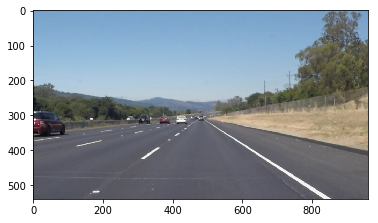

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [196]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, imgcannydummy, imginitdummy, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Counter for identifying the line no#
    i = 0
    # Matrix to store slope m and centre c(x,y)
    lines_mcxy = np.zeros((np.shape(lines)[0], 3))
    for row in lines:
        x1, y1, x2, y2 = row[0,0], row[0,1], row[0,2], row[0,3]
        # Uncomment and run below commented line to see the set of lines obtained from hough tranform in green
        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)
        lines_mcxy[i, 0] = (y2-y1)/(x2-x1)
        lines_mcxy[i, 1] = (x1+x2)/2
        lines_mcxy[i, 2] = (y1+y2)/2
        i = i + 1
    # Group the slopes and (((((centre of the x coordinates??)))) into two clusters
    # ????Only the x coordinate (and not the y) is taken to guide the grouping based on left/right
    #kmeans = KMeans(n_clusters=2)
    #kmeans.fit(lines_mcxy[:,0:1])
    #centroids = kmeans.cluster_centers_
    
    # ml, mr, (clx, cly), (crx, cry) are the slopes and centres of the average left and right lanes respectively
    # ml, mr = centroids[:,0] can be used to directly get slopes from the kmeans algorithm
    # clx, crx = centroids[:,1] can be used to directly get centre coordinates from the kmeans algorithm
        #laneline_a = np.mean(lines_mcxy[np.where(kmeans.labels_)],axis=0)
        #laneline_b = np.mean(lines_mcxy[np.where(kmeans.labels_ - 1)],axis=0)
    group_a = lines_mcxy[(lines_mcxy[:,0]<-0.35) & (lines_mcxy[:,0]>-10)]
    group_b = lines_mcxy[(lines_mcxy[:,0]>0.35) & (lines_mcxy[:,0]<10)]
    laneline_a = np.mean(group_a, axis=0)
    laneline_b = np.mean(group_b, axis=0)
    ml, clx, cly = laneline_a
    mr, crx, cry = laneline_b

    # the intercept of the lines bl and br are calculated using y=mx+b equation
    bl = cly - (ml*clx)
    br = cry - (mr*crx)
    
    # Both lane lines by default starting at max Y of the image and ending at 0.6 of the image
    # Remember, y axis starts from top of the image
    yl1 = img.shape[0]
    yl2 = int(0.6*img.shape[0])
    xl1 = int((yl1 - bl)/ml)
    xl2 = int((yl2 - bl)/ml)
    yr1 = img.shape[0]
    yr2 = int(0.6*img.shape[0])
    xr1 = int((yr1 - br)/mr)
    xr2 = int((yr2 - br)/mr)   
    
    # The left and the right lane lines are plotted on the empty image
    cv2.line(img, (xl1, yl1), (xl2, yl2), color, thickness)
    cv2.line(img, (xr1, yr1), (xr2, yr2), color, thickness)

#    if (np.size(group_a)==0 or np.size(group_b)==0):    
    if mr > 0.7 or mr<0.45:
        print(group_b)
        print(laneline_a, laneline_b)
        plt.figure()
        plt.imshow(img)
        plt.figure()
        plt.imshow(imgcannydummy)
        plt.figure()
        plt.imshow(imginitdummy)
        b,g,r = cv2.split(imginitdummy)
        imginitdummy = cv2.merge((r,g,b))
#        out_fname = "test_images/my_test_image_05.jpg"
#        cv2.imwrite(out_fname, imginitdummy)

def hough_lines(img, dummyinit_img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, img, dummyinit_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [125]:
import os
os.listdir("test_images/")

['output_solidWhiteCurve.jpg',
 'output_solidYellowCurve2.jpg',
 'output_whiteCarLaneSwitch.jpg',
 'output_my_test_image_03.jpg',
 'output_my_test_image_05.jpg',
 'solidYellowLeft.jpg',
 'output_my_test_image.jpg',
 'my_test_image_02.jpg',
 'solidYellowCurve.jpg',
 'my_test_image_05.jpg',
 'my_test_image_03.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'output_my_test_image_04.jpg',
 'my_test_image_04.jpg',
 'solidWhiteCurve.jpg',
 'output_solidWhiteRight.jpg',
 'my_test_image.jpg',
 'output_solidYellowCurve.jpg',
 'output_solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'output_my_test_image_02.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidYellowLeft.jpg
my_test_image_02.jpg
solidYellowCurve.jpg
my_test_image_05.jpg
my_test_image_03.jpg
solidWhiteRight.jpg
solidYellowCurve2.jpg
my_test_image_04.jpg
solidWhiteCurve.jpg
my_test_image.jpg
whiteCarLaneSwitch.jpg


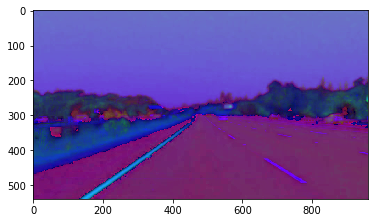

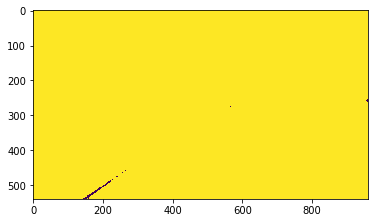

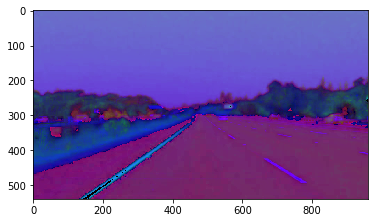

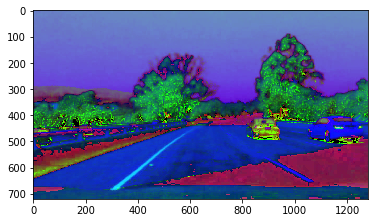

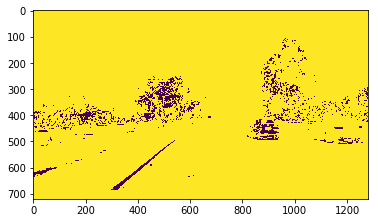

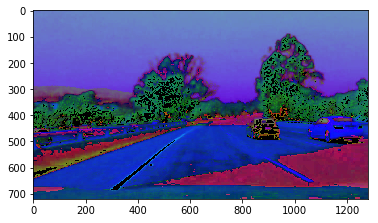

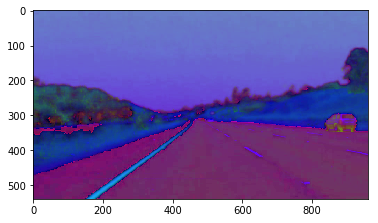

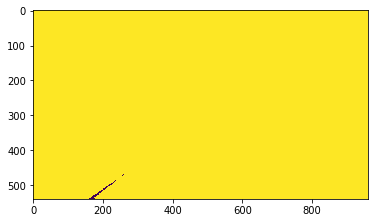

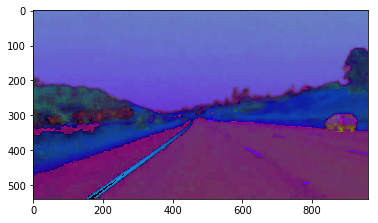

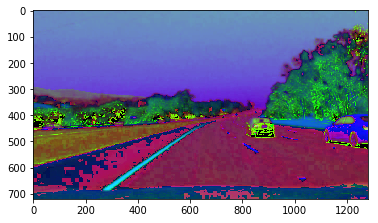

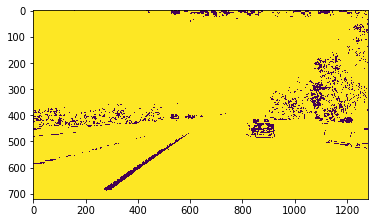

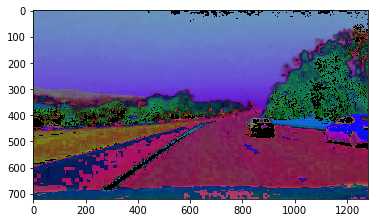

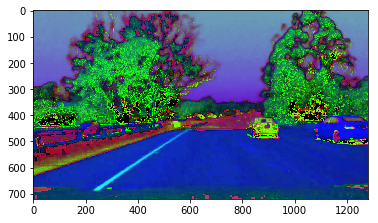

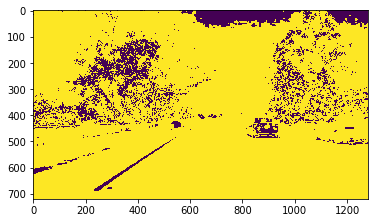

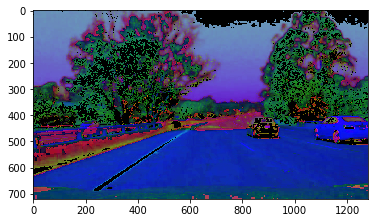

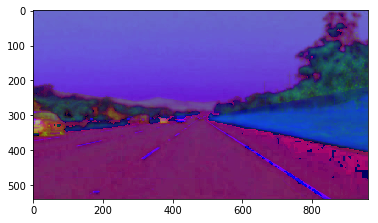

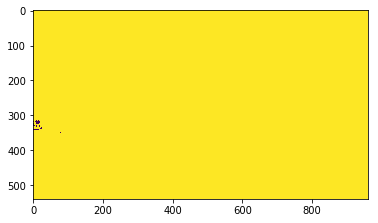

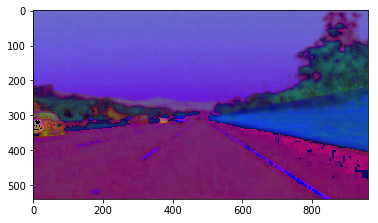

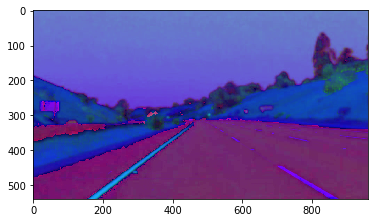

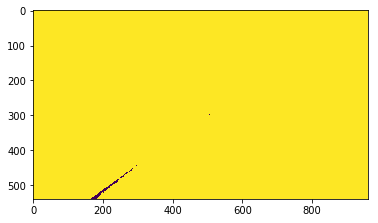

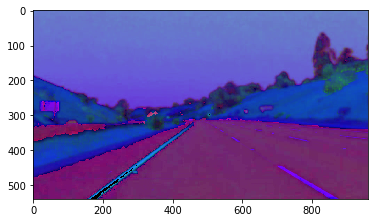

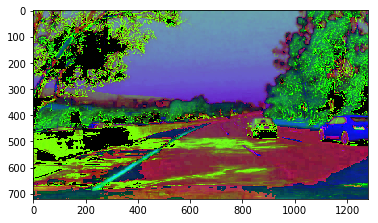

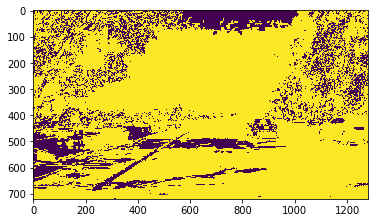

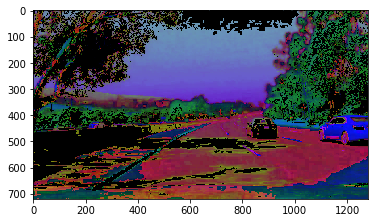

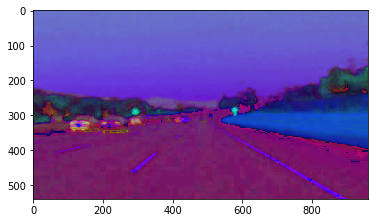

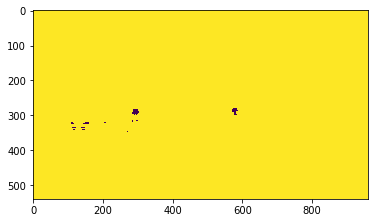

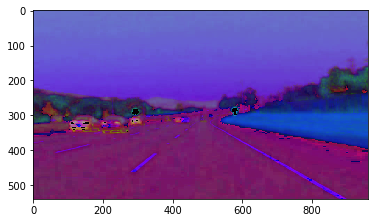

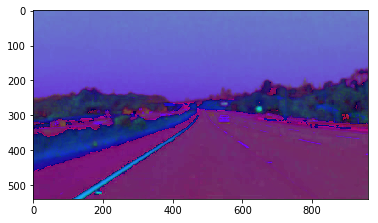

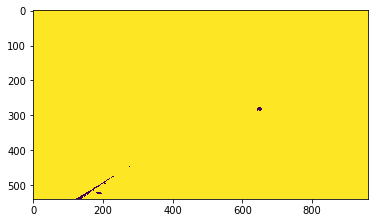

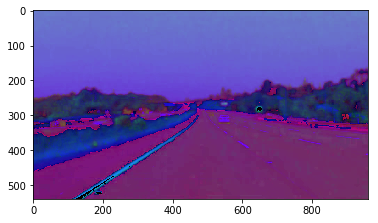

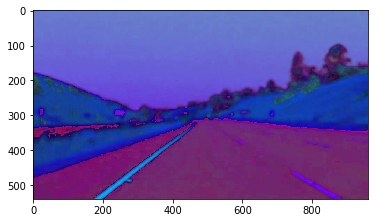

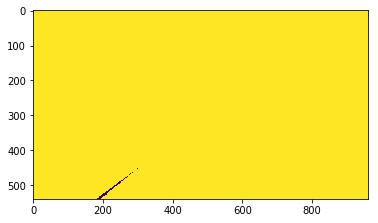

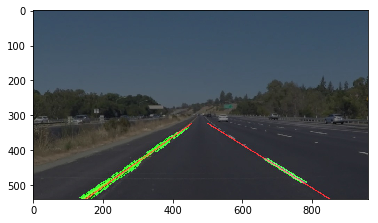

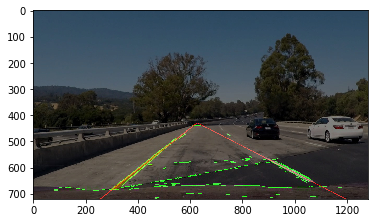

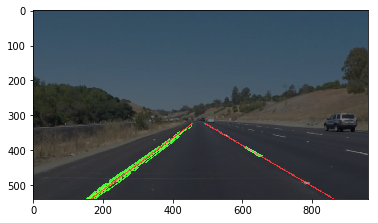

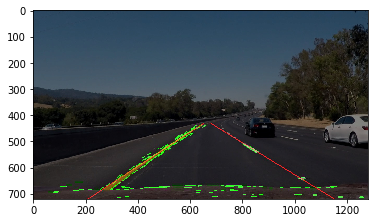

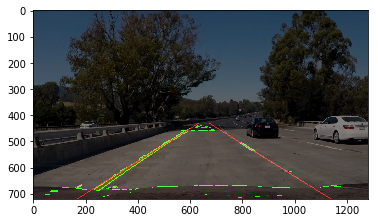

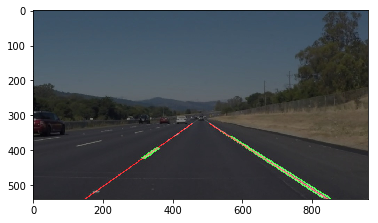

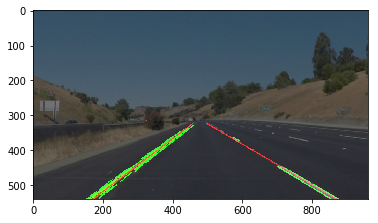

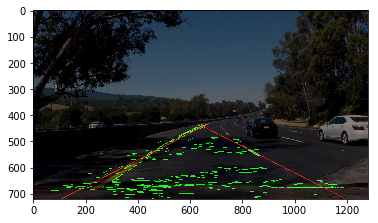

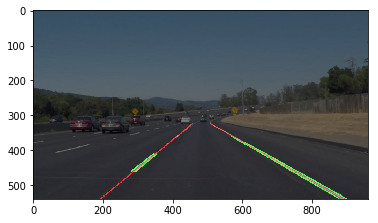

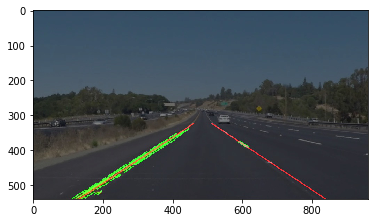

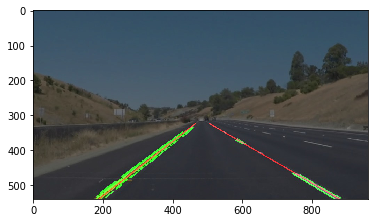

In [205]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
for img_fname in os.listdir("test_images/"):
    if img_fname[0:7] != "output_":
        in_image = mpimg.imread("test_images/"+img_fname)
        imshape = in_image.shape
        # tranform image to grayscale, smoothen it with gaussian blur, detect edges, mask disinterested areas
        gray_image = grayscale(in_image)
        plt.figure()
        plt.imshow(gray_image)
        lower_red = np.array([0,0,0]) #np.array([30,150,50]) 
        upper_red = np.array([179,150,255]) #np.array([255,255,180]) 
        hsvmask = cv2.inRange(gray_image, lower_red, upper_red)
        res_image = cv2.bitwise_and(gray_image,gray_image, mask= hsvmask) 
        plt.figure()
        plt.imshow(hsvmask)
        plt.figure()
        plt.imshow(res_image)
        smooth_image = gaussian_blur(res_image, 5)
        edge_image = canny(smooth_image, 50, 150)
        vertices = np.array([[(0, imshape[0]), (0.49*imshape[1], 0.6*imshape[0]), (0.51*imshape[1], 0.6*imshape[0]), (imshape[1], imshape[0])]], dtype=np.int32)
        mask_image = region_of_interest(edge_image, vertices)
        # extract lines in the image using hough transforms and overlay lines over them
        hough_image = hough_lines(mask_image, in_image, 1, np.pi/180, 30, 10, 2)
        # Switch the commented line with the line below to see a clear output of only the lines on black background
        #  combined_image = weighted_img(hough_image, hough_image, α=0.8, β=1, γ=0.)
        combined_image = weighted_img(hough_image, in_image, α=0.5, β=1, γ=0.)
        # Convert the combined image from BGR to RGB due to opencv conventions
        b,g,r = cv2.split(combined_image)
        out_image = cv2.merge((r,g,b))
        # Write out the output images
        out_fname = "test_images_output/output_" + img_fname
        cv2.imwrite(out_fname, out_image)
    
# Display images from the test_images directory                                  
for in_image in os.listdir("test_images/"):
    if in_image[0:7] != "output_":
#        img = mpimg.imread("test_images/" + in_image)
#        plt.imshow(img)
#        plt.figure()
        img2 = mpimg.imread("test_images_output/output_" + in_image)
        plt.imshow(img2)
        plt.figure()
        print(in_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [102]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [203]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape = image.shape
    # tranform image to grayscale, smoothen it with gaussian blur, detect edges, mask disinterested areas
    gray_image = grayscale(image)
    lower_red = np.array([0,0,100]) #np.array([30,150,50]) 
    upper_red = np.array([179,150,255]) #np.array([255,255,180]) 
    hsvmask = cv2.inRange(gray_image, lower_red, upper_red)
    res_image = cv2.bitwise_and(gray_image,gray_image, mask= hsvmask) 
    smooth_image = gaussian_blur(res_image, 5)
    edge_image = canny(smooth_image, 50, 150)
    vertices = np.array([[(0, imshape[0]), (0.49*imshape[1], 0.6*imshape[0]), (0.51*imshape[1], 0.6*imshape[0]), (imshape[1], imshape[0])]], dtype=np.int32)
    mask_image = region_of_interest(edge_image, vertices)
    # extract lines in the image using hough transforms and overlay lines over them
    hough_image = hough_lines(mask_image, image, 1, np.pi/180, 30, 10, 2)
    result = weighted_img(hough_image, image, α=0.8, β=1, γ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [158]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[  6.47058824e-01   7.04500000e+02   4.47500000e+02]
 [  6.00000000e-01   7.84000000e+02   4.87000000e+02]
 [  6.00000000e-01   6.54500000e+02   4.08500000e+02]
 [  6.09756098e-01   5.82500000e+02   3.69500000e+02]
 [  6.50000000e-01   8.07000000e+02   5.13000000e+02]
 [  6.17021277e-01   6.08500000e+02   3.86500000e+02]
 [  6.03053435e-01   7.00500000e+02   4.36500000e+02]]
[  -0.74872362  323.5         418.25      ] [  6.18127090e-01   6.91642857e+02   4.35500000e+02]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  1%|          | 2/222 [00:00<00:11, 18.90it/s]

[[  6.47058824e-01   7.04500000e+02   4.47500000e+02]
 [  6.00000000e-01   7.84000000e+02   4.87000000e+02]
 [  6.00000000e-01   6.54500000e+02   4.08500000e+02]
 [  6.09756098e-01   5.82500000e+02   3.69500000e+02]
 [  6.50000000e-01   8.07000000e+02   5.13000000e+02]
 [  6.17021277e-01   6.08500000e+02   3.86500000e+02]
 [  6.03053435e-01   7.00500000e+02   4.36500000e+02]]
[  -0.74872362  323.5         418.25      ] [  6.18127090e-01   6.91642857e+02   4.35500000e+02]
[[  6.46551724e-01   7.17000000e+02   4.56000000e+02]
 [  6.02040816e-01   7.70000000e+02   4.79000000e+02]
 [  6.00000000e-01   6.65500000e+02   4.15500000e+02]
 [  6.36363636e-01   8.29500000e+02   5.27500000e+02]
 [  6.46464646e-01   6.32500000e+02   4.02000000e+02]
 [  6.52173913e-01   7.97000000e+02   5.07000000e+02]
 [  6.00000000e-01   8.17000000e+02   5.08000000e+02]
 [  6.50485437e-01   7.29500000e+02   4.63500000e+02]
 [  6.25000000e-01   5.73000000e+02   3.65000000e+02]]
[  -0.72846932  264.2         462.1  


  2%|▏         | 5/222 [00:00<00:10, 20.00it/s]

[[  6.01423488e-01   7.26500000e+02   4.52500000e+02]
 [  6.26168224e-01   6.62000000e+02   4.21000000e+02]
 [  6.29629630e-01   7.54500000e+02   4.79500000e+02]
 [  6.25954198e-01   6.26500000e+02   3.98000000e+02]
 [  5.90909091e-01   5.94000000e+02   3.73500000e+02]
 [  6.31578947e-01   8.27000000e+02   5.26000000e+02]
 [  6.00000000e-01   8.28000000e+02   5.14000000e+02]
 [  5.45454545e-01   7.36500000e+02   4.64000000e+02]
 [  6.25000000e-01   7.15000000e+02   4.46000000e+02]]
[  -0.74448786  271.6         457.2       ] [  6.08457569e-01   7.18888889e+02   4.52722222e+02]
[[  6.01226994e-01   6.88500000e+02   4.29000000e+02]
 [  6.25668449e-01   6.50500000e+02   4.13500000e+02]
 [  6.05263158e-01   7.94000000e+02   4.93000000e+02]
 [  6.26016260e-01   7.86500000e+02   4.99500000e+02]
 [  5.92592593e-01   5.98500000e+02   3.76000000e+02]
 [  6.11111111e-01   6.13000000e+02   3.84000000e+02]
 [  6.00000000e-01   7.67000000e+02   4.82000000e+02]
 [  6.19047619e-01   7.45500000e+02   

[[  5.98591549e-01   7.28000000e+02   4.53000000e+02]
 [  6.25000000e-01   6.91000000e+02   4.39000000e+02]
 [  6.45348837e-01   7.22000000e+02   4.58500000e+02]
 [  6.47482014e-01   7.78500000e+02   4.94000000e+02]
 [  6.40000000e-01   5.99500000e+02   3.81000000e+02]
 [  6.00000000e-01   7.36000000e+02   4.57000000e+02]
 [  6.60000000e-01   6.40000000e+02   4.06500000e+02]
 [  6.00000000e-01   7.79500000e+02   4.89500000e+02]
 [  6.40000000e-01   5.86000000e+02   3.73000000e+02]]
[  -0.75498575  367.75        384.5       ] [  6.28491378e-01   6.95611111e+02   4.39055556e+02]
[[  6.05633803e-01   8.34500000e+02   5.16500000e+02]
 [  6.27777778e-01   7.59000000e+02   4.81500000e+02]
 [  6.26760563e-01   6.33000000e+02   4.01500000e+02]
 [  6.00000000e-01   7.36000000e+02   4.57000000e+02]
 [  6.42857143e-01   7.59000000e+02   4.75500000e+02]
 [  5.94594595e-01   6.05500000e+02   3.80000000e+02]
 [  6.11111111e-01   6.46000000e+02   4.03500000e+02]
 [  6.11111111e-01   6.26000000e+02   


  4%|▎         | 8/222 [00:00<00:10, 20.93it/s]

[[  6.25000000e-01   5.74000000e+02   3.64500000e+02]
 [  6.25000000e-01   7.14000000e+02   4.53000000e+02]
 [  5.96774194e-01   7.27000000e+02   4.51500000e+02]
 [  6.21621622e-01   8.14000000e+02   5.15000000e+02]
 [  6.08695652e-01   6.09000000e+02   3.82000000e+02]
 [  6.11111111e-01   6.51000000e+02   4.06500000e+02]
 [  6.15384615e-01   5.98000000e+02   3.80000000e+02]
 [  6.13636364e-01   8.51000000e+02   5.24500000e+02]
 [  5.88235294e-01   6.89500000e+02   4.37000000e+02]
 [  6.04166667e-01   8.21000000e+02   5.07500000e+02]
 [  6.00000000e-01   6.72000000e+02   4.26000000e+02]
 [  6.06060606e-01   6.49500000e+02   4.12000000e+02]
 [  6.08695652e-01   5.72500000e+02   3.64000000e+02]
 [  5.83333333e-01   8.61000000e+02   5.31500000e+02]
 [  6.00000000e-01   7.12500000e+02   4.51500000e+02]
 [  6.18181818e-01   6.21500000e+02   3.89000000e+02]
 [  6.00000000e-01   7.34000000e+02   4.65000000e+02]]
[  -0.7205223  350.375      396.625    ] [  6.07405702e-01   6.98323529e+02   4.3

[[  6.00000000e-01   5.98000000e+02   3.75000000e+02]
 [  6.26373626e-01   6.48000000e+02   4.12000000e+02]
 [  6.00000000e-01   7.28500000e+02   4.53500000e+02]
 [  6.26506024e-01   7.23500000e+02   4.60000000e+02]
 [  6.08695652e-01   6.08000000e+02   3.82000000e+02]
 [  6.31578947e-01   5.71500000e+02   3.63000000e+02]
 [  5.45454545e-01   7.65500000e+02   4.82000000e+02]
 [  6.31578947e-01   5.88500000e+02   3.74000000e+02]
 [  6.11111111e-01   6.35000000e+02   3.98000000e+02]]
[  -0.71218939  336.5         406.2       ] [  6.09033206e-01   6.51833333e+02   4.11055556e+02]
[[  6.00682594e-01   7.18500000e+02   4.50000000e+02]
 [  6.27118644e-01   7.26000000e+02   4.64000000e+02]
 [  6.26436782e-01   6.75000000e+02   4.31500000e+02]
 [  6.19047619e-01   5.75000000e+02   3.68000000e+02]
 [  5.71428571e-01   7.46500000e+02   4.70000000e+02]
 [  6.25000000e-01   8.31000000e+02   5.30500000e+02]
 [  6.21621622e-01   6.00500000e+02   3.84500000e+02]
 [  6.13636364e-01   6.23000000e+02   


  5%|▍         | 11/222 [00:00<00:09, 21.51it/s]

[[  6.04651163e-01   7.72000000e+02   4.85000000e+02]
 [  6.28415301e-01   7.12500000e+02   4.58500000e+02]
 [  6.19047619e-01   6.35500000e+02   4.02500000e+02]
 [  6.22222222e-01   6.02000000e+02   3.83000000e+02]
 [  6.25000000e-01   5.61000000e+02   3.61000000e+02]
 [  6.19047619e-01   6.19000000e+02   3.99000000e+02]
 [  6.00000000e-01   7.50000000e+02   4.76000000e+02]
 [  5.84905660e-01   8.32500000e+02   5.21500000e+02]
 [  6.21621622e-01   5.64500000e+02   3.63500000e+02]
 [  6.31578947e-01   7.13000000e+02   4.50000000e+02]
 [  6.21621622e-01   6.01500000e+02   3.87500000e+02]
 [  6.17647059e-01   6.40000000e+02   4.12500000e+02]
 [  7.08333333e-01   8.21000000e+02   5.27500000e+02]
 [  6.34615385e-01   6.39000000e+02   4.05500000e+02]
 [  6.15384615e-01   6.93500000e+02   4.46000000e+02]
 [  6.33333333e-01   7.32000000e+02   4.71500000e+02]
 [  6.42857143e-01   7.76000000e+02   4.90500000e+02]
 [  6.12903226e-01   5.84500000e+02   3.76500000e+02]
 [  6.31578947e-01   5.82000

[[  6.24309392e-01   6.50500000e+02   4.13500000e+02]
 [  6.50909091e-01   6.95500000e+02   4.49500000e+02]
 [  6.17391304e-01   7.82500000e+02   4.94500000e+02]
 [  6.22950820e-01   5.61500000e+02   3.62000000e+02]
 [  6.34146341e-01   5.86500000e+02   3.78000000e+02]
 [  6.66666667e-01   7.38500000e+02   4.74000000e+02]
 [  6.23188406e-01   8.20500000e+02   5.17500000e+02]
 [  6.47058824e-01   6.33000000e+02   4.02000000e+02]
 [  6.87500000e-01   8.07000000e+02   5.19500000e+02]
 [  6.34146341e-01   7.01500000e+02   4.45000000e+02]
 [  6.38888889e-01   6.04000000e+02   3.89500000e+02]
 [  6.42857143e-01   8.18000000e+02   5.20500000e+02]
 [  6.48648649e-01   5.91500000e+02   3.76000000e+02]
 [  6.66666667e-01   7.40000000e+02   4.74000000e+02]]
[  -0.73732658  261.58333333  464.91666667] [  6.43237752e-01   6.95035714e+02   4.43964286e+02]



  6%|▋         | 14/222 [00:00<00:09, 21.88it/s]

[[  6.28571429e-01   6.45000000e+02   4.09000000e+02]
 [  6.53658537e-01   7.30500000e+02   4.72000000e+02]
 [  6.56488550e-01   6.33500000e+02   4.08000000e+02]
 [  6.25000000e-01   8.07000000e+02   5.09000000e+02]
 [  6.49350649e-01   5.84500000e+02   3.75000000e+02]
 [  6.87500000e-01   8.12000000e+02   5.21500000e+02]
 [  6.48648649e-01   7.43500000e+02   4.70000000e+02]
 [  6.66666667e-01   7.30500000e+02   4.62000000e+02]
 [  6.57142857e-01   8.15500000e+02   5.26500000e+02]
 [  6.66666667e-01   7.65500000e+02   4.84000000e+02]
 [  6.48648649e-01   6.06500000e+02   3.84000000e+02]
 [  6.47058824e-01   8.16500000e+02   5.19500000e+02]
 [  7.00000000e-01   8.04000000e+02   5.16500000e+02]]
[  -0.73254681  243.41666667  477.41666667] [  6.56569344e-01   7.30346154e+02   4.65923077e+02]
[[  6.25000000e-01   7.97000000e+02   5.01500000e+02]
 [  6.48648649e-01   7.42500000e+02   4.78000000e+02]
 [  6.44859813e-01   6.63500000e+02   4.18500000e+02]
 [  6.52173913e-01   5.99000000e+02   


  8%|▊         | 17/222 [00:00<00:09, 22.45it/s]

[[  6.24087591e-01   7.22000000e+02   4.53500000e+02]
 [  6.68639053e-01   6.46500000e+02   4.13500000e+02]
 [  6.70000000e-01   6.98000000e+02   4.47000000e+02]
 [  6.61538462e-01   8.03500000e+02   5.16500000e+02]
 [  6.26086957e-01   7.68500000e+02   4.83000000e+02]
 [  6.17647059e-01   8.42000000e+02   5.27500000e+02]
 [  6.25000000e-01   7.58000000e+02   4.79500000e+02]
 [  6.25000000e-01   6.32000000e+02   3.96500000e+02]]
[  -0.72214629  173.9         518.2       ] [  6.39749890e-01   7.33812500e+02   4.64625000e+02]
[[  6.23616236e-01   7.23500000e+02   4.53500000e+02]
 [  6.70212766e-01   6.64000000e+02   4.24000000e+02]
 [  6.68639053e-01   7.46500000e+02   4.78500000e+02]
 [  6.25000000e-01   7.87000000e+02   4.94000000e+02]
 [  6.56250000e-01   8.21000000e+02   5.27500000e+02]
 [  6.00000000e-01   7.67500000e+02   4.84500000e+02]
 [  6.53846154e-01   5.92000000e+02   3.76500000e+02]
 [  6.47058824e-01   7.90500000e+02   4.98500000e+02]
 [  6.25000000e-01   5.74000000e+02   


  9%|▉         | 20/222 [00:00<00:08, 22.49it/s]

[[  6.23655914e-01   7.16500000e+02   4.51000000e+02]
 [  6.49006623e-01   6.26500000e+02   4.01000000e+02]
 [  6.54676259e-01   6.75500000e+02   4.33500000e+02]
 [  6.53061224e-01   7.85000000e+02   5.06000000e+02]
 [  6.50793651e-01   5.88500000e+02   3.75500000e+02]
 [  6.20689655e-01   7.44500000e+02   4.79000000e+02]
 [  6.38888889e-01   6.14000000e+02   3.87500000e+02]
 [  6.15384615e-01   7.53500000e+02   4.78000000e+02]
 [  6.87500000e-01   7.87000000e+02   5.04500000e+02]
 [  6.66666667e-01   8.21000000e+02   5.29000000e+02]
 [  6.47058824e-01   7.86500000e+02   4.98500000e+02]]
[  -0.66518354  357.5         390.5       ] [  6.46125665e-01   7.18045455e+02   4.58500000e+02]
[[  6.21908127e-01   7.13500000e+02   4.50000000e+02]
 [  6.48809524e-01   6.28000000e+02   4.03500000e+02]
 [  6.53465347e-01   7.82500000e+02   5.05000000e+02]
 [  6.38297872e-01   5.78500000e+02   3.70000000e+02]
 [  6.42857143e-01   6.92000000e+02   4.45500000e+02]
 [  6.53846154e-01   7.49000000e+02   

[[  6.27118644e-01   6.63500000e+02   4.20500000e+02]
 [  6.55737705e-01   6.61000000e+02   4.26000000e+02]
 [  6.24413146e-01   6.70500000e+02   4.24500000e+02]
 [  6.31578947e-01   6.97500000e+02   4.44000000e+02]
 [  6.73913043e-01   7.72000000e+02   4.99000000e+02]
 [  6.11940299e-01   8.15500000e+02   5.14500000e+02]
 [  6.36363636e-01   5.96000000e+02   3.83000000e+02]
 [  6.26865672e-01   5.71500000e+02   3.67000000e+02]
 [  6.74418605e-01   7.89000000e+02   5.10000000e+02]
 [  6.07843137e-01   8.27500000e+02   5.22500000e+02]
 [  6.21621622e-01   5.60500000e+02   3.59500000e+02]
 [  6.19047619e-01   8.12500000e+02   5.16500000e+02]
 [  6.42857143e-01   6.29000000e+02   4.04500000e+02]]
[  -0.68956143  336.66666667  410.        ] [  6.34901478e-01   6.97384615e+02   4.45500000e+02]
[[  6.32911392e-01   8.14500000e+02   5.14000000e+02]
 [  6.50273224e-01   6.29500000e+02   4.05500000e+02]
 [  6.23809524e-01   6.67000000e+02   4.22500000e+02]
 [  6.59090909e-01   6.80000000e+02   


 10%|█         | 23/222 [00:01<00:09, 21.27it/s]


[[  6.25000000e-01   7.10000000e+02   4.49000000e+02]
 [  6.69565217e-01   6.23500000e+02   4.00500000e+02]
 [  6.70658683e-01   6.85500000e+02   4.41000000e+02]
 [  6.25000000e-01   6.46000000e+02   4.08000000e+02]
 [  6.70588235e-01   7.90500000e+02   5.10500000e+02]
 [  6.25000000e-01   5.60000000e+02   3.59000000e+02]
 [  6.66666667e-01   6.86000000e+02   4.36000000e+02]
 [  6.00000000e-01   6.98000000e+02   4.44000000e+02]]
[  -0.70507384  318.91666667  420.41666667] [  6.44059850e-01   6.74937500e+02   4.31000000e+02]



 12%|█▏        | 26/222 [00:01<00:09, 21.45it/s]

[[  6.27118644e-01   7.37000000e+02   4.65000000e+02]
 [  6.49425287e-01   6.33000000e+02   4.06500000e+02]
 [  6.52777778e-01   7.62000000e+02   4.91000000e+02]
 [  6.25698324e-01   6.64500000e+02   4.19000000e+02]
 [  6.52631579e-01   7.86500000e+02   5.08000000e+02]
 [  6.15384615e-01   6.94500000e+02   4.42000000e+02]
 [  6.49484536e-01   5.99500000e+02   3.83500000e+02]
 [  6.15384615e-01   8.12500000e+02   5.15000000e+02]
 [  6.00000000e-01   5.75500000e+02   3.64500000e+02]]
[  -0.70417824  321.92857143  418.5       ] [  6.31989487e-01   6.96111111e+02   4.43833333e+02]
[[  6.14457831e-01   6.09500000e+02   3.85500000e+02]
 [  6.26373626e-01   6.66000000e+02   4.20000000e+02]
 [  6.48351648e-01   6.37000000e+02   4.09000000e+02]
 [  6.56250000e-01   7.84000000e+02   5.05500000e+02]
 [  6.51162791e-01   7.90000000e+02   5.10000000e+02]
 [  6.47058824e-01   6.25500000e+02   4.00500000e+02]
 [  6.24365482e-01   7.55500000e+02   4.76500000e+02]
 [  6.36363636e-01   7.46500000e+02   


 13%|█▎        | 29/222 [00:01<00:08, 21.68it/s]

[[  6.29629630e-01   8.14500000e+02   5.13500000e+02]
 [  6.50980392e-01   6.71500000e+02   4.32000000e+02]
 [  6.21621622e-01   6.44000000e+02   4.06000000e+02]
 [  6.09756098e-01   7.70000000e+02   4.85000000e+02]
 [  6.09195402e-01   6.90500000e+02   4.35500000e+02]
 [  6.34615385e-01   6.15000000e+02   3.88500000e+02]
 [  6.25000000e-01   5.60000000e+02   3.58500000e+02]
 [  6.25000000e-01   7.48000000e+02   4.74000000e+02]
 [  6.55172414e-01   5.88500000e+02   3.72500000e+02]
 [  7.00000000e-01   8.19000000e+02   5.28500000e+02]
 [  6.50793651e-01   6.30000000e+02   4.04000000e+02]
 [  6.53846154e-01   7.72000000e+02   4.94500000e+02]
 [  7.14285714e-01   8.03000000e+02   5.10000000e+02]
 [  6.36363636e-01   6.56500000e+02   4.18500000e+02]
 [  6.42857143e-01   7.80000000e+02   5.03500000e+02]
 [  6.84210526e-01   7.75500000e+02   4.97500000e+02]
 [  6.25000000e-01   7.87000000e+02   4.98000000e+02]]
[  -0.6905637  247.4        471.85     ] [  6.45195751e-01   7.13235294e+02   4.5


 14%|█▍        | 32/222 [00:01<00:08, 21.96it/s]

[[  6.25668449e-01   6.68500000e+02   4.21500000e+02]
 [  6.50000000e-01   6.76000000e+02   4.34500000e+02]
 [  6.55172414e-01   7.62500000e+02   4.91500000e+02]
 [  6.20000000e-01   6.20000000e+02   3.92000000e+02]
 [  6.52631579e-01   5.98500000e+02   3.83000000e+02]
 [  5.45454545e-01   7.51500000e+02   4.76000000e+02]
 [  6.44736842e-01   8.18000000e+02   5.14500000e+02]
 [  6.45161290e-01   7.81500000e+02   4.92000000e+02]
 [  6.47058824e-01   6.77500000e+02   4.34500000e+02]
 [  6.66666667e-01   7.13000000e+02   4.56000000e+02]
 [  6.28571429e-01   6.94500000e+02   4.37000000e+02]]
[  -0.7102122  369.25       384.75     ] [  6.34647458e-01   7.05590909e+02   4.48409091e+02]
[[  6.23481781e-01   6.98500000e+02   4.40000000e+02]
 [  6.50349650e-01   6.93000000e+02   4.45000000e+02]
 [  6.22406639e-01   7.36500000e+02   4.63000000e+02]
 [  6.51428571e-01   6.38500000e+02   4.09000000e+02]
 [  6.47058824e-01   7.84000000e+02   5.05000000e+02]
 [  6.29629630e-01   5.85500000e+02   3.7

[[  6.52173913e-01   5.99000000e+02   3.83000000e+02]
 [  6.51408451e-01   6.94000000e+02   4.45500000e+02]
 [  6.26168224e-01   6.28500000e+02   3.96500000e+02]
 [  6.26436782e-01   7.71000000e+02   4.84500000e+02]
 [  6.23376623e-01   6.12500000e+02   3.87000000e+02]
 [  6.45161290e-01   7.03500000e+02   4.43000000e+02]
 [  6.22222222e-01   7.92500000e+02   4.97000000e+02]
 [  6.31578947e-01   6.69500000e+02   4.21000000e+02]]
[  -0.69584049  353.5         394.91666667] [  6.34815807e-01   6.83812500e+02   4.32187500e+02]
[[  6.48083624e-01   6.93500000e+02   4.45000000e+02]
 [  6.23595506e-01   7.69000000e+02   4.83500000e+02]
 [  6.41975309e-01   6.17500000e+02   3.90000000e+02]
 [  6.66666667e-01   6.59000000e+02   4.16000000e+02]
 [  6.42857143e-01   7.87000000e+02   5.01500000e+02]
 [  6.42857143e-01   8.17000000e+02   5.21500000e+02]
 [  6.40000000e-01   5.99000000e+02   3.79000000e+02]
 [  6.52631579e-01   7.88500000e+02   5.08000000e+02]
 [  6.00000000e-01   6.79000000e+02   


 16%|█▌        | 35/222 [00:01<00:08, 22.25it/s]

[[  6.50000000e-01   7.54000000e+02   4.86000000e+02]
 [  6.27118644e-01   7.66500000e+02   4.83500000e+02]
 [  6.56716418e-01   7.33500000e+02   4.72000000e+02]
 [  6.40625000e-01   6.00000000e+02   3.80500000e+02]
 [  6.70454545e-01   5.92000000e+02   3.80500000e+02]
 [  6.38888889e-01   6.40000000e+02   4.05000000e+02]
 [  6.42857143e-01   6.42000000e+02   4.13500000e+02]
 [  6.00000000e-01   7.81000000e+02   4.98000000e+02]
 [  7.00000000e-01   8.19000000e+02   5.24500000e+02]
 [  6.40000000e-01   5.76500000e+02   3.66000000e+02]
 [  6.50000000e-01   6.90000000e+02   4.36500000e+02]
 [  6.20689655e-01   6.66500000e+02   4.29000000e+02]
 [  6.47058824e-01   6.18000000e+02   3.97000000e+02]
 [  6.66666667e-01   5.76000000e+02   3.69000000e+02]
 [  6.11111111e-01   7.87000000e+02   5.03500000e+02]
 [  7.00000000e-01   5.51000000e+02   3.53500000e+02]
 [  6.19047619e-01   6.38500000e+02   4.10500000e+02]
 [  6.50000000e-01   7.66000000e+02   4.87500000e+02]
 [  6.47058824e-01   6.65500


 17%|█▋        | 38/222 [00:01<00:08, 21.90it/s]

[[  6.24113475e-01   7.05000000e+02   4.46000000e+02]
 [  6.51933702e-01   7.42500000e+02   4.80000000e+02]
 [  6.51685393e-01   6.99500000e+02   4.51000000e+02]
 [  6.47058824e-01   5.69000000e+02   3.65000000e+02]
 [  6.20689655e-01   8.25000000e+02   5.20000000e+02]
 [  6.47058824e-01   5.82000000e+02   3.74000000e+02]
 [  6.11111111e-01   5.55000000e+02   3.55500000e+02]
 [  6.27906977e-01   5.89500000e+02   3.73500000e+02]
 [  6.33333333e-01   6.21000000e+02   3.94500000e+02]
 [  6.42857143e-01   6.08000000e+02   3.91000000e+02]]
[  -0.72178494  309.25        429.1       ] [  6.35774844e-01   6.49650000e+02   4.15050000e+02]
[[  6.20253165e-01   6.07500000e+02   3.84500000e+02]
 [  6.53846154e-01   6.48000000e+02   4.17000000e+02]
 [  6.25000000e-01   7.03000000e+02   4.44500000e+02]
 [  6.54205607e-01   7.79500000e+02   5.04000000e+02]
 [  6.54320988e-01   5.97500000e+02   3.83500000e+02]
 [  6.11111111e-01   5.59000000e+02   3.57500000e+02]
 [  6.36363636e-01   7.22000000e+02   


 18%|█▊        | 41/222 [00:01<00:08, 22.40it/s]

[[  6.25000000e-01   7.14000000e+02   4.50500000e+02]
 [  6.52173913e-01   7.19000000e+02   4.63000000e+02]
 [  6.50000000e-01   5.71000000e+02   3.65000000e+02]
 [  6.51315789e-01   7.57000000e+02   4.88500000e+02]
 [  6.40000000e-01   6.14000000e+02   3.94000000e+02]
 [  6.30136986e-01   6.44500000e+02   4.08000000e+02]
 [  6.38888889e-01   5.89000000e+02   3.77500000e+02]
 [  6.66666667e-01   7.45000000e+02   4.77000000e+02]
 [  6.53846154e-01   5.73000000e+02   3.66500000e+02]
 [  6.25000000e-01   7.71000000e+02   4.87000000e+02]]
[  -0.71685015  254.25        466.58333333] [  6.43302840e-01   6.69750000e+02   4.27700000e+02]
[[  6.26506024e-01   7.72000000e+02   4.87000000e+02]
 [  6.29032258e-01   6.37000000e+02   4.02000000e+02]
 [  6.71361502e-01   6.65500000e+02   4.27500000e+02]
 [  6.73913043e-01   7.64000000e+02   4.92500000e+02]
 [  6.77777778e-01   6.00000000e+02   3.84500000e+02]
 [  6.66666667e-01   8.28000000e+02   5.34000000e+02]
 [  6.36363636e-01   7.64500000e+02   

[[  6.25498008e-01   7.28500000e+02   4.59500000e+02]
 [  6.73913043e-01   6.24000000e+02   4.00500000e+02]
 [  6.29921260e-01   6.40500000e+02   4.04000000e+02]
 [  6.66666667e-01   7.94500000e+02   5.13000000e+02]
 [  6.70212766e-01   7.60000000e+02   4.90500000e+02]
 [  6.77419355e-01   6.74500000e+02   4.33500000e+02]
 [  6.00000000e-01   6.82000000e+02   4.34000000e+02]
 [  6.25000000e-01   7.14000000e+02   4.51500000e+02]
 [  7.00000000e-01   7.21000000e+02   4.58500000e+02]
 [  6.92307692e-01   7.21000000e+02   4.65000000e+02]
 [  6.76470588e-01   5.78000000e+02   3.68500000e+02]]
[  -0.73303671  360.5         388.5       ] [  6.57946307e-01   6.94363636e+02   4.43500000e+02]
[[  6.27659574e-01   7.61000000e+02   4.80000000e+02]
 [  6.72566372e-01   6.72000000e+02   4.32000000e+02]
 [  6.60000000e-01   6.08000000e+02   3.83500000e+02]
 [  6.72727273e-01   8.05500000e+02   5.20500000e+02]
 [  6.36363636e-01   6.79500000e+02   4.32500000e+02]
 [  6.66666667e-01   6.42000000e+02   

 20%|█▉        | 44/222 [00:02<00:11, 15.28it/s]

[[  6.32352941e-01   6.28000000e+02   3.96500000e+02]
 [  6.70886076e-01   6.73500000e+02   4.33500000e+02]
 [  6.25000000e-01   7.61000000e+02   4.80500000e+02]
 [  6.74242424e-01   7.65000000e+02   4.94500000e+02]
 [  6.47058824e-01   7.10500000e+02   4.51500000e+02]
 [  6.42857143e-01   6.78000000e+02   4.31500000e+02]
 [  6.89655172e-01   8.16500000e+02   5.28000000e+02]
 [  6.36363636e-01   7.91500000e+02   5.05500000e+02]
 [  6.74418605e-01   6.04500000e+02   3.81500000e+02]
 [  6.66666667e-01   5.79000000e+02   3.69000000e+02]
 [  6.42857143e-01   7.58000000e+02   4.86500000e+02]
 [  6.50000000e-01   5.89000000e+02   3.71500000e+02]]
[  -0.74948221  354.5         392.9       ] [  6.54363219e-01   6.96208333e+02   4.44166667e+02]
[[  6.71428571e-01   6.74000000e+02   4.33500000e+02]
 [  6.24505929e-01   7.28500000e+02   4.59000000e+02]
 [  6.74418605e-01   6.25000000e+02   4.01000000e+02]
 [  6.50000000e-01   7.92000000e+02   5.12000000e+02]
 [  6.41025641e-01   5.74500000e+02   

 21%|██        | 46/222 [00:02<00:12, 13.54it/s]

[[  6.75496689e-01   6.37500000e+02   4.08000000e+02]
 [  6.41025641e-01   6.73500000e+02   4.24500000e+02]
 [  6.28865979e-01   8.06500000e+02   5.08500000e+02]
 [  6.82926829e-01   6.08500000e+02   3.83000000e+02]
 [  6.55462185e-01   7.38500000e+02   4.76000000e+02]
 [  6.17021277e-01   7.48500000e+02   4.71500000e+02]
 [  6.52173913e-01   8.09000000e+02   5.23000000e+02]
 [  6.94444444e-01   6.69000000e+02   4.24500000e+02]
 [  6.66666667e-01   6.29000000e+02   3.96000000e+02]
 [  6.47058824e-01   7.12000000e+02   4.52000000e+02]
 [  6.66666667e-01   6.67000000e+02   4.29000000e+02]
 [  6.12903226e-01   6.98000000e+02   4.40000000e+02]
 [  6.60714286e-01   6.12000000e+02   3.91500000e+02]
 [  6.15384615e-01   7.94500000e+02   5.04000000e+02]
 [  6.37931034e-01   7.89000000e+02   5.09500000e+02]
 [  6.55172414e-01   6.54000000e+02   4.20000000e+02]
 [  6.53846154e-01   5.96000000e+02   3.75500000e+02]]
[  -0.73047406  327.25        411.        ] [  6.50809461e-01   6.96617647e+02   

 22%|██▏       | 48/222 [00:02<00:13, 12.93it/s]

[[  6.71814672e-01   6.88500000e+02   4.43000000e+02]
 [  6.27049180e-01   7.32000000e+02   4.61500000e+02]
 [  6.72619048e-01   6.39000000e+02   4.10500000e+02]
 [  6.92307692e-01   6.66500000e+02   4.23500000e+02]
 [  6.73469388e-01   7.82000000e+02   5.05000000e+02]
 [  6.31578947e-01   7.05500000e+02   4.49000000e+02]
 [  6.36363636e-01   5.88000000e+02   3.71000000e+02]
 [  6.34146341e-01   8.12000000e+02   5.13000000e+02]
 [  6.59090909e-01   6.09000000e+02   3.83500000e+02]
 [  6.66666667e-01   7.87000000e+02   5.00000000e+02]
 [  6.66666667e-01   7.21500000e+02   4.59000000e+02]
 [  6.47058824e-01   6.70500000e+02   4.22500000e+02]]
[  -0.70484137  308.3         424.6       ] [  6.56569331e-01   7.00125000e+02   4.45125000e+02]
[[  6.72811060e-01   6.63500000e+02   4.27000000e+02]
 [  6.26050420e-01   7.35000000e+02   4.63500000e+02]
 [  6.72794118e-01   6.95000000e+02   4.47500000e+02]
 [  6.24203822e-01   7.74500000e+02   4.89000000e+02]
 [  6.25000000e-01   7.02000000e+02   

 23%|██▎       | 50/222 [00:02<00:13, 12.47it/s]

[[  6.71232877e-01   6.62500000e+02   4.26500000e+02]
 [  6.75675676e-01   6.25000000e+02   4.00000000e+02]
 [  6.48484848e-01   6.73500000e+02   4.25500000e+02]
 [  6.47058824e-01   7.27500000e+02   4.59500000e+02]
 [  6.36363636e-01   5.91500000e+02   3.73500000e+02]
 [  6.11111111e-01   7.28000000e+02   4.63500000e+02]
 [  6.66666667e-01   7.90500000e+02   5.11000000e+02]
 [  6.41025641e-01   8.09000000e+02   5.11000000e+02]
 [  6.25000000e-01   7.10000000e+02   4.52000000e+02]
 [  6.30434783e-01   8.30000000e+02   5.23500000e+02]
 [  6.45833333e-01   6.27000000e+02   3.96000000e+02]
 [  6.42857143e-01   5.66000000e+02   3.60500000e+02]
 [  6.31578947e-01   7.68500000e+02   4.94000000e+02]]
[  -0.7314345   278.58333333  446.08333333] [  6.44101807e-01   7.00692308e+02   4.45884615e+02]
[[  6.72794118e-01   6.95000000e+02   4.47500000e+02]
 [  6.30630631e-01   6.98500000e+02   4.41000000e+02]
 [  6.25000000e-01   6.19000000e+02   3.90500000e+02]
 [  6.21848739e-01   7.93500000e+02   

 23%|██▎       | 52/222 [00:02<00:14, 11.91it/s]

[[  6.72794118e-01   6.95000000e+02   4.47500000e+02]
 [  6.25766871e-01   7.71500000e+02   4.87000000e+02]
 [  6.26865672e-01   6.42000000e+02   4.05000000e+02]
 [  7.27272727e-01   7.31500000e+02   4.66000000e+02]
 [  7.05882353e-01   6.84500000e+02   4.35000000e+02]
 [  6.66666667e-01   5.86000000e+02   3.75000000e+02]
 [  6.15384615e-01   7.02000000e+02   4.43000000e+02]
 [  6.81818182e-01   7.92000000e+02   5.12000000e+02]
 [  6.66666667e-01   6.49500000e+02   4.16000000e+02]
 [  6.40000000e-01   5.95500000e+02   3.75000000e+02]]
[  -0.69653155  247.4         465.7       ] [  6.62911787e-01   6.84950000e+02   4.36150000e+02]


 24%|██▍       | 54/222 [00:03<00:14, 11.79it/s]

[[  6.26506024e-01   6.42500000e+02   4.06000000e+02]
 [  6.55172414e-01   6.30000000e+02   4.04000000e+02]
 [  6.45833333e-01   7.44000000e+02   4.69500000e+02]
 [  6.66666667e-01   7.66500000e+02   4.95000000e+02]
 [  6.52173913e-01   5.76000000e+02   3.68000000e+02]
 [  6.59574468e-01   6.06500000e+02   3.82500000e+02]
 [  6.00000000e-01   7.58000000e+02   4.87000000e+02]
 [  6.15384615e-01   8.19500000e+02   5.22000000e+02]
 [  6.66666667e-01   8.07000000e+02   5.23000000e+02]
 [  6.42857143e-01   6.83000000e+02   4.39500000e+02]
 [  6.78571429e-01   6.93000000e+02   4.37500000e+02]
 [  6.47058824e-01   6.39000000e+02   4.03000000e+02]
 [  6.42857143e-01   7.26000000e+02   4.62500000e+02]
 [  6.38888889e-01   7.01000000e+02   4.51500000e+02]
 [  6.45161290e-01   5.90500000e+02   3.73000000e+02]
 [  6.36363636e-01   7.51500000e+02   4.77500000e+02]
 [  5.71428571e-01   8.42500000e+02   5.32000000e+02]
 [  6.66666667e-01   6.71000000e+02   4.23000000e+02]
 [  6.66666667e-01   6.83500

 25%|██▌       | 56/222 [00:03<00:14, 11.14it/s]


[  -0.69531449  347.33333333  396.16666667] [  6.38606968e-01   6.87846154e+02   4.40038462e+02]
[[  6.26459144e-01   7.22500000e+02   4.57500000e+02]
 [  6.70520231e-01   6.34500000e+02   4.09000000e+02]
 [  6.69491525e-01   7.70000000e+02   4.98500000e+02]
 [  6.84210526e-01   6.92000000e+02   4.47000000e+02]
 [  6.19047619e-01   6.17000000e+02   3.91000000e+02]
 [  6.25000000e-01   7.33000000e+02   4.68000000e+02]
 [  6.36363636e-01   5.75000000e+02   3.65000000e+02]
 [  6.00000000e-01   7.28000000e+02   4.66000000e+02]
 [  6.47058824e-01   5.66000000e+02   3.64000000e+02]
 [  6.76470588e-01   7.54000000e+02   4.88500000e+02]
 [  6.25000000e-01   5.50000000e+02   3.53500000e+02]
 [  6.52173913e-01   5.91500000e+02   3.74500000e+02]
 [  6.66666667e-01   6.62000000e+02   4.27000000e+02]
 [  6.00000000e-01   8.10000000e+02   5.20000000e+02]]
[  -0.70924119  314.2         419.1       ] [  6.42747334e-01   6.71821429e+02   4.30678571e+02]
[[  6.25429553e-01   7.04500000e+02   4.47000000

 27%|██▋       | 60/222 [00:03<00:14, 10.84it/s]

[[  6.72199170e-01   6.88500000e+02   4.46000000e+02]
 [  6.25000000e-01   6.23000000e+02   3.96000000e+02]
 [  6.28865979e-01   7.52000000e+02   4.78000000e+02]
 [  6.70103093e-01   6.35000000e+02   4.11000000e+02]
 [  6.76470588e-01   7.76000000e+02   5.04500000e+02]
 [  6.27659574e-01   8.02000000e+02   5.08500000e+02]
 [  6.00000000e-01   7.69000000e+02   4.93000000e+02]
 [  7.27272727e-01   7.68500000e+02   4.94000000e+02]
 [  6.61016949e-01   6.22500000e+02   3.95500000e+02]
 [  6.31578947e-01   5.71500000e+02   3.63000000e+02]]
[  -0.673844    332.71428571  406.57142857] [  6.52016703e-01   7.00800000e+02   4.48950000e+02]
[[  6.71698113e-01   6.72500000e+02   4.36000000e+02]
 [  6.25000000e-01   7.64000000e+02   4.85500000e+02]
 [  6.30434783e-01   6.33000000e+02   4.02500000e+02]
 [  6.97674419e-01   8.04500000e+02   5.24000000e+02]
 [  6.26865672e-01   5.95500000e+02   3.78000000e+02]
 [  6.66666667e-01   8.13000000e+02   5.22000000e+02]
 [  6.40000000e-01   7.72500000e+02   

 29%|██▉       | 64/222 [00:03<00:13, 11.45it/s]

[[  6.74825175e-01   6.80000000e+02   4.42500000e+02]
 [  6.47058824e-01   6.67000000e+02   4.25000000e+02]
 [  6.48401826e-01   7.34500000e+02   4.68000000e+02]
 [  6.72932331e-01   6.91000000e+02   4.48500000e+02]
 [  6.57142857e-01   5.74500000e+02   3.66500000e+02]
 [  6.66666667e-01   5.85500000e+02   3.73000000e+02]]
[  -0.68611087  248.95        463.15      ] [   0.66117128  655.41666667  420.58333333]
[[  6.72794118e-01   6.87000000e+02   4.46500000e+02]
 [  6.46226415e-01   7.30000000e+02   4.65500000e+02]
 [  6.47058824e-01   5.46000000e+02   3.53000000e+02]
 [  6.45161290e-01   6.36500000e+02   4.06000000e+02]
 [  6.70588235e-01   5.77500000e+02   3.73500000e+02]
 [  6.38888889e-01   5.89000000e+02   3.76000000e+02]
 [  6.51785714e-01   7.88000000e+02   5.02500000e+02]
 [  6.42857143e-01   7.02000000e+02   4.51500000e+02]
 [  6.73684211e-01   6.79500000e+02   4.42000000e+02]]
[  -0.66946069  242.78571429  465.78571429] [  6.54338315e-01   6.59500000e+02   4.24055556e+02]
[[ 

 30%|██▉       | 66/222 [00:04<00:13, 11.59it/s]

[[  6.73611111e-01   6.77000000e+02   4.41000000e+02]
 [  6.49214660e-01   7.46500000e+02   4.77000000e+02]
 [  6.74418605e-01   6.53000000e+02   4.24000000e+02]
 [  6.47058824e-01   5.93500000e+02   3.79500000e+02]
 [  6.58536585e-01   6.52500000e+02   4.16500000e+02]
 [  6.61290323e-01   6.10000000e+02   3.89500000e+02]
 [  6.79245283e-01   7.60500000e+02   4.98000000e+02]
 [  6.66666667e-01   6.95000000e+02   4.46000000e+02]
 [  6.58536585e-01   5.47500000e+02   3.54500000e+02]
 [  6.66666667e-01   6.46000000e+02   4.13000000e+02]]
[  -0.64346764  299.5         430.5       ] [   0.66352453  658.15        423.9       ]
[[  6.72413793e-01   6.76000000e+02   4.40500000e+02]
 [  6.27272727e-01   6.05000000e+02   3.86500000e+02]
 [  6.55405405e-01   7.68000000e+02   4.90500000e+02]
 [  6.74418605e-01   6.87000000e+02   4.47000000e+02]
 [  6.46153846e-01   7.78000000e+02   4.96000000e+02]
 [  6.57142857e-01   6.43500000e+02   4.11500000e+02]
 [  6.84210526e-01   6.82500000e+02   4.3550000

 32%|███▏      | 70/222 [00:04<00:12, 11.78it/s]

[[  6.28712871e-01   7.21000000e+02   4.58500000e+02]
 [  6.72340426e-01   6.55500000e+02   4.25000000e+02]
 [  6.71641791e-01   7.57000000e+02   4.93000000e+02]
 [  6.66666667e-01   5.48000000e+02   3.52000000e+02]
 [  6.25850340e-01   7.73500000e+02   4.92000000e+02]
 [  6.29310345e-01   6.15000000e+02   3.91500000e+02]
 [  6.25000000e-01   5.93000000e+02   3.77000000e+02]
 [  6.59574468e-01   5.87500000e+02   3.78500000e+02]]
[  -0.64933862  342.83333333  395.33333333] [  6.47387113e-01   6.56312500e+02   4.20937500e+02]
[[  6.72794118e-01   6.73000000e+02   4.37500000e+02]
 [  6.27118644e-01   7.56500000e+02   4.81500000e+02]
 [  6.42201835e-01   6.15500000e+02   3.92000000e+02]
 [  6.73611111e-01   6.12000000e+02   3.95500000e+02]
 [  6.53846154e-01   5.68000000e+02   3.62500000e+02]
 [  6.50000000e-01   5.79000000e+02   3.69000000e+02]
 [  6.87500000e-01   7.96000000e+02   5.19500000e+02]
 [  6.77419355e-01   8.08500000e+02   5.27500000e+02]
 [  7.00000000e-01   6.63000000e+02   

 32%|███▏      | 72/222 [00:04<00:12, 11.82it/s]

[[  6.72473868e-01   6.78500000e+02   4.41500000e+02]
 [  6.46788991e-01   7.35000000e+02   4.68500000e+02]
 [  6.41975309e-01   5.97500000e+02   3.81000000e+02]
 [  6.61290323e-01   6.69000000e+02   4.26500000e+02]
 [  6.66666667e-01   5.62000000e+02   3.62000000e+02]
 [  6.66666667e-01   5.95000000e+02   3.80000000e+02]
 [  6.92307692e-01   6.60500000e+02   4.23500000e+02]
 [  6.66666667e-01   5.76500000e+02   3.68000000e+02]
 [  6.87500000e-01   6.63000000e+02   4.26500000e+02]
 [  6.76470588e-01   6.35000000e+02   4.04500000e+02]
 [  6.52173913e-01   6.32500000e+02   4.09500000e+02]
 [  6.42857143e-01   6.11000000e+02   3.89000000e+02]]
[  -0.65418477  333.64285714  403.        ] [   0.66448649  634.625       406.70833333]
[[  6.73684211e-01   6.79500000e+02   4.42000000e+02]
 [  6.48648649e-01   7.32000000e+02   4.67000000e+02]
 [  7.27272727e-01   6.53500000e+02   4.19000000e+02]
 [  6.43478261e-01   6.16500000e+02   3.93000000e+02]
 [  6.66666667e-01   5.56500000e+02   3.5800000

 34%|███▍      | 76/222 [00:05<00:12, 11.58it/s]

[[  6.73913043e-01   6.71000000e+02   4.37000000e+02]
 [  6.46464646e-01   7.43000000e+02   4.75000000e+02]
 [  6.74698795e-01   6.16500000e+02   4.01000000e+02]
 [  6.45454545e-01   6.06000000e+02   3.87500000e+02]
 [  6.48148148e-01   7.88000000e+02   5.03000000e+02]
 [  6.80851064e-01   7.73000000e+02   5.07000000e+02]
 [  6.57894737e-01   6.24000000e+02   3.98500000e+02]
 [  7.00000000e-01   7.40000000e+02   4.79500000e+02]
 [  6.66666667e-01   7.85500000e+02   5.11000000e+02]
 [  6.66666667e-01   6.63000000e+02   4.24000000e+02]
 [  6.66666667e-01   5.76500000e+02   3.69000000e+02]
 [  6.66666667e-01   5.71000000e+02   3.70000000e+02]
 [  6.66666667e-01   5.95000000e+02   3.81000000e+02]]
[  -0.6671999  254.55       456.6      ] [  6.66212178e-01   6.73269231e+02   4.34115385e+02]
[[  6.74418605e-01   5.78000000e+02   3.74000000e+02]
 [  6.50602410e-01   7.58000000e+02   4.85000000e+02]
 [  6.76000000e-01   6.94000000e+02   4.53500000e+02]
 [  6.44970414e-01   6.35500000e+02   4.0

 35%|███▌      | 78/222 [00:05<00:12, 11.61it/s]

[[  6.48083624e-01   6.96500000e+02   4.46000000e+02]
 [  6.78217822e-01   6.66000000e+02   4.34500000e+02]
 [  6.74556213e-01   7.33500000e+02   4.81000000e+02]
 [  6.53061224e-01   5.57500000e+02   3.60000000e+02]
 [  6.66666667e-01   5.89500000e+02   3.82000000e+02]
 [  6.52173913e-01   5.48500000e+02   3.53500000e+02]
 [  6.52173913e-01   7.88500000e+02   5.08500000e+02]
 [  6.47058824e-01   7.89500000e+02   5.14500000e+02]
 [  6.55172414e-01   5.65500000e+02   3.61500000e+02]
 [  6.15384615e-01   7.93500000e+02   5.16000000e+02]
 [  6.50793651e-01   6.66000000e+02   4.27000000e+02]
 [  6.66666667e-01   7.77500000e+02   5.07000000e+02]
 [  6.53846154e-01   5.69000000e+02   3.68000000e+02]
 [  6.36363636e-01   8.14500000e+02   5.29500000e+02]
 [  6.33333333e-01   6.32000000e+02   4.11500000e+02]
 [  6.66666667e-01   8.13000000e+02   5.34000000e+02]
 [  6.81818182e-01   6.76000000e+02   4.38500000e+02]]
[  -0.65387989  236.6         465.5       ] [  6.54825736e-01   6.86852941e+02   

 37%|███▋      | 82/222 [00:05<00:11, 11.73it/s]

[[  7.00680272e-01   7.39500000e+02   4.87500000e+02]
 [  6.51428571e-01   7.47500000e+02   4.81000000e+02]
 [  6.98113208e-01   5.57500000e+02   3.61500000e+02]
 [  6.85714286e-01   7.83500000e+02   5.14000000e+02]
 [  6.96774194e-01   6.12500000e+02   3.99000000e+02]
 [  6.60000000e-01   5.73000000e+02   3.67500000e+02]
 [  7.00000000e-01   7.38000000e+02   4.79500000e+02]
 [  6.72131148e-01   6.24500000e+02   4.00500000e+02]
 [  6.87500000e-01   6.00000000e+02   3.84500000e+02]
 [  6.36363636e-01   7.90500000e+02   5.12500000e+02]
 [  5.33333333e-01   7.66500000e+02   4.99000000e+02]]
[  -0.66208791  341.66666667  396.33333333] [  6.65639877e-01   6.84818182e+02   4.44227273e+02]
[[  6.50349650e-01   6.19500000e+02   3.97500000e+02]
 [  6.99186992e-01   6.90000000e+02   4.53000000e+02]
 [  6.97674419e-01   6.40500000e+02   4.19000000e+02]
 [  6.48648649e-01   7.78500000e+02   5.02000000e+02]
 [  7.36842105e-01   7.74500000e+02   5.07000000e+02]
 [  6.33333333e-01   6.92000000e+02   

 38%|███▊      | 84/222 [00:05<00:12, 11.46it/s]

[[  6.97841727e-01   6.72000000e+02   4.41000000e+02]
 [  6.53846154e-01   7.67000000e+02   4.94500000e+02]
 [  6.76258993e-01   6.34500000e+02   4.08000000e+02]
 [  7.36842105e-01   6.61500000e+02   4.30000000e+02]
 [  6.80851064e-01   5.71500000e+02   3.67000000e+02]
 [  6.49572650e-01   7.74500000e+02   5.00000000e+02]
 [  7.50000000e-01   7.98000000e+02   5.19500000e+02]
 [  7.27272727e-01   8.04500000e+02   5.33000000e+02]
 [  6.78571429e-01   5.65000000e+02   3.61500000e+02]
 [  6.88888889e-01   5.64500000e+02   3.66500000e+02]
 [  6.92307692e-01   7.46500000e+02   4.89500000e+02]
 [  7.00000000e-01   7.66000000e+02   5.03500000e+02]
 [  6.92307692e-01   7.76500000e+02   5.04500000e+02]
 [  6.95652174e-01   6.64500000e+02   4.27000000e+02]
 [  7.50000000e-01   8.12000000e+02   5.32500000e+02]
 [  7.14285714e-01   6.78000000e+02   4.36000000e+02]
 [  6.84210526e-01   5.91500000e+02   3.79500000e+02]
 [  7.00000000e-01   7.95000000e+02   5.16500000e+02]]
[  -0.6601109   297.5      

 40%|███▉      | 88/222 [00:06<00:11, 11.69it/s]

[[  6.97841727e-01   6.72000000e+02   4.41000000e+02]
 [  6.53409091e-01   6.55000000e+02   4.21500000e+02]
 [  6.99481865e-01   6.44500000e+02   4.22500000e+02]
 [  6.49484536e-01   7.83500000e+02   5.06500000e+02]
 [  6.66666667e-01   7.91500000e+02   5.22000000e+02]
 [  6.53846154e-01   6.02000000e+02   3.86000000e+02]
 [  6.66666667e-01   7.98500000e+02   5.22000000e+02]
 [  7.14285714e-01   6.45000000e+02   4.19000000e+02]
 [  6.66666667e-01   5.75000000e+02   3.69000000e+02]
 [  7.00000000e-01   7.12000000e+02   4.62500000e+02]
 [  6.66666667e-01   7.05000000e+02   4.55000000e+02]
 [  6.92307692e-01   7.95500000e+02   5.20500000e+02]
 [  6.66666667e-01   7.72000000e+02   5.03000000e+02]
 [  6.42857143e-01   7.37000000e+02   4.75500000e+02]]
[  -0.64560985  275.          439.95      ] [  6.74060518e-01   7.06321429e+02   4.59000000e+02]
[[  7.00361011e-01   6.71500000e+02   4.41000000e+02]
 [  6.50537634e-01   6.70000000e+02   4.31500000e+02]
 [  6.92307692e-01   5.43500000e+02   

 41%|████      | 90/222 [00:06<00:11, 11.40it/s]

[[  7.02127660e-01   7.15000000e+02   4.73000000e+02]
 [  6.54970760e-01   7.16500000e+02   4.63000000e+02]
 [  7.04663212e-01   6.29500000e+02   4.12000000e+02]
 [  6.54676259e-01   6.55500000e+02   4.22500000e+02]
 [  6.49122807e-01   7.74000000e+02   5.01000000e+02]
 [  7.00000000e-01   7.96000000e+02   5.20500000e+02]
 [  6.96969697e-01   5.51500000e+02   3.56500000e+02]
 [  7.10526316e-01   5.72000000e+02   3.66500000e+02]
 [  7.00000000e-01   7.42000000e+02   4.88500000e+02]
 [  6.36363636e-01   7.75500000e+02   5.06500000e+02]
 [  6.47058824e-01   7.37500000e+02   4.80500000e+02]
 [  6.87500000e-01   7.56000000e+02   4.97500000e+02]
 [  7.00000000e-01   5.65000000e+02   3.62500000e+02]
 [  7.08333333e-01   5.88000000e+02   3.77500000e+02]
 [  7.00000000e-01   7.71000000e+02   5.04500000e+02]
 [  6.47058824e-01   7.91500000e+02   5.16500000e+02]
 [  7.00000000e-01   6.26000000e+02   4.02500000e+02]
 [  7.22222222e-01   7.94000000e+02   5.27500000e+02]
 [  6.25000000e-01   8.10000

 42%|████▏     | 94/222 [00:06<00:10, 11.80it/s]

[[  7.00000000e-01   6.94000000e+02   4.57500000e+02]
 [  6.75257732e-01   6.59000000e+02   4.25500000e+02]
 [  6.72043011e-01   7.36000000e+02   4.76500000e+02]
 [  6.96428571e-01   6.46000000e+02   4.23500000e+02]
 [  7.05882353e-01   7.40000000e+02   4.91000000e+02]
 [  6.87500000e-01   5.53000000e+02   3.57000000e+02]
 [  6.85714286e-01   5.74500000e+02   3.73000000e+02]
 [  7.27272727e-01   6.75500000e+02   4.41000000e+02]
 [  6.87500000e-01   5.77000000e+02   3.69500000e+02]
 [  6.66666667e-01   7.96000000e+02   5.16000000e+02]
 [  6.77419355e-01   5.61500000e+02   3.63500000e+02]]
[  -0.64102564  344.          397.5       ] [   0.68924406  655.68181818  426.72727273]
[[  6.75324675e-01   6.79500000e+02   4.39000000e+02]
 [  7.04142012e-01   6.72500000e+02   4.42500000e+02]
 [  6.76470588e-01   7.41000000e+02   4.79500000e+02]
 [  6.98412698e-01   7.45000000e+02   4.94000000e+02]
 [  6.90476190e-01   5.69000000e+02   3.68500000e+02]
 [  6.71641791e-01   6.34500000e+02   4.0950000

 43%|████▎     | 96/222 [00:06<00:10, 11.87it/s]

[[  7.03349282e-01   7.04500000e+02   4.63500000e+02]
 [  6.73611111e-01   7.58000000e+02   4.90500000e+02]
 [  6.96721311e-01   6.23000000e+02   3.99500000e+02]
 [  6.93548387e-01   6.42000000e+02   4.12000000e+02]
 [  7.09677419e-01   5.75000000e+02   3.71000000e+02]
 [  7.07317073e-01   7.69000000e+02   5.10000000e+02]
 [  6.92307692e-01   5.97500000e+02   3.87500000e+02]
 [  6.92307692e-01   5.67500000e+02   3.61500000e+02]
 [  6.95652174e-01   5.57500000e+02   3.58000000e+02]
 [  6.80000000e-01   6.08500000e+02   3.95500000e+02]]
[  -0.65086032  341.3         399.1       ] [   0.69444921  640.25        414.9       ]
[[  6.76000000e-01   7.06000000e+02   4.54500000e+02]
 [  7.00000000e-01   7.17000000e+02   4.71500000e+02]
 [  6.90476190e-01   5.99000000e+02   3.87500000e+02]
 [  6.70454545e-01   7.87000000e+02   5.08500000e+02]
 [  6.87500000e-01   5.73000000e+02   3.68500000e+02]
 [  7.02702703e-01   7.36000000e+02   4.86000000e+02]
 [  6.74796748e-01   6.91500000e+02   4.4550000

 45%|████▌     | 100/222 [00:07<00:10, 11.84it/s]

[[  7.22943723e-01   6.70500000e+02   4.37500000e+02]
 [  6.76136364e-01   6.56000000e+02   4.19500000e+02]
 [  6.76767677e-01   7.81500000e+02   5.05500000e+02]
 [  7.23880597e-01   6.18000000e+02   4.00500000e+02]
 [  7.26190476e-01   7.69000000e+02   5.08500000e+02]
 [  7.69230769e-01   7.97500000e+02   5.28000000e+02]
 [  6.71875000e-01   6.04000000e+02   3.83500000e+02]
 [  7.33333333e-01   7.06500000e+02   4.54500000e+02]
 [  6.92307692e-01   6.63000000e+02   4.25000000e+02]
 [  7.50000000e-01   7.14000000e+02   4.59500000e+02]
 [  7.50000000e-01   7.32000000e+02   4.74500000e+02]]
[  -0.64892826  239.66666667  463.94444444] [   0.71751506  701.09090909  454.22727273]
[[  7.23214286e-01   6.82000000e+02   4.45000000e+02]
 [  6.73267327e-01   6.24500000e+02   3.97000000e+02]
 [  6.75675676e-01   7.57000000e+02   4.88000000e+02]
 [  7.27272727e-01   5.77000000e+02   3.70000000e+02]
 [  7.26114650e-01   6.35500000e+02   4.12000000e+02]
 [  7.27272727e-01   7.62500000e+02   5.0300000

 46%|████▌     | 102/222 [00:07<00:10, 11.70it/s]

[[  6.77042802e-01   7.03500000e+02   4.51000000e+02]
 [  7.23004695e-01   7.01500000e+02   4.59000000e+02]
 [  7.24137931e-01   5.84000000e+02   3.75000000e+02]
 [  7.20930233e-01   7.90500000e+02   5.22500000e+02]
 [  7.23577236e-01   6.18500000e+02   3.99500000e+02]
 [  6.77083333e-01   7.84000000e+02   5.06500000e+02]
 [  7.02702703e-01   5.98500000e+02   3.79000000e+02]
 [  7.27272727e-01   7.67500000e+02   4.99000000e+02]
 [  7.14285714e-01   6.56000000e+02   4.18000000e+02]
 [  7.27272727e-01   7.40500000e+02   4.79000000e+02]]
[  -0.65843075  238.5         466.        ] [   0.71173101  694.45        448.85      ]
[[  6.74329502e-01   7.01500000e+02   4.50000000e+02]
 [  7.04918033e-01   6.46000000e+02   4.20000000e+02]
 [  6.74008811e-01   6.83500000e+02   4.37500000e+02]
 [  7.14285714e-01   7.80500000e+02   5.16500000e+02]
 [  7.05882353e-01   5.93500000e+02   3.82000000e+02]
 [  6.86274510e-01   7.15500000e+02   4.69500000e+02]
 [  7.00000000e-01   5.60000000e+02   3.5750000

 48%|████▊     | 106/222 [00:07<00:09, 11.66it/s]

[[  7.01834862e-01   7.04000000e+02   4.61500000e+02]
 [  6.70103093e-01   7.36000000e+02   4.73000000e+02]
 [  6.93548387e-01   5.97000000e+02   3.80500000e+02]
 [  6.47058824e-01   7.06500000e+02   4.56500000e+02]
 [  7.04545455e-01   6.14000000e+02   3.97500000e+02]
 [  6.95121951e-01   6.11000000e+02   3.89500000e+02]
 [  7.05882353e-01   5.59500000e+02   3.58000000e+02]
 [  7.00000000e-01   6.88000000e+02   4.47500000e+02]
 [  7.50000000e-01   7.37000000e+02   4.79500000e+02]
 [  6.85185185e-01   6.85000000e+02   4.39500000e+02]
 [  7.03703704e-01   6.68500000e+02   4.28500000e+02]
 [  6.89655172e-01   5.64500000e+02   3.62000000e+02]]
[  -0.65683695  364.          386.125     ] [   0.69555325  655.91666667  422.79166667]
[[  7.07070707e-01   7.64500000e+02   5.04000000e+02]
 [  6.71794872e-01   7.37500000e+02   4.73500000e+02]
 [  6.89655172e-01   5.65500000e+02   3.62000000e+02]
 [  6.92307692e-01   6.11000000e+02   3.89000000e+02]
 [  7.00421941e-01   6.96500000e+02   4.5500000

 49%|████▊     | 108/222 [00:07<00:09, 11.72it/s]

[[  6.74556213e-01   7.52500000e+02   4.82000000e+02]
 [  7.01298701e-01   7.01500000e+02   4.57000000e+02]
 [  6.88524590e-01   6.07500000e+02   3.85000000e+02]
 [  7.00000000e-01   6.30000000e+02   4.00000000e+02]
 [  7.05882353e-01   6.83000000e+02   4.45000000e+02]
 [  6.88888889e-01   5.86500000e+02   3.75500000e+02]
 [  6.98113208e-01   6.79500000e+02   4.33500000e+02]
 [  6.66666667e-01   5.69500000e+02   3.63000000e+02]
 [  6.42857143e-01   7.21000000e+02   4.64500000e+02]
 [  6.92307692e-01   7.04000000e+02   4.50000000e+02]
 [  6.42857143e-01   8.01000000e+02   5.20500000e+02]
 [  5.83333333e-01   8.09000000e+02   5.24500000e+02]
 [  6.82926829e-01   6.02500000e+02   3.87000000e+02]
 [  6.66666667e-01   7.24000000e+02   4.66000000e+02]
 [  7.07317073e-01   7.96500000e+02   5.24500000e+02]]
[  -0.68066475  313.25        420.125     ] [  6.76146433e-01   6.91200000e+02   4.45200000e+02]
[[  6.72489083e-01   6.93500000e+02   4.42000000e+02]
 [  7.04545455e-01   6.76000000e+02   

 50%|█████     | 112/222 [00:08<00:09, 11.59it/s]

[[  7.00980392e-01   7.15000000e+02   4.66500000e+02]
 [  6.52173913e-01   7.80500000e+02   5.00500000e+02]
 [  6.93333333e-01   6.18500000e+02   3.92000000e+02]
 [  7.14285714e-01   6.98000000e+02   4.54000000e+02]
 [  6.87500000e-01   6.16000000e+02   3.96500000e+02]
 [  6.80851064e-01   5.80500000e+02   3.71000000e+02]
 [  7.20000000e-01   6.42500000e+02   4.08000000e+02]
 [  7.14285714e-01   6.97000000e+02   4.45000000e+02]
 [  6.66666667e-01   7.00000000e+02   4.51000000e+02]
 [  7.00000000e-01   6.71000000e+02   4.27000000e+02]
 [  7.50000000e-01   7.73000000e+02   5.00500000e+02]
 [  7.27272727e-01   7.05000000e+02   4.50000000e+02]
 [  6.92307692e-01   7.14500000e+02   4.59500000e+02]
 [  7.14285714e-01   6.67000000e+02   4.25000000e+02]
 [  6.87500000e-01   6.01000000e+02   3.80500000e+02]
 [  6.66666667e-01   5.96000000e+02   3.82000000e+02]
 [  6.36363636e-01   8.03500000e+02   5.20500000e+02]
 [  6.88888889e-01   6.61500000e+02   4.28500000e+02]
 [  7.22222222e-01   7.15000

 51%|█████▏    | 114/222 [00:08<00:09, 11.69it/s]

[[  6.70329670e-01   6.70000000e+02   4.26000000e+02]
 [  7.00000000e-01   6.89000000e+02   4.47000000e+02]
 [  6.75324675e-01   8.01500000e+02   5.13000000e+02]
 [  7.06896552e-01   6.62000000e+02   4.29000000e+02]
 [  7.14285714e-01   6.98000000e+02   4.48000000e+02]
 [  6.66666667e-01   7.86000000e+02   5.06000000e+02]
 [  7.27272727e-01   7.73500000e+02   4.97000000e+02]
 [  6.95652174e-01   7.48500000e+02   4.78000000e+02]
 [  6.66666667e-01   5.87500000e+02   3.71000000e+02]]
[  -0.66793939  244.5         466.8       ] [  6.91454983e-01   7.12888889e+02   4.57222222e+02]
[[  7.00000000e-01   6.87000000e+02   4.45500000e+02]
 [  7.00000000e-01   6.91000000e+02   4.48000000e+02]
 [  6.68639053e-01   7.35500000e+02   4.68500000e+02]
 [  6.70588235e-01   6.68000000e+02   4.24000000e+02]
 [  6.61764706e-01   8.07000000e+02   5.15500000e+02]
 [  6.45161290e-01   5.92500000e+02   3.74000000e+02]
 [  6.87500000e-01   8.24000000e+02   5.31500000e+02]
 [  6.80000000e-01   5.82500000e+02   

 53%|█████▎    | 118/222 [00:08<00:08, 11.81it/s]

[[  7.00000000e-01   6.95000000e+02   4.49000000e+02]
 [  6.54676259e-01   7.73500000e+02   4.91500000e+02]
 [  6.66666667e-01   5.95500000e+02   3.80000000e+02]
 [  6.45161290e-01   6.00500000e+02   3.78000000e+02]
 [  7.50000000e-01   8.07000000e+02   5.27000000e+02]
 [  6.53846154e-01   6.38000000e+02   4.02000000e+02]
 [  7.00934579e-01   7.43500000e+02   4.82500000e+02]
 [  6.49350649e-01   8.05500000e+02   5.13000000e+02]
 [  6.66666667e-01   7.71500000e+02   4.94000000e+02]
 [  6.52173913e-01   7.74500000e+02   4.96500000e+02]
 [  6.58536585e-01   5.82500000e+02   3.70500000e+02]
 [  6.25000000e-01   7.00000000e+02   4.43000000e+02]
 [  6.36363636e-01   8.19500000e+02   5.27500000e+02]
 [  6.66666667e-01   7.75500000e+02   5.02000000e+02]
 [  6.92307692e-01   6.46500000e+02   4.06500000e+02]
 [  6.66666667e-01   6.53000000e+02   4.19000000e+02]]
[  -0.68188854  351.5         392.75      ] [  6.67813589e-01   7.11343750e+02   4.55125000e+02]
[[  6.54255319e-01   7.52000000e+02   

 54%|█████▍    | 120/222 [00:08<00:08, 11.74it/s]

[[  6.75159236e-01   6.37500000e+02   4.09000000e+02]
 [  6.50000000e-01   7.68000000e+02   4.86000000e+02]
 [  6.30000000e-01   6.84000000e+02   4.31500000e+02]
 [  6.75000000e-01   7.67000000e+02   4.97500000e+02]
 [  6.66666667e-01   7.53000000e+02   4.82000000e+02]
 [  6.59090909e-01   6.08000000e+02   3.82500000e+02]
 [  6.66666667e-01   8.02000000e+02   5.13000000e+02]
 [  6.58536585e-01   5.82500000e+02   3.70500000e+02]
 [  6.38297872e-01   8.21500000e+02   5.22000000e+02]
 [  6.66666667e-01   5.94000000e+02   3.74000000e+02]
 [  6.78571429e-01   6.21000000e+02   3.90500000e+02]
 [  6.84210526e-01   6.39500000e+02   4.02500000e+02]
 [  6.66666667e-01   7.32000000e+02   4.67000000e+02]
 [  6.42857143e-01   7.96000000e+02   5.09500000e+02]
 [  6.36363636e-01   7.51500000e+02   4.81500000e+02]
 [  6.33333333e-01   8.01000000e+02   5.08500000e+02]
 [  6.66666667e-01   6.14000000e+02   3.92000000e+02]
 [  6.36363636e-01   6.64500000e+02   4.18500000e+02]
 [  6.66666667e-01   7.02000

 56%|█████▌    | 124/222 [00:09<00:08, 12.00it/s]

[[  6.71480144e-01   6.89500000e+02   4.45000000e+02]
 [  6.27659574e-01   7.56000000e+02   4.78000000e+02]
 [  6.26865672e-01   6.37000000e+02   4.03000000e+02]
 [  6.23655914e-01   6.20500000e+02   3.92000000e+02]
 [  6.25000000e-01   7.87000000e+02   4.98000000e+02]
 [  6.33333333e-01   5.61000000e+02   3.59500000e+02]
 [  6.60714286e-01   6.07000000e+02   3.88500000e+02]]
[  -0.67949092  281.1         444.9       ] [  6.38386989e-01   6.65428571e+02   4.23428571e+02]
[[  6.74157303e-01   6.47000000e+02   4.16000000e+02]
 [  6.31578947e-01   6.86500000e+02   4.34000000e+02]
 [  6.66666667e-01   6.00000000e+02   3.79000000e+02]
 [  6.74418605e-01   6.68500000e+02   4.29500000e+02]
 [  6.40449438e-01   7.83500000e+02   4.95500000e+02]
 [  7.10526316e-01   8.10000000e+02   5.25500000e+02]
 [  6.30952381e-01   6.47000000e+02   4.08500000e+02]
 [  6.66666667e-01   5.84000000e+02   3.69000000e+02]
 [  6.66666667e-01   5.76500000e+02   3.69000000e+02]
 [  6.48148148e-01   8.25000000e+02   

 57%|█████▋    | 126/222 [00:09<00:07, 12.03it/s]

[[  6.81818182e-01   8.10000000e+02   5.23000000e+02]
 [  6.24277457e-01   6.63500000e+02   4.18000000e+02]
 [  6.49122807e-01   6.10000000e+02   3.90000000e+02]
 [  6.21621622e-01   7.80000000e+02   4.92000000e+02]
 [  6.78571429e-01   7.65000000e+02   4.92500000e+02]
 [  6.20689655e-01   6.90500000e+02   4.43000000e+02]
 [  6.42857143e-01   7.20000000e+02   4.63000000e+02]
 [  5.86206897e-01   6.97500000e+02   4.47500000e+02]
 [  6.45161290e-01   6.52500000e+02   4.18000000e+02]
 [  6.08695652e-01   7.03500000e+02   4.52000000e+02]
 [  6.80000000e-01   7.26500000e+02   4.64500000e+02]
 [  6.42857143e-01   7.30000000e+02   4.62500000e+02]
 [  6.29629630e-01   6.01500000e+02   3.79500000e+02]
 [  7.05882353e-01   7.97000000e+02   5.15000000e+02]
 [  6.42857143e-01   5.73000000e+02   3.65000000e+02]
 [  6.29629630e-01   8.27000000e+02   5.22000000e+02]
 [  7.33333333e-01   7.72500000e+02   4.98500000e+02]
 [  6.36363636e-01   7.69500000e+02   4.90500000e+02]
 [  6.15384615e-01   6.72000

 59%|█████▊    | 130/222 [00:09<00:07, 11.76it/s]

[[  6.27450980e-01   7.72000000e+02   4.85000000e+02]
 [  6.66666667e-01   7.69000000e+02   4.94000000e+02]
 [  6.48648649e-01   5.94000000e+02   3.79000000e+02]
 [  6.58227848e-01   7.85500000e+02   5.04000000e+02]
 [  6.22222222e-01   6.85000000e+02   4.30000000e+02]
 [  6.34146341e-01   6.63000000e+02   4.24000000e+02]
 [  6.39344262e-01   6.17500000e+02   3.88500000e+02]
 [  5.88235294e-01   7.16500000e+02   4.59000000e+02]
 [  6.41025641e-01   8.11000000e+02   5.09000000e+02]
 [  5.92592593e-01   7.03500000e+02   4.50000000e+02]
 [  6.36363636e-01   8.02500000e+02   5.10500000e+02]
 [  6.40000000e-01   5.87000000e+02   3.75000000e+02]
 [  5.71428571e-01   7.24000000e+02   4.64000000e+02]
 [  6.36363636e-01   7.39500000e+02   4.71500000e+02]
 [  5.62500000e-01   7.26000000e+02   4.65500000e+02]
 [  6.00000000e-01   7.60000000e+02   4.80000000e+02]
 [  6.44444444e-01   6.05500000e+02   3.81500000e+02]
 [  6.17647059e-01   6.82000000e+02   4.36500000e+02]
 [  6.42857143e-01   6.68000

 59%|█████▉    | 132/222 [00:09<00:07, 11.84it/s]

[[  6.51567944e-01   6.94500000e+02   4.45500000e+02]
 [  6.25000000e-01   7.88000000e+02   4.95000000e+02]
 [  6.23188406e-01   6.44000000e+02   4.06000000e+02]
 [  6.66666667e-01   7.35500000e+02   4.62000000e+02]
 [  7.00000000e-01   7.71000000e+02   4.87500000e+02]
 [  6.22950820e-01   7.99000000e+02   5.01000000e+02]
 [  6.15384615e-01   7.58500000e+02   4.79000000e+02]
 [  6.15384615e-01   5.61500000e+02   3.58000000e+02]
 [  6.19047619e-01   5.95000000e+02   3.76000000e+02]
 [  6.40000000e-01   6.09000000e+02   3.89000000e+02]
 [  6.31578947e-01   5.62500000e+02   3.59000000e+02]
 [  7.00000000e-01   8.33000000e+02   5.34500000e+02]
 [  6.33333333e-01   7.54000000e+02   4.73500000e+02]
 [  6.00000000e-01   8.44000000e+02   5.33000000e+02]
 [  6.42857143e-01   7.04000000e+02   4.42500000e+02]
 [  6.47058824e-01   6.38000000e+02   4.08000000e+02]]
[  -0.68509952  340.          406.25      ] [  6.39626183e-01   7.05718750e+02   4.46843750e+02]
[[  6.50000000e-01   5.81000000e+02   

 61%|██████▏   | 136/222 [00:10<00:07, 11.40it/s]

[[  6.55913978e-01   6.08500000e+02   3.88500000e+02]
 [  6.24087591e-01   7.23000000e+02   4.53500000e+02]
 [  6.19047619e-01   7.47000000e+02   4.73000000e+02]
 [  6.80000000e-01   6.94000000e+02   4.44000000e+02]
 [  6.30952381e-01   7.97000000e+02   5.11500000e+02]
 [  6.42857143e-01   5.98000000e+02   3.81000000e+02]
 [  6.00000000e-01   7.29000000e+02   4.67000000e+02]
 [  6.25000000e-01   8.37000000e+02   5.28000000e+02]
 [  6.34146341e-01   6.45500000e+02   4.06000000e+02]
 [  6.15384615e-01   7.11000000e+02   4.49000000e+02]
 [  6.53846154e-01   5.96000000e+02   3.75500000e+02]
 [  6.81818182e-01   6.59000000e+02   4.21000000e+02]
 [  5.38461538e-01   8.54500000e+02   5.34500000e+02]
 [  6.57894737e-01   7.54000000e+02   4.83500000e+02]
 [  6.25000000e-01   5.73000000e+02   3.65000000e+02]
 [  5.78947368e-01   7.91500000e+02   5.00500000e+02]
 [  6.66666667e-01   7.49000000e+02   4.78000000e+02]
 [  6.66666667e-01   5.88500000e+02   3.71000000e+02]]
[  -0.70576113  273.7      

 62%|██████▏   | 138/222 [00:10<00:07, 11.39it/s]

[[  6.52173913e-01   6.18000000e+02   3.92000000e+02]
 [  6.20689655e-01   7.91500000e+02   4.93000000e+02]
 [  6.51162791e-01   7.56000000e+02   4.82000000e+02]
 [  6.23931624e-01   6.56500000e+02   4.10500000e+02]
 [  6.47058824e-01   5.83500000e+02   3.68500000e+02]
 [  5.62500000e-01   8.11000000e+02   5.09500000e+02]
 [  6.38297872e-01   6.41500000e+02   4.08000000e+02]
 [  6.56250000e-01   7.09000000e+02   4.42500000e+02]
 [  5.45454545e-01   7.85500000e+02   4.93000000e+02]
 [  6.22950820e-01   6.42500000e+02   4.02000000e+02]
 [  6.40000000e-01   7.36000000e+02   4.59000000e+02]
 [  6.50000000e-01   8.32000000e+02   5.28500000e+02]
 [  6.36363636e-01   6.83000000e+02   4.34000000e+02]
 [  6.36363636e-01   6.95500000e+02   4.37500000e+02]]
[  -0.7043801  253.6        464.5      ] [  6.27371237e-01   7.10107143e+02   4.47142857e+02]
[[  6.51428571e-01   7.56500000e+02   4.82000000e+02]
 [  6.05095541e-01   7.15500000e+02   4.46500000e+02]
 [  6.08695652e-01   6.34500000e+02   4.0

 63%|██████▎   | 140/222 [00:10<00:07, 11.23it/s]

[[  6.47058824e-01   7.69500000e+02   4.92500000e+02]
 [  6.03174603e-01   7.99000000e+02   5.00000000e+02]
 [  6.66666667e-01   6.02500000e+02   3.84000000e+02]
 [  6.42857143e-01   6.07000000e+02   3.81500000e+02]
 [  6.73469388e-01   7.00500000e+02   4.48500000e+02]
 [  6.07142857e-01   7.11000000e+02   4.46000000e+02]
 [  6.25000000e-01   7.77000000e+02   4.92000000e+02]
 [  6.53846154e-01   8.28000000e+02   5.29500000e+02]
 [  6.36363636e-01   6.59000000e+02   4.21000000e+02]
 [  6.25000000e-01   6.64000000e+02   4.25000000e+02]
 [  6.66666667e-01   8.33000000e+02   5.24000000e+02]
 [  6.87500000e-01   7.34000000e+02   4.70500000e+02]
 [  6.47058824e-01   5.88500000e+02   3.73500000e+02]
 [  6.40625000e-01   6.40000000e+02   4.01500000e+02]
 [  6.32352941e-01   5.96000000e+02   3.79500000e+02]
 [  6.36363636e-01   7.91000000e+02   5.07000000e+02]
 [  6.25000000e-01   6.47000000e+02   4.13000000e+02]
 [  6.36363636e-01   6.37000000e+02   4.06000000e+02]
 [  6.66666667e-01   8.39000

 65%|██████▍   | 144/222 [00:10<00:06, 11.20it/s]

[[  6.02150538e-01   8.12500000e+02   5.10000000e+02]
 [  6.50943396e-01   7.84000000e+02   5.03500000e+02]
 [  6.49350649e-01   6.47500000e+02   4.08000000e+02]
 [  6.71328671e-01   6.80500000e+02   4.36000000e+02]
 [  6.52173913e-01   6.63000000e+02   4.17000000e+02]
 [  6.66666667e-01   6.27000000e+02   4.01000000e+02]
 [  6.60000000e-01   7.37000000e+02   4.63500000e+02]
 [  6.80000000e-01   7.05500000e+02   4.43500000e+02]
 [  6.39344262e-01   6.13500000e+02   3.86500000e+02]
 [  6.33333333e-01   5.68000000e+02   3.62500000e+02]
 [  6.50000000e-01   7.18000000e+02   4.58500000e+02]
 [  6.36363636e-01   5.93500000e+02   3.74500000e+02]
 [  6.25000000e-01   8.11000000e+02   5.18500000e+02]
 [  6.00000000e-01   8.23000000e+02   5.21000000e+02]
 [  5.94594595e-01   8.34500000e+02   5.24000000e+02]
 [  6.42857143e-01   5.98000000e+02   3.82500000e+02]
 [  6.50000000e-01   7.74000000e+02   4.98000000e+02]]
[  -0.71558133  319.5         424.75      ] [  6.41418047e-01   7.05323529e+02   

 67%|██████▋   | 148/222 [00:11<00:06, 11.21it/s]

[[  6.50793651e-01   6.90000000e+02   4.40000000e+02]
 [  6.19047619e-01   6.59500000e+02   4.13500000e+02]
 [  6.27027027e-01   7.69500000e+02   4.81000000e+02]
 [  6.52173913e-01   7.82500000e+02   5.00500000e+02]
 [  6.25000000e-01   8.22000000e+02   5.13000000e+02]
 [  6.51376147e-01   6.70500000e+02   4.26500000e+02]
 [  6.50000000e-01   7.49000000e+02   4.75500000e+02]
 [  6.36363636e-01   5.79000000e+02   3.67000000e+02]
 [  6.36363636e-01   7.65500000e+02   4.81500000e+02]
 [  7.14285714e-01   8.30500000e+02   5.31500000e+02]
 [  6.42857143e-01   7.93000000e+02   5.04500000e+02]
 [  6.40000000e-01   6.50500000e+02   4.07000000e+02]]
[  -0.71315504  289.65384615  444.61538462] [  6.45440707e-01   7.30125000e+02   4.61791667e+02]
[[  6.50602410e-01   6.94500000e+02   4.42000000e+02]
 [  6.06557377e-01   7.67000000e+02   4.78000000e+02]
 [  6.05263158e-01   6.51000000e+02   4.06500000e+02]
 [  6.05442177e-01   6.89500000e+02   4.30500000e+02]
 [  6.36363636e-01   5.88000000e+02   

 68%|██████▊   | 150/222 [00:11<00:06, 11.41it/s]

[[  6.03864734e-01   7.04500000e+02   4.37500000e+02]
 [  6.50485437e-01   6.34500000e+02   4.01500000e+02]
 [  6.47058824e-01   6.72500000e+02   4.25500000e+02]
 [  5.99156118e-01   7.54500000e+02   4.68000000e+02]
 [  6.43678161e-01   8.05500000e+02   5.10000000e+02]
 [  6.62162162e-01   7.71000000e+02   4.88500000e+02]
 [  6.11111111e-01   8.14000000e+02   5.07500000e+02]
 [  6.36363636e-01   7.62500000e+02   4.80500000e+02]
 [  6.00000000e-01   6.97000000e+02   4.37000000e+02]
 [  6.36363636e-01   8.44500000e+02   5.28500000e+02]]
[  -0.72389758  264.57142857  461.        ] [  6.29024382e-01   7.46050000e+02   4.68450000e+02]
[[  6.02739726e-01   6.39500000e+02   3.98000000e+02]
 [  6.28930818e-01   7.66500000e+02   4.85000000e+02]
 [  5.85365854e-01   7.02000000e+02   4.36000000e+02]
 [  5.84415584e-01   7.79500000e+02   4.82500000e+02]
 [  6.34146341e-01   6.50000000e+02   4.11000000e+02]
 [  5.86206897e-01   8.15000000e+02   5.04000000e+02]
 [  6.15384615e-01   5.94500000e+02   

 69%|██████▉   | 154/222 [00:11<00:05, 11.45it/s]

[[  6.01190476e-01   7.85000000e+02   4.87500000e+02]
 [  6.51515152e-01   6.10000000e+02   3.85500000e+02]
 [  6.54545455e-01   6.78000000e+02   4.31000000e+02]
 [  6.41791045e-01   6.48500000e+02   4.04500000e+02]
 [  6.59090909e-01   7.80000000e+02   4.95500000e+02]
 [  6.41509434e-01   8.19500000e+02   5.20000000e+02]
 [  6.33333333e-01   6.14000000e+02   3.83500000e+02]
 [  7.14285714e-01   7.57000000e+02   4.81000000e+02]
 [  6.29629630e-01   6.04500000e+02   3.82500000e+02]
 [  6.42857143e-01   6.35000000e+02   3.96500000e+02]
 [  6.25000000e-01   6.44000000e+02   4.08000000e+02]
 [  6.66666667e-01   7.72000000e+02   4.91000000e+02]
 [  6.81818182e-01   6.79000000e+02   4.23500000e+02]
 [  6.87500000e-01   7.24000000e+02   4.60000000e+02]
 [  6.50000000e-01   6.15000000e+02   3.83500000e+02]
 [  6.19047619e-01   6.58500000e+02   4.17500000e+02]
 [  6.15384615e-01   6.84000000e+02   4.34000000e+02]
 [  6.25000000e-01   6.23000000e+02   3.94500000e+02]
 [  6.36363636e-01   8.41500

 70%|███████   | 156/222 [00:11<00:05, 11.53it/s]

[[  6.46387833e-01   7.16500000e+02   4.53000000e+02]
 [  6.21621622e-01   6.60500000e+02   4.09500000e+02]
 [  6.05095541e-01   7.91500000e+02   4.90500000e+02]
 [  6.31578947e-01   6.29000000e+02   3.91000000e+02]
 [  6.11111111e-01   7.12000000e+02   4.41500000e+02]
 [  6.42857143e-01   7.84000000e+02   4.93500000e+02]
 [  6.00000000e-01   8.31500000e+02   5.15500000e+02]
 [  6.66666667e-01   7.44000000e+02   4.68000000e+02]
 [  6.36363636e-01   7.13500000e+02   4.46500000e+02]
 [  6.48888889e-01   6.93500000e+02   4.39000000e+02]
 [  6.45833333e-01   6.58000000e+02   4.08500000e+02]
 [  6.44444444e-01   6.38500000e+02   3.96500000e+02]
 [  6.42857143e-01   7.83000000e+02   4.93500000e+02]
 [  6.25000000e-01   7.00000000e+02   4.35000000e+02]
 [  6.00000000e-01   7.89000000e+02   4.94000000e+02]]
[  -0.73463383  365.85714286  391.5       ] [  6.31247087e-01   7.22966667e+02   4.51700000e+02]
[[  6.50190114e-01   7.17500000e+02   4.53500000e+02]
 [  6.22222222e-01   8.03500000e+02   

 71%|███████   | 158/222 [00:12<00:05, 11.49it/s]

[[  6.02739726e-01   6.89000000e+02   4.26000000e+02]
 [  6.46788991e-01   7.08000000e+02   4.45500000e+02]
 [  6.47058824e-01   6.66500000e+02   4.19500000e+02]
 [  6.00985222e-01   7.71500000e+02   4.76000000e+02]
 [  6.50000000e-01   7.93000000e+02   5.00000000e+02]
 [  5.83333333e-01   8.03000000e+02   5.02500000e+02]
 [  6.25000000e-01   6.50000000e+02   4.01500000e+02]
 [  7.00000000e-01   8.48000000e+02   5.34500000e+02]]
[  -0.74227059  270.78571429  460.10714286] [  6.31988262e-01   7.41125000e+02   4.63187500e+02]
[[  6.02739726e-01   7.66500000e+02   4.72000000e+02]
 [  6.45833333e-01   7.04000000e+02   4.42000000e+02]
 [  6.04395604e-01   6.68500000e+02   4.12500000e+02]
 [  6.48854962e-01   7.89500000e+02   4.96500000e+02]
 [  6.00000000e-01   6.05500000e+02   3.79500000e+02]
 [  6.46464646e-01   6.70500000e+02   4.21000000e+02]
 [  6.00000000e-01   8.39000000e+02   5.15000000e+02]
 [  6.07142857e-01   7.46000000e+02   4.59000000e+02]
 [  5.83333333e-01   8.05000000e+02   

 73%|███████▎  | 162/222 [00:12<00:05, 11.74it/s]

[[  6.21323529e-01   7.24000000e+02   4.53500000e+02]
 [  6.01190476e-01   7.98000000e+02   4.88500000e+02]
 [  6.23853211e-01   6.50500000e+02   4.07000000e+02]
 [  5.97701149e-01   6.68500000e+02   4.12000000e+02]
 [  6.08695652e-01   6.82000000e+02   4.19000000e+02]
 [  6.00000000e-01   8.69500000e+02   5.34500000e+02]
 [  6.25000000e-01   7.32000000e+02   4.50000000e+02]
 [  6.19047619e-01   7.54000000e+02   4.63000000e+02]]
[  -0.7641179  293.625      449.       ] [  6.12101455e-01   7.34812500e+02   4.53437500e+02]
[[  6.23430962e-01   7.41500000e+02   4.63500000e+02]
 [  5.97345133e-01   7.65000000e+02   4.68500000e+02]
 [  6.22710623e-01   7.24500000e+02   4.54000000e+02]
 [  5.95375723e-01   7.11500000e+02   4.37500000e+02]
 [  6.36363636e-01   8.69500000e+02   5.33500000e+02]
 [  6.00000000e-01   7.14000000e+02   4.41000000e+02]]
[  -0.7090301  384.         380.5      ] [  6.12537679e-01   7.54333333e+02   4.66333333e+02]
[[  6.24277457e-01   6.87500000e+02   4.30000000e+02]


 74%|███████▍  | 164/222 [00:12<00:05, 11.17it/s]

[[  5.73033708e-01   6.64500000e+02   4.09500000e+02]
 [  6.22641509e-01   7.58000000e+02   4.73000000e+02]
 [  6.00000000e-01   7.99000000e+02   4.87000000e+02]
 [  5.93495935e-01   7.15500000e+02   4.38500000e+02]
 [  6.00000000e-01   8.43000000e+02   5.16000000e+02]
 [  5.83333333e-01   6.17000000e+02   3.87000000e+02]
 [  5.65217391e-01   8.63000000e+02   5.25000000e+02]
 [  5.71428571e-01   5.96500000e+02   3.74000000e+02]
 [  5.45454545e-01   8.35500000e+02   5.09000000e+02]
 [  6.00000000e-01   7.97000000e+02   4.92000000e+02]
 [  6.11111111e-01   6.56000000e+02   4.03500000e+02]
 [  5.55555556e-01   8.08000000e+02   4.93000000e+02]
 [  6.00000000e-01   8.77500000e+02   5.34500000e+02]
 [  6.11111111e-01   7.67000000e+02   4.68500000e+02]
 [  6.15384615e-01   6.46500000e+02   3.98000000e+02]
 [  6.29629630e-01   8.50500000e+02   5.29500000e+02]
 [  5.78947368e-01   6.64500000e+02   4.15500000e+02]]
[  -0.77043011  368.75        393.75      ] [  5.91549670e-01   7.50529412e+02   

 76%|███████▌  | 168/222 [00:12<00:04, 11.51it/s]

[[  6.00000000e-01   6.70500000e+02   4.21500000e+02]
 [  5.78034682e-01   7.98500000e+02   4.88000000e+02]
 [  5.89041096e-01   6.58500000e+02   4.07500000e+02]
 [  6.20689655e-01   8.19500000e+02   5.11000000e+02]
 [  5.78947368e-01   7.63500000e+02   4.71500000e+02]
 [  5.83333333e-01   8.29000000e+02   5.09500000e+02]
 [  5.62500000e-01   7.84000000e+02   4.83500000e+02]
 [  5.96153846e-01   6.35000000e+02   3.94500000e+02]
 [  5.76923077e-01   6.14000000e+02   3.82500000e+02]
 [  6.25000000e-01   6.97000000e+02   4.29500000e+02]
 [  5.71428571e-01   8.52000000e+02   5.22000000e+02]
 [  6.00000000e-01   6.68500000e+02   4.19500000e+02]
 [  6.00000000e-01   6.88000000e+02   4.29000000e+02]
 [  6.42857143e-01   8.39000000e+02   5.20500000e+02]
 [  5.62500000e-01   8.40000000e+02   5.15500000e+02]
 [  6.25000000e-01   6.88000000e+02   4.24500000e+02]]
[  -0.77066396  336.875       419.875     ] [  5.94525548e-01   7.40312500e+02   4.58125000e+02]
[[  6.00000000e-01   6.73000000e+02   

 77%|███████▋  | 172/222 [00:13<00:04, 11.62it/s]

[[  6.00790514e-01   6.88500000e+02   4.33000000e+02]
 [  5.74144487e-01   7.53500000e+02   4.62500000e+02]
 [  5.75757576e-01   7.30000000e+02   4.50000000e+02]
 [  5.97014925e-01   5.96500000e+02   3.78000000e+02]
 [  5.85714286e-01   8.24000000e+02   5.14500000e+02]
 [  6.00000000e-01   7.53500000e+02   4.68500000e+02]
 [  5.78947368e-01   6.01500000e+02   3.76500000e+02]
 [  5.50000000e-01   8.28000000e+02   5.09500000e+02]]
[  -0.75636501  291.          453.3       ] [  5.82796144e-01   7.21937500e+02   4.49062500e+02]
[[  5.99337748e-01   7.13000000e+02   4.47500000e+02]
 [  5.77464789e-01   7.77500000e+02   4.76500000e+02]
 [  5.80952381e-01   7.67500000e+02   4.71500000e+02]
 [  5.78947368e-01   6.15000000e+02   3.84000000e+02]
 [  5.93750000e-01   6.52000000e+02   4.04500000e+02]
 [  6.00000000e-01   8.59500000e+02   5.26500000e+02]
 [  5.92592593e-01   7.38500000e+02   4.60000000e+02]
 [  5.89285714e-01   6.29000000e+02   3.91500000e+02]
 [  5.94594595e-01   6.06500000e+02   

 78%|███████▊  | 174/222 [00:13<00:04, 11.54it/s]

[[  5.75342466e-01   7.75500000e+02   4.75000000e+02]
 [  6.00671141e-01   7.15000000e+02   4.48500000e+02]
 [  5.72916667e-01   6.44000000e+02   4.00500000e+02]
 [  6.15384615e-01   7.74500000e+02   4.81000000e+02]
 [  5.90909091e-01   5.83000000e+02   3.68500000e+02]
 [  6.00000000e-01   6.37500000e+02   4.02500000e+02]
 [  6.25000000e-01   7.27000000e+02   4.51000000e+02]
 [  6.05263158e-01   8.24000000e+02   5.15000000e+02]
 [  5.84905660e-01   6.50500000e+02   4.03500000e+02]
 [  5.33333333e-01   8.18500000e+02   5.04000000e+02]
 [  6.00000000e-01   7.29000000e+02   4.53000000e+02]]
[  -0.7827929  273.3125     468.5625   ] [  5.91247830e-01   7.16227273e+02   4.45681818e+02]
[[  6.01562500e-01   6.98000000e+02   4.38000000e+02]
 [  5.75438596e-01   7.41500000e+02   4.56000000e+02]
 [  6.08695652e-01   8.50500000e+02   5.31000000e+02]
 [  6.08695652e-01   6.66500000e+02   4.20000000e+02]
 [  5.38461538e-01   7.74500000e+02   4.80500000e+02]
 [  5.74850299e-01   8.01500000e+02   4.9

 80%|████████  | 178/222 [00:13<00:03, 11.55it/s]

[[  5.75875486e-01   7.27500000e+02   4.48000000e+02]
 [  6.05839416e-01   6.51500000e+02   4.10500000e+02]
 [  5.76719577e-01   6.92500000e+02   4.28500000e+02]
 [  5.85365854e-01   8.13000000e+02   5.08000000e+02]
 [  5.86666667e-01   7.44500000e+02   4.67000000e+02]
 [  5.76923077e-01   5.83000000e+02   3.68500000e+02]
 [  5.62500000e-01   7.43000000e+02   4.65500000e+02]
 [  6.15384615e-01   8.33500000e+02   5.16000000e+02]
 [  5.76923077e-01   7.00000000e+02   4.40500000e+02]
 [  5.92592593e-01   8.71500000e+02   5.30000000e+02]
 [  6.36363636e-01   7.36500000e+02   4.58500000e+02]
 [  5.90909091e-01   5.96000000e+02   3.76500000e+02]
 [  6.00000000e-01   7.77500000e+02   4.82500000e+02]
 [  5.55555556e-01   7.35000000e+02   4.57000000e+02]]
[  -0.77627258  373.16666667  391.5       ] [  5.88401332e-01   7.28928571e+02   4.54071429e+02]
[[  6.02888087e-01   7.24500000e+02   4.54500000e+02]
 [  5.74803150e-01   7.25000000e+02   4.47000000e+02]
 [  5.88235294e-01   5.85000000e+02   

 81%|████████  | 180/222 [00:14<00:03, 11.57it/s]

[[  5.77075099e-01   7.40500000e+02   4.55000000e+02]
 [  6.02649007e-01   7.88500000e+02   4.92500000e+02]
 [  5.74712644e-01   7.99000000e+02   4.88000000e+02]
 [  6.05263158e-01   6.50000000e+02   4.08500000e+02]
 [  5.83333333e-01   5.93000000e+02   3.73500000e+02]
 [  6.15384615e-01   8.52500000e+02   5.28000000e+02]
 [  6.00000000e-01   7.39000000e+02   4.59000000e+02]
 [  5.45454545e-01   7.06500000e+02   4.43000000e+02]
 [  5.38461538e-01   8.13500000e+02   5.00500000e+02]
 [  5.88235294e-01   7.22500000e+02   4.52000000e+02]
 [  5.90909091e-01   6.11000000e+02   3.84500000e+02]
 [  6.00000000e-01   8.65000000e+02   5.32000000e+02]]
[  -0.78901001  340.25        419.        ] [  5.85123194e-01   7.40083333e+02   4.59708333e+02]
[[  5.75645756e-01   7.51500000e+02   4.60000000e+02]
 [  6.02564103e-01   7.49000000e+02   4.67500000e+02]
 [  6.04166667e-01   7.61000000e+02   4.74000000e+02]
 [  5.95238095e-01   6.13000000e+02   3.84500000e+02]
 [  6.15384615e-01   8.47000000e+02   

 83%|████████▎ | 184/222 [00:14<00:03, 11.43it/s]

[[  5.73770492e-01   7.42000000e+02   4.54000000e+02]
 [  6.03773585e-01   7.36500000e+02   4.59000000e+02]
 [  6.01092896e-01   7.45500000e+02   4.65000000e+02]
 [  5.68627451e-01   8.39000000e+02   5.09000000e+02]
 [  5.88235294e-01   6.11500000e+02   3.83000000e+02]
 [  5.75757576e-01   7.10500000e+02   4.36500000e+02]
 [  5.71428571e-01   6.00500000e+02   3.76000000e+02]]
[  -0.82962266  306.28571429  446.85714286] [  5.83240838e-01   7.12214286e+02   4.40357143e+02]
[[  6.01532567e-01   7.38500000e+02   4.59500000e+02]
 [  5.76271186e-01   7.26500000e+02   4.45000000e+02]
 [  6.00000000e-01   7.66000000e+02   4.77000000e+02]
 [  5.76271186e-01   8.31000000e+02   5.05000000e+02]
 [  5.90163934e-01   6.18500000e+02   3.87000000e+02]
 [  5.71428571e-01   6.06000000e+02   3.79000000e+02]
 [  5.68181818e-01   6.64000000e+02   4.08500000e+02]]
[  -0.8143366   277.84615385  468.30769231] [  5.83407038e-01   7.07214286e+02   4.37285714e+02]
[[  5.78199052e-01   7.50500000e+02   4.59000000

 84%|████████▍ | 186/222 [00:14<00:03, 11.51it/s]

[[  5.77868852e-01   7.66000000e+02   4.67500000e+02]
 [  6.19354839e-01   7.64500000e+02   4.76000000e+02]
 [  6.13636364e-01   6.36000000e+02   3.98000000e+02]
 [  5.75221239e-01   6.81500000e+02   4.18500000e+02]
 [  6.09756098e-01   8.46500000e+02   5.25500000e+02]
 [  6.32653061e-01   6.44500000e+02   4.02500000e+02]
 [  5.76576577e-01   7.94500000e+02   4.85000000e+02]
 [  6.37681159e-01   7.06500000e+02   4.41000000e+02]
 [  6.36363636e-01   8.12500000e+02   5.01500000e+02]
 [  6.00000000e-01   7.40000000e+02   4.56000000e+02]
 [  6.00000000e-01   7.35500000e+02   4.55500000e+02]
 [  6.00000000e-01   7.33500000e+02   4.57500000e+02]]
[  -0.79554044  304.4375      447.0625    ] [  6.06592652e-01   7.38458333e+02   4.57041667e+02]
[[  5.78947368e-01   7.73000000e+02   4.72000000e+02]
 [  6.21212121e-01   7.39000000e+02   4.60500000e+02]
 [  6.22222222e-01   6.66500000e+02   4.16000000e+02]
 [  5.61403509e-01   6.51500000e+02   4.01000000e+02]
 [  6.36363636e-01   7.38500000e+02   

 86%|████████▌ | 190/222 [00:14<00:02, 11.65it/s]

[[  5.76335878e-01   7.60000000e+02   4.63500000e+02]
 [  6.02189781e-01   7.33000000e+02   4.55500000e+02]
 [  5.76086957e-01   8.45000000e+02   5.11500000e+02]
 [  6.00000000e-01   6.11500000e+02   3.81500000e+02]
 [  6.10169492e-01   8.40500000e+02   5.21000000e+02]
 [  6.01626016e-01   6.61500000e+02   4.12000000e+02]
 [  5.83333333e-01   7.85000000e+02   4.81500000e+02]
 [  5.71428571e-01   6.46000000e+02   3.98000000e+02]]
[  -0.77619048  371.          391.25      ] [  5.90146253e-01   7.35312500e+02   4.53062500e+02]
[[  6.00000000e-01   7.71500000e+02   4.76500000e+02]
 [  6.00000000e-01   8.11000000e+02   4.99000000e+02]
 [  5.72192513e-01   7.42500000e+02   4.50500000e+02]
 [  5.67901235e-01   8.56500000e+02   5.15000000e+02]
 [  5.82524272e-01   6.89500000e+02   4.27000000e+02]
 [  5.83333333e-01   6.61000000e+02   4.09500000e+02]
 [  6.00000000e-01   7.23500000e+02   4.42500000e+02]
 [  5.86206897e-01   6.61500000e+02   4.04500000e+02]
 [  5.71428571e-01   6.23000000e+02   

 86%|████████▋ | 192/222 [00:15<00:02, 11.83it/s]

[[  5.55555556e-01   7.43000000e+02   4.47000000e+02]
 [  5.80246914e-01   7.37000000e+02   4.52000000e+02]
 [  5.54112554e-01   7.90500000e+02   4.74000000e+02]
 [  5.76086957e-01   8.38000000e+02   5.11500000e+02]
 [  5.83333333e-01   6.53000000e+02   4.02500000e+02]
 [  5.83333333e-01   8.90000000e+02   5.35500000e+02]
 [  5.71428571e-01   6.39500000e+02   3.94000000e+02]
 [  6.36363636e-01   7.64500000e+02   4.63500000e+02]
 [  5.85365854e-01   8.39500000e+02   5.12000000e+02]
 [  5.00000000e-01   8.69000000e+02   5.22000000e+02]]
[  -0.7940867  354.625      403.       ] [  5.72582671e-01   7.76400000e+02   4.71400000e+02]
[[  5.56910569e-01   7.81000000e+02   4.69500000e+02]
 [  5.81280788e-01   7.80500000e+02   4.79000000e+02]
 [  5.52238806e-01   7.68000000e+02   4.63000000e+02]
 [  5.81081081e-01   6.51000000e+02   4.02500000e+02]
 [  5.29411765e-01   8.32500000e+02   5.05500000e+02]
 [  6.25000000e-01   8.66000000e+02   5.25000000e+02]
 [  5.00000000e-01   8.38000000e+02   5.0

 88%|████████▊ | 196/222 [00:15<00:02, 11.60it/s]

[[  5.75342466e-01   7.34500000e+02   4.49000000e+02]
 [  5.98591549e-01   7.30000000e+02   4.54000000e+02]
 [  6.00000000e-01   7.66500000e+02   4.76500000e+02]
 [  5.45454545e-01   7.64500000e+02   4.69000000e+02]
 [  5.83333333e-01   8.46000000e+02   5.20500000e+02]
 [  5.71428571e-01   6.30000000e+02   3.89000000e+02]
 [  5.33333333e-01   8.70500000e+02   5.26000000e+02]
 [  6.00000000e-01   7.80000000e+02   4.80000000e+02]
 [  5.88235294e-01   6.74500000e+02   4.20000000e+02]
 [  6.00000000e-01   6.30500000e+02   3.93500000e+02]]
[  -0.77580311  333.1875      423.9375    ] [  5.79571909e-01   7.42700000e+02   4.57750000e+02]
[[  5.75187970e-01   7.56000000e+02   4.61500000e+02]
 [  6.03305785e-01   8.08500000e+02   5.02500000e+02]
 [  6.00000000e-01   6.47500000e+02   4.04500000e+02]
 [  5.81395349e-01   6.20000000e+02   3.89000000e+02]
 [  5.76271186e-01   6.67500000e+02   4.10000000e+02]
 [  5.87301587e-01   7.41500000e+02   4.61500000e+02]
 [  5.84415584e-01   7.08500000e+02   

 89%|████████▉ | 198/222 [00:15<00:02, 11.65it/s]

[[  5.99303136e-01   7.24500000e+02   4.52000000e+02]
 [  5.77205882e-01   7.52000000e+02   4.60500000e+02]
 [  5.93750000e-01   6.07000000e+02   3.82000000e+02]
 [  5.88235294e-01   6.18500000e+02   3.84000000e+02]
 [  5.76744186e-01   7.81500000e+02   4.76000000e+02]
 [  5.71428571e-01   6.29500000e+02   3.90000000e+02]]
[  -0.78687578  299.75        447.91666667] [  5.84444512e-01   6.85500000e+02   4.24083333e+02]
[[  6.03960396e-01   7.68000000e+02   4.78000000e+02]
 [  5.74803150e-01   7.62000000e+02   4.65000000e+02]
 [  5.79439252e-01   6.28500000e+02   3.94000000e+02]
 [  6.00000000e-01   7.66500000e+02   4.76500000e+02]
 [  5.78947368e-01   6.43000000e+02   3.97000000e+02]
 [  5.83333333e-01   6.30000000e+02   3.90000000e+02]
 [  5.76923077e-01   5.96000000e+02   3.74500000e+02]
 [  5.71428571e-01   6.19000000e+02   3.84000000e+02]]
[  -0.77527778  386.83333333  381.16666667] [  5.83604394e-01   6.76625000e+02   4.19875000e+02]
[[  5.98130841e-01   7.64000000e+02   4.74000000

 91%|█████████ | 202/222 [00:15<00:01, 11.41it/s]

[[  5.98290598e-01   7.52000000e+02   4.68000000e+02]
 [  5.74074074e-01   7.65000000e+02   4.67000000e+02]
 [  5.74074074e-01   8.09000000e+02   4.91500000e+02]
 [  5.92920354e-01   6.30500000e+02   3.96500000e+02]
 [  5.74074074e-01   6.37000000e+02   3.94500000e+02]
 [  5.87301587e-01   6.53500000e+02   4.03500000e+02]
 [  5.88235294e-01   6.04500000e+02   3.80000000e+02]
 [  5.45454545e-01   8.74500000e+02   5.35000000e+02]]
[  -0.78807992  372.2         391.9       ] [  5.79303075e-01   7.15750000e+02   4.42000000e+02]
[[  6.00000000e-01   7.67000000e+02   4.76000000e+02]
 [  5.71428571e-01   6.91500000e+02   4.24000000e+02]
 [  5.71428571e-01   8.30000000e+02   5.02000000e+02]
 [  5.94202899e-01   6.52000000e+02   4.08000000e+02]
 [  5.84905660e-01   7.47500000e+02   4.55500000e+02]
 [  5.86956522e-01   6.46000000e+02   3.98500000e+02]
 [  5.78947368e-01   5.97500000e+02   3.74500000e+02]
 [  5.83333333e-01   8.73000000e+02   5.33500000e+02]
 [  6.05263158e-01   7.79000000e+02   

 92%|█████████▏| 204/222 [00:16<00:01, 11.55it/s]

[[  5.57213930e-01   7.74500000e+02   4.70000000e+02]
 [  5.79710145e-01   8.25500000e+02   5.09000000e+02]
 [  5.96491228e-01   6.71500000e+02   4.19000000e+02]
 [  5.97222222e-01   7.51000000e+02   4.65500000e+02]
 [  5.93750000e-01   8.59000000e+02   5.29500000e+02]
 [  5.85365854e-01   6.21500000e+02   3.88000000e+02]
 [  5.86956522e-01   6.57000000e+02   4.03500000e+02]
 [  5.71428571e-01   6.73000000e+02   4.19000000e+02]
 [  5.52631579e-01   8.20000000e+02   4.96000000e+02]
 [  6.00000000e-01   8.49000000e+02   5.17000000e+02]
 [  5.62500000e-01   6.39000000e+02   3.94000000e+02]]
[  -0.79922582  336.6         419.2       ] [  5.80297277e-01   7.40090909e+02   4.55500000e+02]
[[  5.96938776e-01   7.11000000e+02   4.40500000e+02]
 [  5.55000000e-01   7.99000000e+02   4.82500000e+02]
 [  6.08695652e-01   8.34000000e+02   5.13000000e+02]
 [  6.11111111e-01   8.60000000e+02   5.28000000e+02]
 [  5.45454545e-01   7.72500000e+02   4.72000000e+02]
 [  5.55555556e-01   6.74500000e+02   

 94%|█████████▎| 208/222 [00:16<00:01, 11.68it/s]

[[  5.97014925e-01   7.37500000e+02   4.55000000e+02]
 [  5.53333333e-01   8.26000000e+02   4.96500000e+02]
 [  5.57692308e-01   7.34000000e+02   4.45000000e+02]
 [  5.92920354e-01   6.61500000e+02   4.10500000e+02]
 [  6.08695652e-01   8.56000000e+02   5.25000000e+02]
 [  5.71428571e-01   6.61000000e+02   4.04000000e+02]
 [  5.76923077e-01   6.70000000e+02   4.08500000e+02]
 [  6.15384615e-01   7.84500000e+02   4.80000000e+02]
 [  5.78947368e-01   6.89000000e+02   4.19000000e+02]
 [  5.83333333e-01   8.63000000e+02   5.23500000e+02]
 [  5.45454545e-01   8.41500000e+02   5.06000000e+02]
 [  5.45454545e-01   8.14500000e+02   4.93000000e+02]
 [  6.00000000e-01   7.07500000e+02   4.29500000e+02]
 [  5.50000000e-01   8.72000000e+02   5.23000000e+02]]
[  -0.7812792   325.92857143  425.71428571] [  5.76898759e-01   7.65571429e+02   4.65607143e+02]
[[  5.96938776e-01   7.50000000e+02   4.61500000e+02]
 [  5.53030303e-01   7.21000000e+02   4.36500000e+02]
 [  5.55555556e-01   8.04000000e+02   

 95%|█████████▍| 210/222 [00:16<00:01, 11.65it/s]

[[  5.76642336e-01   8.15500000e+02   4.98500000e+02]
 [  5.53784861e-01   7.80500000e+02   4.69500000e+02]
 [  5.78723404e-01   7.27500000e+02   4.47000000e+02]
 [  5.51401869e-01   8.00000000e+02   4.79000000e+02]
 [  6.15384615e-01   8.66500000e+02   5.22000000e+02]
 [  5.71428571e-01   7.82000000e+02   4.75000000e+02]
 [  5.45454545e-01   7.26500000e+02   4.44000000e+02]]
[  -0.80917786  288.92857143  457.14285714] [  5.70402886e-01   7.85500000e+02   4.76428571e+02]
[[  5.54216867e-01   7.81500000e+02   4.70000000e+02]
 [  5.75539568e-01   6.76500000e+02   4.18000000e+02]
 [  6.00000000e-01   8.02500000e+02   4.90500000e+02]
 [  5.83333333e-01   8.60000000e+02   5.24000000e+02]
 [  5.60975610e-01   6.87500000e+02   4.18500000e+02]
 [  5.40540541e-01   8.88500000e+02   5.28000000e+02]
 [  5.23809524e-01   8.24500000e+02   4.97500000e+02]
 [  5.71428571e-01   7.82000000e+02   4.75000000e+02]
 [  5.45454545e-01   8.68500000e+02   5.23000000e+02]
 [  5.55555556e-01   7.61000000e+02   

 96%|█████████▋| 214/222 [00:16<00:00, 11.79it/s]

[[  5.74394464e-01   7.30500000e+02   4.51000000e+02]
 [  5.50505051e-01   7.33000000e+02   4.44500000e+02]
 [  5.80000000e-01   6.49000000e+02   4.03000000e+02]
 [  5.45454545e-01   8.50000000e+02   5.08000000e+02]
 [  6.00000000e-01   8.60500000e+02   5.25500000e+02]]
[  -0.77988506  371.25        391.5       ] [  5.70070812e-01   7.64600000e+02   4.66400000e+02]
[[  5.76271186e-01   7.33500000e+02   4.53000000e+02]
 [  5.50943396e-01   7.63500000e+02   4.62000000e+02]
 [  5.44117647e-01   8.69000000e+02   5.19500000e+02]
 [  5.58823529e-01   6.18000000e+02   3.85500000e+02]
 [  5.51282051e-01   6.79000000e+02   4.14500000e+02]]
[  -0.7848524   358.16666667  401.33333333] [  5.56287562e-01   7.32600000e+02   4.46900000e+02]
[[  5.77777778e-01   7.88000000e+02   4.86000000e+02]
 [  5.54347826e-01   7.61000000e+02   4.61500000e+02]
 [  5.76388889e-01   6.57000000e+02   4.09500000e+02]]
[  -0.7748275  367.5        393.875    ] [  5.69504831e-01   7.35333333e+02   4.52333333e+02]


 97%|█████████▋| 216/222 [00:17<00:00, 11.40it/s]

[[  5.51971326e-01   7.59500000e+02   4.61000000e+02]
 [  5.77557756e-01   7.26500000e+02   4.50500000e+02]
 [  5.52238806e-01   7.05000000e+02   4.30000000e+02]
 [  5.76923077e-01   6.75000000e+02   4.20000000e+02]
 [  5.80645161e-01   8.16000000e+02   5.03000000e+02]
 [  5.38461538e-01   6.20500000e+02   3.84500000e+02]]
[  -0.81495798  370.7         393.8       ] [  5.62966277e-01   7.17083333e+02   4.41500000e+02]
[[  5.74603175e-01   7.19500000e+02   4.47500000e+02]
 [  5.53633218e-01   7.53500000e+02   4.59000000e+02]
 [  5.53359684e-01   7.71500000e+02   4.68000000e+02]
 [  5.77092511e-01   6.89500000e+02   4.29500000e+02]
 [  5.45454545e-01   6.19500000e+02   3.85000000e+02]]
[  -0.78989957  336.6         421.5       ] [  5.60828627e-01   7.10700000e+02   4.37800000e+02]
[[  5.54006969e-01   7.53500000e+02   4.58500000e+02]
 [  5.76000000e-01   8.13500000e+02   5.02000000e+02]
 [  5.76547231e-01   7.21500000e+02   4.48500000e+02]
 [  5.45454545e-01   6.12000000e+02   3.81000000

 99%|█████████▉| 220/222 [00:17<00:00, 11.62it/s]

[[  5.76923077e-01   7.20000000e+02   4.48000000e+02]
 [  5.54006969e-01   7.53500000e+02   4.58500000e+02]
 [  5.76687117e-01   6.53500000e+02   4.09000000e+02]
 [  5.63380282e-01   8.60500000e+02   5.19000000e+02]
 [  5.58139535e-01   6.22500000e+02   3.87000000e+02]
 [  5.81395349e-01   8.31000000e+02   5.13000000e+02]
 [  5.71428571e-01   8.01000000e+02   4.89000000e+02]
 [  5.55555556e-01   6.79000000e+02   4.18000000e+02]]
[  -0.78520979  348.5         410.5       ] [  5.67189557e-01   7.40125000e+02   4.55187500e+02]
[[  5.51369863e-01   7.51000000e+02   4.57500000e+02]
 [  5.77922078e-01   7.22000000e+02   4.49000000e+02]
 [  5.50000000e-01   7.36000000e+02   4.48500000e+02]
 [  5.41666667e-01   7.74000000e+02   4.69500000e+02]
 [  5.75471698e-01   8.22000000e+02   5.07500000e+02]
 [  5.33333333e-01   7.98500000e+02   4.88000000e+02]
 [  5.47619048e-01   8.66000000e+02   5.20500000e+02]
 [  5.45454545e-01   6.30000000e+02   3.91000000e+02]
 [  5.71428571e-01   5.89000000e+02   

100%|█████████▉| 221/222 [00:17<00:00, 12.59it/s]


[[  5.54006969e-01   7.53500000e+02   4.58500000e+02]
 [  5.80487805e-01   6.83500000e+02   4.26500000e+02]
 [  5.55555556e-01   5.96500000e+02   3.75500000e+02]
 [  5.50000000e-01   6.36000000e+02   3.93000000e+02]
 [  5.62500000e-01   8.39000000e+02   5.17000000e+02]
 [  5.45454545e-01   7.40000000e+02   4.52000000e+02]
 [  5.60975610e-01   7.82000000e+02   4.84000000e+02]
 [  5.38461538e-01   7.08500000e+02   4.34500000e+02]
 [  5.48387097e-01   8.24500000e+02   4.97500000e+02]]
[  -0.78673435  299.16666667  447.41666667] [  5.55092124e-01   7.29277778e+02   4.48722222e+02]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.88 s, sys: 266 ms, total: 7.14 s
Wall time: 19.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [159]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [160]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[  6.98924731e-01   7.06500000e+02   4.60500000e+02]
 [  6.50000000e-01   7.29000000e+02   4.66500000e+02]
 [  7.07070707e-01   7.07500000e+02   4.62000000e+02]
 [  6.00000000e-01   7.67500000e+02   4.90500000e+02]
 [  6.36363636e-01   7.13500000e+02   4.55500000e+02]
 [  6.25000000e-01   6.82000000e+02   4.35000000e+02]
 [  6.42857143e-01   5.70000000e+02   3.64500000e+02]]
[  -0.61363535  260.72033898  448.68644068] [  6.51459460e-01   6.96571429e+02   4.47785714e+02]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 2/682 [00:00<00:35, 19.07it/s]

[[  6.98924731e-01   7.06500000e+02   4.60500000e+02]
 [  6.50000000e-01   7.29000000e+02   4.66500000e+02]
 [  7.07070707e-01   7.07500000e+02   4.62000000e+02]
 [  6.00000000e-01   7.67500000e+02   4.90500000e+02]
 [  6.36363636e-01   7.13500000e+02   4.55500000e+02]
 [  6.25000000e-01   6.82000000e+02   4.35000000e+02]
 [  6.42857143e-01   5.70000000e+02   3.64500000e+02]]
[  -0.61363535  260.72033898  448.68644068] [  6.51459460e-01   6.96571429e+02   4.47785714e+02]
[[  6.96296296e-01   7.45500000e+02   4.88000000e+02]
 [  6.43678161e-01   7.68500000e+02   4.92000000e+02]
 [  6.00000000e-01   5.75500000e+02   3.68500000e+02]
 [  6.50000000e-01   7.90000000e+02   5.07000000e+02]
 [  7.00000000e-01   7.14000000e+02   4.66500000e+02]
 [  7.20000000e-01   7.02500000e+02   4.49000000e+02]
 [  6.59090909e-01   7.24000000e+02   4.62500000e+02]]
[  -0.61530257  267.89705882  444.30147059] [  6.67009338e-01   7.17142857e+02   4.61928571e+02]
[[  7.04347826e-01   7.61500000e+02   4.98500000

  1%|          | 5/682 [00:00<00:33, 19.93it/s]

[[   0.66666667  604.5         383.        ]
 [   0.62962963  599.5         384.5       ]]
[  -0.65346173  284.33870968  439.09677419] [   0.64814815  602.          383.75      ]
[[   0.65625     614.          388.5       ]
 [   0.68965517  608.5         390.        ]]
[  -0.64190548  280.93859649  442.00877193] [   0.67295259  611.25        389.25      ]


  1%|          | 8/682 [00:00<00:32, 20.75it/s]

[[  6.21621622e-01   6.24500000e+02   3.93500000e+02]
 [  6.57142857e-01   6.17500000e+02   3.95500000e+02]]
[  -0.64483663  276.47580645  444.60483871] [   0.63938224  621.          394.5       ]
[[   0.66666667  616.5         394.        ]
 [   0.64285714  636.          400.5       ]
 [   0.68421053  631.          403.        ]]
[  -0.63857343  275.42727273  445.39090909] [   0.66457811  627.83333333  399.16666667]
[[  7.00000000e-01   8.20000000e+02   5.30500000e+02]
 [  6.95652174e-01   6.42000000e+02   4.11000000e+02]
 [  6.47058824e-01   6.52500000e+02   4.10500000e+02]
 [  6.80000000e-01   6.55500000e+02   4.19500000e+02]]
[  -0.63453776  276.57894737  445.19298246] [  6.80677749e-01   6.92500000e+02   4.42875000e+02]


  2%|▏         | 11/682 [00:00<00:31, 21.28it/s]

[[  6.50000000e-01   6.70000000e+02   4.20500000e+02]
 [  6.77966102e-01   6.59500000e+02   4.22000000e+02]
 [  6.45161290e-01   6.53500000e+02   4.11000000e+02]]
[  -0.63992685  278.38888889  444.35714286] [  6.57709131e-01   6.61000000e+02   4.17833333e+02]
[[  6.20253165e-01   6.90500000e+02   4.33500000e+02]
 [  6.75675676e-01   6.80000000e+02   4.35000000e+02]]
[  -0.65669975  271.97413793  448.1637931 ] [  6.47964420e-01   6.85250000e+02   4.34250000e+02]
[[  6.27906977e-01   7.45500000e+02   4.68500000e+02]
 [  6.77419355e-01   7.05500000e+02   4.51500000e+02]
 [  6.00000000e-01   6.96000000e+02   4.37000000e+02]
 [  6.12244898e-01   7.21500000e+02   4.53000000e+02]
 [  6.76470588e-01   6.76000000e+02   4.32500000e+02]
 [  6.84210526e-01   6.95500000e+02   4.44500000e+02]
 [  6.92307692e-01   7.42500000e+02   4.77500000e+02]]
[  -0.65907363  263.86153846  454.05384615] [  6.52937148e-01   7.11785714e+02   4.52071429e+02]


  2%|▏         | 14/682 [00:00<00:31, 21.47it/s]

[[  6.23076923e-01   7.54000000e+02   4.73500000e+02]
 [  6.55172414e-01   7.08000000e+02   4.54000000e+02]
 [  6.42857143e-01   7.95000000e+02   5.11500000e+02]
 [  6.66666667e-01   7.20500000e+02   4.61000000e+02]
 [  6.42857143e-01   7.66000000e+02   4.92000000e+02]
 [  6.25000000e-01   5.75000000e+02   3.66000000e+02]
 [  6.66666667e-01   7.51000000e+02   4.82000000e+02]
 [  6.34146341e-01   7.82500000e+02   4.92000000e+02]]
[  -0.66720288  287.8125      440.51785714] [  6.44555412e-01   7.31500000e+02   4.66500000e+02]
[[  6.29629630e-01   8.32000000e+02   5.21000000e+02]
 [  6.48648649e-01   7.60500000e+02   4.87000000e+02]
 [  6.49350649e-01   7.41500000e+02   4.75000000e+02]
 [  6.02409639e-01   7.54500000e+02   4.73000000e+02]
 [  6.36363636e-01   8.17000000e+02   5.24000000e+02]
 [  6.31578947e-01   7.78000000e+02   4.88000000e+02]
 [  6.66666667e-01   5.81000000e+02   3.69000000e+02]]
[  -0.66747273  281.04310345  445.23275862] [  6.37806831e-01   7.52071429e+02   4.76714286

  2%|▏         | 17/682 [00:00<00:30, 21.81it/s]

[[  6.15384615e-01   7.74000000e+02   4.85000000e+02]
 [  6.48148148e-01   8.12000000e+02   5.20500000e+02]
 [  6.00000000e-01   8.33500000e+02   5.21500000e+02]
 [  6.27906977e-01   7.55500000e+02   4.83500000e+02]
 [  6.66666667e-01   7.70500000e+02   4.94000000e+02]
 [  6.17647059e-01   8.14000000e+02   5.09000000e+02]
 [  6.52173913e-01   8.17000000e+02   5.23000000e+02]
 [  5.88235294e-01   5.93500000e+02   3.73000000e+02]]
[  -0.67158934  297.85087719  434.21929825] [  6.27020334e-01   7.71250000e+02   4.88687500e+02]
[[  6.28571429e-01   8.26000000e+02   5.17000000e+02]
 [  6.66666667e-01   8.15500000e+02   5.22000000e+02]
 [  6.66666667e-01   8.01500000e+02   5.13000000e+02]
 [  6.36363636e-01   5.92000000e+02   3.77000000e+02]
 [  6.36363636e-01   5.99000000e+02   3.76000000e+02]]
[  -0.68609162  280.33653846  446.51923077] [  6.46926407e-01   7.26800000e+02   4.61000000e+02]
[[   0.61538462  600.          382.        ]
 [   0.66666667  605.5         381.        ]]
[  -0.67827

  3%|▎         | 20/682 [00:00<00:29, 22.08it/s]

[[  6.00000000e-01   6.08000000e+02   3.87000000e+02]
 [  5.88235294e-01   6.13000000e+02   3.85000000e+02]]
[  -0.68648459  290.48275862  439.85344828] [  5.94117647e-01   6.10500000e+02   3.86000000e+02]
[[  6.08695652e-01   6.29500000e+02   3.95000000e+02]
 [  6.57142857e-01   6.17500000e+02   3.92500000e+02]]
[  -0.67995071  282.07894737  445.30701754] [   0.63291925  623.5         393.75      ]
[[  5.90909091e-01   6.36000000e+02   3.97000000e+02]
 [  6.50000000e-01   6.29000000e+02   3.99000000e+02]]
[  -0.69641646  292.36538462  437.79807692] [  6.20454545e-01   6.32500000e+02   3.98000000e+02]
[[  6.07843137e-01   6.49500000e+02   4.05500000e+02]
 [  6.45833333e-01   6.41000000e+02   4.06500000e+02]]
[  -0.69927492  300.89285714  431.83333333] [  6.26838235e-01   6.45250000e+02   4.06000000e+02]


  3%|▎         | 23/682 [00:01<00:29, 22.30it/s]

[[  6.22950820e-01   6.65500000e+02   4.16000000e+02]
 [  6.75000000e-01   6.49000000e+02   4.12500000e+02]
 [  6.85714286e-01   6.60500000e+02   4.20000000e+02]
 [  6.53846154e-01   6.73000000e+02   4.27500000e+02]]
[  -0.6835772   275.64814815  448.0462963 ] [  6.59377815e-01   6.62000000e+02   4.19000000e+02]
[[  6.15384615e-01   6.66500000e+02   4.17000000e+02]
 [  6.52173913e-01   6.76500000e+02   4.29500000e+02]
 [  6.27906977e-01   6.72500000e+02   4.19500000e+02]
 [  6.19047619e-01   6.81500000e+02   4.25500000e+02]]
[  -0.69625213  281.21818182  444.30909091] [  6.28628281e-01   6.74250000e+02   4.22875000e+02]
[[  5.92592593e-01   7.31500000e+02   4.57000000e+02]
 [  5.97938144e-01   7.10500000e+02   4.44000000e+02]
 [  6.43678161e-01   7.00500000e+02   4.46000000e+02]]
[  -0.69673085  283.29166667  444.43333333] [  6.11402966e-01   7.14166667e+02   4.49000000e+02]


  4%|▍         | 26/682 [00:01<00:29, 22.35it/s]

[[  6.49122807e-01   7.04500000e+02   4.49500000e+02]
 [  6.07142857e-01   7.32000000e+02   4.57500000e+02]
 [  6.52173913e-01   6.86500000e+02   4.36500000e+02]
 [  6.00000000e-01   7.93500000e+02   4.94500000e+02]
 [  5.90909091e-01   7.10000000e+02   4.44000000e+02]
 [  6.66666667e-01   7.31500000e+02   4.66000000e+02]
 [  6.06060606e-01   7.69500000e+02   4.81000000e+02]
 [  6.00000000e-01   5.74500000e+02   3.65500000e+02]
 [  6.66666667e-01   7.47000000e+02   4.76000000e+02]
 [  6.15384615e-01   7.82500000e+02   4.99000000e+02]
 [  7.03703704e-01   7.61500000e+02   4.85500000e+02]]
[  -0.6986951   280.25454545  447.87272727] [  6.32530084e-01   7.26636364e+02   4.59545455e+02]
[[  5.96153846e-01   8.21000000e+02   5.09500000e+02]
 [  6.30434783e-01   7.99000000e+02   5.06500000e+02]
 [  6.46464646e-01   7.48500000e+02   4.75000000e+02]
 [  5.86206897e-01   7.46000000e+02   4.64000000e+02]
 [  6.41509434e-01   8.06500000e+02   5.12000000e+02]
 [  5.78947368e-01   5.80500000e+02   

  4%|▍         | 29/682 [00:01<00:29, 22.33it/s]

[[  6.36363636e-01   8.64000000e+02   5.32000000e+02]
 [  5.83333333e-01   5.92000000e+02   3.73000000e+02]
 [  6.52173913e-01   7.99000000e+02   5.03000000e+02]
 [  6.18181818e-01   8.15500000e+02   5.02000000e+02]
 [  6.25000000e-01   8.10000000e+02   5.10500000e+02]
 [  6.36363636e-01   5.93500000e+02   3.74500000e+02]
 [  6.07142857e-01   8.05000000e+02   4.96500000e+02]]
[  -0.68628811  280.83333333  447.22916667] [  6.22651313e-01   7.54142857e+02   4.70214286e+02]
[[  5.92592593e-01   5.99500000e+02   3.77000000e+02]
 [  6.55172414e-01   8.42500000e+02   5.29500000e+02]
 [  6.19047619e-01   8.56000000e+02   5.25000000e+02]]
[  -0.72894486  286.61403509  444.89473684] [  6.22270875e-01   7.66000000e+02   4.77166667e+02]


  5%|▍         | 32/682 [00:01<00:28, 22.58it/s]

[[   0.62962963  606.5         381.5       ]
 [   0.64285714  607.          381.        ]]
[  -0.71807625  289.38888889  441.51851852] [   0.63624339  606.75        381.25      ]
[[  6.56250000e-01   6.15000000e+02   3.86500000e+02]
 [  5.60000000e-01   6.26500000e+02   3.88000000e+02]]
[  -0.73116493  281.29245283  448.75471698] [  6.08125000e-01   6.20750000e+02   3.87250000e+02]
[[  6.31578947e-01   6.26000000e+02   3.93000000e+02]
 [  5.67567568e-01   6.34500000e+02   3.92500000e+02]]
[  -0.71200305  282.14        447.48      ] [  5.99573257e-01   6.30250000e+02   3.92750000e+02]


  5%|▌         | 35/682 [00:01<00:28, 22.77it/s]

[[  6.22222222e-01   6.47500000e+02   4.00000000e+02]
 [  5.83333333e-01   6.39000000e+02   4.01000000e+02]
 [  6.09756098e-01   6.42500000e+02   3.97500000e+02]]
[  -0.71992389  285.18269231  445.54807692] [  6.05103884e-01   6.43000000e+02   3.99500000e+02]
[[  6.17021277e-01   6.58500000e+02   4.06500000e+02]
 [  6.18181818e-01   6.53500000e+02   4.10000000e+02]]
[  -0.72635976  282.33333333  447.03703704] [  6.17601547e-01   6.56000000e+02   4.08250000e+02]
[[  6.50793651e-01   6.69500000e+02   4.20500000e+02]
 [  5.88235294e-01   6.80000000e+02   4.19000000e+02]
 [  5.90163934e-01   6.73500000e+02   4.16000000e+02]]
[  -0.71896973  281.19491525  448.3559322 ] [  6.09730960e-01   6.74333333e+02   4.18500000e+02]
[[  6.00000000e-01   6.96500000e+02   4.29500000e+02]
 [  6.37931034e-01   7.04000000e+02   4.41500000e+02]
 [  6.58536585e-01   6.76500000e+02   4.24500000e+02]]
[  -0.7354274   286.79245283  444.81132075] [  6.32155873e-01   6.92333333e+02   4.31833333e+02]


  6%|▌         | 38/682 [00:01<00:28, 22.94it/s]

[[  5.91397849e-01   7.26500000e+02   4.46500000e+02]
 [  6.21359223e-01   7.20500000e+02   4.52000000e+02]
 [  5.89285714e-01   7.40000000e+02   4.55500000e+02]]
[  -0.76657841  301.66304348  433.77173913] [  6.00680929e-01   7.29000000e+02   4.51333333e+02]
[[  6.19402985e-01   7.56000000e+02   4.73500000e+02]
 [  5.93495935e-01   7.60500000e+02   4.66500000e+02]
 [  6.15384615e-01   7.80500000e+02   4.88000000e+02]
 [  6.00000000e-01   7.13000000e+02   4.39000000e+02]
 [  6.36363636e-01   8.34500000e+02   5.09500000e+02]]
[  -0.73655273  278.58823529  449.2254902 ] [  6.12929434e-01   7.68900000e+02   4.75300000e+02]
[[  6.22222222e-01   7.82500000e+02   4.89000000e+02]
 [  5.91397849e-01   7.75500000e+02   4.74500000e+02]
 [  5.63636364e-01   8.56500000e+02   5.22500000e+02]
 [  6.12244898e-01   8.38500000e+02   5.23000000e+02]
 [  5.81395349e-01   7.45500000e+02   4.57500000e+02]]
[  -0.73023223  277.03409091  449.04545455] [  5.94179336e-01   7.99700000e+02   4.93300000e+02]


  6%|▌         | 41/682 [00:01<00:28, 22.88it/s]

[[  5.79831933e-01   8.19500000e+02   5.00500000e+02]
 [  6.27450980e-01   7.72500000e+02   4.83000000e+02]
 [  5.83333333e-01   8.27000000e+02   5.16500000e+02]
 [  5.78947368e-01   8.54500000e+02   5.21500000e+02]]
[  -0.73466402  269.6875      455.5375    ] [  5.92390904e-01   8.18375000e+02   5.05375000e+02]
[[  5.67901235e-01   8.42500000e+02   5.15000000e+02]
 [  6.19718310e-01   8.25500000e+02   5.16000000e+02]
 [  5.78947368e-01   8.34500000e+02   5.09500000e+02]]
[  -0.74652104  281.51960784  446.83333333] [  5.88855638e-01   8.34166667e+02   5.13500000e+02]
[[  5.71428571e-01   8.76000000e+02   5.34000000e+02]
 [  6.00000000e-01   6.02500000e+02   3.77500000e+02]]
[  -0.74135353  277.34821429  448.89285714] [  5.85714286e-01   7.39250000e+02   4.55750000e+02]


  6%|▋         | 44/682 [00:02<00:38, 16.36it/s]

[[  6.06060606e-01   6.10500000e+02   3.83000000e+02]]
[  -0.72698404  284.3125      444.22916667] [  6.06060606e-01   6.10500000e+02   3.83000000e+02]
[[  6.06060606e-01   6.26500000e+02   3.89000000e+02]
 [  6.05263158e-01   6.20000000e+02   3.90500000e+02]]
[  -0.7482746   300.94186047  432.79069767] [  6.05661882e-01   6.23250000e+02   3.89750000e+02]


  7%|▋         | 46/682 [00:02<00:50, 12.56it/s]

[[  5.83333333e-01   6.36000000e+02   3.95000000e+02]
 [  6.13636364e-01   6.31000000e+02   3.97500000e+02]]
[  -0.73775667  283.42857143  445.69387755] [  5.98484848e-01   6.33500000e+02   3.96250000e+02]
[[  6.09756098e-01   6.56500000e+02   4.07500000e+02]
 [  6.45833333e-01   6.44000000e+02   4.06500000e+02]
 [  6.05263158e-01   6.42000000e+02   3.99500000e+02]
 [  6.44444444e-01   6.41500000e+02   4.05500000e+02]]
[  -0.73256239  285.57407407  444.09259259] [  6.26324258e-01   6.46000000e+02   4.04750000e+02]
[[  5.78947368e-01   6.62500000e+02   4.11500000e+02]
 [  6.16666667e-01   6.59000000e+02   4.16500000e+02]
 [  6.00000000e-01   6.59000000e+02   4.10000000e+02]
 [  6.00000000e-01   6.78500000e+02   4.21500000e+02]]
[  -0.72905377  279.51111111  449.34444444] [  5.98903509e-01   6.64750000e+02   4.14875000e+02]


  7%|▋         | 48/682 [00:02<00:52, 12.15it/s]

[[  6.42857143e-01   6.87000000e+02   4.33000000e+02]
 [  5.94936709e-01   6.86500000e+02   4.25500000e+02]
 [  6.40625000e-01   6.71000000e+02   4.23500000e+02]
 [  6.11111111e-01   6.99000000e+02   4.33500000e+02]]
[  -0.73622445  296.58333333  435.36111111] [  6.22382491e-01   6.85875000e+02   4.28875000e+02]


  7%|▋         | 50/682 [00:02<00:52, 11.99it/s]

[[  6.21052632e-01   7.01500000e+02   4.41500000e+02]
 [  5.81395349e-01   7.12000000e+02   4.40000000e+02]
 [  5.83333333e-01   7.55000000e+02   4.65500000e+02]
 [  5.75757576e-01   6.79500000e+02   4.20500000e+02]]
[  -0.75237984  281.61538462  445.71153846] [  5.90384722e-01   7.12000000e+02   4.41875000e+02]
[[  6.20689655e-01   7.34000000e+02   4.62000000e+02]
 [  5.89743590e-01   7.45000000e+02   4.59000000e+02]
 [  5.77777778e-01   7.16500000e+02   4.43000000e+02]
 [  5.93750000e-01   7.64000000e+02   4.71500000e+02]]
[  -0.7472967   278.09615385  448.50961538] [  5.95490256e-01   7.39875000e+02   4.58875000e+02]
[[  6.21794872e-01   7.77000000e+02   4.88500000e+02]
 [  5.84905660e-01   8.11500000e+02   4.98500000e+02]
 [  5.92592593e-01   8.59500000e+02   5.27000000e+02]
 [  5.85365854e-01   8.08500000e+02   4.98000000e+02]
 [  5.68181818e-01   7.65000000e+02   4.71500000e+02]
 [  6.25000000e-01   8.12000000e+02   5.10000000e+02]
 [  5.78947368e-01   7.25000000e+02   4.48000000

  8%|▊         | 52/682 [00:02<00:53, 11.74it/s]

[[  5.71428571e-01   8.08500000e+02   4.98000000e+02]
 [  6.25000000e-01   7.92000000e+02   4.98000000e+02]
 [  5.81818182e-01   7.63500000e+02   4.71000000e+02]
 [  6.00000000e-01   5.82000000e+02   3.68000000e+02]
 [  6.31578947e-01   8.58000000e+02   5.27000000e+02]
 [  5.71428571e-01   7.62000000e+02   4.71000000e+02]
 [  6.25000000e-01   7.74000000e+02   4.87500000e+02]]
[  -0.71975181  273.65740741  452.        ] [  6.00893467e-01   7.62857143e+02   4.74357143e+02]
[[  6.19565217e-01   8.10000000e+02   5.10500000e+02]
 [  5.65217391e-01   5.88500000e+02   3.72500000e+02]
 [  5.89285714e-01   8.02000000e+02   4.94500000e+02]
 [  5.94202899e-01   8.41500000e+02   5.17500000e+02]]
[  -0.73387076  281.6372549   445.99019608] [  5.92067805e-01   7.60500000e+02   4.73750000e+02]


  8%|▊         | 54/682 [00:03<00:53, 11.63it/s]

[[  6.19047619e-01   8.34000000e+02   5.25000000e+02]
 [  5.81395349e-01   8.55500000e+02   5.25500000e+02]
 [  5.93750000e-01   8.60000000e+02   5.29500000e+02]
 [  5.92592593e-01   5.95500000e+02   3.77000000e+02]]
[  -0.72680732  263.03636364  459.49090909] [  5.96696390e-01   7.86250000e+02   4.89250000e+02]


  8%|▊         | 56/682 [00:03<00:54, 11.57it/s]

[[  6.00000000e-01   6.07000000e+02   3.80000000e+02]
 [  6.00000000e-01   6.00500000e+02   3.80500000e+02]]
[  -0.73101785  264.11111111  458.        ] [  6.00000000e-01   6.03750000e+02   3.80250000e+02]
[[  6.06060606e-01   6.10500000e+02   3.87000000e+02]
 [  5.88235294e-01   6.16000000e+02   3.85000000e+02]]
[  -0.71446878  263.97540984  456.92622951] [  5.97147950e-01   6.13250000e+02   3.86000000e+02]
[[  6.47058824e-01   6.20000000e+02   3.94000000e+02]
 [  5.83333333e-01   6.23000000e+02   3.90500000e+02]
 [  6.05263158e-01   6.27000000e+02   3.92500000e+02]]
[  -0.72150274  278.69791667  447.92708333] [  6.11885105e-01   6.23333333e+02   3.92333333e+02]


  9%|▊         | 58/682 [00:03<00:54, 11.35it/s]

[[  6.22222222e-01   6.32500000e+02   4.01000000e+02]
 [  6.13636364e-01   6.39000000e+02   3.99500000e+02]
 [  6.20689655e-01   6.29500000e+02   3.94000000e+02]]
[  -0.71568985  276.90816327  447.59183673] [  6.18849414e-01   6.33666667e+02   3.98166667e+02]
[[  6.15384615e-01   6.45000000e+02   4.10000000e+02]
 [  5.76923077e-01   6.55000000e+02   4.09000000e+02]]
[  -0.71797782  287.65555556  440.34444444] [  5.96153846e-01   6.50000000e+02   4.09500000e+02]


  9%|▉         | 60/682 [00:03<00:55, 11.22it/s]

[[  5.78125000e-01   6.73000000e+02   4.20500000e+02]
 [  6.25000000e-01   6.63000000e+02   4.21000000e+02]
 [  6.22950820e-01   6.60500000e+02   4.21000000e+02]
 [  6.00000000e-01   6.84500000e+02   4.28500000e+02]]
[  -0.72668065  282.225       443.93333333] [  6.06518955e-01   6.70250000e+02   4.22750000e+02]


  9%|▉         | 62/682 [00:03<00:55, 11.22it/s]

[[  5.89041096e-01   6.86500000e+02   4.28500000e+02]
 [  6.20253165e-01   6.83500000e+02   4.33500000e+02]
 [  6.19047619e-01   7.08500000e+02   4.42500000e+02]
 [  6.34615385e-01   6.72000000e+02   4.27500000e+02]]
[  -0.70004713  276.63461538  447.125     ] [  6.15739316e-01   6.87625000e+02   4.33000000e+02]
[[  6.25000000e-01   7.09000000e+02   4.50000000e+02]
 [  5.71428571e-01   5.69000000e+02   3.61000000e+02]
 [  5.84905660e-01   6.93500000e+02   4.32500000e+02]
 [  5.80645161e-01   7.39500000e+02   4.60000000e+02]
 [  6.25000000e-01   7.16000000e+02   4.55000000e+02]]
[  -0.69499062  288.25        439.08653846] [  5.97395879e-01   6.85400000e+02   4.31700000e+02]
[[  6.20967742e-01   7.41000000e+02   4.70500000e+02]
 [  5.90909091e-01   7.06000000e+02   4.40500000e+02]
 [  5.93750000e-01   7.22000000e+02   4.49000000e+02]
 [  5.60975610e-01   7.80500000e+02   4.84500000e+02]
 [  6.22047244e-01   7.42500000e+02   4.70500000e+02]
 [  5.86206897e-01   7.37500000e+02   4.59500000

  9%|▉         | 64/682 [00:03<00:55, 11.18it/s]

[[  5.90361446e-01   7.56500000e+02   4.70500000e+02]
 [  6.25850340e-01   7.76500000e+02   4.93000000e+02]
 [  5.93750000e-01   7.78000000e+02   4.84500000e+02]
 [  5.76923077e-01   8.37000000e+02   5.19000000e+02]
 [  6.23287671e-01   7.77000000e+02   4.92500000e+02]
 [  5.88235294e-01   5.76500000e+02   3.67000000e+02]
 [  5.96491228e-01   8.33500000e+02   5.16000000e+02]]
[  -0.69235635  266.93103448  453.93965517] [  5.99271294e-01   7.62142857e+02   4.77500000e+02]
[[  6.20689655e-01   7.91000000e+02   5.02000000e+02]
 [  6.00000000e-01   8.29500000e+02   5.14500000e+02]
 [  6.20689655e-01   7.92000000e+02   5.02000000e+02]
 [  5.90909091e-01   5.82000000e+02   3.70500000e+02]
 [  5.96491228e-01   8.31500000e+02   5.15000000e+02]
 [  6.22222222e-01   7.70500000e+02   4.79000000e+02]]
[  -0.70614676  274.71276596  449.0212766 ] [  6.08500309e-01   7.66083333e+02   4.80500000e+02]


 10%|▉         | 66/682 [00:04<00:54, 11.29it/s]

[[  5.92592593e-01   8.26000000e+02   5.13000000e+02]
 [  6.08695652e-01   5.87500000e+02   3.75000000e+02]
 [  6.19047619e-01   5.89500000e+02   3.71500000e+02]
 [  6.00000000e-01   8.11500000e+02   5.15500000e+02]
 [  6.00000000e-01   8.00500000e+02   5.08500000e+02]]
[  -0.67972186  266.25490196  455.66666667] [  6.04067173e-01   7.23000000e+02   4.56700000e+02]


 10%|▉         | 68/682 [00:04<00:57, 10.60it/s]

[[  5.90909091e-01   8.38000000e+02   5.31500000e+02]
 [  5.51724138e-01   5.94500000e+02   3.79000000e+02]
 [  6.50000000e-01   8.38000000e+02   5.32500000e+02]
 [  5.86206897e-01   5.98500000e+02   3.77500000e+02]
 [  5.92592593e-01   5.99500000e+02   3.77000000e+02]]
[  -0.71652188  274.5         449.9122807 ] [  5.94286544e-01   6.93700000e+02   4.39500000e+02]


 10%|█         | 70/682 [00:04<00:56, 10.82it/s]

[[  6.20689655e-01   6.02500000e+02   3.85000000e+02]
 [  5.93750000e-01   6.08000000e+02   3.82500000e+02]
 [  5.75757576e-01   6.06500000e+02   3.82500000e+02]]
[  -0.70739274  289.43877551  439.40816327] [  5.96732410e-01   6.05666667e+02   3.83333333e+02]
[[  6.28571429e-01   6.11500000e+02   3.90000000e+02]
 [  5.64102564e-01   6.15500000e+02   3.88000000e+02]]
[  -0.68850236  268.31632653  453.06122449] [  5.96336996e-01   6.13500000e+02   3.89000000e+02]
[[  5.68181818e-01   6.27000000e+02   3.94500000e+02]
 [  6.33333333e-01   6.17000000e+02   3.93500000e+02]
 [  6.31578947e-01   6.21000000e+02   3.97000000e+02]]
[  -0.71392551  273.73636364  449.4       ] [  6.11031366e-01   6.21666667e+02   3.95000000e+02]


 11%|█         | 72/682 [00:04<00:55, 10.90it/s]

[[  5.81395349e-01   6.35500000e+02   4.00500000e+02]
 [  6.38297872e-01   6.33500000e+02   4.05000000e+02]
 [  6.00000000e-01   6.41000000e+02   4.03000000e+02]]
[  -0.69018895  264.17346939  456.47959184] [  6.06564407e-01   6.36666667e+02   4.02833333e+02]
[[  6.41509434e-01   6.48500000e+02   4.15000000e+02]
 [  6.00000000e-01   6.56000000e+02   4.13000000e+02]]
[  -0.683515    274.1509434   448.90566038] [  6.20754717e-01   6.52250000e+02   4.14000000e+02]
[[  6.40000000e-01   6.75000000e+02   4.32000000e+02]
 [  5.71428571e-01   6.59000000e+02   4.15000000e+02]
 [  5.88235294e-01   6.94000000e+02   4.36000000e+02]
 [  6.57894737e-01   6.51000000e+02   4.17500000e+02]
 [  5.62500000e-01   6.90000000e+02   4.34500000e+02]]
[  -0.69823723  278.69090909  447.43636364] [  6.04011720e-01   6.73800000e+02   4.27000000e+02]


 11%|█         | 74/682 [00:04<00:57, 10.66it/s]

[[  6.00000000e-01   6.97000000e+02   4.39000000e+02]
 [  6.45569620e-01   6.88500000e+02   4.41500000e+02]
 [  6.92307692e-01   5.61500000e+02   3.59500000e+02]
 [  6.45161290e-01   6.76000000e+02   4.34000000e+02]
 [  6.00000000e-01   7.13000000e+02   4.49000000e+02]]
[  -0.69726444  275.58035714  449.375     ] [  6.36607721e-01   6.67200000e+02   4.24600000e+02]
[[  6.41025641e-01   7.00000000e+02   4.50000000e+02]
 [  6.15384615e-01   6.98000000e+02   4.40000000e+02]
 [  6.06557377e-01   7.52500000e+02   4.72500000e+02]
 [  6.47058824e-01   7.42500000e+02   4.76500000e+02]
 [  6.19047619e-01   7.09500000e+02   4.47500000e+02]
 [  5.55555556e-01   5.67000000e+02   3.63000000e+02]
 [  6.19047619e-01   6.81500000e+02   4.30500000e+02]]
[  -0.70537242  291.29661017  438.72033898] [  6.14811036e-01   6.93000000e+02   4.40000000e+02]


 11%|█         | 76/682 [00:05<00:55, 10.90it/s]

[[  6.00000000e-01   7.90000000e+02   4.95000000e+02]
 [  6.30630631e-01   7.36500000e+02   4.73000000e+02]
 [  6.21212121e-01   7.27000000e+02   4.57500000e+02]
 [  5.71428571e-01   5.71500000e+02   3.66000000e+02]
 [  5.95238095e-01   7.90000000e+02   4.96500000e+02]
 [  6.00000000e-01   8.03000000e+02   5.15000000e+02]
 [  6.07142857e-01   7.06000000e+02   4.45500000e+02]]
[  -0.68167438  279.94736842  446.8245614 ] [  6.03664611e-01   7.32000000e+02   4.64071429e+02]


 11%|█▏        | 78/682 [00:05<00:54, 11.11it/s]

[[  6.08695652e-01   7.86000000e+02   4.93000000e+02]
 [  6.45161290e-01   7.57500000e+02   4.86000000e+02]
 [  6.43678161e-01   7.92500000e+02   5.08000000e+02]
 [  5.90163934e-01   7.56500000e+02   4.75000000e+02]
 [  6.34146341e-01   7.26500000e+02   4.67000000e+02]
 [  5.90909091e-01   8.39000000e+02   5.25000000e+02]
 [  6.00000000e-01   8.12500000e+02   5.08500000e+02]
 [  6.15384615e-01   5.72500000e+02   3.66000000e+02]]
[  -0.72047307  286.28571429  441.89795918] [  6.16017386e-01   7.55375000e+02   4.78562500e+02]
[[  6.00000000e-01   7.81500000e+02   4.90500000e+02]
 [  6.40449438e-01   7.87500000e+02   5.05500000e+02]
 [  6.23188406e-01   8.25500000e+02   5.17500000e+02]
 [  6.59574468e-01   8.16500000e+02   5.23500000e+02]
 [  6.36363636e-01   5.81000000e+02   3.72000000e+02]
 [  6.40000000e-01   7.54500000e+02   4.85000000e+02]]
[  -0.70502662  285.11764706  442.11764706] [  6.33262658e-01   7.57750000e+02   4.82333333e+02]


 12%|█▏        | 80/682 [00:05<00:53, 11.21it/s]

[[  6.42857143e-01   8.06000000e+02   5.17500000e+02]
 [  5.96153846e-01   8.34000000e+02   5.22500000e+02]
 [  6.47058824e-01   8.14500000e+02   5.22500000e+02]
 [  6.92307692e-01   5.87000000e+02   3.75000000e+02]
 [  6.15384615e-01   5.93000000e+02   3.74000000e+02]]
[  -0.70518995  292.42063492  437.79365079] [  6.38752424e-01   7.26900000e+02   4.62300000e+02]


 12%|█▏        | 82/682 [00:05<00:53, 11.25it/s]

[[  6.19047619e-01   6.04500000e+02   3.82500000e+02]
 [  5.75757576e-01   5.98500000e+02   3.78500000e+02]
 [  6.78571429e-01   5.94000000e+02   3.80500000e+02]]
[  -0.69910111  278.03846154  448.33653846] [   0.62445887  599.          380.5       ]
[[  6.56250000e-01   6.01000000e+02   3.85500000e+02]
 [  5.83333333e-01   6.07000000e+02   3.83500000e+02]]
[  -0.69074739  279.63157895  445.09649123] [   0.61979167  604.          384.5       ]
[[  6.66666667e-01   6.10000000e+02   3.91000000e+02]
 [  6.00000000e-01   6.13500000e+02   3.87500000e+02]
 [  6.07142857e-01   6.23000000e+02   3.93500000e+02]]
[  -0.72127382  286.67391304  439.97826087] [   0.62460317  615.5         390.66666667]


 12%|█▏        | 84/682 [00:05<00:52, 11.29it/s]

[[   0.66666667  621.          398.        ]
 [   0.63043478  628.          396.5       ]]
[  -0.70278021  280.31481481  444.28703704] [   0.64855072  624.5         397.25      ]
[[  6.66666667e-01   6.35000000e+02   4.07000000e+02]
 [  6.38297872e-01   6.43500000e+02   4.06000000e+02]
 [  6.34146341e-01   6.34500000e+02   4.01000000e+02]
 [  6.73469388e-01   6.31500000e+02   4.05500000e+02]]
[  -0.7079075   281.83035714  442.52678571] [   0.65314507  636.125       404.875     ]
[[  6.45161290e-01   6.49000000e+02   4.17000000e+02]
 [  6.36363636e-01   6.60500000e+02   4.16500000e+02]
 [  5.71428571e-01   6.29000000e+02   3.98000000e+02]
 [  6.66666667e-01   6.32000000e+02   4.05000000e+02]]
[  -0.70049295  277.9516129   444.92741935] [  6.29905041e-01   6.42625000e+02   4.09125000e+02]


 13%|█▎        | 86/682 [00:05<00:55, 10.73it/s]

[[  6.20253165e-01   6.76500000e+02   4.26500000e+02]
 [  6.41025641e-01   6.67000000e+02   4.28000000e+02]]
[  -0.68733658  265.08333333  453.18518519] [  6.30639403e-01   6.71750000e+02   4.27250000e+02]


 13%|█▎        | 88/682 [00:06<00:54, 10.89it/s]

[[  6.19565217e-01   7.04000000e+02   4.43500000e+02]
 [  6.71052632e-01   6.84000000e+02   4.39500000e+02]
 [  6.73469388e-01   7.11500000e+02   4.57500000e+02]
 [  7.27272727e-01   6.54500000e+02   4.19000000e+02]
 [  6.66666667e-01   7.00000000e+02   4.49000000e+02]]
[  -0.67400308  256.78571429  457.51020408] [  6.71605326e-01   6.90800000e+02   4.41700000e+02]
[[  6.49122807e-01   7.24000000e+02   4.65000000e+02]
 [  6.09375000e-01   7.64000000e+02   4.80500000e+02]
 [  6.52173913e-01   7.28500000e+02   4.67500000e+02]
 [  6.00000000e-01   7.13000000e+02   4.49000000e+02]
 [  6.33333333e-01   7.67000000e+02   4.92500000e+02]
 [  6.36363636e-01   5.64500000e+02   3.61500000e+02]
 [  6.25000000e-01   5.66000000e+02   3.61000000e+02]
 [  6.11111111e-01   6.71000000e+02   4.30500000e+02]]
[  -0.6624141   266.73636364  451.67272727] [  6.27059975e-01   6.87250000e+02   4.38437500e+02]


 13%|█▎        | 90/682 [00:06<00:54, 10.85it/s]

[[  6.50684932e-01   7.62000000e+02   4.90500000e+02]
 [  5.97826087e-01   8.13000000e+02   5.10500000e+02]
 [  6.04395604e-01   7.44500000e+02   4.68500000e+02]
 [  6.47058824e-01   5.70500000e+02   3.64500000e+02]
 [  6.66666667e-01   6.96500000e+02   4.47000000e+02]
 [  6.56250000e-01   8.17000000e+02   5.25500000e+02]
 [  6.00000000e-01   5.73000000e+02   3.67000000e+02]
 [  6.00000000e-01   7.17500000e+02   4.51500000e+02]
 [  5.93750000e-01   8.38000000e+02   5.26500000e+02]
 [  6.00000000e-01   5.77000000e+02   3.65000000e+02]]
[  -0.6696894   285.19607843  439.50980392] [  6.21663211e-01   7.10900000e+02   4.51650000e+02]


 13%|█▎        | 92/682 [00:06<00:53, 10.95it/s]

[[  6.31578947e-01   8.37000000e+02   5.27000000e+02]
 [  6.52777778e-01   7.53000000e+02   4.85500000e+02]
 [  6.08247423e-01   8.08500000e+02   5.08500000e+02]
 [  6.47058824e-01   8.12000000e+02   5.24000000e+02]
 [  6.31578947e-01   5.75500000e+02   3.69000000e+02]
 [  5.88235294e-01   7.46000000e+02   4.70000000e+02]
 [  6.87500000e-01   8.19000000e+02   5.28000000e+02]
 [  6.31578947e-01   5.79500000e+02   3.67000000e+02]
 [  6.31578947e-01   5.74500000e+02   3.69000000e+02]
 [  6.66666667e-01   7.27500000e+02   4.68000000e+02]
 [  6.00000000e-01   7.79500000e+02   4.90500000e+02]]
[  -0.67305559  278.49090909  444.76363636] [  6.34254707e-01   7.28363636e+02   4.64227273e+02]
[[  6.27906977e-01   8.33500000e+02   5.25500000e+02]
 [  6.58227848e-01   7.93500000e+02   5.13000000e+02]
 [  6.47058824e-01   8.16000000e+02   5.27000000e+02]
 [  6.00000000e-01   8.10000000e+02   5.11000000e+02]
 [  6.50000000e-01   5.80000000e+02   3.73500000e+02]
 [  6.50000000e-01   5.85000000e+02   

 14%|█▍        | 94/682 [00:06<00:53, 10.95it/s]

[[   0.60714286  598.          381.5       ]
 [   0.68        592.5         383.5       ]]
[  -0.70504367  281.94262295  445.1557377 ] [   0.64357143  595.25        382.5       ]
[[   0.66666667  599.5         389.        ]
 [   0.61290323  606.5         387.5       ]
 [   0.63333333  602.          389.5       ]]
[  -0.68672728  281.92372881  445.83898305] [   0.63763441  602.66666667  388.66666667]


 14%|█▍        | 96/682 [00:06<00:53, 11.02it/s]

[[   0.63636364  617.5         393.5       ]
 [   0.65625     610.          395.5       ]
 [   0.65517241  613.5         391.5       ]]
[  -0.68955372  291.83064516  439.33870968] [   0.64926202  613.66666667  393.5       ]


 14%|█▍        | 98/682 [00:07<00:52, 11.09it/s]

[[  6.00000000e-01   5.51000000e+02   3.55000000e+02]
 [  6.41025641e-01   6.20500000e+02   4.01500000e+02]
 [  6.06060606e-01   6.23500000e+02   3.97000000e+02]
 [  6.19047619e-01   6.31500000e+02   4.02500000e+02]]
[  -0.70150019  295.7109375   435.265625  ] [   0.61653347  606.625       389.        ]
[[  6.38297872e-01   6.32500000e+02   4.09000000e+02]
 [  6.17021277e-01   6.39500000e+02   4.06500000e+02]
 [  6.00000000e-01   5.53000000e+02   3.56000000e+02]
 [  6.25000000e-01   6.33000000e+02   4.02000000e+02]]
[  -0.69175866  272.59677419  452.87096774] [   0.62007979  614.5         393.375     ]
[[  5.78947368e-01   6.44000000e+02   4.09000000e+02]
 [  6.36363636e-01   5.56500000e+02   3.57500000e+02]
 [  6.88888889e-01   6.49500000e+02   4.19500000e+02]
 [  7.04545455e-01   6.42000000e+02   4.14500000e+02]
 [  5.83333333e-01   6.72000000e+02   4.26000000e+02]]
[  -0.6929537   279.62280702  447.57017544] [   0.63841574  632.8         405.3       ]


 15%|█▍        | 100/682 [00:07<00:52, 11.07it/s]

[[  6.04166667e-01   6.85000000e+02   4.33500000e+02]
 [  6.66666667e-01   6.65000000e+02   4.29000000e+02]
 [  5.92592593e-01   6.59500000e+02   4.18000000e+02]
 [  6.66666667e-01   6.54500000e+02   4.23000000e+02]
 [  5.71428571e-01   5.61000000e+02   3.60000000e+02]
 [  6.00000000e-01   5.60000000e+02   3.60000000e+02]]
[  -0.70447149  285.23846154  441.86923077] [  6.16920194e-01   6.30833333e+02   4.03916667e+02]
[[  6.20253165e-01   6.94500000e+02   4.39500000e+02]
 [  6.66666667e-01   6.79000000e+02   4.39000000e+02]
 [  6.36363636e-01   7.11500000e+02   4.50500000e+02]
 [  6.88888889e-01   7.03500000e+02   4.54500000e+02]
 [  6.15384615e-01   7.18000000e+02   4.55000000e+02]
 [  6.00000000e-01   6.91500000e+02   4.38500000e+02]]
[  -0.68551248  288.54716981  440.27358491] [  6.37926162e-01   6.99666667e+02   4.46166667e+02]


 15%|█▍        | 102/682 [00:07<00:52, 11.12it/s]

[[  6.25000000e-01   5.72000000e+02   3.63000000e+02]
 [  5.94594595e-01   7.53500000e+02   4.76000000e+02]
 [  6.47619048e-01   7.14500000e+02   4.62000000e+02]
 [  6.11111111e-01   6.91000000e+02   4.37000000e+02]
 [  6.56565657e-01   7.12500000e+02   4.59500000e+02]
 [  6.36363636e-01   7.17000000e+02   4.54000000e+02]
 [  6.11111111e-01   6.89000000e+02   4.36500000e+02]
 [  6.00000000e-01   7.20000000e+02   4.55000000e+02]]
[  -0.68930372  282.62745098  444.37254902] [  6.22795645e-01   6.96187500e+02   4.42875000e+02]
[[  6.48854962e-01   7.48500000e+02   4.83500000e+02]
 [  6.30769231e-01   7.35500000e+02   4.64500000e+02]
 [  6.04166667e-01   8.01000000e+02   5.05500000e+02]
 [  6.36363636e-01   7.40500000e+02   4.68500000e+02]
 [  6.59090909e-01   7.12000000e+02   4.60500000e+02]
 [  6.38888889e-01   7.97000000e+02   5.15500000e+02]
 [  6.00000000e-01   7.56500000e+02   4.78500000e+02]
 [  5.78947368e-01   5.73500000e+02   3.67500000e+02]]
[  -0.67748819  287.63709677  440.314

 16%|█▌        | 106/682 [00:07<00:54, 10.52it/s]

[[  5.95744681e-01   7.94500000e+02   5.01000000e+02]
 [  6.45161290e-01   7.87500000e+02   5.08000000e+02]
 [  6.50000000e-01   7.72000000e+02   4.98500000e+02]
 [  6.42857143e-01   5.86000000e+02   3.70500000e+02]
 [  6.20689655e-01   8.40500000e+02   5.29000000e+02]
 [  6.04166667e-01   7.95000000e+02   5.00500000e+02]
 [  6.19047619e-01   5.83500000e+02   3.74500000e+02]]
[  -0.69018254  275.953125    447.828125  ] [  6.25381008e-01   7.37000000e+02   4.68857143e+02]
[[  5.83333333e-01   8.05000000e+02   5.08500000e+02]
 [  6.00000000e-01   5.89500000e+02   3.78500000e+02]
 [  6.25000000e-01   5.95000000e+02   3.76500000e+02]
 [  6.80851064e-01   8.09500000e+02   5.23000000e+02]
 [  5.83333333e-01   8.08000000e+02   5.09500000e+02]
 [  6.25000000e-01   8.39000000e+02   5.28000000e+02]
 [  6.36363636e-01   5.93000000e+02   3.76000000e+02]]
[  -0.69248902  275.87878788  449.73484848] [  6.19125910e-01   7.19857143e+02   4.57142857e+02]
[[  6.00000000e-01   6.01000000e+02   3.81000000

 16%|█▌        | 108/682 [00:08<00:53, 10.70it/s]

[[  6.45161290e-01   6.04500000e+02   3.89000000e+02]
 [  6.12903226e-01   6.08500000e+02   3.86500000e+02]
 [  6.06060606e-01   6.10500000e+02   3.87000000e+02]]
[  -0.69110174  279.65789474  445.92982456] [   0.62137504  607.83333333  387.5       ]
[[  6.66666667e-01   6.13500000e+02   3.96000000e+02]
 [  5.80645161e-01   6.15500000e+02   3.91000000e+02]
 [  6.38888889e-01   6.15000000e+02   3.95500000e+02]]
[  -0.68058904  292.97761194  437.13432836] [   0.62873357  614.66666667  394.16666667]
[[  6.66666667e-01   6.24500000e+02   4.03000000e+02]
 [  5.93750000e-01   6.26000000e+02   3.97500000e+02]
 [  6.00000000e-01   6.36500000e+02   4.04500000e+02]
 [  6.66666667e-01   6.25500000e+02   4.03000000e+02]]
[  -0.69642347  291.3358209   438.97014925] [   0.63177083  628.125       402.        ]


 16%|█▋        | 112/682 [00:08<00:52, 10.93it/s]

[[  6.45833333e-01   6.38000000e+02   4.12500000e+02]
 [  6.20000000e-01   6.47000000e+02   4.10500000e+02]
 [  6.40000000e-01   6.39000000e+02   4.12000000e+02]
 [  6.20689655e-01   6.33500000e+02   4.03000000e+02]]
[  -0.68152674  280.65833333  447.45833333] [  6.31630747e-01   6.39375000e+02   4.09500000e+02]
[[  6.10169492e-01   6.60500000e+02   4.19000000e+02]
 [  6.66666667e-01   6.68500000e+02   4.32000000e+02]
 [  6.34146341e-01   6.45500000e+02   4.16000000e+02]
 [  6.19047619e-01   6.51000000e+02   4.20000000e+02]]
[  -0.68641486  291.36607143  439.23214286] [  6.32507530e-01   6.56375000e+02   4.21750000e+02]
[[  6.38888889e-01   6.76000000e+02   4.35000000e+02]
 [  6.13636364e-01   6.67000000e+02   4.22500000e+02]
 [  6.18421053e-01   6.84000000e+02   4.32500000e+02]
 [  6.77419355e-01   6.53500000e+02   4.21500000e+02]
 [  6.11111111e-01   7.05000000e+02   4.46500000e+02]
 [  6.28571429e-01   6.92500000e+02   4.47000000e+02]]
[  -0.6986704   270.91129032  452.39516129] [  

 17%|█▋        | 114/682 [00:08<00:51, 10.97it/s]

[[  6.55172414e-01   6.96500000e+02   4.48500000e+02]
 [  6.13636364e-01   7.06000000e+02   4.46000000e+02]
 [  6.25000000e-01   7.33000000e+02   4.63500000e+02]
 [  6.25000000e-01   5.70000000e+02   3.62000000e+02]]
[  -0.69183427  279.97272727  447.00909091] [  6.29702194e-01   6.76375000e+02   4.30000000e+02]
[[  6.12903226e-01   7.33500000e+02   4.62500000e+02]
 [  6.46551724e-01   7.30000000e+02   4.70500000e+02]
 [  6.51785714e-01   7.28000000e+02   4.68500000e+02]
 [  6.28571429e-01   7.73500000e+02   4.88000000e+02]
 [  6.00000000e-01   7.02500000e+02   4.43500000e+02]
 [  6.34146341e-01   7.73500000e+02   4.87000000e+02]
 [  6.31578947e-01   7.25500000e+02   4.57000000e+02]
 [  5.83333333e-01   5.74000000e+02   3.68500000e+02]
 [  6.25000000e-01   6.91000000e+02   4.36000000e+02]]
[  -0.68037056  293.8245614   437.97368421] [  6.23763413e-01   7.14611111e+02   4.53500000e+02]
[[  6.52482270e-01   7.65500000e+02   4.93000000e+02]
 [  6.00000000e-01   8.30000000e+02   5.21000000

 17%|█▋        | 118/682 [00:08<00:51, 11.04it/s]

[[  6.00000000e-01   8.27000000e+02   5.19000000e+02]
 [  6.51785714e-01   7.80000000e+02   5.01500000e+02]
 [  6.12903226e-01   8.37500000e+02   5.26500000e+02]
 [  5.91836735e-01   7.76500000e+02   4.88500000e+02]
 [  6.87500000e-01   8.28000000e+02   5.33500000e+02]
 [  6.00000000e-01   7.79000000e+02   4.91000000e+02]
 [  5.86206897e-01   7.48500000e+02   4.71500000e+02]
 [  6.50000000e-01   7.64000000e+02   4.92000000e+02]
 [  6.00000000e-01   5.83000000e+02   3.74000000e+02]
 [  6.19047619e-01   5.87500000e+02   3.71500000e+02]]
[  -0.71429883  285.81355932  443.12711864] [  6.19928019e-01   7.51100000e+02   4.76900000e+02]
[[  6.04651163e-01   8.17000000e+02   5.13000000e+02]
 [  6.43835616e-01   7.97500000e+02   5.13500000e+02]
 [  6.00000000e-01   8.25500000e+02   5.18500000e+02]
 [  6.49350649e-01   7.99500000e+02   5.14000000e+02]
 [  6.00000000e-01   5.93500000e+02   3.75500000e+02]
 [  6.52173913e-01   5.89500000e+02   3.77500000e+02]]
[  -0.69396224  280.5         446.814

 18%|█▊        | 120/682 [00:09<00:50, 11.22it/s]

[[   0.63333333  605.          387.5       ]
 [   0.61290323  610.5         385.5       ]]
[  -0.70639091  279.96721311  447.97540984] [   0.62311828  607.75        386.5       ]
[[   0.64705882  614.          394.        ]
 [   0.62162162  619.5         391.5       ]]
[  -0.70457175  283.93846154  445.63076923] [   0.63434022  616.75        392.75      ]
[[  6.42857143e-01   6.25000000e+02   4.00500000e+02]
 [  5.90909091e-01   6.19000000e+02   3.91500000e+02]
 [  6.31578947e-01   6.42500000e+02   4.05000000e+02]
 [  6.00000000e-01   7.49000000e+02   4.78000000e+02]]
[  -0.7082739  279.05       449.46     ] [  6.16336295e-01   6.58875000e+02   4.18750000e+02]


 18%|█▊        | 124/682 [00:09<00:50, 11.02it/s]

[[  6.45833333e-01   6.37000000e+02   4.08500000e+02]
 [  6.00000000e-01   6.33000000e+02   4.00000000e+02]
 [  6.66666667e-01   6.52500000e+02   4.12000000e+02]
 [  6.08695652e-01   6.58500000e+02   4.15000000e+02]
 [  6.52173913e-01   6.37000000e+02   4.09000000e+02]
 [  5.71428571e-01   6.28500000e+02   3.97000000e+02]]
[  -0.7173545  284.25       446.025    ] [  6.24133023e-01   6.41083333e+02   4.06916667e+02]
[[  6.42857143e-01   6.54000000e+02   4.20000000e+02]
 [  6.25000000e-01   6.73000000e+02   4.25000000e+02]
 [  6.00000000e-01   6.60000000e+02   4.17000000e+02]
 [  6.37931034e-01   6.52000000e+02   4.19500000e+02]]
[  -0.69981105  286.1875      445.6875    ] [  6.26447044e-01   6.59750000e+02   4.20375000e+02]
[[  6.05263158e-01   6.62000000e+02   4.17500000e+02]
 [  6.52173913e-01   6.70500000e+02   4.30500000e+02]
 [  6.47887324e-01   6.71500000e+02   4.30000000e+02]
 [  5.76923077e-01   6.98000000e+02   4.39500000e+02]]
[  -0.70842154  297.07017544  438.28947368] [  6.2

 18%|█▊        | 126/682 [00:09<00:50, 11.11it/s]

[[  6.43678161e-01   6.93500000e+02   4.46000000e+02]
 [  5.86956522e-01   6.81000000e+02   4.29500000e+02]
 [  6.25000000e-01   6.92000000e+02   4.37000000e+02]
 [  6.29629630e-01   7.22500000e+02   4.54500000e+02]
 [  6.00000000e-01   5.67500000e+02   3.62500000e+02]
 [  6.50000000e-01   6.87000000e+02   4.41000000e+02]]
[  -0.69854881  283.68333333  446.34166667] [  6.22544052e-01   6.73916667e+02   4.28416667e+02]
[[  6.42857143e-01   7.23000000e+02   4.65000000e+02]
 [  6.18181818e-01   7.06500000e+02   4.45000000e+02]
 [  6.15384615e-01   7.88500000e+02   4.96000000e+02]
 [  5.95238095e-01   7.61000000e+02   4.78500000e+02]
 [  6.25000000e-01   6.92000000e+02   4.37000000e+02]
 [  6.66666667e-01   5.70000000e+02   3.65000000e+02]
 [  6.00000000e-01   5.71500000e+02   3.66500000e+02]
 [  6.00000000e-01   5.77000000e+02   3.65000000e+02]
 [  6.25000000e-01   5.74000000e+02   3.64000000e+02]
 [  6.52173913e-01   7.52000000e+02   4.83000000e+02]
 [  6.25000000e-01   7.65000000e+02   

 19%|█▉        | 130/682 [00:10<00:49, 11.14it/s]

[[  6.15384615e-01   8.47000000e+02   5.30000000e+02]
 [  6.19565217e-01   7.78000000e+02   4.88500000e+02]
 [  6.28205128e-01   7.99000000e+02   5.13500000e+02]
 [  6.26666667e-01   7.52500000e+02   4.83500000e+02]
 [  5.83333333e-01   7.98000000e+02   5.07500000e+02]
 [  6.11111111e-01   5.86000000e+02   3.70500000e+02]
 [  6.25000000e-01   5.80000000e+02   3.72000000e+02]
 [  6.33333333e-01   7.52000000e+02   4.73500000e+02]
 [  6.00000000e-01   5.85000000e+02   3.71000000e+02]
 [  6.00000000e-01   5.81000000e+02   3.73000000e+02]
 [  6.36363636e-01   8.17500000e+02   5.18500000e+02]
 [  5.83333333e-01   8.47000000e+02   5.31000000e+02]]
[  -0.71669778  311.03508772  429.35964912] [  6.13524698e-01   7.26916667e+02   4.61041667e+02]
[[  6.12903226e-01   8.44500000e+02   5.28500000e+02]
 [  6.42857143e-01   7.78000000e+02   5.00000000e+02]
 [  6.50602410e-01   7.97500000e+02   5.12000000e+02]
 [  6.11111111e-01   7.95000000e+02   4.98500000e+02]
 [  5.90909091e-01   5.87000000e+02   

 19%|█▉        | 132/682 [00:10<00:48, 11.29it/s]

[[   0.66666667  600.5         385.        ]
 [   0.62962963  606.5         383.5       ]]
[  -0.68019333  299.03846154  436.64423077] [   0.64814815  603.5         384.25      ]
[[  6.36363636e-01   6.09500000e+02   3.90500000e+02]
 [  5.88235294e-01   6.14000000e+02   3.88000000e+02]]
[  -0.71012702  282.5         448.1015625 ] [   0.61229947  611.75        389.25      ]
[[  5.64102564e-01   6.24500000e+02   3.95000000e+02]
 [  6.48648649e-01   6.19500000e+02   3.97000000e+02]]
[  -0.70593231  302.1637931   435.36206897] [  6.06375606e-01   6.22000000e+02   3.96000000e+02]


 20%|█▉        | 136/682 [00:10<00:49, 10.98it/s]

[[  6.36363636e-01   5.55500000e+02   3.55500000e+02]
 [  6.42857143e-01   6.31000000e+02   4.04500000e+02]
 [  5.86956522e-01   6.37000000e+02   4.02500000e+02]]
[  -0.71773255  307.4787234   432.44680851] [   0.6220591   607.83333333  387.5       ]
[[  6.15384615e-01   6.52000000e+02   4.12000000e+02]
 [  6.36363636e-01   6.53500000e+02   4.19500000e+02]
 [  6.47058824e-01   6.43500000e+02   4.13500000e+02]]
[  -0.6907645   290.73214286  442.48214286] [  6.32935692e-01   6.49666667e+02   4.15000000e+02]
[[  6.50000000e-01   6.60000000e+02   4.24500000e+02]
 [  6.00000000e-01   6.68500000e+02   4.22500000e+02]
 [  6.15384615e-01   5.61500000e+02   3.60000000e+02]]
[  -0.6903558   294.64423077  440.70192308] [  6.21794872e-01   6.30000000e+02   4.02333333e+02]


 20%|██        | 138/682 [00:10<00:49, 11.05it/s]

[[  6.40000000e-01   6.80500000e+02   4.37000000e+02]
 [  6.18421053e-01   6.91000000e+02   4.35500000e+02]
 [  6.36363636e-01   7.07000000e+02   4.46000000e+02]
 [  6.43835616e-01   6.79500000e+02   4.37500000e+02]
 [  6.04651163e-01   6.71500000e+02   4.24000000e+02]]
[  -0.70190093  295.37068966  440.63793103] [  6.28654294e-01   6.85900000e+02   4.36000000e+02]
[[  6.04651163e-01   7.44500000e+02   4.68000000e+02]
 [  6.41304348e-01   7.05000000e+02   4.53500000e+02]
 [  6.00000000e-01   5.70000000e+02   3.66000000e+02]
 [  6.03174603e-01   6.98500000e+02   4.40000000e+02]
 [  6.40000000e-01   7.22500000e+02   4.64000000e+02]
 [  6.13636364e-01   6.95000000e+02   4.38500000e+02]]
[  -0.70392654  287.33035714  444.69642857] [  6.17127746e-01   6.89250000e+02   4.38333333e+02]
[[  6.44628099e-01   7.37500000e+02   4.74000000e+02]
 [  5.95238095e-01   7.78000000e+02   4.88500000e+02]
 [  6.57142857e-01   7.59500000e+02   4.87500000e+02]
 [  6.00000000e-01   7.36000000e+02   4.63000000

 21%|██        | 142/682 [00:11<00:48, 11.09it/s]

[[  6.57894737e-01   7.58000000e+02   4.86500000e+02]
 [  6.00000000e-01   7.36000000e+02   4.63000000e+02]
 [  6.17283951e-01   7.56500000e+02   4.75000000e+02]
 [  6.54320988e-01   7.41500000e+02   4.76500000e+02]
 [  6.20689655e-01   8.15500000e+02   5.11000000e+02]
 [  6.59574468e-01   8.14500000e+02   5.22500000e+02]
 [  6.25000000e-01   5.81000000e+02   3.68000000e+02]
 [  6.11111111e-01   5.83000000e+02   3.68500000e+02]
 [  5.78947368e-01   5.78500000e+02   3.70500000e+02]
 [  6.66666667e-01   8.20500000e+02   5.26000000e+02]
 [  6.78571429e-01   8.03000000e+02   5.15500000e+02]
 [  6.11111111e-01   5.77000000e+02   3.70500000e+02]
 [  6.00000000e-01   7.24500000e+02   4.64500000e+02]]
[  -0.70633274  316.10377358  425.53773585] [  6.29320883e-01   7.14576923e+02   4.55230769e+02]
[[  5.98290598e-01   8.01500000e+02   5.03000000e+02]
 [  6.42857143e-01   7.52000000e+02   4.83500000e+02]
 [  6.42857143e-01   8.09000000e+02   5.20000000e+02]
 [  6.00000000e-01   7.54000000e+02   

 21%|██        | 144/682 [00:11<00:48, 11.11it/s]

[[  6.29629630e-01   5.96500000e+02   3.82500000e+02]
 [  5.86206897e-01   6.00500000e+02   3.80500000e+02]]
[  -0.69162902  279.53846154  450.56730769] [   0.60791826  598.5         381.5       ]
[[  6.78571429e-01   6.03000000e+02   3.87500000e+02]
 [  5.62500000e-01   6.09000000e+02   3.86000000e+02]]
[  -0.70304959  293.08        441.25      ] [   0.62053571  606.          386.75      ]
[[  6.36363636e-01   6.13500000e+02   3.93500000e+02]
 [  6.00000000e-01   6.11500000e+02   3.87500000e+02]
 [  6.56250000e-01   6.12000000e+02   3.93500000e+02]
 [  6.42857143e-01   6.30000000e+02   3.98500000e+02]
 [  5.83333333e-01   6.18000000e+02   3.91000000e+02]]
[  -0.68763828  290.91666667  441.95      ] [   0.62376082  617.          392.8       ]


 22%|██▏       | 148/682 [00:11<00:46, 11.39it/s]

[[  6.25000000e-01   6.24000000e+02   4.00500000e+02]
 [  5.95238095e-01   6.31000000e+02   3.98500000e+02]]
[  -0.69499329  293.33035714  439.34821429] [  6.10119048e-01   6.27500000e+02   3.99500000e+02]
[[  6.44444444e-01   6.35500000e+02   4.08500000e+02]
 [  5.78947368e-01   6.59500000e+02   4.15500000e+02]
 [  6.52173913e-01   6.32500000e+02   3.99500000e+02]
 [  6.31578947e-01   6.41000000e+02   4.11000000e+02]]
[  -0.71429366  313.18965517  426.13793103] [  6.26786168e-01   6.42125000e+02   4.08625000e+02]
[[  6.36363636e-01   6.51500000e+02   4.18500000e+02]
 [  5.83333333e-01   6.78000000e+02   4.27000000e+02]
 [  5.67567568e-01   6.47500000e+02   4.08500000e+02]
 [  6.42857143e-01   6.52000000e+02   4.18000000e+02]
 [  5.45454545e-01   5.61500000e+02   3.60000000e+02]]
[  -0.69892931  299.79245283  435.73584906] [  5.95115245e-01   6.38100000e+02   4.06400000e+02]


 22%|██▏       | 152/682 [00:11<00:47, 11.23it/s]

[[  6.47058824e-01   6.70000000e+02   4.29000000e+02]
 [  5.71428571e-01   7.01000000e+02   4.41000000e+02]
 [  5.90909091e-01   6.55000000e+02   4.12500000e+02]
 [  6.51515152e-01   6.69000000e+02   4.29500000e+02]
 [  5.64102564e-01   6.67500000e+02   4.20000000e+02]]
[  -0.70234547  289.65909091  441.79545455] [  6.05002840e-01   6.72500000e+02   4.26400000e+02]
[[  6.41025641e-01   6.98000000e+02   4.47000000e+02]
 [  6.00000000e-01   7.24500000e+02   4.55500000e+02]
 [  6.15384615e-01   5.67500000e+02   3.64000000e+02]
 [  5.45454545e-01   7.43500000e+02   4.66000000e+02]
 [  5.78947368e-01   6.86000000e+02   4.32000000e+02]
 [  6.57534247e-01   6.87500000e+02   4.41000000e+02]
 [  6.00000000e-01   5.75000000e+02   3.64000000e+02]
 [  6.00000000e-01   6.75000000e+02   4.25000000e+02]]
[  -0.68613858  281.49038462  449.03846154] [  6.04793302e-01   6.69625000e+02   4.24312500e+02]
[[  6.47058824e-01   5.73500000e+02   3.66500000e+02]
 [  6.44859813e-01   7.21500000e+02   4.62500000

 23%|██▎       | 154/682 [00:12<00:47, 11.23it/s]

[[  5.95744681e-01   8.07500000e+02   5.05000000e+02]
 [  6.05263158e-01   8.03000000e+02   5.01500000e+02]
 [  6.45161290e-01   7.53000000e+02   4.82000000e+02]
 [  5.75757576e-01   7.44000000e+02   4.66000000e+02]
 [  6.44736842e-01   7.28000000e+02   4.66500000e+02]
 [  6.47887324e-01   7.97500000e+02   5.10000000e+02]
 [  5.88235294e-01   5.78500000e+02   3.70000000e+02]
 [  6.25000000e-01   5.83000000e+02   3.68000000e+02]
 [  6.11111111e-01   5.82000000e+02   3.68500000e+02]
 [  5.88235294e-01   5.77500000e+02   3.70000000e+02]]
[  -0.68026213  279.91666667  449.64583333] [  6.12713257e-01   6.95400000e+02   4.40750000e+02]
[[  5.76923077e-01   8.52000000e+02   5.30500000e+02]
 [  6.24000000e-01   7.80500000e+02   4.99000000e+02]
 [  5.86206897e-01   7.69000000e+02   4.81000000e+02]
 [  6.04651163e-01   8.04500000e+02   5.03000000e+02]
 [  5.50000000e-01   5.84000000e+02   3.73500000e+02]
 [  6.15384615e-01   5.91500000e+02   3.73000000e+02]
 [  6.19047619e-01   5.88500000e+02   

 23%|██▎       | 158/682 [00:12<00:46, 11.24it/s]

[[  6.00000000e-01   8.49000000e+02   5.29000000e+02]
 [  6.51162791e-01   8.20500000e+02   5.24000000e+02]
 [  5.60000000e-01   5.96500000e+02   3.83000000e+02]
 [  5.00000000e-01   6.02000000e+02   3.81000000e+02]
 [  6.00000000e-01   5.97500000e+02   3.82500000e+02]]
[  -0.71443087  317.16129032  426.59677419] [  5.82232558e-01   6.93100000e+02   4.39900000e+02]
[[  6.15384615e-01   6.04000000e+02   3.88000000e+02]
 [  5.86206897e-01   6.10500000e+02   3.86500000e+02]]
[  -0.69777761  303.08333333  437.87962963] [  6.00795756e-01   6.07250000e+02   3.87250000e+02]
[[  5.88235294e-01   6.15000000e+02   3.94000000e+02]
 [  5.45454545e-01   6.18500000e+02   3.92000000e+02]
 [  6.15384615e-01   6.17000000e+02   3.96000000e+02]
 [  5.45454545e-01   6.15000000e+02   3.89000000e+02]]
[  -0.69344612  315.33        429.93      ] [  5.73632250e-01   6.16375000e+02   3.92750000e+02]


 23%|██▎       | 160/682 [00:12<00:46, 11.23it/s]

[[  6.15384615e-01   6.24500000e+02   4.00000000e+02]
 [  5.50000000e-01   6.31000000e+02   3.99000000e+02]
 [  6.28571429e-01   6.24500000e+02   4.01000000e+02]
 [  5.45454545e-01   6.42500000e+02   4.06000000e+02]]
[  -0.69584916  307.46610169  435.28813559] [  5.84852647e-01   6.30625000e+02   4.01500000e+02]
[[  5.80645161e-01   6.51500000e+02   4.11000000e+02]
 [  6.13636364e-01   6.37000000e+02   4.08500000e+02]
 [  5.83333333e-01   5.62000000e+02   3.58500000e+02]
 [  5.45454545e-01   5.59500000e+02   3.61000000e+02]
 [  5.45454545e-01   6.55500000e+02   4.14000000e+02]
 [  6.19047619e-01   6.37000000e+02   4.09000000e+02]]
[  -0.71624835  310.64545455  435.22727273] [  5.81261928e-01   6.17083333e+02   3.93666667e+02]
[[  6.07843137e-01   6.50500000e+02   4.17500000e+02]
 [  5.61403509e-01   6.58500000e+02   4.15000000e+02]
 [  6.04166667e-01   6.49000000e+02   4.15500000e+02]
 [  5.83333333e-01   6.72000000e+02   4.23500000e+02]]
[  -0.71566511  311.48550725  434.24637681] [  

 24%|██▍       | 162/682 [00:12<00:46, 11.28it/s]

[[  5.93750000e-01   6.79000000e+02   4.26000000e+02]
 [  6.16666667e-01   6.71000000e+02   4.28500000e+02]
 [  5.83333333e-01   5.67000000e+02   3.64500000e+02]
 [  6.34146341e-01   6.64500000e+02   4.25000000e+02]]
[  -0.71462253  302.69298246  440.93859649] [  6.06974085e-01   6.45375000e+02   4.11000000e+02]
[[  6.16438356e-01   6.93500000e+02   4.41500000e+02]
 [  5.83333333e-01   6.71000000e+02   4.21500000e+02]
 [  6.15384615e-01   5.71500000e+02   3.66000000e+02]
 [  5.95238095e-01   6.82000000e+02   4.27500000e+02]
 [  6.15384615e-01   5.70500000e+02   3.66000000e+02]
 [  6.18421053e-01   6.90000000e+02   4.40500000e+02]
 [  5.45454545e-01   7.21000000e+02   4.51000000e+02]
 [  5.71428571e-01   5.75000000e+02   3.64000000e+02]]
[  -0.69483668  314.19090909  433.20909091] [  5.95135398e-01   6.46812500e+02   4.09750000e+02]
[[  6.09195402e-01   7.11500000e+02   4.51500000e+02]
 [  5.55555556e-01   6.92000000e+02   4.33000000e+02]
 [  5.68181818e-01   7.59000000e+02   4.71500000

 24%|██▍       | 166/682 [00:13<00:47, 10.82it/s]

[[  6.03174603e-01   7.51000000e+02   4.76000000e+02]
 [  5.68181818e-01   7.96000000e+02   4.92500000e+02]
 [  6.00000000e-01   7.51000000e+02   4.66000000e+02]
 [  5.55555556e-01   5.81000000e+02   3.71000000e+02]
 [  5.65217391e-01   7.17500000e+02   4.47500000e+02]
 [  6.05263158e-01   7.26000000e+02   4.60000000e+02]
 [  5.55555556e-01   5.84000000e+02   3.69000000e+02]
 [  5.89743590e-01   7.94500000e+02   4.92500000e+02]
 [  6.00000000e-01   7.97000000e+02   5.04000000e+02]
 [  6.00000000e-01   5.82000000e+02   3.67000000e+02]]
[  -0.71397887  304.58088235  439.97794118] [  5.84269167e-01   7.08000000e+02   4.44550000e+02]
[[  5.76923077e-01   8.50000000e+02   5.23000000e+02]
 [  6.02836879e-01   7.84500000e+02   4.95500000e+02]
 [  6.06299213e-01   7.77500000e+02   4.90500000e+02]
 [  5.62500000e-01   7.50000000e+02   4.65000000e+02]
 [  5.71428571e-01   7.50000000e+02   4.66000000e+02]
 [  6.00000000e-01   7.93000000e+02   4.90000000e+02]
 [  5.78947368e-01   5.90500000e+02   

 25%|██▍       | 170/682 [00:13<00:46, 10.96it/s]

[[  6.14035088e-01   8.17500000e+02   5.14500000e+02]
 [  5.51020408e-01   8.53500000e+02   5.24500000e+02]
 [  5.59322034e-01   8.49500000e+02   5.21500000e+02]
 [  6.14035088e-01   8.28500000e+02   5.20500000e+02]
 [  5.60000000e-01   5.99500000e+02   3.81000000e+02]
 [  6.00000000e-01   6.00500000e+02   3.76500000e+02]]
[  -0.72995868  314.075       434.54166667] [  5.83068770e-01   7.58166667e+02   4.73083333e+02]
[[  6.15384615e-01   6.07000000e+02   3.85000000e+02]
 [  5.71428571e-01   6.11000000e+02   3.83000000e+02]]
[  -0.71709673  304.46875     440.6953125 ] [  5.93406593e-01   6.09000000e+02   3.84000000e+02]
[[  6.00000000e-01   6.21500000e+02   3.94500000e+02]
 [  5.71428571e-01   6.07000000e+02   3.85000000e+02]
 [  5.71428571e-01   6.18000000e+02   3.87000000e+02]
 [  5.86206897e-01   6.15500000e+02   3.90500000e+02]]
[  -0.72373362  298.41666667  445.23333333] [  5.82266010e-01   6.15500000e+02   3.89250000e+02]


 25%|██▌       | 172/682 [00:13<00:46, 11.04it/s]

[[  6.00000000e-01   6.28000000e+02   3.92000000e+02]
 [  5.94594595e-01   6.25500000e+02   3.96000000e+02]]
[  -0.72153212  320.61607143  429.0625    ] [  5.97297297e-01   6.26750000e+02   3.94000000e+02]
[[  5.33333333e-01   6.50000000e+02   4.04000000e+02]
 [  6.15384615e-01   6.30000000e+02   3.98000000e+02]
 [  5.95238095e-01   6.37000000e+02   4.02500000e+02]
 [  5.62500000e-01   6.30000000e+02   3.92500000e+02]]
[  -0.74055968  309.75        438.18518519] [  5.76614011e-01   6.36750000e+02   3.99250000e+02]
[[  6.00000000e-01   6.51000000e+02   4.11000000e+02]
 [  5.55555556e-01   6.44500000e+02   4.01500000e+02]
 [  6.42857143e-01   6.69000000e+02   4.15500000e+02]
 [  6.00000000e-01   6.44500000e+02   4.06500000e+02]]
[  -0.72139338  309.80357143  438.35714286] [  5.99603175e-01   6.52250000e+02   4.08625000e+02]


 26%|██▌       | 176/682 [00:14<00:45, 11.08it/s]

[[  6.00000000e-01   6.65500000e+02   4.18500000e+02]
 [  5.74074074e-01   6.72000000e+02   4.15500000e+02]
 [  6.11111111e-01   6.68000000e+02   4.20500000e+02]
 [  5.38461538e-01   6.89500000e+02   4.26500000e+02]]
[  -0.73800004  314.73214286  433.02678571] [  5.80911681e-01   6.73750000e+02   4.20250000e+02]
[[  5.89041096e-01   6.87500000e+02   4.31500000e+02]
 [  5.67567568e-01   6.76500000e+02   4.18500000e+02]
 [  5.91836735e-01   6.98500000e+02   4.30500000e+02]
 [  6.12244898e-01   6.76500000e+02   4.24000000e+02]
 [  5.38461538e-01   5.72500000e+02   3.62500000e+02]]
[  -0.73172039  315.73148148  434.75      ] [  5.79830367e-01   6.62300000e+02   4.13400000e+02]
[[  5.93406593e-01   7.12500000e+02   4.46000000e+02]
 [  5.80645161e-01   7.42500000e+02   4.55000000e+02]
 [  6.19047619e-01   7.10500000e+02   4.37500000e+02]
 [  5.55555556e-01   7.11000000e+02   4.37000000e+02]
 [  6.07843137e-01   7.30500000e+02   4.57500000e+02]
 [  6.00000000e-01   7.41500000e+02   4.55500000

 26%|██▌       | 178/682 [00:14<00:45, 11.18it/s]

[[  5.68965517e-01   7.26000000e+02   4.45500000e+02]
 [  5.98290598e-01   7.45500000e+02   4.65000000e+02]
 [  5.64102564e-01   7.81500000e+02   4.77000000e+02]
 [  5.88235294e-01   7.31500000e+02   4.48000000e+02]
 [  5.29411765e-01   5.80500000e+02   3.67500000e+02]]
[  -0.75289949  319.3490566   433.29245283] [  5.69801148e-01   7.13000000e+02   4.40600000e+02]
[[  5.45454545e-01   7.86000000e+02   4.80000000e+02]
 [  5.45454545e-01   8.76500000e+02   5.31000000e+02]
 [  6.00000000e-01   7.88500000e+02   4.90500000e+02]
 [  5.84905660e-01   8.32500000e+02   5.05500000e+02]
 [  5.51724138e-01   7.41500000e+02   4.54000000e+02]
 [  5.89743590e-01   8.25500000e+02   5.02500000e+02]
 [  5.48387097e-01   7.77500000e+02   4.74500000e+02]
 [  5.50000000e-01   5.87000000e+02   3.71500000e+02]
 [  5.38461538e-01   7.28500000e+02   4.46500000e+02]
 [  6.00000000e-01   8.55000000e+02   5.31000000e+02]]
[  -0.73798365  306.57692308  442.82692308] [  5.65413111e-01   7.79850000e+02   4.78700000

 26%|██▋       | 180/682 [00:14<00:45, 11.11it/s]

[[  5.82417582e-01   8.25500000e+02   5.11500000e+02]
 [  5.60000000e-01   6.02500000e+02   3.77000000e+02]
 [  5.55555556e-01   8.77500000e+02   5.30500000e+02]
 [  5.40000000e-01   8.30000000e+02   5.03500000e+02]
 [  5.33333333e-01   8.02500000e+02   4.88000000e+02]
 [  5.80645161e-01   8.39000000e+02   5.20000000e+02]
 [  5.71428571e-01   5.97500000e+02   3.79000000e+02]
 [  5.29411765e-01   8.35000000e+02   5.07000000e+02]]
[  -0.76659405  320.20588235  434.46078431] [  5.56598996e-01   7.76187500e+02   4.77062500e+02]
[[  5.62500000e-01   8.78000000e+02   5.29000000e+02]
 [  5.76923077e-01   6.12000000e+02   3.81500000e+02]
 [  5.58139535e-01   8.52500000e+02   5.26000000e+02]
 [  5.38461538e-01   6.06000000e+02   3.83000000e+02]]
[  -0.7452462   298.75490196  450.14705882] [  5.59006038e-01   7.37125000e+02   4.54875000e+02]
[[  5.31250000e-01   6.15000000e+02   3.87500000e+02]
 [  5.14285714e-01   6.19500000e+02   3.85000000e+02]]
[  -0.7532647   315.85714286  436.63392857] [  

 27%|██▋       | 184/682 [00:14<00:43, 11.34it/s]

[[  5.40540541e-01   6.24500000e+02   3.93000000e+02]
 [  5.26315789e-01   6.30000000e+02   3.91000000e+02]]
[  -0.78074893  322.12037037  432.41666667] [  5.33428165e-01   6.27250000e+02   3.92000000e+02]
[[  5.58139535e-01   6.35500000e+02   4.00000000e+02]
 [  5.33333333e-01   6.48000000e+02   4.02000000e+02]
 [  4.66666667e-01   6.31000000e+02   3.93000000e+02]]
[  -0.76423001  304.98837209  446.12790698] [  5.19379845e-01   6.38166667e+02   3.98333333e+02]
[[  5.28301887e-01   6.54500000e+02   4.06000000e+02]
 [  5.62500000e-01   6.47000000e+02   4.07500000e+02]
 [  5.00000000e-01   5.61000000e+02   3.59000000e+02]]
[  -0.75277324  305.84375     444.58333333] [  5.30267296e-01   6.20833333e+02   3.90833333e+02]


 28%|██▊       | 188/682 [00:15<00:45, 10.74it/s]

[[  5.42372881e-01   6.62500000e+02   4.17000000e+02]
 [  5.45454545e-01   6.64500000e+02   4.12000000e+02]
 [  5.59322034e-01   6.71500000e+02   4.15500000e+02]
 [  5.62500000e-01   6.66000000e+02   4.18000000e+02]
 [  5.71428571e-01   6.41000000e+02   4.04000000e+02]]
[  -0.7586277   332.04444444  426.23333333] [  5.56215606e-01   6.61100000e+02   4.13300000e+02]
[[  5.71428571e-01   6.82000000e+02   4.28000000e+02]
 [  5.26315789e-01   6.90000000e+02   4.26000000e+02]]
[  -0.77655349  321.59        433.25      ] [  5.48872180e-01   6.86000000e+02   4.27000000e+02]
[[  5.86206897e-01   7.17000000e+02   4.48000000e+02]
 [  5.50000000e-01   7.32000000e+02   4.49500000e+02]
 [  5.27272727e-01   6.94500000e+02   4.28500000e+02]
 [  5.55555556e-01   7.04000000e+02   4.34000000e+02]
 [  5.92592593e-01   6.74500000e+02   4.24000000e+02]
 [  5.17241379e-01   7.35500000e+02   4.50500000e+02]
 [  5.76923077e-01   6.78000000e+02   4.25500000e+02]]
[  -0.76342174  311.75        439.77884615] [  

 28%|██▊       | 190/682 [00:15<00:45, 10.90it/s]

[[  5.72727273e-01   7.33000000e+02   4.57500000e+02]
 [  5.62500000e-01   7.65000000e+02   4.67000000e+02]
 [  5.45454545e-01   7.05500000e+02   4.34000000e+02]
 [  5.29411765e-01   7.02500000e+02   4.33500000e+02]
 [  5.31250000e-01   7.34000000e+02   4.49500000e+02]
 [  5.45454545e-01   5.73500000e+02   3.66000000e+02]]
[  -0.79327613  312.32978723  440.63829787] [  5.47799688e-01   7.02250000e+02   4.34583333e+02]
[[  5.70247934e-01   7.60500000e+02   4.73500000e+02]
 [  5.33333333e-01   7.65000000e+02   4.68000000e+02]
 [  5.27777778e-01   7.66000000e+02   4.67500000e+02]
 [  5.90909091e-01   8.33000000e+02   5.14500000e+02]
 [  5.34883721e-01   8.12500000e+02   4.93500000e+02]
 [  5.62500000e-01   5.79000000e+02   3.70500000e+02]
 [  5.15151515e-01   7.26500000e+02   4.46500000e+02]
 [  5.55555556e-01   8.10500000e+02   4.91500000e+02]
 [  5.71428571e-01   7.59000000e+02   4.72000000e+02]
 [  5.88235294e-01   7.23500000e+02   4.53000000e+02]
 [  6.00000000e-01   5.84000000e+02   

 28%|██▊       | 192/682 [00:15<00:44, 10.95it/s]

[[  5.70093458e-01   8.19500000e+02   5.07500000e+02]
 [  5.63636364e-01   8.66500000e+02   5.23500000e+02]
 [  5.16666667e-01   8.03000000e+02   4.88500000e+02]
 [  5.64102564e-01   7.82500000e+02   4.87000000e+02]
 [  5.65217391e-01   5.90500000e+02   3.77500000e+02]
 [  5.71428571e-01   8.49500000e+02   5.24000000e+02]
 [  5.20000000e-01   5.94500000e+02   3.75500000e+02]
 [  5.65217391e-01   5.91500000e+02   3.77500000e+02]]
[  -0.78552074  306.          445.61818182] [  5.54545301e-01   7.37187500e+02   4.57625000e+02]
[[  5.34482759e-01   8.65000000e+02   5.22500000e+02]
 [  5.68627451e-01   8.48500000e+02   5.23500000e+02]
 [  5.83333333e-01   8.44000000e+02   5.21500000e+02]
 [  5.34246575e-01   8.58500000e+02   5.18500000e+02]
 [  5.55555556e-01   5.97500000e+02   3.80500000e+02]
 [  5.29411765e-01   5.98500000e+02   3.76500000e+02]
 [  4.70588235e-01   6.06500000e+02   3.81000000e+02]]
[  -0.76309632  305.54716981  443.45283019] [  5.39463668e-01   7.45500000e+02   4.60571429

 29%|██▊       | 196/682 [00:16<00:45, 10.61it/s]

[[  5.42857143e-01   6.13500000e+02   3.89500000e+02]
 [  5.58823529e-01   6.19000000e+02   3.87500000e+02]]
[  -0.76421304  294.4673913   450.41304348] [  5.50840336e-01   6.16250000e+02   3.88500000e+02]
[[  5.78947368e-01   6.23000000e+02   3.95000000e+02]
 [  5.18518519e-01   6.22500000e+02   3.90000000e+02]]
[  -0.77426958  304.78846154  442.60576923] [  5.48732943e-01   6.22750000e+02   3.92500000e+02]
[[  5.77777778e-01   6.34500000e+02   4.02000000e+02]
 [  5.16129032e-01   6.33500000e+02   3.96000000e+02]
 [  5.00000000e-01   5.56000000e+02   3.56000000e+02]
 [  5.45454545e-01   6.53500000e+02   4.07000000e+02]]
[  -0.7933218   313.07291667  435.875     ] [  5.34840339e-01   6.19375000e+02   3.90250000e+02]


 29%|██▉       | 198/682 [00:16<00:44, 10.86it/s]

[[  5.38461538e-01   5.58500000e+02   3.59500000e+02]
 [  5.45454545e-01   6.49500000e+02   4.12000000e+02]
 [  5.71428571e-01   6.73500000e+02   4.19000000e+02]
 [  5.38461538e-01   6.69500000e+02   4.17500000e+02]
 [  5.55555556e-01   6.39000000e+02   4.00000000e+02]
 [  5.00000000e-01   6.53000000e+02   4.08000000e+02]]
[  -0.75343912  289.75757576  454.29545455] [  5.41560292e-01   6.40500000e+02   4.02666667e+02]
[[  5.78125000e-01   6.65000000e+02   4.20500000e+02]
 [  5.71428571e-01   6.68000000e+02   4.16000000e+02]
 [  5.18518519e-01   6.94500000e+02   4.30000000e+02]
 [  5.38461538e-01   5.61500000e+02   3.60500000e+02]
 [  5.29411765e-01   6.48500000e+02   4.05500000e+02]
 [  5.81395349e-01   6.56500000e+02   4.16500000e+02]]
[  -0.76222257  299.67307692  446.25      ] [  5.52890124e-01   6.49000000e+02   4.08166667e+02]
[[  6.00000000e-01   5.69500000e+02   3.62500000e+02]
 [  5.60000000e-01   6.90500000e+02   4.29000000e+02]
 [  5.38461538e-01   5.64500000e+02   3.63500000

 30%|██▉       | 202/682 [00:16<00:43, 10.99it/s]

[[  5.77319588e-01   7.11500000e+02   4.48000000e+02]
 [  5.50000000e-01   7.11000000e+02   4.41500000e+02]
 [  5.62500000e-01   6.86000000e+02   4.27500000e+02]
 [  5.45454545e-01   7.47000000e+02   4.61000000e+02]
 [  5.62500000e-01   5.74000000e+02   3.64500000e+02]
 [  5.26315789e-01   6.86500000e+02   4.27000000e+02]
 [  5.92592593e-01   6.90000000e+02   4.37000000e+02]
 [  5.65217391e-01   7.42500000e+02   4.59500000e+02]
 [  5.33333333e-01   5.69500000e+02   3.66000000e+02]]
[  -0.7734673   303.95098039  441.39215686] [  5.57248138e-01   6.79777778e+02   4.25777778e+02]
[[  5.35714286e-01   7.41000000e+02   4.58500000e+02]
 [  6.00000000e-01   7.29500000e+02   4.59500000e+02]
 [  5.52631579e-01   7.83000000e+02   4.81500000e+02]
 [  5.21739130e-01   7.10500000e+02   4.41000000e+02]
 [  5.93220339e-01   7.75500000e+02   4.86500000e+02]
 [  5.29411765e-01   5.78500000e+02   3.66500000e+02]
 [  5.45454545e-01   5.70500000e+02   3.66000000e+02]
 [  5.29411765e-01   5.73500000e+02   

 30%|███       | 206/682 [00:16<00:43, 11.01it/s]

[[  5.55555556e-01   7.78000000e+02   4.81000000e+02]
 [  5.77981651e-01   8.05500000e+02   5.06500000e+02]
 [  5.64102564e-01   8.25500000e+02   5.08000000e+02]
 [  5.79545455e-01   7.79000000e+02   4.90500000e+02]
 [  5.38461538e-01   7.78500000e+02   4.80500000e+02]
 [  5.81818182e-01   8.33500000e+02   5.12000000e+02]
 [  5.90909091e-01   5.85000000e+02   3.75500000e+02]
 [  5.23809524e-01   5.89500000e+02   3.73500000e+02]
 [  5.55555556e-01   5.87000000e+02   3.73000000e+02]
 [  5.38461538e-01   5.86500000e+02   3.77500000e+02]]
[  -0.77216611  306.27272727  440.08181818] [  5.60620065e-01   7.14800000e+02   4.47800000e+02]
[[  5.47169811e-01   8.30500000e+02   5.11500000e+02]
 [  5.90361446e-01   8.15500000e+02   5.13500000e+02]
 [  5.55555556e-01   8.31000000e+02   5.11000000e+02]
 [  5.60000000e-01   5.91500000e+02   3.80000000e+02]
 [  5.18518519e-01   5.94500000e+02   3.78000000e+02]
 [  5.00000000e-01   5.00000000e+02   3.29000000e+02]
 [  5.92592593e-01   8.31000000e+02   

 30%|███       | 208/682 [00:17<00:42, 11.08it/s]

[[  5.00000000e-01   5.03000000e+02   3.30500000e+02]
 [  5.00000000e-01   5.47000000e+02   3.54500000e+02]
 [  5.38461538e-01   6.02500000e+02   3.82500000e+02]
 [  6.00000000e-01   6.05000000e+02   3.89000000e+02]
 [  5.29411765e-01   6.14500000e+02   3.89500000e+02]]
[  -0.74490169  316.09        432.32      ] [  5.33574661e-01   5.74400000e+02   3.69200000e+02]
[[  5.26315789e-01   6.20000000e+02   3.93000000e+02]
 [  6.00000000e-01   5.49000000e+02   3.56000000e+02]
 [  5.75757576e-01   6.13500000e+02   3.94500000e+02]
 [  5.83333333e-01   6.15000000e+02   3.94500000e+02]
 [  4.54545455e-01   5.02000000e+02   3.30000000e+02]]
[  -0.74837229  314.54464286  433.20535714] [  5.47990431e-01   5.79900000e+02   3.73600000e+02]
[[  5.60975610e-01   6.25500000e+02   4.00500000e+02]
 [  5.75757576e-01   6.27500000e+02   4.02500000e+02]
 [  5.00000000e-01   6.15000000e+02   3.90000000e+02]
 [  5.47619048e-01   6.32000000e+02   3.98500000e+02]
 [  5.00000000e-01   5.51000000e+02   3.57500000

 31%|███       | 212/682 [00:17<00:41, 11.26it/s]

[[  5.74468085e-01   6.37500000e+02   4.08500000e+02]
 [  5.58139535e-01   6.42500000e+02   4.05000000e+02]
 [  5.86206897e-01   6.28500000e+02   4.02500000e+02]
 [  5.00000000e-01   5.08000000e+02   3.33000000e+02]
 [  5.45454545e-01   6.64500000e+02   4.17000000e+02]
 [  5.00000000e-01   5.58000000e+02   3.57000000e+02]]
[  -0.75568697  298.66        443.96      ] [  5.44044844e-01   6.06500000e+02   3.87166667e+02]
[[  5.95744681e-01   6.47500000e+02   4.15000000e+02]
 [  5.59322034e-01   6.60500000e+02   4.15500000e+02]
 [  5.38461538e-01   5.57500000e+02   3.61500000e+02]
 [  6.15384615e-01   6.54000000e+02   4.18000000e+02]
 [  6.00000000e-01   5.58000000e+02   3.61000000e+02]
 [  5.45454545e-01   5.08500000e+02   3.33000000e+02]
 [  5.71428571e-01   6.75000000e+02   4.24000000e+02]
 [  5.83333333e-01   5.61000000e+02   3.59500000e+02]]
[  -0.73633155  297.13793103  443.23275862] [  5.76141165e-01   6.02750000e+02   3.85937500e+02]
[[  5.94202899e-01   6.70500000e+02   4.28500000

 31%|███▏      | 214/682 [00:17<00:41, 11.22it/s]

[[  5.95238095e-01   6.93000000e+02   4.43000000e+02]
 [  5.52238806e-01   6.91500000e+02   4.34500000e+02]
 [  5.45454545e-01   7.25000000e+02   4.54000000e+02]
 [  6.09756098e-01   6.71500000e+02   4.29500000e+02]
 [  5.45454545e-01   5.05000000e+02   3.32000000e+02]
 [  5.71428571e-01   6.98500000e+02   4.39000000e+02]
 [  5.62500000e-01   5.68000000e+02   3.64500000e+02]
 [  5.33333333e-01   5.65500000e+02   3.67000000e+02]]
[  -0.74874081  307.77966102  436.97457627] [  5.64425499e-01   6.39750000e+02   4.07937500e+02]
[[  5.55555556e-01   6.94000000e+02   4.37000000e+02]
 [  6.01941748e-01   7.20500000e+02   4.60000000e+02]
 [  5.71428571e-01   5.68000000e+02   3.69000000e+02]
 [  5.55555556e-01   7.23500000e+02   4.53500000e+02]
 [  5.98130841e-01   7.21500000e+02   4.61000000e+02]
 [  5.52631579e-01   6.96000000e+02   4.37500000e+02]
 [  5.42857143e-01   7.60500000e+02   4.74500000e+02]
 [  5.71428571e-01   5.06500000e+02   3.33000000e+02]
 [  5.62500000e-01   5.73000000e+02   

 32%|███▏      | 218/682 [00:17<00:41, 11.28it/s]

[[  5.58823529e-01   8.54000000e+02   5.28500000e+02]
 [  6.01503759e-01   7.82500000e+02   4.98000000e+02]
 [  5.23809524e-01   5.79500000e+02   3.75500000e+02]
 [  5.68181818e-01   7.51000000e+02   4.69500000e+02]
 [  5.77777778e-01   8.03500000e+02   5.00000000e+02]
 [  5.38461538e-01   5.00500000e+02   3.29500000e+02]
 [  6.11111111e-01   7.43000000e+02   4.73500000e+02]
 [  5.80645161e-01   7.54500000e+02   4.72000000e+02]
 [  5.81395349e-01   8.01500000e+02   4.98500000e+02]
 [  6.19047619e-01   5.82500000e+02   3.73500000e+02]
 [  5.62500000e-01   5.85000000e+02   3.73500000e+02]]
[  -0.74940792  298.96153846  440.77884615] [  5.74841562e-01   7.03409091e+02   4.44727273e+02]
[[  6.06060606e-01   7.99500000e+02   5.08000000e+02]
 [  5.94594595e-01   8.51500000e+02   5.27000000e+02]
 [  5.00000000e-01   7.66000000e+02   4.78500000e+02]
 [  5.65217391e-01   5.85500000e+02   3.78500000e+02]
 [  5.83333333e-01   5.89000000e+02   3.77000000e+02]
 [  5.51724138e-01   7.93500000e+02   

 32%|███▏      | 220/682 [00:18<00:40, 11.27it/s]

[[  6.07142857e-01   5.99000000e+02   3.86500000e+02]
 [  5.35714286e-01   6.04000000e+02   3.84500000e+02]
 [  6.15384615e-01   5.98000000e+02   3.87000000e+02]
 [  5.00000000e-01   5.44000000e+02   3.53500000e+02]
 [  5.86206897e-01   6.03500000e+02   3.85500000e+02]]
[  -0.73159098  291.81481481  444.75925926] [  5.68889731e-01   5.89700000e+02   3.79400000e+02]
[[  5.42857143e-01   6.12500000e+02   3.90500000e+02]
 [  5.93750000e-01   6.08000000e+02   3.92500000e+02]
 [  5.50000000e-01   6.07000000e+02   3.86500000e+02]]
[  -0.71874689  291.00819672  445.6147541 ] [  5.62202381e-01   6.09166667e+02   3.89833333e+02]
[[  5.94594595e-01   6.17500000e+02   3.98000000e+02]
 [  5.88235294e-01   6.21000000e+02   3.95000000e+02]]
[  -0.71034189  300.01851852  439.42592593] [  5.91414944e-01   6.19250000e+02   3.96500000e+02]


 33%|███▎      | 222/682 [00:18<00:43, 10.53it/s]

[[  5.45454545e-01   5.55500000e+02   3.56000000e+02]
 [  5.81395349e-01   6.29500000e+02   4.05500000e+02]
 [  5.43478261e-01   6.35000000e+02   4.02500000e+02]
 [  5.00000000e-01   5.53000000e+02   3.58000000e+02]]
[  -0.71191395  293.7125      443.05      ] [  5.42582039e-01   5.93250000e+02   3.80500000e+02]
[[  5.66037736e-01   6.50500000e+02   4.11000000e+02]
 [  6.20000000e-01   6.43000000e+02   4.13500000e+02]
 [  6.08695652e-01   6.33500000e+02   4.07000000e+02]
 [  5.45454545e-01   6.64500000e+02   4.20000000e+02]
 [  6.15384615e-01   8.32500000e+02   5.26000000e+02]]
[  -0.73917301  289.81        446.47      ] [  5.91114510e-01   6.84800000e+02   4.35500000e+02]


 33%|███▎      | 224/682 [00:18<00:43, 10.47it/s]

[[  5.58139535e-01   6.79500000e+02   4.28000000e+02]
 [  6.27118644e-01   6.59500000e+02   4.23500000e+02]
 [  6.20689655e-01   6.61000000e+02   4.24000000e+02]
 [  5.48387097e-01   6.50500000e+02   4.11500000e+02]
 [  5.38461538e-01   5.63500000e+02   3.59500000e+02]]
[  -0.72697247  293.67777778  445.31111111] [  5.78559294e-01   6.42800000e+02   4.09300000e+02]
[[  5.75757576e-01   6.84000000e+02   4.31000000e+02]
 [  6.21621622e-01   6.81000000e+02   4.37000000e+02]
 [  5.90909091e-01   7.10000000e+02   4.46500000e+02]
 [  6.15384615e-01   6.72500000e+02   4.31000000e+02]
 [  6.15384615e-01   6.54500000e+02   4.20000000e+02]
 [  5.71428571e-01   5.63000000e+02   3.64000000e+02]
 [  6.11111111e-01   7.02000000e+02   4.49000000e+02]
 [  6.00000000e-01   5.67500000e+02   3.62500000e+02]]
[  -0.76043297  294.79310345  444.84482759] [  6.00199650e-01   6.54312500e+02   4.17625000e+02]
[[  6.23655914e-01   7.07500000e+02   4.53000000e+02]
 [  5.75757576e-01   7.17500000e+02   4.50500000

 33%|███▎      | 228/682 [00:18<00:42, 10.64it/s]

[[  5.71428571e-01   7.10500000e+02   4.46000000e+02]
 [  6.19469027e-01   7.45500000e+02   4.75000000e+02]
 [  6.22222222e-01   7.03500000e+02   4.50000000e+02]
 [  5.80645161e-01   7.42500000e+02   4.64000000e+02]
 [  5.74468085e-01   7.14500000e+02   4.47500000e+02]
 [  5.88235294e-01   5.77500000e+02   3.67000000e+02]
 [  6.11111111e-01   5.73000000e+02   3.68500000e+02]
 [  5.78947368e-01   7.84000000e+02   4.89000000e+02]
 [  5.48387097e-01   7.91500000e+02   4.92500000e+02]]
[  -0.71092034  293.94318182  443.25      ] [  5.88323771e-01   7.04722222e+02   4.44388889e+02]
[[  6.17647059e-01   7.96000000e+02   5.06500000e+02]
 [  6.14035088e-01   8.38500000e+02   5.21500000e+02]
 [  5.83333333e-01   8.10000000e+02   5.04000000e+02]
 [  6.23529412e-01   7.46500000e+02   4.76500000e+02]
 [  5.62500000e-01   5.80000000e+02   3.73500000e+02]
 [  6.15384615e-01   5.75500000e+02   3.70000000e+02]
 [  5.86206897e-01   7.87500000e+02   4.91500000e+02]
 [  5.57692308e-01   7.39000000e+02   

 34%|███▎      | 230/682 [00:19<00:41, 10.80it/s]

[[  5.78947368e-01   8.39500000e+02   5.20500000e+02]
 [  6.19718310e-01   8.12500000e+02   5.16000000e+02]
 [  6.22222222e-01   8.00500000e+02   5.09000000e+02]
 [  5.76923077e-01   8.17000000e+02   5.07000000e+02]
 [  5.90909091e-01   5.90000000e+02   3.78500000e+02]
 [  6.00000000e-01   5.95500000e+02   3.76500000e+02]
 [  6.15384615e-01   5.85500000e+02   3.75000000e+02]]
[  -0.72403705  274.76415094  455.47169811] [  6.00586383e-01   7.20071429e+02   4.54642857e+02]
[[  6.42857143e-01   8.40000000e+02   5.33500000e+02]
 [  6.07142857e-01   5.98000000e+02   3.82500000e+02]
 [  5.65217391e-01   8.60500000e+02   5.32500000e+02]
 [  5.86206897e-01   6.02500000e+02   3.80500000e+02]]
[  -0.72596929  300.13392857  436.90178571] [  6.00356072e-01   7.25250000e+02   4.57250000e+02]
[[  6.36363636e-01   6.12500000e+02   3.93500000e+02]
 [  6.00000000e-01   6.02500000e+02   3.86500000e+02]
 [  5.33333333e-01   6.01500000e+02   3.81000000e+02]
 [  5.71428571e-01   6.17500000e+02   3.90000000

 34%|███▍      | 234/682 [00:19<00:40, 11.16it/s]

[[  6.28571429e-01   6.15500000e+02   3.95000000e+02]
 [  5.71428571e-01   6.16000000e+02   3.90000000e+02]
 [  5.45454545e-01   5.45500000e+02   3.52000000e+02]]
[  -0.71506946  289.73        443.83      ] [  5.81818182e-01   5.92333333e+02   3.79000000e+02]
[[  6.09756098e-01   6.25500000e+02   4.02500000e+02]
 [  6.25000000e-01   6.27000000e+02   4.02500000e+02]
 [  5.76923077e-01   6.28000000e+02   3.97500000e+02]
 [  5.45454545e-01   5.47500000e+02   3.54000000e+02]
 [  5.76923077e-01   6.41000000e+02   4.05500000e+02]]
[  -0.7010376   293.77083333  442.20833333] [  5.86811359e-01   6.13800000e+02   3.92400000e+02]
[[  6.17021277e-01   6.38500000e+02   4.10500000e+02]
 [  5.38461538e-01   5.51500000e+02   3.55500000e+02]
 [  6.00000000e-01   6.61000000e+02   4.18000000e+02]
 [  5.78947368e-01   6.31500000e+02   3.99500000e+02]
 [  6.11111111e-01   6.63000000e+02   4.18500000e+02]
 [  5.33333333e-01   6.47500000e+02   4.09000000e+02]]
[  -0.71611878  297.5862069   439.63793103] [  

 35%|███▍      | 236/682 [00:19<00:40, 11.14it/s]

[[  6.42857143e-01   6.55000000e+02   4.19000000e+02]
 [  6.42857143e-01   6.79000000e+02   4.27500000e+02]
 [  5.71428571e-01   5.54000000e+02   3.56000000e+02]
 [  6.15384615e-01   6.61500000e+02   4.16000000e+02]
 [  5.78947368e-01   6.83500000e+02   4.29500000e+02]
 [  5.45454545e-01   6.43000000e+02   4.05000000e+02]]
[  -0.703323    311.80508475  429.29661017] [  5.99488231e-01   6.46000000e+02   4.08833333e+02]
[[  6.25000000e-01   6.79000000e+02   4.33500000e+02]
 [  6.07142857e-01   6.99000000e+02   4.37500000e+02]
 [  6.14285714e-01   6.73000000e+02   4.29500000e+02]
 [  5.88235294e-01   7.03500000e+02   4.41000000e+02]
 [  6.15384615e-01   6.79500000e+02   4.26000000e+02]
 [  5.50000000e-01   6.63000000e+02   4.15500000e+02]]
[  -0.7133357   283.12698413  448.12698413] [  6.00008080e-01   6.82833333e+02   4.30500000e+02]
[[  6.42857143e-01   6.96000000e+02   4.44000000e+02]
 [  5.92592593e-01   7.33500000e+02   4.58000000e+02]
 [  5.83333333e-01   6.75000000e+02   4.23000000

 35%|███▌      | 240/682 [00:19<00:39, 11.19it/s]

[[  6.27272727e-01   7.28000000e+02   4.63500000e+02]
 [  5.83333333e-01   7.71000000e+02   4.80500000e+02]
 [  6.00000000e-01   6.98000000e+02   4.36000000e+02]
 [  5.76923077e-01   7.33000000e+02   4.57500000e+02]
 [  5.33333333e-01   5.64500000e+02   3.62000000e+02]]
[  -0.70705463  291.09322034  441.73728814] [  5.84172494e-01   6.98900000e+02   4.39900000e+02]
[[  6.25850340e-01   7.68500000e+02   4.89000000e+02]
 [  5.91836735e-01   8.22500000e+02   5.11500000e+02]
 [  5.86206897e-01   7.31500000e+02   4.56500000e+02]
 [  5.83333333e-01   7.71000000e+02   4.80500000e+02]
 [  6.00000000e-01   8.23000000e+02   5.11000000e+02]
 [  5.78947368e-01   5.71500000e+02   3.63500000e+02]
 [  5.55555556e-01   7.14000000e+02   4.46000000e+02]
 [  5.88235294e-01   5.68500000e+02   3.65000000e+02]
 [  6.00000000e-01   7.61500000e+02   4.74500000e+02]
 [  6.37931034e-01   7.37000000e+02   4.68500000e+02]]
[  -0.68394974  285.33064516  446.5       ] [  5.94789656e-01   7.26900000e+02   4.56600000

 35%|███▌      | 242/682 [00:20<00:39, 11.19it/s]

[[  6.22222222e-01   8.05000000e+02   5.10000000e+02]
 [  5.89743590e-01   8.14500000e+02   5.04500000e+02]
 [  5.38461538e-01   8.63500000e+02   5.34500000e+02]
 [  5.83333333e-01   8.22000000e+02   5.10000000e+02]
 [  5.65217391e-01   5.78500000e+02   3.71500000e+02]
 [  5.83333333e-01   5.82000000e+02   3.70000000e+02]
 [  6.33333333e-01   8.19000000e+02   5.20000000e+02]
 [  5.88235294e-01   5.78500000e+02   3.72000000e+02]
 [  5.38461538e-01   7.79500000e+02   4.84500000e+02]]
[  -0.69133792  309.62280702  429.49122807] [  5.82482397e-01   7.38055556e+02   4.64111111e+02]
[[  6.41025641e-01   8.30500000e+02   5.26500000e+02]
 [  5.88235294e-01   8.62500000e+02   5.33000000e+02]
 [  5.78947368e-01   8.33500000e+02   5.16500000e+02]
 [  6.34146341e-01   8.30500000e+02   5.25000000e+02]
 [  5.90909091e-01   5.87000000e+02   3.72500000e+02]
 [  6.00000000e-01   5.84500000e+02   3.74500000e+02]]
[  -0.71948674  308.44642857  429.51785714] [  6.05543956e-01   7.54750000e+02   4.74666667

 36%|███▌      | 246/682 [00:20<00:38, 11.36it/s]

[[  5.75757576e-01   6.02500000e+02   3.82500000e+02]
 [  6.00000000e-01   5.98000000e+02   3.84000000e+02]]
[  -0.71031462  294.90322581  441.11290323] [  5.87878788e-01   6.00250000e+02   3.83250000e+02]
[[  5.64102564e-01   6.10500000e+02   3.88000000e+02]
 [  5.75757576e-01   6.07500000e+02   3.91500000e+02]
 [  5.83333333e-01   6.07000000e+02   3.90500000e+02]
 [  4.61538462e-01   4.95500000e+02   3.27000000e+02]]
[  -0.70967798  314.4         427.37272727] [  5.46182984e-01   5.80125000e+02   3.74250000e+02]
[[  6.00000000e-01   6.17500000e+02   3.92500000e+02]
 [  6.05263158e-01   6.16000000e+02   3.96500000e+02]
 [  6.00000000e-01   6.16000000e+02   3.96000000e+02]
 [  5.62500000e-01   6.27000000e+02   3.97000000e+02]]
[  -0.70178707  279.7962963   452.59259259] [  5.91940789e-01   6.19125000e+02   3.95500000e+02]


 36%|███▋      | 248/682 [00:20<00:38, 11.37it/s]

[[  6.08695652e-01   6.26000000e+02   4.03000000e+02]
 [  5.47169811e-01   6.32500000e+02   4.00500000e+02]
 [  5.92592593e-01   6.37500000e+02   4.09000000e+02]
 [  5.45454545e-01   5.50500000e+02   3.56000000e+02]]
[  -0.70456323  288.8         445.12727273] [  5.73478150e-01   6.11625000e+02   3.92125000e+02]
[[  5.58139535e-01   6.55500000e+02   4.14000000e+02]
 [  6.15384615e-01   6.40000000e+02   4.11000000e+02]
 [  5.71428571e-01   6.61000000e+02   4.18000000e+02]
 [  5.45454545e-01   5.53500000e+02   3.58000000e+02]
 [  4.61538462e-01   5.54500000e+02   3.55000000e+02]]
[  -0.70697945  292.71296296  441.63888889] [  5.50389146e-01   6.12900000e+02   3.91200000e+02]


 37%|███▋      | 250/682 [00:20<00:40, 10.55it/s]

[[  5.57692308e-01   6.73000000e+02   4.24500000e+02]
 [  5.45454545e-01   5.56500000e+02   3.60000000e+02]
 [  6.15384615e-01   6.55500000e+02   4.21000000e+02]
 [  5.45454545e-01   6.37500000e+02   4.05000000e+02]
 [  5.68181818e-01   6.49000000e+02   4.10500000e+02]
 [  6.07142857e-01   6.75000000e+02   4.32500000e+02]
 [  4.66666667e-01   5.58500000e+02   3.57500000e+02]]
[  -0.71454672  306.69791667  431.97916667] [  5.57996765e-01   6.29285714e+02   4.01571429e+02]
[[  5.69620253e-01   6.88500000e+02   4.33500000e+02]
 [  6.07843137e-01   6.66500000e+02   4.28500000e+02]
 [  6.20253165e-01   6.76500000e+02   4.33500000e+02]
 [  5.65217391e-01   7.02500000e+02   4.42500000e+02]
 [  5.83333333e-01   5.59000000e+02   3.61500000e+02]
 [  6.42857143e-01   5.63000000e+02   3.59500000e+02]
 [  5.71428571e-01   5.60000000e+02   3.61000000e+02]]
[  -0.70463232  292.06666667  442.18333333] [  5.94364713e-01   6.30857143e+02   4.02857143e+02]
[[  6.23655914e-01   7.03500000e+02   4.51000000

 37%|███▋      | 254/682 [00:21<00:39, 10.95it/s]

[[  5.75221239e-01   7.40500000e+02   4.65500000e+02]
 [  6.21848739e-01   7.36500000e+02   4.72000000e+02]
 [  6.17647059e-01   7.09000000e+02   4.56000000e+02]
 [  6.00000000e-01   5.67500000e+02   3.67500000e+02]
 [  5.71428571e-01   7.79000000e+02   4.92000000e+02]
 [  6.00000000e-01   5.71500000e+02   3.65500000e+02]
 [  5.76923077e-01   7.27000000e+02   4.58500000e+02]
 [  6.36363636e-01   5.65500000e+02   3.65500000e+02]
 [  6.25000000e-01   7.67000000e+02   4.90500000e+02]
 [  6.00000000e-01   7.58000000e+02   4.82000000e+02]
 [  5.51724138e-01   7.81500000e+02   4.90000000e+02]
 [  5.71428571e-01   7.52500000e+02   4.77000000e+02]
 [  6.00000000e-01   5.75000000e+02   3.67000000e+02]]
[  -0.70823391  291.91346154  443.52884615] [  5.95968079e-01   6.94653846e+02   4.42230769e+02]
[[  6.05839416e-01   7.68500000e+02   4.92500000e+02]
 [  5.74468085e-01   7.61500000e+02   4.78500000e+02]
 [  5.64516129e-01   8.23000000e+02   5.14500000e+02]
 [  5.78947368e-01   5.73500000e+02   

 38%|███▊      | 258/682 [00:21<00:38, 11.03it/s]

[[  6.25000000e-01   7.81000000e+02   4.99500000e+02]
 [  5.60975610e-01   8.00500000e+02   5.01500000e+02]
 [  5.71428571e-01   8.03000000e+02   5.02000000e+02]
 [  6.04651163e-01   8.21500000e+02   5.25000000e+02]
 [  5.90909091e-01   5.84000000e+02   3.76500000e+02]
 [  6.00000000e-01   5.85000000e+02   3.74000000e+02]
 [  6.29629630e-01   7.81500000e+02   5.00500000e+02]
 [  5.23809524e-01   8.54500000e+02   5.32500000e+02]
 [  6.00000000e-01   7.54000000e+02   4.80000000e+02]
 [  6.11111111e-01   5.82000000e+02   3.76500000e+02]
 [  6.36363636e-01   8.04500000e+02   5.08500000e+02]
 [  6.00000000e-01   8.18500000e+02   5.16500000e+02]
 [  4.50000000e-01   4.99000000e+02   3.28500000e+02]
 [  6.17021277e-01   8.20500000e+02   5.23500000e+02]
 [  6.00000000e-01   5.89000000e+02   3.75000000e+02]
 [  5.00000000e-01   8.46000000e+02   5.27500000e+02]]
[  -0.71547049  277.20212766  455.34042553] [  5.82556226e-01   7.32781250e+02   4.65468750e+02]
[[  6.50000000e-01   8.33000000e+02   

 38%|███▊      | 260/682 [00:21<00:38, 11.08it/s]

[[  5.00000000e-01   5.00000000e+02   3.29000000e+02]
 [  6.00000000e-01   5.47000000e+02   3.53000000e+02]
 [  5.93750000e-01   6.11000000e+02   3.88500000e+02]
 [  5.80645161e-01   6.04500000e+02   3.90000000e+02]
 [  6.15384615e-01   6.04000000e+02   3.89000000e+02]]
[  -0.71652944  291.30555556  444.33333333] [   0.57795596  573.3         369.9       ]
[[  6.11111111e-01   6.15000000e+02   3.96000000e+02]
 [  5.94594595e-01   6.20500000e+02   3.94000000e+02]
 [  4.54545455e-01   5.07500000e+02   3.32500000e+02]]
[  -0.72003444  291.25        444.95192308] [  5.53417053e-01   5.81000000e+02   3.74166667e+02]
[[  6.19047619e-01   6.27000000e+02   4.03000000e+02]
 [  5.64102564e-01   6.29500000e+02   3.99000000e+02]
 [  5.55555556e-01   6.40500000e+02   4.05500000e+02]
 [  4.44444444e-01   5.11000000e+02   3.34000000e+02]]
[  -0.73283403  297.08333333  440.15740741] [  5.45787546e-01   6.02000000e+02   3.85375000e+02]


 39%|███▊      | 264/682 [00:22<00:37, 11.27it/s]

[[  6.25000000e-01   6.40000000e+02   4.12000000e+02]
 [  5.45454545e-01   5.55500000e+02   3.59000000e+02]
 [  5.88235294e-01   6.46500000e+02   4.10000000e+02]
 [  4.54545455e-01   5.56500000e+02   3.55500000e+02]
 [  4.61538462e-01   5.01000000e+02   3.30000000e+02]
 [  5.93750000e-01   6.39000000e+02   4.04500000e+02]]
[  -0.7304887   274.69387755  457.84693878] [  5.44753959e-01   5.89750000e+02   3.78500000e+02]
[[  5.62500000e-01   6.71000000e+02   4.23500000e+02]
 [  6.14035088e-01   6.55500000e+02   4.21500000e+02]
 [  5.47619048e-01   6.52000000e+02   4.12500000e+02]
 [  4.66666667e-01   5.62500000e+02   3.58500000e+02]
 [  5.38461538e-01   5.59500000e+02   3.60500000e+02]
 [  5.20000000e-01   5.02500000e+02   3.30500000e+02]]
[  -0.74026003  290.66037736  445.29245283] [  5.41547057e-01   6.00500000e+02   3.84500000e+02]
[[  6.38888889e-01   6.58000000e+02   4.21500000e+02]
 [  5.71428571e-01   6.84500000e+02   4.31000000e+02]
 [  6.19718310e-01   6.75500000e+02   4.33000000

 39%|███▉      | 266/682 [00:22<00:37, 11.24it/s]

[[  6.17977528e-01   7.00500000e+02   4.47500000e+02]
 [  5.95744681e-01   7.12000000e+02   4.46000000e+02]]
[  -0.71145089  289.92241379  444.62068966] [  6.06861104e-01   7.06250000e+02   4.46750000e+02]
[[  5.62500000e-01   5.73000000e+02   3.67500000e+02]
 [  5.71428571e-01   5.79000000e+02   3.66000000e+02]
 [  5.92592593e-01   7.79000000e+02   4.86000000e+02]
 [  6.42857143e-01   6.92000000e+02   4.41500000e+02]
 [  5.85714286e-01   7.20000000e+02   4.50500000e+02]
 [  6.31578947e-01   7.03500000e+02   4.49000000e+02]
 [  6.33333333e-01   6.90000000e+02   4.41500000e+02]
 [  6.10169492e-01   7.44500000e+02   4.75000000e+02]
 [  5.79710145e-01   7.52500000e+02   4.70000000e+02]]
[  -0.70555923  283.73214286  448.79464286] [  6.01098279e-01   6.92611111e+02   4.38555556e+02]
[[  5.94405594e-01   7.84500000e+02   4.88500000e+02]
 [  6.11111111e-01   5.78000000e+02   3.70500000e+02]
 [  6.31578947e-01   8.00000000e+02   5.10000000e+02]
 [  5.78947368e-01   5.82500000e+02   3.68500000

 40%|███▉      | 270/682 [00:22<00:36, 11.22it/s]

[[  5.96330275e-01   7.97500000e+02   4.96500000e+02]
 [  6.28571429e-01   7.54500000e+02   4.81000000e+02]
 [  6.39344262e-01   8.12500000e+02   5.17500000e+02]
 [  5.45454545e-01   5.85000000e+02   3.75000000e+02]
 [  6.00000000e-01   8.43000000e+02   5.23000000e+02]
 [  5.90909091e-01   5.88000000e+02   3.72500000e+02]
 [  6.16666667e-01   7.59000000e+02   4.84500000e+02]
 [  6.28571429e-01   8.10500000e+02   5.15000000e+02]]
[  -0.72152411  302.69        436.22      ] [  6.05730962e-01   7.43750000e+02   4.70625000e+02]
[[  6.14285714e-01   8.13000000e+02   5.17500000e+02]
 [  5.89041096e-01   8.32500000e+02   5.16500000e+02]
 [  5.74468085e-01   8.29500000e+02   5.15500000e+02]
 [  6.34146341e-01   8.05500000e+02   5.12000000e+02]
 [  5.38461538e-01   6.01500000e+02   3.80500000e+02]
 [  4.54545455e-01   5.88500000e+02   3.72500000e+02]
 [  5.65217391e-01   5.91500000e+02   3.78500000e+02]
 [  6.19047619e-01   5.89500000e+02   3.78500000e+02]]
[  -0.72495762  304.42156863  435.166

 40%|███▉      | 272/682 [00:22<00:36, 11.25it/s]

[[  6.12903226e-01   6.07500000e+02   3.87500000e+02]
 [  5.78947368e-01   6.18500000e+02   3.89500000e+02]
 [  5.45454545e-01   6.23500000e+02   3.92000000e+02]
 [  5.20000000e-01   6.08500000e+02   3.83500000e+02]]
[  -0.71048775  301.23636364  438.54545455] [  5.64326285e-01   6.14500000e+02   3.88125000e+02]
[[  6.06060606e-01   6.15500000e+02   3.93000000e+02]
 [  5.00000000e-01   5.51000000e+02   3.54500000e+02]
 [  5.45454545e-01   6.25500000e+02   3.93000000e+02]
 [  5.93750000e-01   6.20000000e+02   3.94500000e+02]]
[  -0.706842    289.42553191  446.57446809] [  5.61316288e-01   6.03000000e+02   3.83750000e+02]
[[  6.17647059e-01   6.25000000e+02   3.98500000e+02]
 [  5.45454545e-01   6.34000000e+02   3.98000000e+02]
 [  5.00000000e-01   5.11000000e+02   3.34000000e+02]
 [  5.50000000e-01   6.46000000e+02   4.05500000e+02]]
[  -0.71296941  290.63888889  446.56481481] [  5.53275401e-01   6.04000000e+02   3.84000000e+02]


 40%|████      | 274/682 [00:23<00:36, 11.27it/s]

[[  6.00000000e-01   6.49000000e+02   4.07000000e+02]
 [  5.83333333e-01   6.41000000e+02   4.08000000e+02]
 [  5.90909091e-01   6.30000000e+02   4.00500000e+02]
 [  5.45454545e-01   5.26500000e+02   3.42000000e+02]
 [  5.62500000e-01   6.57000000e+02   4.10500000e+02]]
[  -0.71684758  285.99074074  449.87962963] [  5.76439394e-01   6.20700000e+02   3.93600000e+02]
[[  5.16129032e-01   5.18500000e+02   3.38000000e+02]
 [  5.73770492e-01   6.65500000e+02   4.16500000e+02]
 [  6.40000000e-01   6.53000000e+02   4.15000000e+02]
 [  6.18181818e-01   6.56500000e+02   4.18000000e+02]
 [  5.66666667e-01   6.66000000e+02   4.16000000e+02]]
[  -0.71155683  298.66666667  442.27192982] [  5.82949602e-01   6.31900000e+02   4.00700000e+02]
[[  5.51724138e-01   6.87500000e+02   4.28000000e+02]
 [  6.23188406e-01   6.75500000e+02   4.28500000e+02]
 [  5.48387097e-01   6.67500000e+02   4.16500000e+02]
 [  5.52631579e-01   7.03000000e+02   4.37500000e+02]
 [  4.66666667e-01   5.68500000e+02   3.60500000

 41%|████      | 278/682 [00:23<00:37, 10.85it/s]

[[  6.11111111e-01   6.93000000e+02   4.38000000e+02]
 [  5.76086957e-01   7.10000000e+02   4.40500000e+02]
 [  5.76923077e-01   7.19000000e+02   4.46000000e+02]
 [  5.71428571e-01   5.68000000e+02   3.64000000e+02]]
[  -0.73144914  285.55555556  449.26666667] [  5.83887429e-01   6.72500000e+02   4.22125000e+02]
[[  6.07142857e-01   7.03000000e+02   4.45000000e+02]
 [  5.72649573e-01   7.42500000e+02   4.59500000e+02]
 [  6.08695652e-01   7.47000000e+02   4.72000000e+02]
 [  5.71428571e-01   7.68500000e+02   4.75000000e+02]
 [  5.62500000e-01   5.73000000e+02   3.67500000e+02]]
[  -0.72537449  291.98888889  444.24444444] [  5.84483331e-01   7.06800000e+02   4.43800000e+02]
[[  5.74468085e-01   7.98000000e+02   4.93000000e+02]
 [  6.11111111e-01   5.82000000e+02   3.69500000e+02]
 [  6.11111111e-01   7.33000000e+02   4.64000000e+02]
 [  5.75163399e-01   7.86500000e+02   4.85000000e+02]
 [  6.00000000e-01   8.37500000e+02   5.27500000e+02]
 [  6.00000000e-01   7.49000000e+02   4.73000000

 41%|████      | 280/682 [00:23<00:36, 10.96it/s]

[[  5.55555556e-01   8.34000000e+02   5.15000000e+02]
 [  6.20370370e-01   7.80000000e+02   4.93500000e+02]
 [  5.73770492e-01   8.45500000e+02   5.20500000e+02]
 [  5.76923077e-01   8.62000000e+02   5.30500000e+02]
 [  5.62500000e-01   7.74000000e+02   4.79500000e+02]
 [  5.55555556e-01   8.04000000e+02   4.97000000e+02]
 [  6.11111111e-01   8.09000000e+02   5.10500000e+02]
 [  5.00000000e-01   5.00000000e+02   3.29500000e+02]
 [  5.65217391e-01   7.48500000e+02   4.64500000e+02]
 [  6.25000000e-01   7.70000000e+02   4.88000000e+02]
 [  5.23809524e-01   5.87500000e+02   3.73500000e+02]
 [  5.65217391e-01   8.16000000e+02   5.04000000e+02]
 [  5.78947368e-01   5.82500000e+02   3.75500000e+02]
 [  6.08695652e-01   8.42500000e+02   5.31000000e+02]
 [  5.71428571e-01   5.83500000e+02   3.75000000e+02]]
[  -0.72273131  303.4         438.36      ] [  5.72940137e-01   7.42600000e+02   4.65833333e+02]
[[  5.90909091e-01   5.89000000e+02   3.79500000e+02]
 [  6.32653061e-01   7.98500000e+02   

 42%|████▏     | 284/682 [00:23<00:36, 10.81it/s]

[[  5.33333333e-01   6.04000000e+02   3.90000000e+02]
 [  5.62500000e-01   5.21000000e+02   3.39500000e+02]
 [  5.15151515e-01   6.08500000e+02   3.87500000e+02]
 [  5.20000000e-01   5.01500000e+02   3.31500000e+02]]
[  -0.72873487  282.1         454.04166667] [  5.32746212e-01   5.58750000e+02   3.62125000e+02]
[[  5.13513514e-01   6.17500000e+02   3.92500000e+02]
 [  5.88235294e-01   6.13000000e+02   3.95000000e+02]
 [  4.64285714e-01   5.01000000e+02   3.31500000e+02]
 [  5.33333333e-01   6.21000000e+02   3.95000000e+02]
 [  5.62500000e-01   5.22000000e+02   3.39500000e+02]]
[  -0.71869524  297.17924528  443.50943396] [  5.32373571e-01   5.74900000e+02   3.70700000e+02]
[[  5.62500000e-01   4.97000000e+02   3.28500000e+02]
 [  5.64102564e-01   6.22500000e+02   4.01000000e+02]
 [  5.45454545e-01   5.53500000e+02   3.57000000e+02]
 [  5.88235294e-01   6.22000000e+02   4.00000000e+02]
 [  5.27777778e-01   6.32000000e+02   4.00500000e+02]
 [  5.18518519e-01   6.22500000e+02   3.95000000

 42%|████▏     | 286/682 [00:24<00:35, 11.02it/s]

[  -0.72500935  298.14912281  443.27192982] [  5.48192009e-01   5.76625000e+02   3.72125000e+02]
[[  5.00000000e-01   5.52000000e+02   3.60500000e+02]
 [  5.90909091e-01   6.34000000e+02   4.08000000e+02]
 [  5.26315789e-01   6.27500000e+02   3.98000000e+02]
 [  5.86206897e-01   6.26500000e+02   4.02500000e+02]
 [  5.29411765e-01   5.07500000e+02   3.33500000e+02]
 [  5.83333333e-01   5.56000000e+02   3.58500000e+02]
 [  5.45454545e-01   5.56500000e+02   3.58000000e+02]
 [  5.00000000e-01   5.53000000e+02   3.60000000e+02]
 [  5.29411765e-01   6.57500000e+02   4.14500000e+02]
 [  5.45454545e-01   6.56500000e+02   4.15000000e+02]]
[  -0.72700423  292.375       444.69230769] [  5.43649773e-01   5.92700000e+02   3.80850000e+02]
[[  5.81818182e-01   6.58500000e+02   4.16000000e+02]
 [  5.45454545e-01   5.55500000e+02   3.62000000e+02]
 [  6.00000000e-01   6.50500000e+02   4.17500000e+02]
 [  6.00000000e-01   6.54000000e+02   4.14000000e+02]
 [  5.00000000e-01   5.03000000e+02   3.31000000e

 42%|████▏     | 288/682 [00:24<00:36, 10.87it/s]

[[  6.00000000e-01   6.67500000e+02   4.30500000e+02]
 [  5.65217391e-01   6.87000000e+02   4.34000000e+02]
 [  5.83333333e-01   5.64000000e+02   3.64500000e+02]
 [  5.55555556e-01   4.97000000e+02   3.30000000e+02]
 [  5.17241379e-01   6.53500000e+02   4.15500000e+02]
 [  6.00000000e-01   6.52500000e+02   4.20500000e+02]
 [  6.15384615e-01   5.59500000e+02   3.66000000e+02]
 [  5.33333333e-01   6.95500000e+02   4.40000000e+02]]
[  -0.72783907  294.25531915  445.57446809] [  5.71258201e-01   6.22062500e+02   4.00125000e+02]
[[  5.74468085e-01   6.81500000e+02   4.32500000e+02]
 [  6.04938272e-01   6.89500000e+02   4.44500000e+02]
 [  6.00000000e-01   7.06500000e+02   4.55500000e+02]
 [  5.38461538e-01   5.65500000e+02   3.67500000e+02]
 [  5.62500000e-01   7.26000000e+02   4.58000000e+02]
 [  5.65217391e-01   7.21500000e+02   4.56500000e+02]
 [  5.45454545e-01   4.94500000e+02   3.29000000e+02]
 [  5.71428571e-01   6.71000000e+02   4.27000000e+02]
 [  5.62500000e-01   5.64000000e+02   

 43%|████▎     | 292/682 [00:24<00:35, 10.96it/s]

[[  5.74468085e-01   8.03500000e+02   5.03500000e+02]
 [  5.88235294e-01   5.71500000e+02   3.75000000e+02]
 [  6.18421053e-01   7.25000000e+02   4.67500000e+02]
 [  6.19047619e-01   7.58000000e+02   4.87000000e+02]
 [  5.90909091e-01   7.19000000e+02   4.55500000e+02]
 [  6.12903226e-01   7.54500000e+02   4.75500000e+02]
 [  5.38461538e-01   4.94500000e+02   3.29500000e+02]
 [  5.23809524e-01   5.75500000e+02   3.73500000e+02]
 [  5.55555556e-01   7.20500000e+02   4.55500000e+02]
 [  5.29411765e-01   7.04500000e+02   4.46500000e+02]
 [  5.83333333e-01   5.09000000e+02   3.33500000e+02]
 [  5.62500000e-01   5.71000000e+02   3.75500000e+02]]
[  -0.70947959  299.16346154  441.125     ] [  5.74754674e-01   6.58875000e+02   4.23166667e+02]
[[  5.83333333e-01   8.02000000e+02   5.02000000e+02]
 [  6.25000000e-01   7.62000000e+02   4.89000000e+02]
 [  6.20253165e-01   8.02500000e+02   5.13500000e+02]
 [  5.90909091e-01   8.52000000e+02   5.32500000e+02]
 [  5.45454545e-01   5.75500000e+02   

 43%|████▎     | 296/682 [00:25<00:33, 11.59it/s]

[[  6.15384615e-01   8.19000000e+02   5.22000000e+02]
 [  5.83333333e-01   8.48000000e+02   5.27500000e+02]
 [  5.50000000e-01   5.00000000e+02   3.29500000e+02]
 [  6.13636364e-01   8.15000000e+02   5.20500000e+02]
 [  5.88235294e-01   8.49000000e+02   5.29000000e+02]
 [  5.90909091e-01   5.91000000e+02   3.84500000e+02]
 [  5.21739130e-01   5.96500000e+02   3.83000000e+02]]
[  -0.72308499  291.17241379  447.01724138] [  5.80462547e-01   7.16928571e+02   4.56571429e+02]
[[  5.92592593e-01   5.98500000e+02   3.89000000e+02]
 [  5.48387097e-01   6.02500000e+02   3.86500000e+02]
 [  5.71428571e-01   5.05000000e+02   3.32000000e+02]
 [  6.00000000e-01   5.45000000e+02   3.55000000e+02]]
[  -0.72244471  281.32978723  455.0212766 ] [   0.57810207  562.75        365.625     ]
[[  5.71428571e-01   6.04000000e+02   3.86000000e+02]
 [  5.93750000e-01   6.06000000e+02   3.92500000e+02]
 [  5.83333333e-01   6.07000000e+02   3.88500000e+02]
 [  6.15384615e-01   6.04000000e+02   3.92000000e+02]
 [ 

 44%|████▎     | 298/682 [00:25<00:33, 11.45it/s]

[[  5.62500000e-01   6.26000000e+02   3.99000000e+02]
 [  5.92592593e-01   6.10500000e+02   3.96000000e+02]
 [  6.00000000e-01   5.53000000e+02   3.55000000e+02]
 [  6.11111111e-01   6.15000000e+02   3.98000000e+02]
 [  5.45454545e-01   5.51500000e+02   3.57000000e+02]
 [  5.55555556e-01   6.13000000e+02   3.91000000e+02]]
[  -0.70653722  290.67924528  446.50943396] [  5.77868967e-01   5.94833333e+02   3.82666667e+02]
[[  6.27906977e-01   6.27500000e+02   4.05500000e+02]
 [  6.36363636e-01   5.57500000e+02   3.57500000e+02]
 [  6.00000000e-01   5.53000000e+02   3.59000000e+02]
 [  5.50000000e-01   6.22000000e+02   3.96500000e+02]
 [  5.60000000e-01   6.29500000e+02   4.01000000e+02]]
[  -0.71588392  298.64583333  441.09375   ] [  5.94854123e-01   5.97900000e+02   3.83900000e+02]
[[  6.20000000e-01   6.41000000e+02   4.14500000e+02]
 [  5.76923077e-01   6.50000000e+02   4.13000000e+02]
 [  5.38461538e-01   5.57500000e+02   3.61500000e+02]
 [  5.71428571e-01   5.60000000e+02   3.60000000

 44%|████▍     | 300/682 [00:25<00:33, 11.40it/s]

[[  6.16666667e-01   6.57000000e+02   4.25500000e+02]
 [  5.84905660e-01   6.67500000e+02   4.24500000e+02]
 [  6.06060606e-01   6.73500000e+02   4.35000000e+02]
 [  5.38461538e-01   5.60500000e+02   3.64500000e+02]
 [  5.00000000e-01   5.64000000e+02   3.62000000e+02]]
[  -0.72851188  299.24444444  442.32222222] [  5.69218894e-01   6.24500000e+02   4.02300000e+02]
[[  5.90909091e-01   7.08000000e+02   4.48500000e+02]
 [  5.97402597e-01   6.78500000e+02   4.39000000e+02]
 [  5.69620253e-01   6.88500000e+02   4.36500000e+02]
 [  6.15384615e-01   5.64500000e+02   3.66000000e+02]
 [  5.00000000e-01   5.68000000e+02   3.64000000e+02]
 [  6.36363636e-01   6.62500000e+02   4.22500000e+02]]
[  -0.72305558  294.          445.61818182] [  5.84946699e-01   6.45000000e+02   4.12750000e+02]
[[  5.97938144e-01   7.04500000e+02   4.55000000e+02]
 [  5.86956522e-01   7.20000000e+02   4.55000000e+02]
 [  5.29411765e-01   5.68500000e+02   3.68500000e+02]
 [  5.71428571e-01   7.41000000e+02   4.68000000

 45%|████▍     | 304/682 [00:25<00:33, 11.19it/s]


[  -0.73522683  287.92        449.8       ] [  5.77147000e-01   6.61500000e+02   4.22600000e+02]
[[  6.22807018e-01   7.33000000e+02   4.72500000e+02]
 [  5.65217391e-01   7.08500000e+02   4.48500000e+02]
 [  6.00000000e-01   7.82000000e+02   4.92000000e+02]
 [  5.88235294e-01   5.72500000e+02   3.71000000e+02]
 [  5.94594595e-01   7.80500000e+02   4.90000000e+02]
 [  6.11940299e-01   7.07500000e+02   4.57500000e+02]
 [  6.28571429e-01   7.83500000e+02   5.03000000e+02]
 [  5.78947368e-01   7.08500000e+02   4.49500000e+02]
 [  5.26315789e-01   5.77500000e+02   3.69000000e+02]
 [  6.20689655e-01   7.38500000e+02   4.66000000e+02]]
[  -0.72433192  288.61        449.56      ] [  5.93731884e-01   7.09200000e+02   4.51900000e+02]
[[  6.19834711e-01   7.60500000e+02   4.89500000e+02]
 [  5.75000000e-01   7.45000000e+02   4.69500000e+02]
 [  5.92592593e-01   7.39500000e+02   4.67000000e+02]
 [  5.96153846e-01   8.36000000e+02   5.22500000e+02]
 [  6.34615385e-01   8.15000000e+02   5.22500000

 45%|████▍     | 306/682 [00:25<00:33, 11.22it/s]

[[  6.09756098e-01   7.81500000e+02   4.91500000e+02]
 [  6.23853211e-01   7.83500000e+02   5.05000000e+02]
 [  5.80000000e-01   8.35000000e+02   5.23500000e+02]
 [  6.00000000e-01   7.77000000e+02   4.90000000e+02]
 [  5.83333333e-01   5.89000000e+02   3.75000000e+02]
 [  6.00000000e-01   5.84000000e+02   3.77000000e+02]
 [  6.23853211e-01   7.84500000e+02   5.04000000e+02]]
[  -0.73873962  284.07446809  450.81914894] [  6.02970836e-01   7.33500000e+02   4.66571429e+02]
[[  6.36363636e-01   8.04000000e+02   5.18000000e+02]
 [  6.00000000e-01   8.34000000e+02   5.24000000e+02]
 [  6.17647059e-01   8.04000000e+02   5.17000000e+02]
 [  6.25000000e-01   5.92000000e+02   3.80500000e+02]
 [  5.65217391e-01   5.93500000e+02   3.77500000e+02]
 [  5.81395349e-01   8.38500000e+02   5.25500000e+02]
 [  6.25000000e-01   5.93000000e+02   3.76000000e+02]]
[  -0.74501955  304.56382979  436.44680851] [  6.07231919e-01   7.22714286e+02   4.59785714e+02]
[[  6.00000000e-01   5.45000000e+02   3.51000000

 45%|████▌     | 308/682 [00:26<00:33, 11.07it/s]

[[  6.00000000e-01   6.08000000e+02   3.90000000e+02]
 [  5.88235294e-01   6.12000000e+02   3.88000000e+02]
 [  6.42857143e-01   6.06000000e+02   3.90000000e+02]]
[  -0.72925283  296.79310345  440.82758621] [   0.61036415  608.66666667  389.33333333]
[[  6.11111111e-01   6.17000000e+02   3.96000000e+02]
 [  5.88235294e-01   6.21000000e+02   3.93000000e+02]]
[  -0.71742928  288.07954545  446.40909091] [  5.99673203e-01   6.19000000e+02   3.94500000e+02]
[[  6.19047619e-01   6.28000000e+02   4.02000000e+02]
 [  5.38461538e-01   6.46500000e+02   4.07500000e+02]
 [  5.45454545e-01   6.29000000e+02   3.97000000e+02]]
[  -0.72644937  290.14        444.27      ] [  5.67654568e-01   6.34500000e+02   4.02166667e+02]


 46%|████▌     | 312/682 [00:26<00:33, 10.99it/s]

[[  5.38461538e-01   5.56500000e+02   3.57500000e+02]
 [  6.25000000e-01   6.41000000e+02   4.11000000e+02]
 [  5.81395349e-01   6.49500000e+02   4.09500000e+02]
 [  6.34146341e-01   6.37500000e+02   4.08000000e+02]
 [  5.67567568e-01   6.39500000e+02   4.03500000e+02]]
[  -0.70351224  285.97457627  445.78813559] [  5.89314159e-01   6.24800000e+02   3.97900000e+02]
[[  5.71428571e-01   5.60000000e+02   3.60000000e+02]
 [  5.93750000e-01   6.71000000e+02   4.22500000e+02]
 [  6.10169492e-01   6.56500000e+02   4.21000000e+02]
 [  5.65217391e-01   6.46500000e+02   4.07500000e+02]
 [  5.88235294e-01   6.82500000e+02   4.30000000e+02]]
[  -0.7222571   280.53773585  450.21698113] [  5.85760150e-01   6.43300000e+02   4.08200000e+02]
[[  6.25000000e-01   6.73000000e+02   4.31000000e+02]
 [  5.90909091e-01   7.07000000e+02   4.44500000e+02]
 [  5.66666667e-01   6.71000000e+02   4.22500000e+02]
 [  5.71428571e-01   6.91500000e+02   4.35000000e+02]
 [  5.60000000e-01   6.60500000e+02   4.16000000

 46%|████▌     | 314/682 [00:26<00:34, 10.82it/s]

[[  6.19565217e-01   7.02000000e+02   4.49500000e+02]
 [  6.25000000e-01   5.71000000e+02   3.63000000e+02]
 [  5.90909091e-01   7.33000000e+02   4.59500000e+02]
 [  6.12244898e-01   6.90500000e+02   4.34000000e+02]
 [  5.55555556e-01   5.68000000e+02   3.65000000e+02]
 [  5.88235294e-01   7.04500000e+02   4.42000000e+02]
 [  5.71428571e-01   7.38000000e+02   4.63000000e+02]]
[  -0.70646986  288.92982456  443.98245614] [  5.94705518e-01   6.72428571e+02   4.25142857e+02]
[[  6.46464646e-01   7.42500000e+02   4.75000000e+02]
 [  6.00000000e-01   5.77500000e+02   3.66500000e+02]
 [  5.71428571e-01   7.64000000e+02   4.78000000e+02]
 [  6.11111111e-01   7.78000000e+02   4.87000000e+02]
 [  5.80645161e-01   7.15000000e+02   4.49000000e+02]
 [  6.44067797e-01   7.05500000e+02   4.52000000e+02]
 [  5.76923077e-01   7.37000000e+02   4.62500000e+02]
 [  5.88235294e-01   5.71500000e+02   3.68000000e+02]
 [  5.71428571e-01   6.97500000e+02   4.38000000e+02]
 [  5.78947368e-01   5.75500000e+02   

 47%|████▋     | 318/682 [00:27<00:33, 10.85it/s]

[[  6.26086957e-01   7.87500000e+02   5.02000000e+02]
 [  6.03773585e-01   8.29500000e+02   5.17000000e+02]
 [  6.26086957e-01   7.86500000e+02   5.03000000e+02]
 [  5.85365854e-01   7.76500000e+02   4.85000000e+02]
 [  6.00000000e-01   5.84000000e+02   3.76000000e+02]
 [  6.00000000e-01   5.89000000e+02   3.74000000e+02]
 [  5.55555556e-01   7.51000000e+02   4.70000000e+02]
 [  6.00000000e-01   7.75500000e+02   4.85500000e+02]
 [  5.90909091e-01   5.87000000e+02   3.73500000e+02]
 [  6.00000000e-01   8.28000000e+02   5.15000000e+02]]
[  -0.72011495  290.84375     444.01041667] [  5.98777800e-01   7.29450000e+02   4.60100000e+02]
[[  5.74074074e-01   8.31000000e+02   5.17500000e+02]
 [  6.18421053e-01   8.08000000e+02   5.15500000e+02]
 [  5.75757576e-01   8.19500000e+02   5.10500000e+02]
 [  6.00000000e-01   5.89500000e+02   3.79500000e+02]
 [  6.22641509e-01   8.07500000e+02   5.14500000e+02]
 [  5.83333333e-01   5.95000000e+02   3.78000000e+02]
 [  5.78947368e-01   7.94500000e+02   

 47%|████▋     | 320/682 [00:27<00:33, 10.96it/s]

[[  5.80645161e-01   6.04500000e+02   3.89000000e+02]
 [  5.71428571e-01   6.09500000e+02   3.87000000e+02]
 [  6.00000000e-01   6.06000000e+02   3.89000000e+02]]
[  -0.7229055  274.2        455.44     ] [  5.84024578e-01   6.06666667e+02   3.88333333e+02]
[[  5.31250000e-01   6.17000000e+02   3.90500000e+02]
 [  6.05263158e-01   6.14000000e+02   3.93500000e+02]
 [  6.00000000e-01   6.14500000e+02   3.94500000e+02]
 [  6.00000000e-01   5.47000000e+02   3.53000000e+02]]
[  -0.70666447  288.20212766  445.5212766 ] [  5.84128289e-01   5.98125000e+02   3.82875000e+02]
[[  6.36363636e-01   6.09500000e+02   3.90500000e+02]
 [  6.21621622e-01   6.23500000e+02   4.00500000e+02]
 [  5.68181818e-01   6.34000000e+02   3.99500000e+02]
 [  6.00000000e-01   5.50000000e+02   3.55000000e+02]
 [  5.71428571e-01   6.40000000e+02   4.04000000e+02]
 [  6.36363636e-01   6.29500000e+02   4.03500000e+02]]
[  -0.7090924   276.30188679  452.82075472] [  6.05659881e-01   6.14416667e+02   3.92166667e+02]


 48%|████▊     | 324/682 [00:27<00:31, 11.21it/s]

[[  5.83333333e-01   8.06000000e+02   5.09500000e+02]
 [  5.81395349e-01   6.44500000e+02   4.05500000e+02]
 [  6.40000000e-01   6.42500000e+02   4.11000000e+02]
 [  6.66666667e-01   5.53000000e+02   3.56000000e+02]
 [  5.75757576e-01   6.56500000e+02   4.13500000e+02]
 [  6.55172414e-01   6.28500000e+02   4.02500000e+02]]
[  -0.71787057  291.04347826  441.89130435] [  6.17054223e-01   6.55166667e+02   4.16333333e+02]
[[  5.71428571e-01   6.64500000e+02   4.18000000e+02]
 [  6.07142857e-01   6.40000000e+02   4.10500000e+02]
 [  6.42857143e-01   5.60000000e+02   3.58500000e+02]
 [  5.62500000e-01   6.65000000e+02   4.25500000e+02]
 [  5.71428571e-01   5.57000000e+02   3.60000000e+02]
 [  5.67567568e-01   6.74500000e+02   4.24500000e+02]]
[  -0.72511223  285.71818182  446.30909091] [  5.87154118e-01   6.26833333e+02   3.99500000e+02]
[[  5.78947368e-01   6.85000000e+02   4.31000000e+02]
 [  6.00000000e-01   6.65500000e+02   4.26500000e+02]
 [  6.42857143e-01   5.61000000e+02   3.62500000

 48%|████▊     | 326/682 [00:27<00:32, 11.04it/s]

[[  5.93406593e-01   7.09500000e+02   4.46000000e+02]
 [  6.11111111e-01   6.79000000e+02   4.36000000e+02]
 [  6.00000000e-01   6.87500000e+02   4.40500000e+02]
 [  5.62500000e-01   5.65000000e+02   3.65500000e+02]
 [  6.25000000e-01   7.16000000e+02   4.58500000e+02]
 [  5.83333333e-01   6.86000000e+02   4.33000000e+02]
 [  6.00000000e-01   6.64500000e+02   4.26500000e+02]
 [  6.15384615e-01   5.64500000e+02   3.66000000e+02]
 [  6.11111111e-01   7.10000000e+02   4.55500000e+02]]
[  -0.72013395  275.66326531  453.33673469] [  6.00205196e-01   6.64666667e+02   4.25277778e+02]
[[  5.77235772e-01   7.43500000e+02   4.66500000e+02]
 [  6.00000000e-01   7.14500000e+02   4.58500000e+02]
 [  6.11111111e-01   6.88000000e+02   4.41500000e+02]
 [  5.80645161e-01   7.58500000e+02   4.76000000e+02]
 [  5.90909091e-01   7.53000000e+02   4.82000000e+02]
 [  6.15384615e-01   6.90500000e+02   4.44000000e+02]
 [  6.00000000e-01   7.08500000e+02   4.55500000e+02]
 [  6.00000000e-01   5.68500000e+02   

 48%|████▊     | 330/682 [00:28<00:32, 10.87it/s]

[[  5.78947368e-01   8.08000000e+02   5.05000000e+02]
 [  6.20689655e-01   7.76500000e+02   4.97000000e+02]
 [  6.34615385e-01   8.04000000e+02   5.13500000e+02]
 [  5.75757576e-01   7.71000000e+02   4.83000000e+02]
 [  7.00000000e-01   5.74000000e+02   3.71500000e+02]
 [  5.00000000e-01   5.02000000e+02   3.30000000e+02]
 [  6.11111111e-01   5.78000000e+02   3.75500000e+02]
 [  5.41666667e-01   5.83000000e+02   3.73500000e+02]
 [  6.11111111e-01   5.79000000e+02   3.75500000e+02]]
[  -0.70055599  286.6         444.68      ] [  5.97099875e-01   6.63944444e+02   4.24944444e+02]
[[  6.11111111e-01   8.02000000e+02   5.11500000e+02]
 [  5.73033708e-01   8.22500000e+02   5.12500000e+02]
 [  5.90909091e-01   5.85000000e+02   3.78500000e+02]
 [  5.71428571e-01   5.86500000e+02   3.75000000e+02]
 [  6.00000000e-01   5.86500000e+02   3.78500000e+02]
 [  6.15384615e-01   8.11500000e+02   5.18000000e+02]
 [  6.36363636e-01   5.91000000e+02   3.77000000e+02]
 [  6.36363636e-01   8.39500000e+02   

 49%|████▊     | 332/682 [00:28<00:31, 10.97it/s]

[[  5.80645161e-01   6.00500000e+02   3.87000000e+02]
 [  5.51724138e-01   6.08500000e+02   3.86000000e+02]
 [  6.66666667e-01   5.92500000e+02   3.81000000e+02]]
[  -0.70191295  288.49122807  441.14912281] [  5.99678655e-01   6.00500000e+02   3.84666667e+02]
[[  6.21621622e-01   6.10500000e+02   3.92500000e+02]
 [  5.94594595e-01   6.15500000e+02   3.91000000e+02]
 [  6.25000000e-01   6.09000000e+02   3.93000000e+02]]
[  -0.68650844  261.37777778  460.2       ] [   0.61373874  611.66666667  392.16666667]
[[  5.55555556e-01   6.27500000e+02   3.98500000e+02]
 [  6.25000000e-01   6.21000000e+02   4.00500000e+02]
 [  5.62500000e-01   6.41000000e+02   4.06500000e+02]
 [  6.66666667e-01   6.10000000e+02   3.93000000e+02]]
[  -0.69254985  279.24590164  447.87704918] [  6.02430556e-01   6.24875000e+02   3.99625000e+02]


 49%|████▉     | 336/682 [00:28<00:30, 11.21it/s]

[[  5.45454545e-01   5.52500000e+02   3.59000000e+02]
 [  5.91836735e-01   6.41500000e+02   4.07500000e+02]
 [  6.34146341e-01   6.30500000e+02   4.08000000e+02]
 [  6.17647059e-01   6.41000000e+02   4.13500000e+02]
 [  4.80000000e-01   5.01500000e+02   3.30000000e+02]
 [  5.83333333e-01   5.55000000e+02   3.56500000e+02]]
[  -0.70063987  279.04901961  448.17647059] [  5.75403002e-01   5.87000000e+02   3.79083333e+02]
[[  5.86206897e-01   6.58000000e+02   4.17000000e+02]
 [  6.66666667e-01   5.56000000e+02   3.61000000e+02]
 [  6.54545455e-01   6.48500000e+02   4.19000000e+02]
 [  5.80000000e-01   6.52000000e+02   4.14500000e+02]
 [  4.81481481e-01   5.01500000e+02   3.30500000e+02]
 [  6.15384615e-01   5.58500000e+02   3.59000000e+02]]
[  -0.69120203  281.88793103  446.05172414] [   0.59738085  595.75        383.5       ]
[[  5.89041096e-01   6.77500000e+02   4.29500000e+02]
 [  6.30434783e-01   6.79000000e+02   4.38500000e+02]
 [  5.38461538e-01   5.62500000e+02   3.60500000e+02]
 [ 

 50%|████▉     | 338/682 [00:28<00:30, 11.23it/s]

[[  5.71428571e-01   5.62000000e+02   3.65000000e+02]
 [  5.83333333e-01   7.04000000e+02   4.44500000e+02]
 [  6.42857143e-01   6.69000000e+02   4.31500000e+02]
 [  6.36363636e-01   7.28500000e+02   4.68500000e+02]
 [  5.71428571e-01   7.31000000e+02   4.61000000e+02]
 [  5.71428571e-01   6.83000000e+02   4.32000000e+02]
 [  6.92307692e-01   5.67500000e+02   3.63500000e+02]
 [  6.00000000e-01   6.58000000e+02   4.24000000e+02]
 [  6.00000000e-01   7.05500000e+02   4.54500000e+02]
 [  5.00000000e-01   5.09000000e+02   3.33500000e+02]]
[  -0.70594297  281.31        446.19      ] [  5.96914752e-01   6.51750000e+02   4.17800000e+02]
[[  6.17647059e-01   7.39000000e+02   4.76500000e+02]
 [  6.00000000e-01   7.63000000e+02   4.80000000e+02]
 [  5.79710145e-01   7.09500000e+02   4.48000000e+02]
 [  5.88235294e-01   5.68500000e+02   3.68000000e+02]
 [  6.47058824e-01   5.70500000e+02   3.66500000e+02]
 [  6.19047619e-01   6.76500000e+02   4.36500000e+02]
 [  5.93750000e-01   7.76000000e+02   

 50%|█████     | 342/682 [00:29<00:31, 10.86it/s]

[[  6.30769231e-01   7.21500000e+02   4.65500000e+02]
 [  5.77777778e-01   7.42000000e+02   4.68000000e+02]
 [  6.36363636e-01   8.24000000e+02   5.30000000e+02]
 [  5.75757576e-01   7.59500000e+02   4.78500000e+02]
 [  6.50000000e-01   7.86000000e+02   5.06000000e+02]
 [  5.83333333e-01   8.18000000e+02   5.13000000e+02]
 [  6.12903226e-01   7.38500000e+02   4.75500000e+02]
 [  6.11111111e-01   5.76000000e+02   3.69500000e+02]
 [  6.00000000e-01   5.71500000e+02   3.71500000e+02]
 [  6.42857143e-01   7.33000000e+02   4.71500000e+02]
 [  6.50000000e-01   7.05000000e+02   4.54500000e+02]
 [  5.88235294e-01   7.09500000e+02   4.48000000e+02]
 [  6.11111111e-01   5.73000000e+02   3.71500000e+02]]
[  -0.68731187  278.51851852  447.81481481] [  6.13093803e-01   7.12115385e+02   4.55615385e+02]
[[  5.92592593e-01   7.93500000e+02   4.99000000e+02]
 [  6.20689655e-01   7.38500000e+02   4.76000000e+02]
 [  5.84415584e-01   8.22500000e+02   5.15500000e+02]
 [  5.77464789e-01   7.63500000e+02   

 50%|█████     | 344/682 [00:29<00:31, 10.81it/s]

[[  5.86206897e-01   8.46500000e+02   5.29500000e+02]
 [  6.25000000e-01   5.96000000e+02   3.80500000e+02]
 [  6.00000000e-01   8.29000000e+02   5.32000000e+02]
 [  5.90909091e-01   5.92000000e+02   3.83500000e+02]
 [  4.16666667e-01   4.94000000e+02   3.26500000e+02]
 [  6.42857143e-01   5.87000000e+02   3.79500000e+02]]
[  -0.69015638  279.58196721  448.39344262] [  5.76939966e-01   6.57416667e+02   4.21916667e+02]
[[  6.20689655e-01   5.99500000e+02   3.87000000e+02]
 [  5.00000000e-01   5.45000000e+02   3.52500000e+02]
 [  5.86206897e-01   6.02500000e+02   3.84500000e+02]]
[  -0.68964992  278.71929825  447.78947368] [  5.68965517e-01   5.82333333e+02   3.74666667e+02]
[[  6.06060606e-01   6.07500000e+02   3.93000000e+02]
 [  5.45454545e-01   6.07000000e+02   3.87000000e+02]
 [  5.45454545e-01   6.19000000e+02   3.94000000e+02]
 [  6.42857143e-01   6.06000000e+02   3.91000000e+02]]
[  -0.70286831  275.46363636  451.81818182] [  5.84956710e-01   6.09875000e+02   3.91250000e+02]


 51%|█████     | 346/682 [00:29<00:30, 10.85it/s]

[[  6.05263158e-01   6.18000000e+02   3.99500000e+02]
 [  5.58823529e-01   6.28000000e+02   3.99500000e+02]
 [  4.54545455e-01   5.52500000e+02   3.53500000e+02]
 [  5.55555556e-01   6.14000000e+02   3.91000000e+02]
 [  4.44444444e-01   4.98000000e+02   3.28000000e+02]
 [  5.45454545e-01   5.50500000e+02   3.56000000e+02]]
[  -0.69011979  279.57843137  448.74509804] [  5.27347781e-01   5.76833333e+02   3.71250000e+02]
[[  6.07142857e-01   6.30000000e+02   4.00500000e+02]
 [  6.51162791e-01   6.30500000e+02   4.07000000e+02]
 [  5.95238095e-01   6.40000000e+02   4.07500000e+02]
 [  5.00000000e-01   5.56000000e+02   3.55500000e+02]
 [  4.61538462e-01   5.05500000e+02   3.32000000e+02]
 [  6.36363636e-01   5.52500000e+02   3.57500000e+02]
 [  6.19047619e-01   6.18500000e+02   4.00500000e+02]]
[  -0.68383847  277.0754717   449.94339623] [  5.81499066e-01   5.90428571e+02   3.80071429e+02]
[[  5.71428571e-01   5.59000000e+02   3.58000000e+02]
 [  6.47058824e-01   6.44500000e+02   4.16500000

 51%|█████▏    | 350/682 [00:29<00:30, 10.84it/s]

[[  6.40625000e-01   6.63000000e+02   4.28500000e+02]
 [  6.02941176e-01   6.72000000e+02   4.26500000e+02]
 [  6.00000000e-01   6.86500000e+02   4.35500000e+02]
 [  4.54545455e-01   5.64500000e+02   3.60500000e+02]
 [  5.00000000e-01   5.08000000e+02   3.32500000e+02]
 [  6.36363636e-01   5.59500000e+02   3.62500000e+02]]
[  -0.67651735  267.73170732  455.75609756] [  5.72412545e-01   6.08916667e+02   3.91000000e+02]
[[  6.23188406e-01   6.90500000e+02   4.37500000e+02]
 [  6.50000000e-01   6.85000000e+02   4.42000000e+02]
 [  5.00000000e-01   5.67000000e+02   3.62500000e+02]
 [  6.00000000e-01   7.30500000e+02   4.61500000e+02]
 [  6.31578947e-01   6.85500000e+02   4.35000000e+02]
 [  6.45569620e-01   6.84500000e+02   4.42500000e+02]
 [  5.33333333e-01   4.96500000e+02   3.28000000e+02]]
[  -0.68201676  295.42241379  439.18965517] [  5.97667187e-01   6.48500000e+02   4.15571429e+02]
[[  6.45569620e-01   7.01500000e+02   4.53500000e+02]
 [  6.00000000e-01   7.18500000e+02   4.54500000

 52%|█████▏    | 352/682 [00:30<00:29, 11.00it/s]

[[  6.47058824e-01   7.51000000e+02   4.84000000e+02]
 [  5.95238095e-01   7.56000000e+02   4.76500000e+02]
 [  6.04651163e-01   7.93500000e+02   5.00000000e+02]
 [  5.33333333e-01   5.78500000e+02   3.69000000e+02]
 [  6.48148148e-01   7.87000000e+02   5.06500000e+02]
 [  6.47058824e-01   5.72500000e+02   3.69500000e+02]
 [  4.00000000e-01   5.35000000e+02   3.47000000e+02]
 [  4.66666667e-01   5.03000000e+02   3.31000000e+02]
 [  5.83333333e-01   8.31000000e+02   5.22500000e+02]]
[  -0.67980061  269.33870968  456.0483871 ] [  5.69498710e-01   6.78611111e+02   4.34000000e+02]
[[  6.07843137e-01   7.92500000e+02   4.98500000e+02]
 [  6.42857143e-01   7.73000000e+02   4.97500000e+02]
 [  6.17647059e-01   8.41000000e+02   5.28500000e+02]
 [  5.71428571e-01   5.78500000e+02   3.73000000e+02]
 [  6.66666667e-01   7.30500000e+02   4.71000000e+02]
 [  6.25000000e-01   7.46000000e+02   4.71000000e+02]
 [  5.29411765e-01   5.83500000e+02   3.71500000e+02]
 [  4.34782609e-01   4.99500000e+02   

 52%|█████▏    | 356/682 [00:30<00:29, 11.21it/s]

[[  5.96153846e-01   8.32000000e+02   5.22500000e+02]
 [  6.38297872e-01   8.13500000e+02   5.23000000e+02]
 [  5.00000000e-01   5.01000000e+02   3.29500000e+02]
 [  5.83333333e-01   5.90000000e+02   3.81000000e+02]
 [  5.29411765e-01   5.90500000e+02   3.76500000e+02]
 [  6.25000000e-01   8.41000000e+02   5.29000000e+02]
 [  6.41025641e-01   8.10500000e+02   5.22500000e+02]]
[  -0.69797839  278.12280702  448.54385965] [  5.87603208e-01   7.11214286e+02   4.54857143e+02]
[[  5.26315789e-01   5.97500000e+02   3.81000000e+02]
 [  6.07142857e-01   5.98000000e+02   3.86500000e+02]
 [  5.55555556e-01   6.09000000e+02   3.88000000e+02]
 [  5.00000000e-01   5.43000000e+02   3.52500000e+02]]
[  -0.68833779  283.45833333  444.41666667] [  5.47253551e-01   5.86875000e+02   3.77000000e+02]
[[  5.23809524e-01   6.18500000e+02   3.93500000e+02]
 [  6.25000000e-01   6.07000000e+02   3.92000000e+02]
 [  6.25000000e-01   6.06000000e+02   3.92000000e+02]
 [  5.62500000e-01   6.03000000e+02   3.84500000

 52%|█████▏    | 358/682 [00:30<00:29, 11.17it/s]

[[  5.83333333e-01   6.29000000e+02   4.00000000e+02]
 [  5.00000000e-01   4.95000000e+02   3.27500000e+02]
 [  6.11111111e-01   6.16000000e+02   3.98000000e+02]
 [  5.00000000e-01   5.04000000e+02   3.31500000e+02]
 [  6.25000000e-01   6.17000000e+02   3.99000000e+02]
 [  5.71428571e-01   6.11000000e+02   3.89000000e+02]
 [  5.33333333e-01   5.17500000e+02   3.38000000e+02]]
[  -0.6770832   273.78787879  451.18181818] [  5.60600907e-01   5.69928571e+02   3.69000000e+02]
[[  6.19047619e-01   6.28000000e+02   4.06000000e+02]
 [  5.51724138e-01   6.42500000e+02   4.08000000e+02]
 [  5.45454545e-01   5.49500000e+02   3.57000000e+02]
 [  4.61538462e-01   5.53500000e+02   3.55000000e+02]
 [  5.62500000e-01   6.21000000e+02   3.95500000e+02]
 [  5.00000000e-01   4.95000000e+02   3.27500000e+02]]
[  -0.66649144  282.9122807   445.77192982] [  5.40044127e-01   5.81583333e+02   3.74833333e+02]
[[  5.92592593e-01   6.49000000e+02   4.12000000e+02]
 [  6.27450980e-01   6.42500000e+02   4.15000000

 53%|█████▎    | 362/682 [00:31<00:29, 10.95it/s]

[[  5.38461538e-01   5.61500000e+02   3.59500000e+02]
 [  6.19047619e-01   6.60500000e+02   4.26500000e+02]
 [  6.00000000e-01   6.42500000e+02   4.08500000e+02]
 [  5.71428571e-01   6.83500000e+02   4.33000000e+02]
 [  5.62500000e-01   6.84000000e+02   4.34500000e+02]
 [  5.38461538e-01   5.56500000e+02   3.61500000e+02]
 [  6.00000000e-01   6.54000000e+02   4.15000000e+02]
 [  6.40000000e-01   6.41500000e+02   4.14000000e+02]
 [  5.83333333e-01   6.63000000e+02   4.21500000e+02]]
[  -0.6886079   277.18253968  448.34920635] [  5.83692511e-01   6.38555556e+02   4.08222222e+02]
[[  5.60000000e-01   7.09500000e+02   4.50000000e+02]
 [  6.49350649e-01   6.80500000e+02   4.39000000e+02]
 [  6.53333333e-01   6.79500000e+02   4.39500000e+02]
 [  5.88235294e-01   6.83500000e+02   4.34000000e+02]
 [  5.00000000e-01   4.94000000e+02   3.27500000e+02]
 [  5.62500000e-01   5.04000000e+02   3.32500000e+02]
 [  5.90909091e-01   6.67000000e+02   4.23500000e+02]
 [  6.00000000e-01   7.07000000e+02   

 54%|█████▎    | 366/682 [00:31<00:28, 11.15it/s]

[[  6.50793651e-01   7.43000000e+02   4.80000000e+02]
 [  5.95744681e-01   7.85500000e+02   4.95000000e+02]
 [  6.48437500e-01   7.44000000e+02   4.79500000e+02]
 [  6.00000000e-01   7.05000000e+02   4.46000000e+02]
 [  5.78947368e-01   5.70500000e+02   3.69500000e+02]
 [  6.09756098e-01   7.84500000e+02   4.95500000e+02]
 [  6.11111111e-01   7.09000000e+02   4.49500000e+02]
 [  5.23809524e-01   5.72500000e+02   3.67500000e+02]
 [  6.66666667e-01   7.42000000e+02   4.69000000e+02]
 [  5.33333333e-01   4.95500000e+02   3.28000000e+02]
 [  6.36363636e-01   7.32500000e+02   4.63500000e+02]]
[  -0.68105862  279.26744186  448.09302326] [  6.04996688e-01   6.89454545e+02   4.40272727e+02]
[[  5.92592593e-01   7.41500000e+02   4.68000000e+02]
 [  6.45161290e-01   7.68000000e+02   4.95000000e+02]
 [  6.09756098e-01   7.84500000e+02   4.94500000e+02]
 [  6.41025641e-01   8.16500000e+02   5.25500000e+02]
 [  5.81395349e-01   8.36500000e+02   5.25500000e+02]
 [  6.08695652e-01   7.37500000e+02   

 54%|█████▍    | 368/682 [00:31<00:28, 10.97it/s]

[[  5.90909091e-01   8.26000000e+02   5.18500000e+02]
 [  5.85365854e-01   8.37500000e+02   5.26000000e+02]
 [  6.48148148e-01   8.10000000e+02   5.20500000e+02]
 [  5.29411765e-01   5.88500000e+02   3.76500000e+02]
 [  5.29411765e-01   4.95500000e+02   3.28500000e+02]
 [  5.83333333e-01   5.87000000e+02   3.81000000e+02]]
[  -0.69987957  290.92857143  441.32142857] [  5.77763326e-01   6.90750000e+02   4.41833333e+02]
[[  5.29411765e-01   4.96500000e+02   3.28500000e+02]
 [  5.86206897e-01   5.95500000e+02   3.85500000e+02]
 [  5.00000000e-01   5.42000000e+02   3.49500000e+02]
 [  5.45454545e-01   5.91500000e+02   3.78000000e+02]
 [  5.45454545e-01   6.01500000e+02   3.84000000e+02]
 [  6.15384615e-01   5.93000000e+02   3.85000000e+02]]
[  -0.72285104  291.60576923  441.75961538] [  5.53652061e-01   5.70000000e+02   3.68416667e+02]
[[  5.41666667e-01   6.04000000e+02   3.85500000e+02]
 [  6.06060606e-01   6.03500000e+02   3.90000000e+02]
 [  6.00000000e-01   5.42000000e+02   3.53000000

 55%|█████▍    | 372/682 [00:31<00:27, 11.27it/s]

[[  5.26315789e-01   6.08500000e+02   3.88000000e+02]
 [  5.78947368e-01   6.13000000e+02   3.96000000e+02]
 [  5.45454545e-01   5.01500000e+02   3.30000000e+02]
 [  5.29411765e-01   4.96500000e+02   3.28500000e+02]
 [  6.07142857e-01   6.16000000e+02   3.98500000e+02]
 [  5.45454545e-01   5.46500000e+02   3.52000000e+02]
 [  5.65217391e-01   6.26500000e+02   3.98500000e+02]]
[  -0.70416262  297.58139535  436.69767442] [  5.56849180e-01   5.72642857e+02   3.70214286e+02]
[[  5.00000000e-01   4.97000000e+02   3.29000000e+02]
 [  6.19047619e-01   6.24000000e+02   4.04000000e+02]
 [  6.25000000e-01   6.46000000e+02   4.10000000e+02]
 [  5.38461538e-01   5.49500000e+02   3.54500000e+02]
 [  6.25000000e-01   6.15000000e+02   3.97500000e+02]
 [  5.00000000e-01   5.47000000e+02   3.56500000e+02]
 [  5.78947368e-01   6.19500000e+02   3.94500000e+02]
 [  5.26315789e-01   4.98500000e+02   3.29000000e+02]
 [  6.00000000e-01   6.43000000e+02   4.09000000e+02]]
[  -0.68511272  280.03703704  449.083

 55%|█████▍    | 374/682 [00:32<00:28, 10.91it/s]

[[  5.45454545e-01   4.93500000e+02   3.27000000e+02]
 [  5.71428571e-01   5.54000000e+02   3.61000000e+02]
 [  6.44067797e-01   6.53500000e+02   4.23000000e+02]
 [  6.00000000e-01   6.78500000e+02   4.31500000e+02]
 [  5.83333333e-01   6.59000000e+02   4.19500000e+02]
 [  5.71428571e-01   5.57000000e+02   3.59000000e+02]
 [  5.71428571e-01   5.02000000e+02   3.31000000e+02]
 [  5.88235294e-01   6.79500000e+02   4.31000000e+02]
 [  6.00000000e-01   6.42000000e+02   4.09000000e+02]
 [  6.36363636e-01   6.75000000e+02   4.36000000e+02]
 [  5.38461538e-01   5.57500000e+02   3.58500000e+02]]
[  -0.72226685  270.91803279  454.76229508] [  5.86381987e-01   6.04681818e+02   3.89681818e+02]
[[  6.23376623e-01   6.75500000e+02   4.37000000e+02]
 [  6.00000000e-01   7.04000000e+02   4.47000000e+02]
 [  6.00000000e-01   6.62000000e+02   4.21000000e+02]
 [  5.45454545e-01   4.99000000e+02   3.30000000e+02]
 [  6.00000000e-01   5.60500000e+02   3.61500000e+02]
 [  5.62500000e-01   6.79000000e+02   

 55%|█████▌    | 378/682 [00:32<00:27, 11.18it/s]

[[  6.11111111e-01   7.02000000e+02   4.46500000e+02]
 [  6.25000000e-01   7.33000000e+02   4.74500000e+02]
 [  5.78947368e-01   7.76000000e+02   4.91000000e+02]
 [  5.60000000e-01   5.00500000e+02   3.31000000e+02]
 [  5.71428571e-01   7.35000000e+02   4.66000000e+02]
 [  5.85365854e-01   7.77500000e+02   4.91000000e+02]
 [  5.90909091e-01   7.03000000e+02   4.46500000e+02]
 [  6.25000000e-01   5.65000000e+02   3.69000000e+02]
 [  5.62500000e-01   5.68000000e+02   3.66500000e+02]
 [  5.55555556e-01   5.67000000e+02   3.69000000e+02]
 [  6.36363636e-01   7.46500000e+02   4.83500000e+02]]
[  -0.71464424  270.85384615  454.54615385] [  5.91107381e-01   6.70318182e+02   4.30409091e+02]
[[  5.78947368e-01   5.76500000e+02   3.69500000e+02]
 [  6.27906977e-01   7.61500000e+02   4.91500000e+02]
 [  5.50000000e-01   5.72000000e+02   3.71500000e+02]
 [  5.86206897e-01   7.34500000e+02   4.64500000e+02]
 [  6.20370370e-01   7.82000000e+02   5.04500000e+02]
 [  6.05263158e-01   7.75000000e+02   

 56%|█████▌    | 380/682 [00:32<00:27, 10.90it/s]

[[  5.92592593e-01   8.30000000e+02   5.22000000e+02]
 [  6.37931034e-01   7.99000000e+02   5.14500000e+02]
 [  5.65217391e-01   5.82500000e+02   3.78500000e+02]
 [  5.18518519e-01   5.87500000e+02   3.76000000e+02]
 [  6.20689655e-01   8.20500000e+02   5.29000000e+02]
 [  5.38461538e-01   4.96500000e+02   3.27500000e+02]
 [  6.03773585e-01   8.30500000e+02   5.23000000e+02]
 [  6.00000000e-01   5.84500000e+02   3.78500000e+02]]
[  -0.71730056  281.25490196  443.90196078] [  5.84648039e-01   6.91375000e+02   4.43625000e+02]
[[  6.07142857e-01   5.92000000e+02   3.83500000e+02]
 [  5.45454545e-01   4.99500000e+02   3.29000000e+02]
 [  6.00000000e-01   5.93500000e+02   3.80500000e+02]
 [  5.76923077e-01   5.97000000e+02   3.81500000e+02]]
[  -0.69884329  266.2         454.63333333] [   0.58238012  570.5         368.625     ]
[[  5.93750000e-01   6.00000000e+02   3.89500000e+02]
 [  5.58823529e-01   6.04000000e+02   3.87500000e+02]
 [  5.00000000e-01   4.98000000e+02   3.28500000e+02]
 [ 

 56%|█████▌    | 382/682 [00:32<00:27, 11.06it/s]

[[  5.38461538e-01   6.14500000e+02   3.93500000e+02]
 [  6.11111111e-01   6.10000000e+02   3.96000000e+02]
 [  5.26315789e-01   4.98500000e+02   3.29000000e+02]
 [  6.15384615e-01   6.04000000e+02   3.93000000e+02]
 [  5.60000000e-01   6.21500000e+02   3.98000000e+02]
 [  5.45454545e-01   5.42500000e+02   3.55000000e+02]]
[  -0.69667083  277.82978723  447.43617021] [  5.66121267e-01   5.81833333e+02   3.77416667e+02]
[[  5.68181818e-01   6.28000000e+02   4.01500000e+02]
 [  6.19047619e-01   6.20000000e+02   4.03000000e+02]
 [  6.00000000e-01   5.46000000e+02   3.57000000e+02]
 [  5.89743590e-01   6.22500000e+02   3.99500000e+02]
 [  5.78947368e-01   4.98500000e+02   3.29500000e+02]
 [  6.15384615e-01   6.20500000e+02   4.03000000e+02]]
[  -0.70095602  275.43859649  449.89473684] [   0.5952175  589.25       382.25     ]
[[  5.84905660e-01   6.40500000e+02   4.09500000e+02]
 [  5.83333333e-01   5.03000000e+02   3.31500000e+02]
 [  6.45833333e-01   6.33000000e+02   4.11500000e+02]
 [  6.

 57%|█████▋    | 386/682 [00:33<00:26, 11.11it/s]

[[  6.41509434e-01   6.46500000e+02   4.20000000e+02]
 [  5.78125000e-01   6.57000000e+02   4.19500000e+02]
 [  6.40000000e-01   6.38500000e+02   4.14000000e+02]
 [  6.36363636e-01   6.62500000e+02   4.29500000e+02]
 [  5.23809524e-01   4.99500000e+02   3.29500000e+02]
 [  5.83333333e-01   5.53000000e+02   3.60500000e+02]]
[  -0.68897964  271.24038462  451.91346154] [  6.00523488e-01   6.09500000e+02   3.95500000e+02]
[[  5.83333333e-01   6.81000000e+02   4.33000000e+02]
 [  6.21621622e-01   6.70000000e+02   4.34000000e+02]
 [  6.19718310e-01   6.68500000e+02   4.34000000e+02]
 [  5.71428571e-01   5.56000000e+02   3.63000000e+02]
 [  5.33333333e-01   5.59500000e+02   3.60000000e+02]
 [  5.71428571e-01   5.05000000e+02   3.32000000e+02]
 [  5.88235294e-01   6.49500000e+02   4.14000000e+02]]
[  -0.6649328   274.80392157  448.47058824] [  5.84157005e-01   6.12785714e+02   3.95714286e+02]
[[  6.19565217e-01   6.94000000e+02   4.49500000e+02]
 [  5.85714286e-01   7.00000000e+02   4.44500000

 57%|█████▋    | 390/682 [00:33<00:26, 11.09it/s]

[[  5.96774194e-01   7.39000000e+02   4.67000000e+02]
 [  6.30000000e-01   7.17000000e+02   4.63500000e+02]
 [  6.22448980e-01   7.37000000e+02   4.76500000e+02]
 [  6.00000000e-01   5.66500000e+02   3.64500000e+02]
 [  6.00000000e-01   6.96000000e+02   4.42000000e+02]
 [  6.36363636e-01   6.79000000e+02   4.39000000e+02]
 [  6.15384615e-01   7.25000000e+02   4.60000000e+02]
 [  6.25000000e-01   5.65000000e+02   3.67000000e+02]
 [  5.94594595e-01   7.65500000e+02   4.84000000e+02]]
[  -0.67299791  286.58181818  440.56363636] [  6.13396224e-01   6.87777778e+02   4.40388889e+02]
[[  6.28787879e-01   7.58000000e+02   4.90500000e+02]
 [  6.05263158e-01   7.47000000e+02   4.73000000e+02]
 [  5.90909091e-01   7.24000000e+02   4.59000000e+02]
 [  6.12903226e-01   8.17000000e+02   5.15000000e+02]
 [  6.00000000e-01   7.64500000e+02   4.84500000e+02]
 [  6.12903226e-01   7.06500000e+02   4.57500000e+02]
 [  6.11111111e-01   5.70000000e+02   3.70500000e+02]
 [  5.55555556e-01   5.74000000e+02   

 57%|█████▋    | 392/682 [00:33<00:26, 10.91it/s]

[[  6.07142857e-01   8.28000000e+02   5.24500000e+02]
 [  6.52173913e-01   7.92500000e+02   5.14500000e+02]
 [  6.00000000e-01   8.06500000e+02   5.10500000e+02]
 [  6.08695652e-01   5.81500000e+02   3.79000000e+02]
 [  6.00000000e-01   8.17500000e+02   5.17500000e+02]
 [  6.42857143e-01   7.98000000e+02   5.17500000e+02]
 [  6.08695652e-01   5.86500000e+02   3.77000000e+02]]
[  -0.68403584  295.09016393  434.8442623 ] [  6.17080745e-01   7.44357143e+02   4.77214286e+02]
[[  6.66666667e-01   5.88000000e+02   3.83000000e+02]
 [  6.00000000e-01   5.86500000e+02   3.77500000e+02]
 [  6.00000000e-01   5.39000000e+02   3.51000000e+02]
 [  5.71428571e-01   8.36000000e+02   5.29000000e+02]
 [  5.92592593e-01   5.93500000e+02   3.81000000e+02]
 [  6.87500000e-01   8.21000000e+02   5.33500000e+02]]
[  -0.68243605  271.50862069  451.07758621] [  6.19697972e-01   6.60666667e+02   4.25833333e+02]
[[  6.29629630e-01   5.95500000e+02   3.88500000e+02]
 [  5.62500000e-01   6.01000000e+02   3.86000000

 58%|█████▊    | 396/682 [00:34<00:25, 11.19it/s]

[[  6.47058824e-01   6.06000000e+02   3.94000000e+02]
 [  5.83333333e-01   6.06000000e+02   3.89000000e+02]
 [  5.00000000e-01   5.44000000e+02   3.54500000e+02]
 [  6.45161290e-01   6.04500000e+02   3.94000000e+02]
 [  5.93750000e-01   6.13000000e+02   3.93500000e+02]]
[  -0.69114503  279.53191489  444.04255319] [  5.93860689e-01   5.94700000e+02   3.85000000e+02]
[[  6.00000000e-01   5.10000000e+02   3.34000000e+02]
 [  6.09756098e-01   6.22500000e+02   3.99500000e+02]
 [  6.31578947e-01   6.16000000e+02   4.02000000e+02]
 [  6.41025641e-01   6.16500000e+02   4.01500000e+02]
 [  5.45454545e-01   5.49500000e+02   3.54000000e+02]]
[  -0.680924    268.76851852  451.90740741] [   0.60556305  582.9         378.2       ]
[[  6.38297872e-01   6.28500000e+02   4.10000000e+02]
 [  6.15384615e-01   6.41000000e+02   4.11000000e+02]
 [  5.88235294e-01   6.28000000e+02   4.03000000e+02]
 [  5.45454545e-01   5.49500000e+02   3.58000000e+02]
 [  5.83333333e-01   5.52000000e+02   3.56500000e+02]
 [ 

 58%|█████▊    | 398/682 [00:34<00:25, 11.05it/s]

[[  6.42857143e-01   6.44000000e+02   4.20000000e+02]
 [  6.15384615e-01   6.49000000e+02   4.16000000e+02]
 [  5.83333333e-01   5.53000000e+02   3.60500000e+02]
 [  6.15384615e-01   5.55500000e+02   3.59000000e+02]
 [  6.36363636e-01   6.65500000e+02   4.27500000e+02]]
[  -0.67138985  283.94230769  440.52884615] [   0.61866467  613.4         396.6       ]
[[  6.47058824e-01   6.62000000e+02   4.32000000e+02]
 [  6.19047619e-01   6.67500000e+02   4.27500000e+02]
 [  6.11111111e-01   6.89000000e+02   4.41500000e+02]
 [  5.71428571e-01   5.57000000e+02   3.63000000e+02]
 [  6.42857143e-01   6.65000000e+02   4.26500000e+02]
 [  5.71428571e-01   5.59000000e+02   3.60000000e+02]]
[  -0.67935125  267.82291667  451.20833333] [  6.10488640e-01   6.33250000e+02   4.08416667e+02]
[[  6.15384615e-01   7.16000000e+02   4.59000000e+02]
 [  6.62650602e-01   6.84500000e+02   4.47500000e+02]
 [  6.00000000e-01   5.58000000e+02   3.64000000e+02]
 [  6.00000000e-01   6.65500000e+02   4.27500000e+02]
 [ 

 59%|█████▉    | 402/682 [00:34<00:25, 11.17it/s]

[[  6.00000000e-01   7.52500000e+02   4.81500000e+02]
 [  6.50000000e-01   7.10000000e+02   4.64500000e+02]
 [  6.17647059e-01   7.18000000e+02   4.59500000e+02]
 [  6.08695652e-01   7.15500000e+02   4.59000000e+02]
 [  6.25000000e-01   7.52000000e+02   4.82000000e+02]
 [  6.54205607e-01   7.14500000e+02   4.68000000e+02]
 [  5.88235294e-01   6.86000000e+02   4.40000000e+02]
 [  5.71428571e-01   5.69000000e+02   3.67000000e+02]
 [  6.25000000e-01   5.65000000e+02   3.68000000e+02]]
[  -0.67717843  294.82075472  433.48113208] [  6.15579132e-01   6.86944444e+02   4.43277778e+02]
[[  6.05263158e-01   7.10000000e+02   4.55500000e+02]
 [  6.52173913e-01   7.52000000e+02   4.93000000e+02]
 [  6.34146341e-01   7.48500000e+02   4.79000000e+02]
 [  6.25000000e-01   8.01000000e+02   5.13000000e+02]
 [  6.50000000e-01   7.22000000e+02   4.73000000e+02]
 [  6.06060606e-01   7.92500000e+02   5.07000000e+02]
 [  6.47058824e-01   5.74500000e+02   3.70500000e+02]
 [  6.11111111e-01   5.70000000e+02   

 59%|█████▉    | 404/682 [00:34<00:25, 10.96it/s]

[[  7.00000000e-01   8.37000000e+02   5.34500000e+02]
 [  6.66666667e-01   7.82500000e+02   5.13000000e+02]
 [  6.25000000e-01   7.99000000e+02   5.12000000e+02]
 [  6.22641509e-01   7.99500000e+02   5.11500000e+02]
 [  6.66666667e-01   7.82500000e+02   5.14000000e+02]
 [  6.00000000e-01   5.15000000e+02   3.37000000e+02]
 [  6.11111111e-01   5.09000000e+02   3.34500000e+02]
 [  5.83333333e-01   5.85000000e+02   3.77000000e+02]
 [  6.66666667e-01   5.80500000e+02   3.79000000e+02]]
[  -0.65678625  270.26470588  449.31372549] [  6.38009550e-01   6.87777778e+02   4.45833333e+02]
[[  6.15384615e-01   5.92000000e+02   3.82000000e+02]
 [  6.36363636e-01   8.35500000e+02   5.34500000e+02]
 [  6.11111111e-01   5.85000000e+02   3.82500000e+02]
 [  6.80000000e-01   8.06500000e+02   5.29500000e+02]
 [  6.25000000e-01   5.87000000e+02   3.84500000e+02]
 [  5.45454545e-01   8.16500000e+02   5.23000000e+02]
 [  7.08333333e-01   8.06000000e+02   5.30500000e+02]]
[  -0.67225726  283.00862069  442.956

 60%|█████▉    | 408/682 [00:35<00:24, 11.16it/s]

[[  6.11111111e-01   6.09000000e+02   3.93000000e+02]
 [  6.42857143e-01   5.95000000e+02   3.88500000e+02]
 [  6.00000000e-01   5.43000000e+02   3.55000000e+02]
 [  6.45161290e-01   6.03500000e+02   3.95000000e+02]
 [  5.83333333e-01   5.09000000e+02   3.33500000e+02]]
[  -0.68070753  279.87777778  444.43333333] [   0.61649258  571.9         373.        ]
[[  5.45454545e-01   5.47500000e+02   3.54000000e+02]
 [  6.66666667e-01   6.11000000e+02   3.99000000e+02]
 [  6.00000000e-01   6.20000000e+02   3.99000000e+02]
 [  6.76470588e-01   6.13000000e+02   4.01500000e+02]
 [  5.83333333e-01   5.47000000e+02   3.56500000e+02]
 [  5.83333333e-01   5.09000000e+02   3.33500000e+02]]
[  -0.66232429  284.66363636  441.87272727] [   0.60920974  574.58333333  373.91666667]
[[  6.11111111e-01   6.28000000e+02   4.04000000e+02]
 [  6.36363636e-01   5.48500000e+02   3.58500000e+02]
 [  6.74418605e-01   6.26500000e+02   4.09500000e+02]
 [  6.15384615e-01   5.49500000e+02   3.58000000e+02]
 [  6.000000

 60%|██████    | 410/682 [00:35<00:24, 11.27it/s]

[[  6.40000000e-01   6.51000000e+02   4.19000000e+02]
 [  6.66666667e-01   6.42000000e+02   4.19000000e+02]
 [  6.56250000e-01   6.50000000e+02   4.25500000e+02]
 [  6.07142857e-01   6.42000000e+02   4.12500000e+02]
 [  5.83333333e-01   5.52000000e+02   3.60500000e+02]]
[  -0.65108119  283.4122807   443.85087719] [   0.63067857  627.4         407.3       ]
[[  6.00000000e-01   5.56500000e+02   3.62500000e+02]
 [  6.14285714e-01   6.67000000e+02   4.28500000e+02]
 [  6.95652174e-01   6.49000000e+02   4.24000000e+02]
 [  6.27450980e-01   6.59500000e+02   4.23000000e+02]
 [  6.89655172e-01   6.75500000e+02   4.42000000e+02]
 [  5.00000000e-01   5.59000000e+02   3.60000000e+02]]
[  -0.6663339  276.34       446.37     ] [  6.21174007e-01   6.27750000e+02   4.06666667e+02]
[[  6.28205128e-01   6.94000000e+02   4.44500000e+02]
 [  6.75000000e-01   6.81000000e+02   4.44000000e+02]
 [  6.00000000e-01   5.60500000e+02   3.64500000e+02]
 [  6.11111111e-01   6.67000000e+02   4.27000000e+02]
 [  5.

 61%|██████    | 414/682 [00:35<00:23, 11.36it/s]

[[  6.73267327e-01   7.09500000e+02   4.63000000e+02]
 [  6.30136986e-01   7.03500000e+02   4.49000000e+02]
 [  6.08695652e-01   7.52000000e+02   4.80000000e+02]
 [  6.77419355e-01   7.30500000e+02   4.76500000e+02]
 [  6.66666667e-01   5.64500000e+02   3.66000000e+02]
 [  6.00000000e-01   7.62000000e+02   4.91000000e+02]
 [  5.26315789e-01   5.68500000e+02   3.64000000e+02]
 [  6.42857143e-01   5.64000000e+02   3.66500000e+02]]
[  -0.66145169  269.02678571  451.32142857] [  6.28169865e-01   6.69312500e+02   4.32000000e+02]
[[  6.75925926e-01   7.34000000e+02   4.78500000e+02]
 [  6.38888889e-01   7.27000000e+02   4.63000000e+02]
 [  6.61538462e-01   7.84500000e+02   5.11500000e+02]
 [  6.66666667e-01   7.81000000e+02   4.98000000e+02]
 [  6.00000000e-01   7.61000000e+02   4.89000000e+02]
 [  6.66666667e-01   7.92000000e+02   5.04000000e+02]
 [  6.61016949e-01   7.11500000e+02   4.62500000e+02]
 [  6.31578947e-01   5.70500000e+02   3.69000000e+02]
 [  5.50000000e-01   5.73000000e+02   

 61%|██████    | 416/682 [00:35<00:23, 11.22it/s]

[[  6.21052632e-01   8.03500000e+02   5.08500000e+02]
 [  6.43678161e-01   7.85500000e+02   5.10000000e+02]
 [  6.57894737e-01   7.69000000e+02   4.98500000e+02]
 [  6.08695652e-01   5.81500000e+02   3.76000000e+02]
 [  5.60000000e-01   5.85500000e+02   3.74000000e+02]]
[  -0.67300636  289.68103448  438.4137931 ] [  6.18264236e-01   7.05000000e+02   4.53400000e+02]
[[  6.25000000e-01   5.88000000e+02   3.80500000e+02]
 [  6.36363636e-01   5.90000000e+02   3.77000000e+02]
 [  6.57894737e-01   8.10000000e+02   5.26500000e+02]
 [  6.00000000e-01   8.08000000e+02   5.12000000e+02]
 [  6.00000000e-01   8.35000000e+02   5.28000000e+02]
 [  6.36363636e-01   5.96000000e+02   3.80000000e+02]
 [  6.00000000e-01   8.18500000e+02   5.17500000e+02]]
[  -0.68675201  269.65517241  450.34482759] [  6.22231716e-01   7.20785714e+02   4.60214286e+02]
[[  5.93750000e-01   6.01000000e+02   3.83500000e+02]
 [  6.29629630e-01   5.94500000e+02   3.85500000e+02]
 [  6.20689655e-01   5.97500000e+02   3.86000000

 61%|██████▏   | 418/682 [00:36<00:23, 11.21it/s]

[[  5.51724138e-01   6.05500000e+02   3.87000000e+02]
 [  6.25000000e-01   6.04000000e+02   3.92000000e+02]
 [  5.62500000e-01   6.12000000e+02   3.91000000e+02]
 [  6.66666667e-01   6.01000000e+02   3.89000000e+02]]
[  -0.69302851  286.92307692  441.34615385] [  6.01472701e-01   6.05625000e+02   3.89750000e+02]
[[  6.31578947e-01   6.15000000e+02   3.99000000e+02]
 [  5.71428571e-01   6.21000000e+02   3.97000000e+02]
 [  6.47058824e-01   6.14000000e+02   3.99000000e+02]]
[  -0.68691429  291.34883721  439.52325581] [   0.61668878  616.66666667  398.33333333]
[[  5.77777778e-01   6.30500000e+02   4.03000000e+02]
 [  6.44444444e-01   6.26500000e+02   4.06500000e+02]
 [  6.00000000e-01   6.40500000e+02   4.09500000e+02]
 [  6.48648649e-01   6.22500000e+02   4.05000000e+02]]
[  -0.67258478  283.375       443.96875   ] [  6.17717718e-01   6.30000000e+02   4.06000000e+02]


 62%|██████▏   | 422/682 [00:36<00:23, 10.95it/s]

[[  6.53846154e-01   6.41000000e+02   4.16000000e+02]
 [  6.00000000e-01   6.48000000e+02   4.14000000e+02]
 [  6.15384615e-01   5.54500000e+02   3.60000000e+02]
 [  6.51162791e-01   6.35500000e+02   4.14000000e+02]
 [  6.42857143e-01   5.56000000e+02   3.57500000e+02]]
[  -0.67120615  279.30701754  448.18421053] [   0.63265014  607.          392.3       ]
[[  5.82089552e-01   6.68500000e+02   4.25500000e+02]
 [  6.46153846e-01   6.58500000e+02   4.27000000e+02]
 [  5.88235294e-01   6.79500000e+02   4.33000000e+02]
 [  6.36363636e-01   6.34000000e+02   4.12000000e+02]
 [  5.92592593e-01   6.44500000e+02   4.11000000e+02]
 [  6.42857143e-01   5.61000000e+02   3.58500000e+02]
 [  6.00000000e-01   5.58500000e+02   3.61500000e+02]]
[  -0.66918816  284.57407407  443.27777778] [  6.12613152e-01   6.29214286e+02   4.04071429e+02]
[[  6.41975309e-01   6.78500000e+02   4.40000000e+02]
 [  6.23529412e-01   6.89500000e+02   4.38500000e+02]
 [  6.25000000e-01   5.64000000e+02   3.61000000e+02]
 [ 

 62%|██████▏   | 426/682 [00:36<00:23, 11.03it/s]

[[  6.32352941e-01   6.99000000e+02   4.53500000e+02]
 [  5.98214286e-01   7.17000000e+02   4.55500000e+02]
 [  6.20689655e-01   7.16500000e+02   4.64000000e+02]
 [  6.11111111e-01   5.65000000e+02   3.65500000e+02]
 [  6.11111111e-01   5.69000000e+02   3.63500000e+02]
 [  6.21621622e-01   6.70500000e+02   4.34500000e+02]
 [  6.66666667e-01   7.51500000e+02   4.80000000e+02]
 [  6.03448276e-01   6.92000000e+02   4.39500000e+02]
 [  5.71428571e-01   7.46000000e+02   4.83000000e+02]
 [  6.11111111e-01   8.28000000e+02   5.30500000e+02]
 [  7.00000000e-01   8.34000000e+02   5.33500000e+02]]
[  -0.67784517  283.62037037  444.07407407] [  6.22523214e-01   7.08045455e+02   4.54818182e+02]
[[  6.00000000e-01   7.47000000e+02   4.74000000e+02]
 [  6.41304348e-01   7.18000000e+02   4.66500000e+02]
 [  6.31578947e-01   5.69500000e+02   3.69000000e+02]
 [  6.48648649e-01   7.55500000e+02   4.90000000e+02]
 [  6.53846154e-01   7.99000000e+02   5.17500000e+02]
 [  6.36363636e-01   8.17000000e+02   

 63%|██████▎   | 428/682 [00:37<00:22, 11.08it/s]

[[  6.42857143e-01   7.80000000e+02   5.06500000e+02]
 [  5.96330275e-01   7.97500000e+02   5.05500000e+02]
 [  6.55913978e-01   7.81500000e+02   5.08500000e+02]
 [  6.47058824e-01   5.83500000e+02   3.78500000e+02]
 [  6.50000000e-01   5.88000000e+02   3.75500000e+02]
 [  6.29629630e-01   8.03500000e+02   5.14500000e+02]
 [  6.53846154e-01   5.84000000e+02   3.74500000e+02]
 [  6.00000000e-01   8.15500000e+02   5.26500000e+02]
 [  6.31578947e-01   5.78500000e+02   3.75000000e+02]
 [  7.00000000e-01   7.70000000e+02   4.96500000e+02]
 [  6.42857143e-01   5.76000000e+02   3.72500000e+02]]
[  -0.68665395  278.78888889  448.55555556] [  6.40915645e-01   6.96181818e+02   4.48545455e+02]
[[  6.00000000e-01   8.19000000e+02   5.19000000e+02]
 [  6.59574468e-01   8.03500000e+02   5.23500000e+02]
 [  6.14035088e-01   8.21500000e+02   5.21500000e+02]
 [  6.50000000e-01   5.83000000e+02   3.77500000e+02]
 [  6.52173913e-01   5.93500000e+02   3.79500000e+02]
 [  6.66666667e-01   8.03000000e+02   

 63%|██████▎   | 430/682 [00:37<00:23, 10.79it/s]

[[   0.69444444  602.          389.5       ]
 [   0.64        613.5         392.        ]
 [   0.61764706  605.          386.5       ]]
[  -0.69597699  276.12        449.32      ] [   0.65069717  606.83333333  389.33333333]
[[   0.61904762  617.          394.        ]
 [   0.73333333  614.          398.        ]]
[  -0.66814414  278.60204082  447.42857143] [   0.67619048  615.5         396.        ]
[[  6.92307692e-01   6.26500000e+02   4.05500000e+02]
 [  6.27906977e-01   6.32500000e+02   4.03500000e+02]
 [  6.85714286e-01   6.25500000e+02   4.06000000e+02]
 [  6.31578947e-01   6.42500000e+02   4.10000000e+02]]
[  -0.66938424  280.65686275  445.79411765] [   0.65937698  631.75        406.25      ]


 64%|██████▎   | 434/682 [00:37<00:23, 10.75it/s]

[[  6.47058824e-01   6.47500000e+02   4.12500000e+02]
 [  6.66666667e-01   6.38500000e+02   4.14000000e+02]
 [  6.66666667e-01   6.30500000e+02   4.08000000e+02]
 [  6.00000000e-01   5.51000000e+02   3.57000000e+02]
 [  6.92307692e-01   7.90500000e+02   5.14500000e+02]
 [  6.66666667e-01   6.23500000e+02   4.03000000e+02]]
[  -0.67050261  290.6372549   438.28431373] [   0.65656109  646.91666667  418.16666667]
[[  7.01754386e-01   6.56500000e+02   4.25000000e+02]
 [  6.61016949e-01   6.65500000e+02   4.23500000e+02]
 [  6.00000000e-01   5.53000000e+02   3.58000000e+02]]
[  -0.68854822  277.57758621  446.21551724] [   0.65425711  625.          402.16666667]
[[  6.44736842e-01   6.87000000e+02   4.36500000e+02]
 [  6.42857143e-01   5.58000000e+02   3.60500000e+02]
 [  6.76056338e-01   6.77500000e+02   4.39000000e+02]
 [  6.66666667e-01   5.62000000e+02   3.59000000e+02]
 [  6.36363636e-01   5.58500000e+02   3.60500000e+02]
 [  6.66666667e-01   6.58000000e+02   4.25000000e+02]]
[  -0.68160

 64%|██████▍   | 438/682 [00:37<00:22, 11.07it/s]

[[  6.73913043e-01   7.03000000e+02   4.56000000e+02]
 [  6.29629630e-01   7.49500000e+02   4.76500000e+02]
 [  6.28571429e-01   7.01000000e+02   4.45000000e+02]
 [  6.66666667e-01   6.99500000e+02   4.53000000e+02]
 [  6.25000000e-01   6.95000000e+02   4.47000000e+02]
 [  6.78571429e-01   7.00000000e+02   4.53500000e+02]
 [  6.42857143e-01   5.62000000e+02   3.63500000e+02]
 [  6.42857143e-01   5.65000000e+02   3.61500000e+02]
 [  6.25000000e-01   6.93000000e+02   4.40500000e+02]
 [  6.15384615e-01   5.65500000e+02   3.61000000e+02]]
[  -0.68455769  282.35        443.88      ] [  6.42845110e-01   6.63350000e+02   4.25750000e+02]
[[  6.72727273e-01   7.43000000e+02   4.82000000e+02]
 [  6.41025641e-01   7.94500000e+02   5.04500000e+02]
 [  6.22222222e-01   7.30000000e+02   4.63000000e+02]
 [  6.73267327e-01   7.46500000e+02   4.85000000e+02]
 [  5.62500000e-01   5.65000000e+02   3.65500000e+02]
 [  6.47058824e-01   5.69500000e+02   3.64500000e+02]
 [  6.47058824e-01   7.89500000e+02   

 65%|██████▍   | 440/682 [00:38<00:22, 10.83it/s]

[[  6.00000000e-01   5.84000000e+02   3.72000000e+02]
 [  6.40000000e-01   8.18500000e+02   5.30000000e+02]
 [  6.25000000e-01   7.92000000e+02   4.99500000e+02]
 [  6.57894737e-01   7.73000000e+02   4.99500000e+02]
 [  6.40000000e-01   8.39500000e+02   5.30000000e+02]
 [  6.71428571e-01   7.88000000e+02   5.10500000e+02]
 [  6.06557377e-01   7.74500000e+02   4.89500000e+02]
 [  5.78947368e-01   5.74500000e+02   3.71500000e+02]
 [  6.31578947e-01   5.79500000e+02   3.70000000e+02]
 [  5.93750000e-01   8.18000000e+02   5.16500000e+02]]
[  -0.69053922  288.15625     439.15625   ] [  6.24515700e-01   7.34150000e+02   4.68900000e+02]
[[  6.00000000e-01   8.41000000e+02   5.29000000e+02]
 [  6.66666667e-01   8.19000000e+02   5.28000000e+02]
 [  6.00000000e-01   5.91000000e+02   3.76000000e+02]
 [  6.07843137e-01   8.16500000e+02   5.13500000e+02]
 [  6.19047619e-01   5.80500000e+02   3.74500000e+02]
 [  6.31578947e-01   5.79500000e+02   3.75000000e+02]
 [  6.87500000e-01   7.85000000e+02   

 65%|██████▌   | 444/682 [00:38<00:21, 11.03it/s]

[[  6.53846154e-01   5.93000000e+02   3.82500000e+02]
 [  5.48387097e-01   5.97500000e+02   3.80500000e+02]]
[  -0.66843132  281.73584906  442.76415094] [   0.60111663  595.25        381.5       ]
[[  6.20689655e-01   6.00500000e+02   3.88000000e+02]
 [  5.71428571e-01   6.06500000e+02   3.86000000e+02]
 [  6.19047619e-01   6.07500000e+02   3.91500000e+02]]
[  -0.66819744  277.98113208  443.52830189] [  6.03721949e-01   6.04833333e+02   3.88500000e+02]
[[  5.62500000e-01   6.13000000e+02   3.90000000e+02]
 [  6.28571429e-01   6.10500000e+02   3.94000000e+02]
 [  5.80645161e-01   6.20500000e+02   3.95000000e+02]
 [  6.00000000e-01   5.46000000e+02   3.53000000e+02]]
[  -0.68801371  274.32653061  447.01020408] [  5.92929147e-01   5.97500000e+02   3.83000000e+02]


 65%|██████▌   | 446/682 [00:38<00:21, 11.21it/s]

[[  6.20689655e-01   6.15500000e+02   3.99000000e+02]
 [  5.81395349e-01   6.29500000e+02   4.00500000e+02]
 [  6.36363636e-01   5.51500000e+02   3.53500000e+02]
 [  6.34146341e-01   6.21500000e+02   4.02000000e+02]
 [  5.45454545e-01   5.48500000e+02   3.55000000e+02]
 [  5.85365854e-01   6.25500000e+02   3.99000000e+02]]
[  -0.68911454  286.06140351  439.23684211] [   0.60056923  598.66666667  384.83333333]
[[  6.45833333e-01   6.34000000e+02   4.11500000e+02]
 [  5.91836735e-01   6.43500000e+02   4.09500000e+02]
 [  5.74074074e-01   6.41000000e+02   4.09500000e+02]
 [  5.83333333e-01   5.52000000e+02   3.58500000e+02]
 [  6.36363636e-01   5.55500000e+02   3.56500000e+02]]
[  -0.68287057  288.18085106  438.91489362] [   0.60628822  605.2         389.1       ]
[[  5.96774194e-01   6.59000000e+02   4.20500000e+02]
 [  6.44067797e-01   6.49500000e+02   4.22000000e+02]
 [  5.83333333e-01   5.58000000e+02   3.58500000e+02]
 [  6.36363636e-01   6.38500000e+02   4.15500000e+02]]
[  -0.67020

 66%|██████▌   | 448/682 [00:38<00:21, 11.01it/s]

[[  5.89743590e-01   6.78000000e+02   4.31000000e+02]
 [  6.47887324e-01   6.68500000e+02   4.33000000e+02]
 [  6.66666667e-01   6.86500000e+02   4.44000000e+02]
 [  6.00000000e-01   5.61500000e+02   3.59500000e+02]]
[  -0.68070052  262.53703704  455.05555556] [  6.26074395e-01   6.48625000e+02   4.16875000e+02]
[[  6.04166667e-01   7.04000000e+02   4.46000000e+02]
 [  6.42857143e-01   5.63000000e+02   3.63500000e+02]
 [  6.42857143e-01   5.67000000e+02   3.61500000e+02]
 [  6.22222222e-01   6.70500000e+02   4.34000000e+02]
 [  6.66666667e-01   7.13500000e+02   4.61000000e+02]
 [  6.15384615e-01   6.81500000e+02   4.40000000e+02]
 [  6.47058824e-01   7.10500000e+02   4.59500000e+02]]
[  -0.67734303  275.82758621  445.03448276] [  6.34459040e-01   6.58571429e+02   4.23642857e+02]
[[  5.93495935e-01   7.37500000e+02   4.65500000e+02]
 [  6.33333333e-01   7.49000000e+02   4.83500000e+02]
 [  6.66666667e-01   6.82500000e+02   4.40000000e+02]
 [  6.47058824e-01   5.67500000e+02   3.65500000

 66%|██████▋   | 452/682 [00:39<00:20, 11.13it/s]

[[  6.03773585e-01   7.79500000e+02   4.91000000e+02]
 [  6.41025641e-01   7.96500000e+02   5.13500000e+02]
 [  6.47058824e-01   5.76500000e+02   3.66500000e+02]
 [  6.53846154e-01   7.43000000e+02   4.79500000e+02]
 [  6.07142857e-01   8.22000000e+02   5.17000000e+02]
 [  6.41025641e-01   8.00500000e+02   5.15500000e+02]
 [  6.47058824e-01   7.33500000e+02   4.72500000e+02]
 [  6.11111111e-01   5.72000000e+02   3.68500000e+02]
 [  6.12903226e-01   7.05500000e+02   4.55500000e+02]
 [  6.66666667e-01   7.68000000e+02   4.97000000e+02]
 [  6.31578947e-01   7.09500000e+02   4.57000000e+02]
 [  6.47058824e-01   5.77500000e+02   3.66500000e+02]]
[  -0.6905112   279.83673469  442.20408163] [  6.34187525e-01   7.15333333e+02   4.58333333e+02]
[[  6.66666667e-01   7.44500000e+02   4.80000000e+02]
 [  6.16071429e-01   7.92000000e+02   4.98500000e+02]
 [  6.31578947e-01   7.24500000e+02   4.68000000e+02]
 [  6.07843137e-01   7.56500000e+02   4.77500000e+02]
 [  6.42857143e-01   7.84000000e+02   

 67%|██████▋   | 456/682 [00:39<00:19, 11.52it/s]

[[  5.93750000e-01   8.43000000e+02   5.28500000e+02]
 [  6.25000000e-01   5.90000000e+02   3.79500000e+02]
 [  6.29629630e-01   5.91500000e+02   3.79500000e+02]
 [  6.31578947e-01   5.92500000e+02   3.76000000e+02]
 [  6.66666667e-01   6.00000000e+02   3.80000000e+02]]
[  -0.67121501  273.76470588  444.42156863] [  6.29325049e-01   6.43400000e+02   4.08700000e+02]
[[  5.75757576e-01   6.03500000e+02   3.82500000e+02]
 [  6.33333333e-01   6.00000000e+02   3.84500000e+02]]
[  -0.66062749  262.23684211  451.99122807] [   0.60454545  601.75        383.5       ]
[[  6.56250000e-01   6.08000000e+02   3.90500000e+02]
 [  5.80645161e-01   6.16500000e+02   3.90000000e+02]]
[  -0.68039932  277.80327869  441.52459016] [   0.61844758  612.25        390.25      ]


 67%|██████▋   | 458/682 [00:39<00:19, 11.33it/s]

[[  5.81395349e-01   6.24500000e+02   3.96500000e+02]
 [  6.41025641e-01   6.19500000e+02   3.98500000e+02]
 [  6.48648649e-01   6.18500000e+02   3.99000000e+02]]
[  -0.67187587  276.16304348  444.05434783] [   0.62368988  620.83333333  398.        ]
[[  6.52173913e-01   6.31000000e+02   4.08000000e+02]
 [  6.17021277e-01   6.39500000e+02   4.06500000e+02]
 [  6.47058824e-01   6.27000000e+02   4.05000000e+02]
 [  6.00000000e-01   6.26500000e+02   3.99500000e+02]]
[  -0.66775844  274.85964912  445.54385965] [  6.29063503e-01   6.31000000e+02   4.04750000e+02]
[[  6.36363636e-01   6.46500000e+02   4.18500000e+02]
 [  6.03448276e-01   6.55000000e+02   4.16500000e+02]
 [  6.15384615e-01   6.43000000e+02   4.10000000e+02]]
[  -0.66067668  275.18852459  446.03278689] [  6.18398843e-01   6.48166667e+02   4.15000000e+02]


 68%|██████▊   | 462/682 [00:40<00:19, 11.43it/s]

[[  6.41791045e-01   6.64500000e+02   4.29500000e+02]
 [  5.89041096e-01   6.72500000e+02   4.26500000e+02]
 [  6.07142857e-01   6.54000000e+02   4.14500000e+02]
 [  6.61538462e-01   6.62500000e+02   4.27500000e+02]]
[  -0.6781708   273.67460317  445.15079365] [  6.24878365e-01   6.63375000e+02   4.24500000e+02]
[[  6.47058824e-01   6.87500000e+02   4.43500000e+02]
 [  6.13636364e-01   6.76000000e+02   4.28500000e+02]
 [  6.40000000e-01   7.00000000e+02   4.43000000e+02]]
[  -0.66340272  275.05882353  445.33333333] [  6.33565062e-01   6.87833333e+02   4.38333333e+02]
[[  6.48148148e-01   7.17000000e+02   4.63000000e+02]
 [  6.17021277e-01   7.22000000e+02   4.56000000e+02]
 [  6.25000000e-01   5.71000000e+02   3.63000000e+02]
 [  6.53061224e-01   6.87500000e+02   4.43000000e+02]
 [  6.20689655e-01   7.51500000e+02   4.75000000e+02]
 [  6.00000000e-01   5.66500000e+02   3.64500000e+02]
 [  6.15384615e-01   6.85000000e+02   4.34000000e+02]]
[  -0.67545169  267.63461538  451.00961538] [  

 68%|██████▊   | 464/682 [00:40<00:19, 11.17it/s]

[[  6.56250000e-01   7.17000000e+02   4.63000000e+02]
 [  6.00000000e-01   7.15500000e+02   4.53500000e+02]
 [  6.19047619e-01   7.70500000e+02   4.86500000e+02]
 [  6.50349650e-01   7.56500000e+02   4.89500000e+02]
 [  6.36363636e-01   7.51500000e+02   4.75500000e+02]
 [  6.11111111e-01   5.72000000e+02   3.68500000e+02]
 [  6.00000000e-01   5.73500000e+02   3.65500000e+02]
 [  5.88235294e-01   5.76500000e+02   3.66000000e+02]
 [  5.71428571e-01   8.39000000e+02   5.29000000e+02]
 [  5.38461538e-01   7.57500000e+02   4.81500000e+02]
 [  6.66666667e-01   7.83000000e+02   5.03000000e+02]
 [  6.36363636e-01   5.69500000e+02   3.66500000e+02]]
[  -0.65697972  260.47413793  456.97413793] [  6.14523144e-01   6.98500000e+02   4.45666667e+02]
[[  6.41666667e-01   7.72000000e+02   4.99500000e+02]
 [  6.42857143e-01   5.75000000e+02   3.70500000e+02]
 [  6.14457831e-01   7.83500000e+02   4.94500000e+02]
 [  6.13636364e-01   7.46000000e+02   4.72500000e+02]
 [  6.19047619e-01   5.81500000e+02   

 69%|██████▊   | 468/682 [00:40<00:18, 11.42it/s]

[[  6.48648649e-01   8.13500000e+02   5.26000000e+02]
 [  6.07142857e-01   8.41000000e+02   5.29500000e+02]
 [  5.55555556e-01   5.94500000e+02   3.78500000e+02]
 [  6.00000000e-01   5.89500000e+02   3.80500000e+02]
 [  6.66666667e-01   5.84000000e+02   3.76000000e+02]]
[  -0.6670656   272.2983871   448.67741935] [  6.15602746e-01   6.84500000e+02   4.38100000e+02]
[[  6.07142857e-01   5.98000000e+02   3.85500000e+02]
 [  5.65217391e-01   5.98500000e+02   3.80500000e+02]]
[  -0.67470592  276.25892857  447.25      ] [  5.86180124e-01   5.98250000e+02   3.83000000e+02]
[[  6.12903226e-01   6.13500000e+02   3.88500000e+02]
 [  5.93750000e-01   6.07000000e+02   3.90500000e+02]
 [  6.00000000e-01   6.11500000e+02   3.88500000e+02]]
[  -0.66442693  272.          448.1171875 ] [  6.02217742e-01   6.10666667e+02   3.89166667e+02]


 69%|██████▉   | 470/682 [00:40<00:18, 11.36it/s]

[[  6.00000000e-01   6.23000000e+02   3.95000000e+02]
 [  6.36363636e-01   6.15500000e+02   3.96500000e+02]
 [  6.45161290e-01   6.18500000e+02   3.99000000e+02]
 [  5.45454545e-01   5.48500000e+02   3.54000000e+02]]
[  -0.67433198  269.35833333  450.66666667] [   0.60674487  601.375       386.125     ]
[[  6.51162791e-01   6.27500000e+02   4.05000000e+02]
 [  6.04166667e-01   6.34000000e+02   4.03500000e+02]
 [  6.36363636e-01   5.51500000e+02   3.56500000e+02]
 [  6.00000000e-01   6.35500000e+02   4.03500000e+02]]
[  -0.65996113  274.20909091  447.19090909] [   0.62292327  612.125       392.125     ]
[[  6.25000000e-01   6.36000000e+02   4.11500000e+02]
 [  6.00000000e-01   6.50500000e+02   4.13500000e+02]
 [  6.42857143e-01   6.46000000e+02   4.18500000e+02]
 [  5.93750000e-01   6.61000000e+02   4.20500000e+02]
 [  5.83333333e-01   5.54000000e+02   3.59500000e+02]]
[  -0.66108055  282.30985915  443.59859155] [  6.08988095e-01   6.29500000e+02   4.04700000e+02]


 70%|██████▉   | 474/682 [00:41<00:17, 11.56it/s]

[[  6.15384615e-01   5.60500000e+02   3.60000000e+02]
 [  6.56250000e-01   6.60000000e+02   4.27000000e+02]
 [  5.85365854e-01   6.54500000e+02   4.17000000e+02]
 [  6.45161290e-01   6.58000000e+02   4.27000000e+02]
 [  5.83333333e-01   5.57000000e+02   3.62500000e+02]
 [  6.04166667e-01   6.78000000e+02   4.31500000e+02]
 [  5.45454545e-01   5.59500000e+02   3.63000000e+02]]
[  -0.66258288  273.80769231  450.51923077] [  6.05016615e-01   6.18214286e+02   3.98285714e+02]
[[  5.95238095e-01   6.90000000e+02   4.39000000e+02]
 [  6.57894737e-01   6.78000000e+02   4.39000000e+02]
 [  6.15384615e-01   5.61500000e+02   3.65000000e+02]
 [  6.41025641e-01   6.80000000e+02   4.41000000e+02]
 [  6.05263158e-01   6.69000000e+02   4.25500000e+02]
 [  6.00000000e-01   7.09000000e+02   4.51000000e+02]]
[  -0.66726032  276.56451613  449.15322581] [  6.19134374e-01   6.64583333e+02   4.26750000e+02]
[[  6.46464646e-01   7.07500000e+02   4.59000000e+02]
 [  6.12244898e-01   7.47500000e+02   4.74000000

 70%|██████▉   | 476/682 [00:41<00:18, 11.24it/s]

[[  6.18644068e-01   7.48000000e+02   4.74500000e+02]
 [  6.43939394e-01   7.44000000e+02   4.82500000e+02]
 [  6.21621622e-01   7.90000000e+02   5.00000000e+02]
 [  5.88235294e-01   5.70500000e+02   3.70000000e+02]
 [  5.26315789e-01   5.73500000e+02   3.68000000e+02]
 [  6.12903226e-01   7.01500000e+02   4.46500000e+02]]
[  -0.67547142  293.81538462  437.07692308] [  6.01943232e-01   6.87916667e+02   4.40250000e+02]
[[  6.50793651e-01   7.66000000e+02   4.97000000e+02]
 [  6.19402985e-01   7.84000000e+02   4.96500000e+02]
 [  6.48000000e-01   7.67500000e+02   4.97500000e+02]
 [  6.00000000e-01   5.76000000e+02   3.74000000e+02]
 [  6.04651163e-01   7.34500000e+02   4.67000000e+02]
 [  5.23809524e-01   5.79500000e+02   3.71500000e+02]
 [  6.17647059e-01   7.89000000e+02   5.00500000e+02]]
[  -0.66081482  275.7295082   450.30327869] [  6.09186340e-01   7.13785714e+02   4.57714286e+02]
[[  6.19047619e-01   5.81500000e+02   3.77500000e+02]
 [  6.04395604e-01   8.06500000e+02   5.10500000

 70%|███████   | 478/682 [00:41<00:17, 11.35it/s]

[[  6.40000000e-01   8.05000000e+02   5.22000000e+02]
 [  6.07142857e-01   8.38000000e+02   5.30500000e+02]
 [  6.04651163e-01   8.17500000e+02   5.17000000e+02]
 [  6.00000000e-01   8.32000000e+02   5.26000000e+02]
 [  6.53061224e-01   8.05500000e+02   5.23000000e+02]
 [  5.60000000e-01   5.92500000e+02   3.80000000e+02]
 [  6.25000000e-01   5.89000000e+02   3.82500000e+02]
 [  6.36363636e-01   5.87000000e+02   3.82000000e+02]
 [  5.88235294e-01   5.96500000e+02   3.83000000e+02]]
[  -0.6690325   291.83333333  440.225     ] [  6.12717131e-01   7.18111111e+02   4.60666667e+02]
[[  5.48387097e-01   5.99500000e+02   3.84500000e+02]
 [  6.40000000e-01   5.94500000e+02   3.87000000e+02]
 [  6.29629630e-01   5.95500000e+02   3.86500000e+02]
 [  5.78947368e-01   5.95500000e+02   3.81500000e+02]]
[  -0.67741824  289.31451613  442.5       ] [   0.59924102  596.25        384.875     ]
[[  6.56250000e-01   6.04000000e+02   3.91500000e+02]
 [  5.58823529e-01   6.08000000e+02   3.89500000e+02]
 [ 

 71%|███████   | 482/682 [00:41<00:17, 11.35it/s]

[[  6.28571429e-01   6.12500000e+02   3.98000000e+02]
 [  6.00000000e-01   5.51000000e+02   3.54000000e+02]
 [  5.83333333e-01   6.19000000e+02   3.95500000e+02]
 [  6.17647059e-01   6.15000000e+02   3.98500000e+02]]
[  -0.69747042  293.45454545  439.38181818] [   0.60738796  599.375       386.5       ]
[[  6.00000000e-01   5.51000000e+02   3.58000000e+02]
 [  6.58536585e-01   6.24500000e+02   4.05500000e+02]
 [  6.00000000e-01   6.30500000e+02   4.03500000e+02]
 [  5.45454545e-01   5.54500000e+02   3.56000000e+02]]
[  -0.67639362  290.24561404  443.        ] [   0.60099778  590.125       380.75      ]
[[  6.03773585e-01   6.45500000e+02   4.13000000e+02]
 [  6.45833333e-01   6.40000000e+02   4.15500000e+02]
 [  6.38297872e-01   6.37500000e+02   4.15000000e+02]
 [  5.83333333e-01   5.55000000e+02   3.60500000e+02]
 [  5.38461538e-01   5.57500000e+02   3.58500000e+02]]
[  -0.69502461  282.51851852  447.88888889] [  6.01939932e-01   6.07100000e+02   3.92500000e+02]


 71%|███████   | 484/682 [00:42<00:17, 11.30it/s]

[[  6.44067797e-01   6.54500000e+02   4.26000000e+02]
 [  6.19047619e-01   6.62500000e+02   4.23500000e+02]
 [  6.55737705e-01   6.54500000e+02   4.25000000e+02]
 [  6.16666667e-01   6.64000000e+02   4.23500000e+02]
 [  5.83333333e-01   5.57000000e+02   3.62500000e+02]]
[  -0.67672335  289.58823529  443.06862745] [  6.23770624e-01   6.38500000e+02   4.12100000e+02]
[[  6.15384615e-01   6.84000000e+02   4.36000000e+02]
 [  6.53333333e-01   6.74500000e+02   4.37500000e+02]
 [  6.42857143e-01   5.65000000e+02   3.62500000e+02]
 [  6.66666667e-01   7.02000000e+02   4.57000000e+02]
 [  6.58536585e-01   6.58500000e+02   4.28500000e+02]]
[  -0.68644652  283.73170732  447.1097561 ] [  6.47355669e-01   6.56800000e+02   4.24300000e+02]
[[  6.21052632e-01   7.10500000e+02   4.50500000e+02]
 [  6.48936170e-01   7.00000000e+02   4.52500000e+02]]
[  -0.69377578  280.25925926  447.81481481] [  6.34994401e-01   7.05250000e+02   4.51500000e+02]


 72%|███████▏  | 488/682 [00:42<00:18, 10.50it/s]

[[  6.00000000e-01   5.75500000e+02   3.65500000e+02]
 [  6.25000000e-01   7.03000000e+02   4.46000000e+02]
 [  6.18181818e-01   7.38000000e+02   4.67000000e+02]
 [  6.55172414e-01   7.31000000e+02   4.73000000e+02]
 [  6.26168224e-01   7.55500000e+02   4.77500000e+02]
 [  6.00000000e-01   5.71500000e+02   3.64500000e+02]
 [  6.11111111e-01   5.71000000e+02   3.67500000e+02]]
[  -0.68931572  288.48412698  441.76984127] [  6.19376224e-01   6.63642857e+02   4.23000000e+02]
[[  6.29629630e-01   8.27000000e+02   5.22000000e+02]
 [  6.44444444e-01   7.64500000e+02   4.94500000e+02]
 [  6.08247423e-01   7.64500000e+02   4.82500000e+02]
 [  6.11111111e-01   5.76000000e+02   3.70500000e+02]
 [  6.31578947e-01   5.79500000e+02   3.68000000e+02]
 [  5.96153846e-01   7.32000000e+02   4.62500000e+02]
 [  6.61538462e-01   7.33500000e+02   4.73500000e+02]]
[  -0.68194728  279.86842105  445.14473684] [  6.26100552e-01   7.11000000e+02   4.53357143e+02]


 72%|███████▏  | 490/682 [00:42<00:17, 10.69it/s]

[[  6.25000000e-01   7.96000000e+02   5.04000000e+02]
 [  6.19047619e-01   5.80500000e+02   3.75500000e+02]
 [  6.50000000e-01   5.86000000e+02   3.73500000e+02]
 [  6.47058824e-01   7.78000000e+02   5.05000000e+02]
 [  6.48148148e-01   8.03000000e+02   5.20500000e+02]
 [  6.66666667e-01   5.81500000e+02   3.75000000e+02]]
[  -0.67789301  293.14285714  437.77678571] [  6.42653543e-01   6.87500000e+02   4.42250000e+02]
[[  6.07142857e-01   8.23000000e+02   5.21000000e+02]
 [  6.66666667e-01   8.11000000e+02   5.26000000e+02]
 [  6.55737705e-01   7.97500000e+02   5.18000000e+02]
 [  5.96774194e-01   8.11000000e+02   5.13500000e+02]
 [  6.00000000e-01   5.91500000e+02   3.77500000e+02]
 [  6.66666667e-01   5.86500000e+02   3.80000000e+02]
 [  6.52173913e-01   5.87500000e+02   3.79500000e+02]]
[  -0.66231857  279.6754386   445.78070175] [  6.35023143e-01   7.15428571e+02   4.59357143e+02]
[[  5.83333333e-01   8.47000000e+02   5.35500000e+02]
 [  6.53846154e-01   5.94000000e+02   3.84500000

 72%|███████▏  | 492/682 [00:42<00:17, 10.57it/s]

[[  6.55172414e-01   6.01500000e+02   3.89500000e+02]
 [  6.42857143e-01   6.09000000e+02   3.89000000e+02]
 [  6.55172414e-01   6.02500000e+02   3.89500000e+02]
 [  5.75757576e-01   6.07500000e+02   3.87500000e+02]]
[  -0.69793525  288.52777778  440.25925926] [   0.63223989  605.125       388.875     ]
[[   0.63888889  612.          394.5       ]
 [   0.62857143  618.5         393.        ]
 [   0.66666667  611.          395.        ]]
[  -0.678572    276.63114754  448.8852459 ] [   0.64470899  613.83333333  394.16666667]
[[  6.25000000e-01   6.23000000e+02   4.02500000e+02]
 [  5.89743590e-01   6.32500000e+02   4.01500000e+02]
 [  6.48648649e-01   6.21500000e+02   4.01000000e+02]]
[  -0.68140037  273.24561404  450.59649123] [  6.21130746e-01   6.25666667e+02   4.01666667e+02]


 73%|███████▎  | 496/682 [00:43<00:17, 10.79it/s]

[[  6.25000000e-01   6.45000000e+02   4.09000000e+02]
 [  6.66666667e-01   6.31000000e+02   4.06000000e+02]
 [  6.00000000e-01   5.54000000e+02   3.57000000e+02]
 [  6.52173913e-01   6.35000000e+02   4.10000000e+02]
 [  6.19047619e-01   6.57500000e+02   4.17500000e+02]
 [  6.09756098e-01   6.38500000e+02   4.05500000e+02]]
[  -0.70152919  284.19607843  442.82352941] [   0.62877405  626.83333333  400.83333333]
[[  6.16666667e-01   6.61000000e+02   4.18500000e+02]
 [  6.59574468e-01   6.46500000e+02   4.16500000e+02]
 [  6.59574468e-01   6.54500000e+02   4.22500000e+02]]
[  -0.69922655  283.25555556  444.13333333] [  6.45271868e-01   6.54000000e+02   4.19166667e+02]
[[  6.21621622e-01   6.80000000e+02   4.31000000e+02]
 [  6.49122807e-01   6.66500000e+02   4.29500000e+02]
 [  6.19718310e-01   6.81500000e+02   4.31000000e+02]
 [  6.48148148e-01   6.78000000e+02   4.37500000e+02]]
[  -0.69246301  288.90909091  440.71590909] [  6.34652722e-01   6.76500000e+02   4.32250000e+02]


 73%|███████▎  | 498/682 [00:43<00:16, 10.92it/s]

[[  6.19565217e-01   7.06000000e+02   4.45500000e+02]
 [  6.70886076e-01   6.96500000e+02   4.48500000e+02]
 [  6.15384615e-01   5.68500000e+02   3.61000000e+02]
 [  6.66666667e-01   7.12000000e+02   4.58000000e+02]]
[  -0.68116742  279.69565217  447.2826087 ] [  6.43125644e-01   6.70750000e+02   4.28250000e+02]
[[  6.46017699e-01   7.26500000e+02   4.67500000e+02]
 [  6.20000000e-01   7.30000000e+02   4.60000000e+02]
 [  5.62500000e-01   5.71000000e+02   3.66500000e+02]
 [  6.66666667e-01   5.75000000e+02   3.65000000e+02]
 [  6.66666667e-01   6.84500000e+02   4.39000000e+02]
 [  6.20689655e-01   7.41000000e+02   4.66000000e+02]]
[  -0.69677391  268.58888889  456.34444444] [  6.30423448e-01   6.71333333e+02   4.27333333e+02]
[[  6.22222222e-01   7.72500000e+02   4.85000000e+02]
 [  6.45833333e-01   7.65000000e+02   4.91500000e+02]
 [  6.17647059e-01   7.64000000e+02   4.80500000e+02]
 [  6.52173913e-01   7.93000000e+02   5.09000000e+02]
 [  6.11111111e-01   8.51000000e+02   5.32500000

 74%|███████▎  | 502/682 [00:43<00:16, 10.79it/s]

[[  6.57142857e-01   7.46500000e+02   4.79500000e+02]
 [  6.07476636e-01   7.96500000e+02   4.99500000e+02]
 [  5.96491228e-01   7.61500000e+02   4.78000000e+02]
 [  6.42857143e-01   8.03000000e+02   5.15500000e+02]
 [  6.00000000e-01   8.16000000e+02   5.12000000e+02]
 [  6.31578947e-01   5.81500000e+02   3.73000000e+02]
 [  5.21739130e-01   5.85500000e+02   3.71000000e+02]]
[  -0.72021215  292.72580645  438.75      ] [  6.08183706e-01   7.27214286e+02   4.61214286e+02]
[[  6.15384615e-01   8.06500000e+02   5.05000000e+02]
 [  6.25000000e-01   8.32000000e+02   5.33000000e+02]
 [  6.50793651e-01   7.90500000e+02   5.07500000e+02]
 [  6.08695652e-01   5.88500000e+02   3.77000000e+02]
 [  6.19047619e-01   8.40000000e+02   5.25000000e+02]
 [  6.51162791e-01   7.91500000e+02   5.07000000e+02]
 [  5.23809524e-01   5.93500000e+02   3.75500000e+02]]
[  -0.68975784  287.7421875   443.9765625 ] [  6.13413407e-01   7.48928571e+02   4.75714286e+02]
[[  6.00000000e-01   8.43500000e+02   5.27500000

 74%|███████▍  | 504/682 [00:43<00:16, 10.65it/s]

[[  6.15384615e-01   6.02000000e+02   3.87000000e+02]
 [  5.80645161e-01   6.07500000e+02   3.85000000e+02]
 [  6.47058824e-01   5.96500000e+02   3.82500000e+02]]
[  -0.69016208  282.39795918  445.81632653] [   0.61436287  602.          384.83333333]
[[  5.65217391e-01   6.22500000e+02   3.94500000e+02]
 [  6.00000000e-01   6.11500000e+02   3.92500000e+02]
 [  5.23809524e-01   6.09500000e+02   3.86500000e+02]
 [  6.06060606e-01   6.10500000e+02   3.93000000e+02]]
[  -0.68455193  286.84821429  442.52678571] [  5.73771880e-01   6.13500000e+02   3.91625000e+02]
[[  5.89743590e-01   6.21500000e+02   3.99500000e+02]
 [  5.55555556e-01   6.34500000e+02   4.01500000e+02]
 [  5.48387097e-01   6.20500000e+02   3.93500000e+02]
 [  6.25000000e-01   6.27000000e+02   4.03500000e+02]]
[  -0.68071558  272.95283019  451.52830189] [  5.79671561e-01   6.25875000e+02   3.99500000e+02]


 74%|███████▍  | 508/682 [00:44<00:15, 10.94it/s]

[[  5.45454545e-01   5.54500000e+02   3.58000000e+02]
 [  5.83333333e-01   5.56000000e+02   3.55500000e+02]
 [  5.71428571e-01   6.39500000e+02   4.05000000e+02]
 [  6.22222222e-01   6.32500000e+02   4.07000000e+02]
 [  6.08695652e-01   6.34000000e+02   4.07000000e+02]
 [  6.00000000e-01   6.52000000e+02   4.13000000e+02]]
[  -0.69008704  296.02631579  437.        ] [  5.88522387e-01   6.11416667e+02   3.90916667e+02]
[[  5.96491228e-01   6.55500000e+02   4.15000000e+02]
 [  6.07142857e-01   6.48000000e+02   4.17000000e+02]
 [  6.00000000e-01   6.36000000e+02   4.04000000e+02]
 [  6.00000000e-01   5.56000000e+02   3.60000000e+02]
 [  6.00000000e-01   5.57000000e+02   3.60000000e+02]]
[  -0.67034797  275.70408163  449.        ] [  6.00726817e-01   6.10500000e+02   3.91200000e+02]
[[  6.00000000e-01   6.74000000e+02   4.28000000e+02]
 [  6.21212121e-01   6.65000000e+02   4.29500000e+02]
 [  6.29629630e-01   6.59000000e+02   4.25000000e+02]]
[  -0.68831172  290.40740741  439.26851852] [  

 75%|███████▍  | 510/682 [00:44<00:15, 10.98it/s]

[[  6.41975309e-01   6.86500000e+02   4.44000000e+02]
 [  5.97701149e-01   6.97500000e+02   4.43000000e+02]
 [  5.71428571e-01   5.64000000e+02   3.66000000e+02]
 [  5.62500000e-01   5.66000000e+02   3.64500000e+02]
 [  6.45833333e-01   6.71000000e+02   4.34500000e+02]]
[  -0.68360008  298.83076923  435.39230769] [  6.03887673e-01   6.37000000e+02   4.10400000e+02]
[[  6.00000000e-01   5.71500000e+02   3.67500000e+02]
 [  6.27906977e-01   7.06000000e+02   4.57000000e+02]
 [  5.94594595e-01   7.26500000e+02   4.61000000e+02]
 [  6.00000000e-01   7.51500000e+02   4.76500000e+02]
 [  6.25000000e-01   7.25000000e+02   4.69500000e+02]
 [  6.25000000e-01   5.11000000e+02   3.35000000e+02]
 [  6.00000000e-01   5.66500000e+02   3.69500000e+02]
 [  6.11111111e-01   6.88000000e+02   4.38500000e+02]]
[  -0.68869256  291.93939394  439.1969697 ] [  6.10451585e-01   6.55750000e+02   4.21812500e+02]
[[  6.00000000e-01   7.29500000e+02   4.64500000e+02]
 [  6.29629630e-01   7.43000000e+02   4.82000000

 75%|███████▌  | 514/682 [00:44<00:15, 10.97it/s]

[[  6.55555556e-01   7.55000000e+02   4.89500000e+02]
 [  6.04938272e-01   8.11500000e+02   5.13500000e+02]
 [  6.13636364e-01   7.43000000e+02   4.72500000e+02]
 [  6.00000000e-01   5.77000000e+02   3.76000000e+02]
 [  6.60377358e-01   7.98500000e+02   5.17500000e+02]
 [  6.36363636e-01   8.15500000e+02   5.27500000e+02]
 [  6.31578947e-01   5.81500000e+02   3.74000000e+02]
 [  6.11111111e-01   5.12000000e+02   3.35500000e+02]
 [  6.11111111e-01   5.79000000e+02   3.73500000e+02]
 [  6.00000000e-01   8.38500000e+02   5.30500000e+02]]
[  -0.67742712  288.95535714  441.60714286] [  6.22467236e-01   7.01150000e+02   4.51000000e+02]
[[  5.71428571e-01   5.85500000e+02   3.77000000e+02]
 [  6.43835616e-01   7.79500000e+02   5.05500000e+02]
 [  6.04166667e-01   7.93000000e+02   5.02500000e+02]
 [  6.42857143e-01   8.38000000e+02   5.30000000e+02]
 [  6.66666667e-01   8.06500000e+02   5.22000000e+02]
 [  5.78947368e-01   7.74000000e+02   4.91000000e+02]
 [  6.00000000e-01   5.81000000e+02   

 76%|███████▌  | 516/682 [00:45<00:15, 10.83it/s]

[[  6.07142857e-01   5.96000000e+02   3.86500000e+02]
 [  5.51724138e-01   6.00500000e+02   3.84000000e+02]
 [  5.55555556e-01   6.07000000e+02   3.88000000e+02]]
[  -0.68458893  291.01960784  437.48039216] [  5.71474184e-01   6.01166667e+02   3.86166667e+02]
[[  6.06060606e-01   6.10500000e+02   3.90000000e+02]
 [  6.33333333e-01   6.04000000e+02   3.91500000e+02]
 [  6.12903226e-01   6.07500000e+02   3.92500000e+02]
 [  6.07142857e-01   6.07000000e+02   3.88500000e+02]]
[  -0.67599895  288.68965517  439.22413793] [   0.61486001  607.25        390.625     ]
[[  5.71428571e-01   6.23500000e+02   3.98000000e+02]
 [  6.05263158e-01   6.16000000e+02   3.98500000e+02]
 [  6.00000000e-01   5.48000000e+02   3.55000000e+02]
 [  5.94594595e-01   6.21500000e+02   3.96000000e+02]]
[  -0.68144118  277.92361111  446.38888889] [  5.92821581e-01   6.02250000e+02   3.86875000e+02]


 76%|███████▌  | 520/682 [00:45<00:14, 10.81it/s]

[[  6.17647059e-01   6.23000000e+02   4.03500000e+02]
 [  6.13636364e-01   6.33000000e+02   4.04500000e+02]
 [  6.34146341e-01   6.27500000e+02   4.07000000e+02]]
[  -0.67468906  293.5         437.14285714] [  6.21809921e-01   6.27833333e+02   4.05000000e+02]
[[  6.32653061e-01   6.41500000e+02   4.15500000e+02]
 [  6.15384615e-01   6.49000000e+02   4.14000000e+02]
 [  7.00000000e-01   5.54000000e+02   3.59500000e+02]
 [  6.08695652e-01   6.43000000e+02   4.11000000e+02]
 [  6.53061224e-01   6.39500000e+02   4.15000000e+02]]
[  -0.67705723  286.98333333  441.14166667] [   0.64195891  625.4         403.        ]
[[  6.39344262e-01   6.57500000e+02   4.25500000e+02]
 [  5.71428571e-01   5.61000000e+02   3.60000000e+02]
 [  6.06060606e-01   6.66000000e+02   4.24000000e+02]]
[  -0.68345721  275.90517241  448.61206897] [  6.05611147e-01   6.28166667e+02   4.03166667e+02]


 77%|███████▋  | 522/682 [00:45<00:14, 10.79it/s]

[[  6.06060606e-01   6.82000000e+02   4.33000000e+02]
 [  6.48648649e-01   6.77000000e+02   4.38000000e+02]
 [  6.66666667e-01   6.71500000e+02   4.34000000e+02]
 [  5.71428571e-01   7.11500000e+02   4.51000000e+02]
 [  6.15384615e-01   5.66500000e+02   3.62000000e+02]
 [  6.47058824e-01   6.94500000e+02   4.48500000e+02]
 [  5.86956522e-01   6.70000000e+02   4.26500000e+02]]
[  -0.65734625  274.67213115  449.63934426] [  6.20314922e-01   6.67571429e+02   4.27571429e+02]
[[  5.92233010e-01   7.15500000e+02   4.53500000e+02]
 [  6.44444444e-01   7.08000000e+02   4.57000000e+02]
 [  6.48148148e-01   6.84000000e+02   4.42500000e+02]
 [  6.09756098e-01   6.88500000e+02   4.36500000e+02]
 [  6.07142857e-01   7.39000000e+02   4.68500000e+02]]
[  -0.65596645  280.15909091  446.38636364] [  6.20344911e-01   7.07000000e+02   4.51600000e+02]
[[  6.48148148e-01   7.31000000e+02   4.73000000e+02]
 [  6.02564103e-01   7.62000000e+02   4.82500000e+02]
 [  6.07843137e-01   7.12500000e+02   4.51500000

 77%|███████▋  | 526/682 [00:45<00:14, 10.93it/s]

[[  6.31578947e-01   5.77500000e+02   3.73000000e+02]
 [  6.00000000e-01   7.82500000e+02   4.94500000e+02]
 [  6.25000000e-01   7.83000000e+02   5.05500000e+02]
 [  6.28571429e-01   7.60500000e+02   4.91000000e+02]
 [  6.31578947e-01   5.80500000e+02   3.71000000e+02]
 [  6.25000000e-01   5.76000000e+02   3.73000000e+02]
 [  6.17647059e-01   7.18000000e+02   4.64500000e+02]]
[  -0.66623014  298.41304348  434.79347826] [  6.22768055e-01   6.82571429e+02   4.38928571e+02]
[[  6.09756098e-01   7.77500000e+02   4.91500000e+02]
 [  6.38888889e-01   7.59000000e+02   4.90500000e+02]
 [  6.50000000e-01   5.82000000e+02   3.76500000e+02]
 [  6.00000000e-01   8.00000000e+02   5.05000000e+02]
 [  6.38297872e-01   8.11500000e+02   5.24000000e+02]
 [  6.00000000e-01   5.84000000e+02   3.77000000e+02]
 [  6.42857143e-01   7.60000000e+02   4.90000000e+02]
 [  5.90909091e-01   5.86000000e+02   3.74500000e+02]]
[  -0.65266896  287.83928571  442.67857143] [  6.21338637e-01   7.07500000e+02   4.53625000

 78%|███████▊  | 530/682 [00:46<00:13, 11.01it/s]

[[  6.66666667e-01   5.96000000e+02   3.85000000e+02]
 [  5.92592593e-01   6.00500000e+02   3.83000000e+02]]
[  -0.66076036  292.78070175  440.69298246] [   0.62962963  598.25        384.        ]
[[  5.86206897e-01   6.11500000e+02   3.89500000e+02]
 [  6.42857143e-01   6.04000000e+02   3.90000000e+02]
 [  6.40000000e-01   6.06500000e+02   3.91000000e+02]
 [  5.90909091e-01   6.06000000e+02   3.85500000e+02]]
[  -0.67089196  288.88983051  442.39830508] [   0.61499328  607.          389.        ]
[[  6.36363636e-01   6.12500000e+02   3.95500000e+02]
 [  6.00000000e-01   6.18500000e+02   3.93500000e+02]
 [  6.57142857e-01   6.14500000e+02   3.95500000e+02]]
[  -0.68897049  289.09848485  442.17424242] [   0.63116883  615.16666667  394.83333333]


 78%|███████▊  | 532/682 [00:46<00:13, 11.04it/s]

[[  6.00000000e-01   6.38000000e+02   4.05000000e+02]
 [  6.57894737e-01   6.24000000e+02   4.02500000e+02]
 [  7.00000000e-01   5.54000000e+02   3.56500000e+02]
 [  5.78947368e-01   6.19500000e+02   3.93500000e+02]]
[  -0.65822692  291.75409836  441.23770492] [   0.63421053  608.875       389.375     ]
[[  6.00000000e-01   5.57000000e+02   3.59000000e+02]
 [  6.17021277e-01   6.46500000e+02   4.09500000e+02]
 [  6.30434783e-01   6.38000000e+02   4.11500000e+02]
 [  6.36363636e-01   6.57500000e+02   4.17500000e+02]
 [  6.36363636e-01   6.26000000e+02   4.03000000e+02]
 [  5.83333333e-01   5.59000000e+02   3.56500000e+02]]
[  -0.68340727  305.16393443  431.10655738] [   0.61725278  614.          392.83333333]
[[  6.55172414e-01   6.53000000e+02   4.20000000e+02]
 [  5.85365854e-01   6.51500000e+02   4.13000000e+02]
 [  6.42857143e-01   6.52000000e+02   4.21000000e+02]
 [  5.78947368e-01   6.73000000e+02   4.26000000e+02]]
[  -0.68112173  286.18181818  444.01515152] [  6.15585695e-01   6

 78%|███████▊  | 534/682 [00:46<00:13, 10.78it/s]

[[  6.42857143e-01   5.64000000e+02   3.62500000e+02]
 [  6.21621622e-01   6.63500000e+02   4.20500000e+02]
 [  6.61290323e-01   6.68000000e+02   4.30500000e+02]
 [  6.21621622e-01   6.83000000e+02   4.32000000e+02]
 [  6.66666667e-01   6.91000000e+02   4.45000000e+02]]
[  -0.67407354  298.10483871  437.93548387] [  6.42811475e-01   6.53900000e+02   4.18100000e+02]
[[  6.51162791e-01   6.95000000e+02   4.48000000e+02]
 [  6.00000000e-01   6.99000000e+02   4.42000000e+02]
 [  6.15384615e-01   5.72500000e+02   3.63000000e+02]
 [  6.05263158e-01   6.98000000e+02   4.41000000e+02]
 [  6.47727273e-01   6.96000000e+02   4.47500000e+02]
 [  5.78947368e-01   7.34000000e+02   4.63000000e+02]]
[  -0.66712376  294.94915254  439.04237288] [  6.16414201e-01   6.82416667e+02   4.34083333e+02]
[[  6.48648649e-01   7.25500000e+02   4.68000000e+02]
 [  6.05263158e-01   7.65000000e+02   4.82500000e+02]
 [  6.00000000e-01   6.97000000e+02   4.41000000e+02]
 [  6.07843137e-01   7.06500000e+02   4.46500000

 79%|███████▉  | 538/682 [00:47<00:13, 10.99it/s]

[[  6.00000000e-01   8.17500000e+02   5.14500000e+02]
 [  6.57142857e-01   7.27000000e+02   4.68000000e+02]
 [  6.25000000e-01   7.79000000e+02   5.02000000e+02]
 [  6.15384615e-01   7.45000000e+02   4.70000000e+02]
 [  6.00000000e-01   5.81500000e+02   3.69500000e+02]
 [  6.00000000e-01   8.17000000e+02   5.15000000e+02]
 [  6.15384615e-01   7.24000000e+02   4.58000000e+02]
 [  6.36363636e-01   7.14000000e+02   4.61000000e+02]
 [  6.11111111e-01   5.77000000e+02   3.71500000e+02]
 [  5.88235294e-01   5.79500000e+02   3.69000000e+02]
 [  6.13636364e-01   8.14000000e+02   5.24500000e+02]]
[  -0.68776772  297.37068966  437.86206897] [  6.14750772e-01   7.15954545e+02   4.56636364e+02]
[[  6.03773585e-01   8.15500000e+02   5.14000000e+02]
 [  6.11111111e-01   5.81000000e+02   3.75500000e+02]
 [  6.54867257e-01   7.77500000e+02   5.02000000e+02]
 [  6.42857143e-01   7.94000000e+02   5.00500000e+02]
 [  6.21621622e-01   7.61500000e+02   4.81500000e+02]
 [  6.36363636e-01   7.88500000e+02   

 79%|███████▉  | 542/682 [00:47<00:12, 11.15it/s]

[[  6.40000000e-01   8.23500000e+02   5.31000000e+02]
 [  5.38461538e-01   8.32500000e+02   5.23500000e+02]
 [  6.25000000e-01   6.01000000e+02   3.81500000e+02]
 [  6.66666667e-01   5.95000000e+02   3.83000000e+02]
 [  6.66666667e-01   5.93500000e+02   3.83000000e+02]
 [  6.08695652e-01   5.96500000e+02   3.80000000e+02]
 [  6.36363636e-01   8.50500000e+02   5.34500000e+02]]
[  -0.68870261  281.17307692  450.73076923] [  6.25979166e-01   6.98928571e+02   4.45214286e+02]
[[  6.42857143e-01   6.02000000e+02   3.88000000e+02]
 [  5.66666667e-01   6.07000000e+02   3.86500000e+02]]
[  -0.67541222  291.3015873   444.77777778] [   0.6047619  604.5        387.25     ]
[[  6.56250000e-01   6.11000000e+02   3.92500000e+02]
 [  5.90909091e-01   6.23000000e+02   3.94500000e+02]
 [  5.45454545e-01   6.06500000e+02   3.84000000e+02]]
[  -0.71780097  306.39583333  433.35416667] [  5.97537879e-01   6.13500000e+02   3.90333333e+02]


 80%|███████▉  | 544/682 [00:47<00:11, 11.70it/s]

[[  6.31578947e-01   6.22000000e+02   3.99000000e+02]
 [  6.00000000e-01   6.28000000e+02   3.97000000e+02]]
[  -0.69834338  311.96226415  428.49056604] [  6.15789474e-01   6.25000000e+02   3.98000000e+02]
[[  6.52173913e-01   6.34000000e+02   4.06000000e+02]
 [  5.95744681e-01   6.41500000e+02   4.05000000e+02]
 [  6.00000000e-01   6.53000000e+02   4.13000000e+02]
 [  6.51162791e-01   6.33500000e+02   4.07000000e+02]
 [  6.00000000e-01   6.46500000e+02   4.08500000e+02]]
[  -0.70586871  288.3220339   446.42372881] [  6.19816277e-01   6.41700000e+02   4.07900000e+02]
[[  6.47058824e-01   6.48500000e+02   4.16500000e+02]
 [  6.00000000e-01   6.57500000e+02   4.14500000e+02]
 [  6.36363636e-01   6.50500000e+02   4.16500000e+02]
 [  5.83333333e-01   5.61000000e+02   3.59500000e+02]
 [  6.00000000e-01   6.64000000e+02   4.19000000e+02]]
[  -0.69390853  290.07142857  444.75      ] [  6.13351159e-01   6.36300000e+02   4.05200000e+02]


 80%|████████  | 548/682 [00:47<00:11, 11.84it/s]

[[  6.46153846e-01   6.66500000e+02   4.28000000e+02]
 [  6.10169492e-01   6.71500000e+02   4.24000000e+02]]
[  -0.68604961  300.07142857  437.82653061] [  6.28161669e-01   6.69000000e+02   4.26000000e+02]
[[  6.50000000e-01   6.89000000e+02   4.41000000e+02]
 [  5.93023256e-01   6.99000000e+02   4.39500000e+02]]
[  -0.69368195  301.74        435.65      ] [  6.21511628e-01   6.94000000e+02   4.40250000e+02]
[[  6.44230769e-01   7.17000000e+02   4.58500000e+02]
 [  6.00000000e-01   7.38500000e+02   4.62500000e+02]
 [  6.42857143e-01   7.00000000e+02   4.48500000e+02]
 [  6.12903226e-01   7.51500000e+02   4.71500000e+02]
 [  5.86206897e-01   6.95500000e+02   4.36500000e+02]]
[  -0.6753773   286.39130435  446.58695652] [  6.17239607e-01   7.20500000e+02   4.55500000e+02]


 81%|████████  | 550/682 [00:48<00:11, 11.59it/s]

[[  6.46153846e-01   7.58000000e+02   4.84000000e+02]
 [  6.04166667e-01   7.99000000e+02   4.98500000e+02]
 [  6.50000000e-01   7.26000000e+02   4.64000000e+02]
 [  6.00000000e-01   7.52000000e+02   4.71000000e+02]
 [  5.83333333e-01   7.56000000e+02   4.72500000e+02]
 [  5.55555556e-01   5.78000000e+02   3.68000000e+02]
 [  6.08695652e-01   7.98000000e+02   4.99000000e+02]
 [  6.00000000e-01   7.17500000e+02   4.49500000e+02]
 [  6.00000000e-01   5.82500000e+02   3.67500000e+02]]
[  -0.69797179  294.93650794  440.86507937] [  6.05322784e-01   7.18555556e+02   4.52666667e+02]
[[  5.95238095e-01   7.99000000e+02   4.99500000e+02]
 [  6.47540984e-01   7.74000000e+02   4.94500000e+02]
 [  6.11111111e-01   8.46000000e+02   5.27000000e+02]
 [  5.75757576e-01   7.52500000e+02   4.70500000e+02]
 [  5.71428571e-01   5.86500000e+02   3.70000000e+02]
 [  6.00000000e-01   7.88500000e+02   4.92500000e+02]
 [  6.44444444e-01   8.20500000e+02   5.23500000e+02]
 [  5.93750000e-01   8.47000000e+02   

 81%|████████  | 552/682 [00:48<00:11, 11.32it/s]

[[  6.00000000e-01   8.11000000e+02   5.07000000e+02]
 [  6.53846154e-01   8.16000000e+02   5.22000000e+02]
 [  5.94594595e-01   8.44500000e+02   5.27000000e+02]
 [  6.08695652e-01   5.94500000e+02   3.80000000e+02]
 [  5.76923077e-01   5.99000000e+02   3.77500000e+02]]
[  -0.69608566  297.25        438.60416667] [  6.06811896e-01   7.33000000e+02   4.62700000e+02]
[[   0.62068966  607.5         384.        ]
 [   0.65517241  602.5         384.5       ]]
[  -0.71657663  294.42982456  441.35964912] [   0.63793103  605.          384.25      ]
[[  6.33333333e-01   6.10000000e+02   3.91500000e+02]
 [  5.42857143e-01   6.16500000e+02   3.89500000e+02]
 [  6.25000000e-01   6.16000000e+02   3.94500000e+02]]
[  -0.68987306  283.84615385  450.83653846] [  6.00396825e-01   6.14166667e+02   3.91833333e+02]


 82%|████████▏ | 556/682 [00:48<00:11, 10.97it/s]

[[  5.62500000e-01   6.24000000e+02   3.94000000e+02]
 [  6.05263158e-01   6.23000000e+02   3.98500000e+02]
 [  6.45161290e-01   6.18500000e+02   3.97000000e+02]
 [  5.83333333e-01   6.35000000e+02   4.01000000e+02]]
[  -0.69529772  284.84166667  450.45833333] [  5.99064445e-01   6.25125000e+02   3.97625000e+02]
[[  5.77777778e-01   6.40500000e+02   4.03000000e+02]
 [  6.13636364e-01   6.34000000e+02   4.05500000e+02]
 [  5.83333333e-01   5.58000000e+02   3.56500000e+02]]
[  -0.70410504  275.05882353  456.38235294] [  5.91582492e-01   6.10833333e+02   3.88333333e+02]
[[  5.96153846e-01   6.56000000e+02   4.11500000e+02]
 [  6.07843137e-01   6.47500000e+02   4.13500000e+02]
 [  5.71428571e-01   5.62000000e+02   3.58000000e+02]
 [  6.08695652e-01   6.52000000e+02   4.10000000e+02]]
[  -0.70195196  281.90217391  451.41304348] [  5.96030302e-01   6.29375000e+02   3.98250000e+02]


 82%|████████▏ | 558/682 [00:48<00:11, 10.74it/s]

[[  5.85365854e-01   6.61500000e+02   4.14000000e+02]
 [  6.39344262e-01   6.63500000e+02   4.22500000e+02]
 [  5.83333333e-01   5.65000000e+02   3.59500000e+02]
 [  5.75757576e-01   6.77500000e+02   4.23500000e+02]
 [  5.55555556e-01   6.92500000e+02   4.32500000e+02]]
[  -0.6920923   278.07777778  452.9       ] [  5.87871316e-01   6.52000000e+02   4.10400000e+02]
[[  5.94936709e-01   6.96500000e+02   4.34500000e+02]
 [  6.18421053e-01   6.86000000e+02   4.36500000e+02]
 [  6.00000000e-01   7.14000000e+02   4.46000000e+02]
 [  6.15384615e-01   5.68500000e+02   3.62000000e+02]]
[  -0.69723039  297.21568627  438.97058824] [  6.07185594e-01   6.66250000e+02   4.19750000e+02]
[[  6.32653061e-01   6.88500000e+02   4.37500000e+02]
 [  5.95959596e-01   7.25500000e+02   4.51500000e+02]
 [  6.18556701e-01   7.12500000e+02   4.53000000e+02]
 [  6.00000000e-01   5.71500000e+02   3.64500000e+02]
 [  5.90909091e-01   7.14000000e+02   4.45500000e+02]]
[  -0.69414052  284.9245283   448.35849057] [  

 82%|████████▏ | 562/682 [00:49<00:11, 10.90it/s]

[[  5.86206897e-01   7.45500000e+02   4.64500000e+02]
 [  6.22047244e-01   7.47500000e+02   4.74500000e+02]
 [  6.15384615e-01   5.75500000e+02   3.66000000e+02]
 [  5.75757576e-01   7.08500000e+02   4.42500000e+02]
 [  6.00000000e-01   7.88500000e+02   4.89500000e+02]
 [  5.96491228e-01   7.25500000e+02   4.52000000e+02]
 [  6.20967742e-01   7.46000000e+02   4.74500000e+02]]
[  -0.69256486  286.65306122  447.92857143] [  6.02407900e-01   7.19571429e+02   4.51928571e+02]
[[  5.89285714e-01   8.42000000e+02   5.20500000e+02]
 [  6.21428571e-01   7.80000000e+02   4.94500000e+02]
 [  6.24113475e-01   7.79500000e+02   4.95000000e+02]
 [  6.00000000e-01   8.31000000e+02   5.15000000e+02]
 [  6.00000000e-01   7.86000000e+02   4.88000000e+02]
 [  5.86206897e-01   7.44500000e+02   4.63500000e+02]
 [  6.00000000e-01   5.84000000e+02   3.71000000e+02]
 [  5.45454545e-01   5.91500000e+02   3.71000000e+02]
 [  5.78947368e-01   8.61500000e+02   5.32500000e+02]
 [  5.83333333e-01   7.64000000e+02   

 83%|████████▎ | 566/682 [00:49<00:10, 10.84it/s]

[[  6.17647059e-01   8.17000000e+02   5.17000000e+02]
 [  6.03174603e-01   8.38500000e+02   5.18000000e+02]
 [  5.65217391e-01   6.01500000e+02   3.76500000e+02]
 [  6.17647059e-01   8.01000000e+02   5.07500000e+02]
 [  6.00000000e-01   8.26500000e+02   5.11500000e+02]
 [  6.66666667e-01   5.94500000e+02   3.78000000e+02]]
[  -0.70516958  297.46226415  440.79245283] [  6.11725463e-01   7.46500000e+02   4.68083333e+02]
[[  6.15384615e-01   6.03000000e+02   3.83000000e+02]
 [  5.92592593e-01   6.08500000e+02   3.81000000e+02]
 [  6.08695652e-01   6.02500000e+02   3.82000000e+02]]
[  -0.70431004  291.24166667  447.1       ] [   0.60555762  604.66666667  382.        ]
[[  6.00000000e-01   6.11000000e+02   3.88000000e+02]
 [  5.86206897e-01   6.14500000e+02   3.84500000e+02]]
[  -0.73279512  291.44        446.88      ] [  5.93103448e-01   6.12750000e+02   3.86250000e+02]


 83%|████████▎ | 568/682 [00:49<00:10, 10.64it/s]

[[  6.17647059e-01   6.21000000e+02   3.93500000e+02]
 [  5.78947368e-01   6.28000000e+02   3.92000000e+02]]
[  -0.71553612  293.59649123  445.1754386 ] [  5.98297214e-01   6.24500000e+02   3.92750000e+02]
[[  5.65217391e-01   6.39000000e+02   3.99000000e+02]
 [  5.85365854e-01   6.32500000e+02   4.01000000e+02]
 [  6.17647059e-01   6.30000000e+02   3.98500000e+02]]
[  -0.71220111  294.03389831  446.62711864] [  5.89410101e-01   6.33833333e+02   3.99500000e+02]
[[  6.25000000e-01   6.47000000e+02   4.09000000e+02]
 [  5.91836735e-01   6.55500000e+02   4.07500000e+02]
 [  6.00000000e-01   6.66000000e+02   4.15000000e+02]]
[  -0.72654463  294.38636364  445.97727273] 

 84%|████████▎ | 570/682 [00:49<00:10, 10.59it/s]

[  6.05612245e-01   6.56166667e+02   4.10500000e+02]
[[  6.20689655e-01   6.63000000e+02   4.19000000e+02]
 [  5.47619048e-01   6.82000000e+02   4.23500000e+02]
 [  5.47619048e-01   6.59000000e+02   4.10500000e+02]
 [  6.13636364e-01   6.56000000e+02   4.15500000e+02]]
[  -0.72311316  302.40740741  440.99074074] [  5.82391029e-01   6.65000000e+02   4.17125000e+02]


 84%|████████▍ | 572/682 [00:50<00:12,  8.98it/s]

[[  6.19718310e-01   6.82500000e+02   4.31000000e+02]
 [  5.62500000e-01   6.87000000e+02   4.26500000e+02]
 [  5.74468085e-01   6.79500000e+02   4.21500000e+02]
 [  6.17647059e-01   6.85000000e+02   4.32000000e+02]
 [  5.62500000e-01   7.15000000e+02   4.42000000e+02]
 [  5.62500000e-01   7.13000000e+02   4.41500000e+02]]
[  -0.73340183  294.86206897  446.79310345] [  5.83222242e-01   6.93666667e+02   4.32416667e+02]
[[  5.95505618e-01   7.07500000e+02   4.45500000e+02]
 [  5.68627451e-01   6.95500000e+02   4.30500000e+02]
 [  5.71428571e-01   6.85000000e+02   4.25000000e+02]
 [  5.90909091e-01   7.33000000e+02   4.51500000e+02]
 [  5.38461538e-01   7.46500000e+02   4.59500000e+02]
 [  6.00000000e-01   6.85500000e+02   4.31500000e+02]]
[  -0.75436398  303.35576923  441.66346154] [  5.77488712e-01   7.08833333e+02   4.40583333e+02]


 84%|████████▍ | 574/682 [00:50<00:12,  8.56it/s]

[[  5.97938144e-01   7.30500000e+02   4.59000000e+02]
 [  5.82089552e-01   7.27500000e+02   4.48500000e+02]
 [  5.38461538e-01   7.13500000e+02   4.41500000e+02]
 [  5.98290598e-01   7.39500000e+02   4.65000000e+02]
 [  5.64102564e-01   7.79500000e+02   4.79000000e+02]
 [  5.71428571e-01   7.39000000e+02   4.56000000e+02]]
[  -0.75055931  302.36363636  442.35227273] [  5.75385161e-01   7.38250000e+02   4.58166667e+02]
[[  5.67164179e-01   8.25500000e+02   5.05000000e+02]
 [  6.00000000e-01   7.82500000e+02   4.90500000e+02]
 [  5.80000000e-01   8.30000000e+02   5.08500000e+02]
 [  6.00000000e-01   5.80500000e+02   3.67500000e+02]
 [  6.00000000e-01   7.76500000e+02   4.77500000e+02]
 [  6.00000000e-01   7.59500000e+02   4.76500000e+02]
 [  5.83333333e-01   7.78000000e+02   4.78000000e+02]
 [  5.67567568e-01   7.42500000e+02   4.57500000e+02]
 [  6.12903226e-01   7.21500000e+02   4.53500000e+02]]
[  -0.74108977  302.56481481  443.98148148] [  5.90107590e-01   7.55166667e+02   4.68277778

 84%|████████▍ | 576/682 [00:50<00:13,  7.61it/s]

[[  5.74074074e-01   8.29000000e+02   5.07500000e+02]
 [  5.98425197e-01   7.97500000e+02   5.00000000e+02]
 [  6.00000000e-01   5.88000000e+02   3.73000000e+02]
 [  5.38461538e-01   5.93500000e+02   3.75500000e+02]
 [  6.00000000e-01   8.07500000e+02   5.05500000e+02]
 [  5.75000000e-01   7.77000000e+02   4.77500000e+02]]
[  -0.74095899  314.52        435.66      ] [  5.80993468e-01   7.32083333e+02   4.56500000e+02]
[[  5.55555556e-01   8.28000000e+02   5.06000000e+02]
 [  5.93406593e-01   8.17500000e+02   5.11000000e+02]
 [  6.00000000e-01   5.95500000e+02   3.75500000e+02]
 [  5.65217391e-01   8.73500000e+02   5.31500000e+02]
 [  5.38461538e-01   6.04500000e+02   3.77500000e+02]
 [  5.90909091e-01   5.93000000e+02   3.75500000e+02]]
[  -0.7506108  295.8        449.32     ] [  5.73925028e-01   7.18666667e+02   4.46166667e+02]


 85%|████████▍ | 578/682 [00:51<00:14,  7.18it/s]

[[  6.00000000e-01   6.01500000e+02   3.79500000e+02]
 [  5.45454545e-01   6.14500000e+02   3.82000000e+02]
 [  6.06060606e-01   8.40500000e+02   5.24000000e+02]
 [  5.38461538e-01   8.46500000e+02   5.15500000e+02]
 [  5.45454545e-01   8.43500000e+02   5.15000000e+02]
 [  5.76923077e-01   8.73000000e+02   5.30500000e+02]]
[  -0.75549468  305.5625      442.3875    ] [  5.68725719e-01   7.69916667e+02   4.74416667e+02]
[[  6.00000000e-01   6.10000000e+02   3.84000000e+02]]
[  -0.74710218  297.2962963   447.34259259] [  6.00000000e-01   6.10000000e+02   3.84000000e+02]


 85%|████████▌ | 580/682 [00:51<00:14,  7.13it/s]

[[  5.67567568e-01   6.19500000e+02   3.88500000e+02]]
[  -0.75744117  314.23958333  434.69791667] [  5.67567568e-01   6.19500000e+02   3.88500000e+02]
[[  6.05263158e-01   6.29000000e+02   3.94500000e+02]
 [  5.88235294e-01   6.39000000e+02   3.95000000e+02]]
[  -0.75815054  308.47        438.5       ] [  5.96749226e-01   6.34000000e+02   3.94750000e+02]


 85%|████████▌ | 582/682 [00:51<00:13,  7.46it/s]

[[  5.65217391e-01   6.51000000e+02   4.02000000e+02]
 [  6.04166667e-01   6.42000000e+02   4.02500000e+02]]
[  -0.72077544  302.96491228  442.10526316] [  5.84692029e-01   6.46500000e+02   4.02250000e+02]
[[  6.00000000e-01   6.60500000e+02   4.14500000e+02]
 [  5.76271186e-01   6.64500000e+02   4.10000000e+02]
 [  5.90909091e-01   6.51000000e+02   4.08000000e+02]]
[  -0.76933885  301.65384615  443.07692308] [  5.89060092e-01   6.58666667e+02   4.10833333e+02]
[[  6.15384615e-01   6.74500000e+02   4.23000000e+02]
 [  5.71428571e-01   6.84000000e+02   4.21000000e+02]]
[  -0.7477891   310.94642857  438.625     ] [  5.93406593e-01   6.79250000e+02   4.22000000e+02]


 86%|████████▌ | 585/682 [00:52<00:15,  6.42it/s]

[[  5.95238095e-01   6.98000000e+02   4.37000000e+02]
 [  5.68181818e-01   7.08000000e+02   4.35000000e+02]
 [  6.00000000e-01   7.14500000e+02   4.47500000e+02]]
[  -0.766647    319.5         431.98181818] [  5.87806638e-01   7.06833333e+02   4.39833333e+02]
[[  5.94339623e-01   7.27000000e+02   4.54500000e+02]
 [  5.74074074e-01   7.38000000e+02   4.52000000e+02]]
[  -0.7583049   312.54444444  437.77777778] [  5.84206848e-01   7.32500000e+02   4.53250000e+02]


 86%|████████▌ | 587/682 [00:52<00:13,  6.84it/s]

[[  5.98540146e-01   7.62500000e+02   4.76000000e+02]
 [  5.75000000e-01   7.90000000e+02   4.81500000e+02]
 [  5.75757576e-01   7.61500000e+02   4.65500000e+02]
 [  6.04316547e-01   7.64500000e+02   4.76000000e+02]
 [  5.77777778e-01   8.07500000e+02   4.92000000e+02]
 [  5.26315789e-01   5.81500000e+02   3.68000000e+02]
 [  5.93750000e-01   7.23000000e+02   4.43500000e+02]]
[  -0.74686333  306.6147541   441.44262295] [  5.78779691e-01   7.41500000e+02   4.57500000e+02]
[[  5.72916667e-01   7.81000000e+02   4.76500000e+02]
 [  6.05442177e-01   7.94500000e+02   4.94500000e+02]
 [  5.55555556e-01   8.66500000e+02   5.25500000e+02]
 [  5.97938144e-01   8.19500000e+02   5.09000000e+02]
 [  5.76923077e-01   8.17000000e+02   4.96500000e+02]
 [  5.71428571e-01   7.54500000e+02   4.62000000e+02]
 [  5.66037736e-01   8.63500000e+02   5.23000000e+02]
 [  5.50000000e-01   5.87000000e+02   3.71500000e+02]]
[  -0.74856256  297.62037037  447.37962963] [  5.74530241e-01   7.85437500e+02   4.82312500

 86%|████████▌ | 588/682 [00:52<00:12,  7.44it/s]

[[  5.55555556e-01   8.06500000e+02   4.91500000e+02]
 [  5.96491228e-01   8.11000000e+02   5.05000000e+02]
 [  6.01769912e-01   8.11500000e+02   5.04000000e+02]
 [  5.65217391e-01   8.67000000e+02   5.25000000e+02]
 [  5.68627451e-01   7.95500000e+02   4.84500000e+02]
 [  5.64102564e-01   8.70500000e+02   5.28000000e+02]
 [  5.45454545e-01   5.93000000e+02   3.75000000e+02]]
[  -0.74572698  313.76271186  436.96610169] [  5.71031235e-01   7.93571429e+02   4.87571429e+02]
[[  5.89285714e-01   8.61000000e+02   5.22500000e+02]
 [  5.88235294e-01   8.41500000e+02   5.23000000e+02]
 [  5.65217391e-01   5.99500000e+02   3.79500000e+02]
 [  5.89743590e-01   8.31500000e+02   5.16500000e+02]
 [  5.83333333e-01   8.41000000e+02   5.11500000e+02]]
[  -0.75035648  309.87931034  438.72413793] [  5.83163065e-01   7.94900000e+02   4.90600000e+02]
[[  5.86206897e-01   6.12500000e+02   3.82500000e+02]
 [  5.48387097e-01   6.08500000e+02   3.84500000e+02]]
[  -0.74556781  310.27966102  439.37288136] [  

 87%|████████▋ | 592/682 [00:52<00:09,  9.02it/s]

[[  6.00000000e-01   6.15000000e+02   3.90000000e+02]
 [  5.86206897e-01   6.19500000e+02   3.87500000e+02]
 [  6.12903226e-01   6.16500000e+02   3.90500000e+02]]
[  -0.74246881  307.76415094  442.19811321] [  5.99703374e-01   6.17000000e+02   3.89333333e+02]
[[  5.83333333e-01   6.25000000e+02   3.97500000e+02]
 [  5.20000000e-01   6.38500000e+02   3.99500000e+02]
 [  6.00000000e-01   6.27500000e+02   3.98500000e+02]
 [  5.38461538e-01   6.29000000e+02   3.94000000e+02]]
[  -0.73874772  303.31818182  447.        ] [  5.60448718e-01   6.30000000e+02   3.97375000e+02]
[[  5.81395349e-01   6.37500000e+02   4.05500000e+02]
 [  5.60975610e-01   6.42500000e+02   4.02500000e+02]
 [  5.80645161e-01   6.31500000e+02   4.01000000e+02]]
[  -0.74749821  305.58888889  445.87777778] [  5.74338707e-01   6.37166667e+02   4.03000000e+02]


 87%|████████▋ | 594/682 [00:53<00:09,  9.60it/s]

[[  5.45454545e-01   5.63500000e+02   3.62000000e+02]
 [  6.00000000e-01   8.32000000e+02   5.19000000e+02]
 [  6.27450980e-01   6.51500000e+02   4.14000000e+02]
 [  5.00000000e-01   5.67000000e+02   3.60000000e+02]
 [  5.60000000e-01   6.61000000e+02   4.14000000e+02]
 [  6.25000000e-01   6.42000000e+02   4.09000000e+02]
 [  5.45454545e-01   6.44000000e+02   4.04000000e+02]]
[  -0.73458915  312.08163265  441.36734694] [  5.71908582e-01   6.51571429e+02   4.11714286e+02]
[[  5.29411765e-01   6.52500000e+02   4.10500000e+02]
 [  5.90163934e-01   6.68500000e+02   4.26000000e+02]
 [  5.71428571e-01   5.68000000e+02   3.65000000e+02]
 [  5.68181818e-01   6.87000000e+02   4.29500000e+02]
 [  5.96774194e-01   6.69000000e+02   4.25500000e+02]]
[  -0.75108268  312.5         442.09574468] [  5.71192056e-01   6.49000000e+02   4.11300000e+02]
[[  5.83333333e-01   5.71000000e+02   3.67500000e+02]
 [  5.33333333e-01   5.74500000e+02   3.65000000e+02]
 [  5.92105263e-01   6.89000000e+02   4.38500000

 88%|████████▊ | 598/682 [00:53<00:07, 10.50it/s]

[[  5.76923077e-01   7.48000000e+02   4.64500000e+02]
 [  6.19047619e-01   7.19000000e+02   4.55000000e+02]
 [  5.55555556e-01   7.55000000e+02   4.68000000e+02]
 [  5.88235294e-01   5.78500000e+02   3.67000000e+02]
 [  5.65217391e-01   7.44500000e+02   4.61500000e+02]
 [  5.55555556e-01   6.92000000e+02   4.32000000e+02]
 [  6.20000000e-01   6.93000000e+02   4.39500000e+02]
 [  5.67567568e-01   7.18500000e+02   4.46500000e+02]
 [  5.83333333e-01   5.74000000e+02   3.67500000e+02]
 [  6.04651163e-01   7.41500000e+02   4.68000000e+02]
 [  5.33333333e-01   5.75500000e+02   3.69000000e+02]]
[  -0.74282514  312.80188679  441.79245283] [  5.79038172e-01   6.85409091e+02   4.30772727e+02]
[[  6.25000000e-01   5.80000000e+02   3.71000000e+02]
 [  5.48387097e-01   7.13500000e+02   4.43500000e+02]
 [  6.00000000e-01   7.72000000e+02   4.86000000e+02]
 [  6.14457831e-01   7.55500000e+02   4.76500000e+02]
 [  5.48387097e-01   7.48500000e+02   4.63500000e+02]
 [  6.00000000e-01   7.88000000e+02   

 88%|████████▊ | 600/682 [00:53<00:07, 10.63it/s]

[[  6.00000000e-01   8.03000000e+02   5.03000000e+02]
 [  6.00000000e-01   5.89500000e+02   3.74500000e+02]
 [  5.74074074e-01   8.43000000e+02   5.15500000e+02]
 [  5.60975610e-01   7.87500000e+02   4.83500000e+02]
 [  5.94827586e-01   8.05000000e+02   5.03500000e+02]
 [  5.65217391e-01   7.92500000e+02   4.87500000e+02]
 [  5.29411765e-01   8.65500000e+02   5.27500000e+02]
 [  5.65217391e-01   5.95500000e+02   3.74500000e+02]]
[  -0.76983887  322.48979592  433.81632653] [  5.73715477e-01   7.60187500e+02   4.71187500e+02]
[[  6.04938272e-01   8.23500000e+02   5.14500000e+02]
 [  5.60000000e-01   5.99500000e+02   3.80000000e+02]
 [  5.51724138e-01   8.43000000e+02   5.14000000e+02]
 [  5.68181818e-01   8.38000000e+02   5.12500000e+02]
 [  5.60000000e-01   6.03500000e+02   3.78000000e+02]
 [  5.62500000e-01   8.57000000e+02   5.33500000e+02]]
[  -0.75895547  314.5625      441.00892857] [  5.67890705e-01   7.60750000e+02   4.72083333e+02]
[[  6.07142857e-01   8.52000000e+02   5.30500000

 89%|████████▊ | 604/682 [00:53<00:07, 11.05it/s]

[[  5.20000000e-01   6.14500000e+02   3.82500000e+02]
 [  5.65217391e-01   6.17500000e+02   3.89500000e+02]
 [  5.76923077e-01   6.12000000e+02   3.85500000e+02]]
[  -0.75789539  298.96153846  450.73076923] [  5.54046823e-01   6.14666667e+02   3.85833333e+02]
[[  6.00000000e-01   6.23500000e+02   3.92500000e+02]
 [  5.62500000e-01   6.26000000e+02   3.89000000e+02]]
[  -0.77912858  314.36792453  438.27358491] [  5.81250000e-01   6.24750000e+02   3.90750000e+02]
[[  5.85365854e-01   6.34500000e+02   4.00000000e+02]
 [  5.65217391e-01   6.30500000e+02   3.92500000e+02]]
[  -0.75086799  308.43478261  443.2826087 ] [  5.75291622e-01   6.32500000e+02   3.96250000e+02]


 89%|████████▉ | 608/682 [00:54<00:06, 11.34it/s]

[[  5.47169811e-01   6.54500000e+02   4.06500000e+02]
 [  5.83333333e-01   6.48000000e+02   4.09000000e+02]
 [  5.45454545e-01   5.64500000e+02   3.59000000e+02]
 [  5.91836735e-01   6.48500000e+02   4.08500000e+02]]
[  -0.76227719  298.11363636  451.92045455] [  5.66948606e-01   6.28875000e+02   3.95750000e+02]
[[  5.96491228e-01   6.63500000e+02   4.18000000e+02]
 [  5.76923077e-01   6.69000000e+02   4.15000000e+02]]
[  -0.76216474  317.4787234   439.15957447] [  5.86707152e-01   6.66250000e+02   4.16500000e+02]
[[  5.71428571e-01   6.83000000e+02   4.30000000e+02]
 [  6.00000000e-01   6.66000000e+02   4.14000000e+02]
 [  5.47945205e-01   6.92500000e+02   4.28000000e+02]
 [  5.29411765e-01   6.86500000e+02   4.25500000e+02]]
[  -0.77035762  313.23148148  442.90740741] [  5.62196385e-01   6.82000000e+02   4.24375000e+02]


 89%|████████▉ | 610/682 [00:54<00:06, 11.37it/s]

[[  5.54347826e-01   7.17000000e+02   4.41500000e+02]
 [  5.79545455e-01   7.06000000e+02   4.43500000e+02]
 [  5.77464789e-01   6.98500000e+02   4.38500000e+02]]
[  -0.77070165  297.48809524  456.46428571] [  5.70452690e-01   7.07166667e+02   4.41166667e+02]
[[  5.55555556e-01   7.36500000e+02   4.52500000e+02]
 [  5.76576577e-01   7.37500000e+02   4.61000000e+02]
 [  5.71428571e-01   7.73500000e+02   4.73000000e+02]
 [  5.71428571e-01   7.07500000e+02   4.36000000e+02]
 [  5.41666667e-01   7.02000000e+02   4.32500000e+02]
 [  5.62500000e-01   7.35000000e+02   4.51000000e+02]
 [  5.29411765e-01   5.80500000e+02   3.68500000e+02]]
[  -0.78699984  320.88541667  437.23958333] [  5.58366815e-01   7.10357143e+02   4.39214286e+02]
[[  5.96491228e-01   7.60000000e+02   4.74000000e+02]
 [  5.52631579e-01   7.73000000e+02   4.72500000e+02]
 [  5.94594595e-01   8.11000000e+02   5.04000000e+02]
 [  5.60000000e-01   8.22000000e+02   5.00000000e+02]
 [  5.94202899e-01   7.37500000e+02   4.61500000

 90%|████████▉ | 612/682 [00:54<00:06, 11.40it/s]

[[  5.58823529e-01   8.74000000e+02   5.29500000e+02]
 [  5.78571429e-01   8.01000000e+02   4.97500000e+02]
 [  5.52941176e-01   7.86500000e+02   4.79500000e+02]
 [  5.55555556e-01   8.73000000e+02   5.28000000e+02]
 [  5.58823529e-01   7.71000000e+02   4.71500000e+02]
 [  5.26315789e-01   8.17000000e+02   4.97000000e+02]
 [  5.71428571e-01   8.48000000e+02   5.26000000e+02]
 [  4.80000000e-01   8.35500000e+02   5.07000000e+02]]
[  -0.8113622   318.45535714  440.04464286] [  5.47807448e-01   8.25750000e+02   5.04500000e+02]
[[  5.00000000e-01   7.83000000e+02   4.78500000e+02]
 [  5.76923077e-01   8.18000000e+02   5.08000000e+02]
 [  5.64102564e-01   8.71500000e+02   5.28000000e+02]
 [  5.41666667e-01   6.01000000e+02   3.76500000e+02]
 [  5.74074074e-01   8.17000000e+02   4.96500000e+02]
 [  5.41666667e-01   5.98000000e+02   3.78500000e+02]
 [  5.71428571e-01   8.48000000e+02   5.26000000e+02]]
[  -0.81188576  323.44565217  438.15217391] [  5.52837374e-01   7.62357143e+02   4.70285714

 90%|█████████ | 616/682 [00:55<00:06, 10.60it/s]

[[  6.14035088e-01   8.41500000e+02   5.21500000e+02]
 [  5.60975610e-01   8.70500000e+02   5.26500000e+02]
 [  5.00000000e-01   6.08000000e+02   3.80500000e+02]
 [  6.00000000e-01   6.03500000e+02   3.82500000e+02]]
[  -0.7939587   311.375       444.99107143] [  5.68752674e-01   7.30875000e+02   4.52750000e+02]
[[  5.86206897e-01   6.11500000e+02   3.87500000e+02]
 [  5.23809524e-01   6.12500000e+02   3.82500000e+02]
 [  5.76923077e-01   6.11000000e+02   3.86500000e+02]
 [  5.23809524e-01   6.22500000e+02   3.88500000e+02]]
[  -0.80546104  320.96341463  438.08536585] [  5.52687255e-01   6.14375000e+02   3.86250000e+02]
[[  5.58823529e-01   6.22000000e+02   3.92500000e+02]
 [  5.14285714e-01   6.26500000e+02   3.90000000e+02]]
[  -0.77297048  295.7         457.22222222] [  5.36554622e-01   6.24250000e+02   3.91250000e+02]


 91%|█████████ | 618/682 [00:55<00:05, 10.80it/s]

[[  5.75000000e-01   6.32000000e+02   3.98500000e+02]
 [  5.75000000e-01   6.38000000e+02   3.96500000e+02]]
[  -0.79711843  303.52884615  452.15384615] [  5.75000000e-01   6.35000000e+02   3.97500000e+02]
[[  5.41666667e-01   6.51000000e+02   4.04000000e+02]
 [  6.08695652e-01   6.44000000e+02   4.05000000e+02]
 [  5.77777778e-01   6.43500000e+02   4.06000000e+02]
 [  5.45454545e-01   6.64500000e+02   4.12000000e+02]]
[  -0.79067362  305.72619048  450.47619048] [  5.68398661e-01   6.50750000e+02   4.06750000e+02]
[[  5.57692308e-01   6.69000000e+02   4.14500000e+02]
 [  5.71428571e-01   6.59000000e+02   4.15000000e+02]
 [  5.86206897e-01   6.47500000e+02   4.07500000e+02]]
[  -0.80938904  311.43181818  447.71590909] [  5.71775925e-01   6.58500000e+02   4.12333333e+02]


 91%|█████████ | 622/682 [00:55<00:05, 11.02it/s]

[[  5.33333333e-01   5.69500000e+02   3.62000000e+02]
 [  5.82089552e-01   6.77500000e+02   4.24500000e+02]
 [  5.50724638e-01   6.85500000e+02   4.23000000e+02]
 [  5.75000000e-01   6.88000000e+02   4.31500000e+02]]
[  -0.82201358  311.01923077  447.42307692] [  5.60286881e-01   6.55125000e+02   4.10250000e+02]
[[  5.73170732e-01   7.00000000e+02   4.37500000e+02]
 [  5.71428571e-01   6.90000000e+02   4.25000000e+02]
 [  5.42857143e-01   7.33500000e+02   4.49500000e+02]
 [  5.78125000e-01   7.07000000e+02   4.42500000e+02]
 [  5.83333333e-01   6.79000000e+02   4.19500000e+02]]
[  -0.82474938  309.9673913   448.65217391] [  5.69782956e-01   7.01900000e+02   4.34800000e+02]
[[  5.55555556e-01   7.01000000e+02   4.31000000e+02]
 [  5.74257426e-01   7.26500000e+02   4.53000000e+02]
 [  5.76923077e-01   7.12000000e+02   4.37000000e+02]
 [  5.29411765e-01   5.77500000e+02   3.66500000e+02]
 [  5.80246914e-01   7.16500000e+02   4.46500000e+02]
 [  5.38461538e-01   7.63000000e+02   4.66000000

 91%|█████████▏| 624/682 [00:55<00:05, 11.06it/s]

[[  5.82524272e-01   7.48500000e+02   4.63000000e+02]
 [  5.55555556e-01   8.06000000e+02   4.88000000e+02]
 [  5.58823529e-01   7.60000000e+02   4.61500000e+02]
 [  5.80152672e-01   7.62500000e+02   4.72000000e+02]
 [  5.55555556e-01   8.05500000e+02   4.86500000e+02]
 [  5.18518519e-01   7.28500000e+02   4.44000000e+02]]
[  -0.80275501  315.44444444  442.17592593] [  5.58521684e-01   7.68500000e+02   4.69166667e+02]
[[  5.73248408e-01   8.00500000e+02   4.93000000e+02]
 [  5.57692308e-01   8.66000000e+02   5.20500000e+02]
 [  5.31250000e-01   7.61000000e+02   4.61500000e+02]
 [  5.83333333e-01   8.33000000e+02   5.00500000e+02]
 [  5.38461538e-01   8.63000000e+02   5.18000000e+02]
 [  5.34883721e-01   8.04500000e+02   4.85500000e+02]
 [  5.71428571e-01   7.91000000e+02   4.87000000e+02]
 [  5.50000000e-01   5.89000000e+02   3.70500000e+02]
 [  5.81818182e-01   7.51500000e+02   4.64000000e+02]]
[  -0.79072355  310.90517241  444.90517241] [  5.58012896e-01   7.84388889e+02   4.77833333

 92%|█████████▏| 628/682 [00:56<00:04, 11.33it/s]

[[  5.78313253e-01   8.39500000e+02   5.14000000e+02]
 [  5.20000000e-01   6.00500000e+02   3.77500000e+02]
 [  5.51724138e-01   8.59000000e+02   5.15000000e+02]
 [  5.71428571e-01   8.38500000e+02   5.03000000e+02]
 [  5.40540541e-01   8.72500000e+02   5.22000000e+02]]
[  -0.81143498  306.36        446.63      ] [  5.52401301e-01   8.02000000e+02   4.86300000e+02]
[[  5.31250000e-01   6.10000000e+02   3.82500000e+02]
 [  5.00000000e-01   8.79000000e+02   5.26500000e+02]
 [  5.35714286e-01   6.08000000e+02   3.82500000e+02]
 [  6.25000000e-01   8.68000000e+02   5.31500000e+02]]
[  -0.81464129  303.04651163  451.59302326] [  5.47991071e-01   7.41250000e+02   4.55750000e+02]
[[  5.27777778e-01   6.22000000e+02   3.86500000e+02]
 [  5.45454545e-01   6.17500000e+02   3.89000000e+02]
 [  5.58823529e-01   6.18000000e+02   3.88500000e+02]]
[  -0.8171165   314.58163265  442.95918367] [  5.44018618e-01   6.19166667e+02   3.88000000e+02]


 92%|█████████▏| 630/682 [00:56<00:04, 11.27it/s]

[[  5.52631579e-01   6.27000000e+02   3.94500000e+02]
 [  5.36585366e-01   6.32500000e+02   3.93000000e+02]]
[  -0.81967271  317.19047619  440.94047619] [  5.44608472e-01   6.29750000e+02   3.93750000e+02]
[[  5.55555556e-01   6.38500000e+02   4.01500000e+02]
 [  5.45454545e-01   6.57500000e+02   4.07000000e+02]
 [  5.31914894e-01   6.45500000e+02   4.00500000e+02]]
[  -0.80886962  325.58163265  436.20408163] [  5.44308332e-01   6.47166667e+02   4.03000000e+02]
[[  5.57692308e-01   6.52000000e+02   4.10500000e+02]
 [  5.27272727e-01   6.59500000e+02   4.08500000e+02]
 [  5.47169811e-01   6.53500000e+02   4.10500000e+02]]
[  -0.82038649  304.32407407  450.84259259] [  5.44044949e-01   6.55000000e+02   4.09833333e+02]


 93%|█████████▎| 634/682 [00:56<00:04, 11.30it/s]

[[  5.39682540e-01   6.68500000e+02   4.20000000e+02]
 [  5.00000000e-01   5.65000000e+02   3.61500000e+02]
 [  5.27777778e-01   6.62000000e+02   4.10500000e+02]
 [  5.35714286e-01   6.95000000e+02   4.27500000e+02]]
[  -0.82260879  303.35294118  454.56862745] [  5.25793651e-01   6.47625000e+02   4.04875000e+02]
[[  5.93750000e-01   6.83000000e+02   4.28000000e+02]
 [  5.45454545e-01   6.71500000e+02   4.16000000e+02]
 [  5.52238806e-01   6.94500000e+02   4.27500000e+02]
 [  5.71428571e-01   6.62500000e+02   4.17000000e+02]
 [  6.07142857e-01   7.12000000e+02   4.44500000e+02]
 [  5.00000000e-01   7.31000000e+02   4.47000000e+02]]
[  -0.82621571  314.94444444  443.31111111] [  5.61669130e-01   6.92416667e+02   4.30000000e+02]
[[  5.77777778e-01   7.12000000e+02   4.45000000e+02]
 [  5.55555556e-01   7.45500000e+02   4.55500000e+02]
 [  5.00000000e-01   5.73000000e+02   3.66000000e+02]
 [  5.34883721e-01   6.98500000e+02   4.29500000e+02]
 [  5.26315789e-01   7.16500000e+02   4.40000000

 93%|█████████▎| 636/682 [00:56<00:04, 10.38it/s]

[[  5.76271186e-01   7.45000000e+02   4.63000000e+02]
 [  5.35714286e-01   7.46000000e+02   4.55500000e+02]
 [  5.23809524e-01   7.92500000e+02   4.81500000e+02]
 [  5.00000000e-01   5.78000000e+02   3.68000000e+02]
 [  5.50000000e-01   7.86000000e+02   4.77000000e+02]
 [  5.33333333e-01   5.82500000e+02   3.67000000e+02]
 [  5.26315789e-01   7.14000000e+02   4.38000000e+02]
 [  5.71428571e-01   7.73500000e+02   4.79000000e+02]]
[  -0.80123332  302.90217391  450.31521739] [  5.39609086e-01   7.14687500e+02   4.41125000e+02]
[[  5.28301887e-01   8.38500000e+02   5.06000000e+02]
 [  5.72463768e-01   7.78000000e+02   4.82500000e+02]
 [  5.58823529e-01   7.83000000e+02   4.76500000e+02]
 [  5.73770492e-01   8.31500000e+02   5.12500000e+02]
 [  5.55555556e-01   7.73000000e+02   4.70000000e+02]
 [  6.00000000e-01   5.82000000e+02   3.70000000e+02]
 [  5.31250000e-01   7.44000000e+02   4.54500000e+02]
 [  5.71428571e-01   7.29000000e+02   4.55000000e+02]
 [  5.41666667e-01   7.44000000e+02   

 94%|█████████▎| 638/682 [00:57<00:04, 10.64it/s]

[[  5.38461538e-01   8.35000000e+02   5.04000000e+02]
 [  5.75539568e-01   8.07500000e+02   4.99000000e+02]
 [  5.14285714e-01   7.84500000e+02   4.77000000e+02]
 [  5.36585366e-01   7.82500000e+02   4.75000000e+02]
 [  5.88235294e-01   5.94500000e+02   3.73000000e+02]
 [  5.38461538e-01   8.85000000e+02   5.31000000e+02]
 [  5.45454545e-01   5.89000000e+02   3.74000000e+02]
 [  5.75757576e-01   7.54500000e+02   4.69500000e+02]]
[  -0.79851917  313.11764706  441.50980392] [  5.51597643e-01   7.54062500e+02   4.62812500e+02]
[[  5.80000000e-01   8.26000000e+02   5.10000000e+02]
 [  5.33333333e-01   8.34500000e+02   5.05000000e+02]
 [  5.35714286e-01   8.82000000e+02   5.29500000e+02]
 [  5.47619048e-01   8.25000000e+02   4.98500000e+02]
 [  5.73529412e-01   8.10000000e+02   5.01500000e+02]
 [  4.64285714e-01   5.98000000e+02   3.75500000e+02]
 [  5.20000000e-01   5.93500000e+02   3.77500000e+02]]
[  -0.77688015  296.05208333  453.4375    ] [  5.36354542e-01   7.67000000e+02   4.71071429

 94%|█████████▍| 642/682 [00:57<00:03, 11.16it/s]

[[  5.15151515e-01   6.14500000e+02   3.85500000e+02]
 [  5.66666667e-01   6.09000000e+02   3.87500000e+02]
 [  5.86206897e-01   6.07500000e+02   3.87500000e+02]]
[  -0.79573707  310.45121951  441.85365854] [  5.56008359e-01   6.10333333e+02   3.86833333e+02]
[[  5.00000000e-01   5.50000000e+02   3.54500000e+02]
 [  5.58823529e-01   6.17000000e+02   3.93500000e+02]
 [  5.26315789e-01   6.23000000e+02   3.91000000e+02]
 [  5.71428571e-01   6.17500000e+02   3.93000000e+02]]
[  -0.79303156  318.04347826  436.93478261] [  5.39141973e-01   6.01875000e+02   3.83000000e+02]
[[  5.75000000e-01   6.28000000e+02   3.99500000e+02]
 [  5.11111111e-01   6.34500000e+02   3.97500000e+02]
 [  5.83333333e-01   5.54000000e+02   3.55500000e+02]
 [  5.71428571e-01   6.29000000e+02   3.99000000e+02]]
[  -0.78182195  307.48148148  443.60185185] [  5.60218254e-01   6.11375000e+02   3.87875000e+02]


 94%|█████████▍| 644/682 [00:57<00:03, 10.69it/s]

[[  5.80000000e-01   6.41000000e+02   4.05500000e+02]
 [  5.60975610e-01   6.44500000e+02   4.02500000e+02]
 [  5.65217391e-01   6.39000000e+02   4.06000000e+02]
 [  5.45454545e-01   6.28500000e+02   3.94000000e+02]
 [  5.86206897e-01   6.57500000e+02   4.09500000e+02]]
[  -0.79107067  300.57142857  449.46428571] [  5.67570889e-01   6.42100000e+02   4.03500000e+02]
[[  5.71428571e-01   6.56000000e+02   4.15000000e+02]
 [  5.27272727e-01   6.65500000e+02   4.13500000e+02]
 [  5.23809524e-01   6.44500000e+02   4.01500000e+02]
 [  5.71428571e-01   5.60000000e+02   3.58000000e+02]
 [  5.68181818e-01   6.53000000e+02   4.12500000e+02]
 [  5.00000000e-01   6.38000000e+02   3.98500000e+02]]
[  -0.76203792  295.13636364  450.23636364] [  5.43686869e-01   6.36166667e+02   3.99833333e+02]


 95%|█████████▍| 646/682 [00:57<00:03, 10.57it/s]

[[  5.33333333e-01   6.95500000e+02   4.31000000e+02]
 [  6.00000000e-01   7.01000000e+02   4.42000000e+02]
 [  5.65217391e-01   6.74500000e+02   4.25500000e+02]
 [  5.20000000e-01   6.59500000e+02   4.10500000e+02]
 [  5.14285714e-01   6.63500000e+02   4.13000000e+02]
 [  5.71428571e-01   6.67000000e+02   4.22000000e+02]]
[  -0.77239087  297.43181818  449.11363636] [  5.50710835e-01   6.76833333e+02   4.24000000e+02]
[[  5.51724138e-01   7.05500000e+02   4.37000000e+02]
 [  6.04938272e-01   6.94500000e+02   4.38500000e+02]
 [  5.45454545e-01   7.26000000e+02   4.49000000e+02]
 [  5.78947368e-01   7.20000000e+02   4.53000000e+02]]
[  -0.77979474  295.36956522  453.11956522] [  5.70266081e-01   7.11500000e+02   4.44375000e+02]
[[  5.54054054e-01   7.19000000e+02   4.45500000e+02]
 [  5.79439252e-01   7.24500000e+02   4.57000000e+02]
 [  5.45454545e-01   7.65000000e+02   4.72000000e+02]
 [  5.45454545e-01   5.73500000e+02   3.69000000e+02]
 [  5.41666667e-01   7.68000000e+02   4.73000000

 95%|█████████▌| 648/682 [00:57<00:03, 10.71it/s]

[[  5.51181102e-01   7.66500000e+02   4.73000000e+02]
 [  5.79365079e-01   7.67000000e+02   4.83500000e+02]
 [  5.71428571e-01   7.07500000e+02   4.48000000e+02]
 [  5.78947368e-01   7.88000000e+02   4.95000000e+02]
 [  5.26315789e-01   5.79500000e+02   3.68000000e+02]
 [  5.45454545e-01   8.41500000e+02   5.15000000e+02]
 [  5.38461538e-01   8.05500000e+02   4.95500000e+02]
 [  5.78947368e-01   5.75500000e+02   3.70500000e+02]
 [  5.86206897e-01   7.42500000e+02   4.68500000e+02]]
[  -0.78585763  316.73333333  435.83333333] [  5.61812029e-01   7.30388889e+02   4.57444444e+02]
[[  5.49019608e-01   7.79000000e+02   4.81000000e+02]
 [  5.78947368e-01   7.38000000e+02   4.67000000e+02]
 [  5.56291391e-01   8.07500000e+02   4.96000000e+02]
 [  5.81818182e-01   8.06000000e+02   5.07000000e+02]
 [  5.75000000e-01   7.84000000e+02   4.93500000e+02]
 [  5.50000000e-01   5.86000000e+02   3.71500000e+02]
 [  5.71428571e-01   8.75000000e+02   5.35000000e+02]
 [  5.80645161e-01   8.33500000e+02   

 96%|█████████▌| 652/682 [00:58<00:02, 10.97it/s]

[[  5.55555556e-01   8.46000000e+02   5.18000000e+02]
 [  5.96153846e-01   8.35000000e+02   5.23500000e+02]
 [  5.35714286e-01   5.98000000e+02   3.77500000e+02]
 [  5.76923077e-01   5.94000000e+02   3.80500000e+02]
 [  5.86956522e-01   8.38000000e+02   5.24500000e+02]]
[  -0.79221384  308.73636364  440.98181818] [  5.70260657e-01   7.42200000e+02   4.64800000e+02]
[[  5.92592593e-01   5.99500000e+02   3.84000000e+02]
 [  5.31250000e-01   6.05000000e+02   3.82500000e+02]]
[  -0.77925549  309.33333333  439.53125   ] [  5.61921296e-01   6.02250000e+02   3.83250000e+02]
[[  6.00000000e-01   6.10000000e+02   3.89000000e+02]
 [  5.88235294e-01   6.15000000e+02   3.87000000e+02]]
[  -0.77355018  307.40909091  439.07954545] [  5.94117647e-01   6.12500000e+02   3.88000000e+02]


 96%|█████████▌| 654/682 [00:58<00:02, 11.10it/s]

[[  5.94594595e-01   6.19500000e+02   3.94000000e+02]
 [  5.64102564e-01   6.25500000e+02   3.92000000e+02]]
[  -0.76174318  287.03333333  452.56666667] [  5.79348579e-01   6.22500000e+02   3.93000000e+02]
[[  5.65217391e-01   6.36000000e+02   3.99000000e+02]
 [  5.83333333e-01   6.26000000e+02   3.98500000e+02]
 [  5.81395349e-01   6.30500000e+02   4.01500000e+02]]
[  -0.74861465  288.31632653  450.2755102 ] [  5.76648691e-01   6.30833333e+02   3.99666667e+02]
[[  5.68627451e-01   6.53500000e+02   4.09500000e+02]
 [  6.12244898e-01   6.42500000e+02   4.10000000e+02]
 [  6.00000000e-01   6.53500000e+02   4.15500000e+02]
 [  6.00000000e-01   8.24500000e+02   5.16500000e+02]]
[  -0.77294238  301.83333333  440.95098039] [  5.95218087e-01   6.93500000e+02   4.37875000e+02]


 96%|█████████▋| 658/682 [00:58<00:02, 11.31it/s]

[[  5.90163934e-01   6.59500000e+02   4.20000000e+02]
 [  5.55555556e-01   6.52000000e+02   4.09000000e+02]
 [  5.87301587e-01   6.69500000e+02   4.18500000e+02]]
[  -0.73249  287.5625   449.9375 ] [  5.77673692e-01   6.60333333e+02   4.15833333e+02]
[[  6.05263158e-01   6.80000000e+02   4.32000000e+02]
 [  5.71428571e-01   5.63000000e+02   3.60000000e+02]
 [  5.80246914e-01   6.89500000e+02   4.30500000e+02]
 [  5.73333333e-01   6.91500000e+02   4.30500000e+02]]
[  -0.75256125  289.175       449.9375    ] [  5.82567994e-01   6.56000000e+02   4.13250000e+02]
[[  5.70000000e-01   7.15000000e+02   4.45500000e+02]
 [  6.02150538e-01   7.04500000e+02   4.48000000e+02]
 [  6.07594937e-01   6.97500000e+02   4.43000000e+02]
 [  5.33333333e-01   5.67500000e+02   3.63000000e+02]
 [  5.76923077e-01   7.31000000e+02   4.54000000e+02]]
[  -0.75895905  298.72115385  441.60576923] [  5.78000377e-01   6.83100000e+02   4.30700000e+02]


 97%|█████████▋| 660/682 [00:59<00:01, 11.27it/s]

[[  5.98360656e-01   7.38000000e+02   4.68500000e+02]
 [  5.71428571e-01   7.79000000e+02   4.82000000e+02]
 [  5.80645161e-01   7.36500000e+02   4.58000000e+02]
 [  5.78947368e-01   7.05500000e+02   4.40500000e+02]
 [  5.75000000e-01   7.80000000e+02   4.83500000e+02]
 [  5.58823529e-01   7.10000000e+02   4.42500000e+02]]
[  -0.75771753  294.57        444.11      ] [  5.77200881e-01   7.41500000e+02   4.62500000e+02]
[[  5.68181818e-01   8.31000000e+02   5.13000000e+02]
 [  6.02649007e-01   7.75500000e+02   4.92500000e+02]
 [  5.71428571e-01   7.36000000e+02   4.59000000e+02]
 [  5.78947368e-01   8.33500000e+02   5.15500000e+02]
 [  5.90909091e-01   7.61000000e+02   4.73500000e+02]
 [  6.00000000e-01   8.19000000e+02   5.18000000e+02]
 [  5.33333333e-01   7.18500000e+02   4.49000000e+02]
 [  6.00000000e-01   7.92000000e+02   5.03000000e+02]
 [  5.78947368e-01   5.77500000e+02   3.70500000e+02]]
[  -0.74455302  309.94565217  434.40217391] [  5.80488506e-01   7.60444444e+02   4.77111111

 97%|█████████▋| 664/682 [00:59<00:01, 11.42it/s]

[[  5.69444444e-01   8.19000000e+02   5.06500000e+02]
 [  6.04938272e-01   8.10500000e+02   5.13500000e+02]
 [  5.80000000e-01   8.28000000e+02   5.12500000e+02]
 [  6.25000000e-01   5.90000000e+02   3.76500000e+02]
 [  6.03448276e-01   7.98000000e+02   5.05500000e+02]
 [  6.00000000e-01   8.61000000e+02   5.30000000e+02]
 [  5.83333333e-01   5.95000000e+02   3.75000000e+02]]
[  -0.76282457  305.06557377  438.30327869] [  5.95166332e-01   7.57357143e+02   4.74214286e+02]
[[  6.20689655e-01   8.37500000e+02   5.30000000e+02]
 [  6.00000000e-01   6.02500000e+02   3.78500000e+02]
 [  5.76923077e-01   5.97000000e+02   3.80500000e+02]
 [  5.29411765e-01   8.45500000e+02   5.21500000e+02]
 [  5.88235294e-01   8.67500000e+02   5.33000000e+02]
 [  5.55555556e-01   5.99500000e+02   3.77500000e+02]]
[  -0.72712555  293.97272727  444.93636364] [  5.78469224e-01   7.24916667e+02   4.53500000e+02]
[[  6.00000000e-01   6.05000000e+02   3.84000000e+02]
 [  6.36363636e-01   6.03500000e+02   3.77500000

 98%|█████████▊| 666/682 [00:59<00:01, 11.44it/s]

[[  6.00000000e-01   6.14500000e+02   3.89500000e+02]
 [  5.88235294e-01   6.21000000e+02   3.88000000e+02]]
[  -0.72202595  287.31481481  448.2962963 ] [  5.94117647e-01   6.17750000e+02   3.88750000e+02]
[[  6.15384615e-01   6.25500000e+02   3.96000000e+02]
 [  5.68181818e-01   6.31000000e+02   3.94500000e+02]]
[  -0.71084301  281.67105263  451.81578947] [  5.91783217e-01   6.28250000e+02   3.95250000e+02]
[[  6.00000000e-01   7.91000000e+02   5.01000000e+02]
 [  6.09756098e-01   6.39500000e+02   4.06500000e+02]
 [  5.78947368e-01   6.59500000e+02   4.11500000e+02]
 [  6.30434783e-01   6.38000000e+02   4.04500000e+02]
 [  5.71428571e-01   6.38500000e+02   3.99000000e+02]]
[  -0.71485626  294.53636364  443.01818182] [  5.98113364e-01   6.73300000e+02   4.24500000e+02]


 98%|█████████▊| 670/682 [00:59<00:01, 11.44it/s]

[[  5.38461538e-01   5.60500000e+02   3.57500000e+02]
 [  5.75000000e-01   6.52000000e+02   4.07500000e+02]
 [  6.18181818e-01   6.52500000e+02   4.15000000e+02]
 [  5.71428571e-01   6.79500000e+02   4.24000000e+02]
 [  6.04166667e-01   6.58000000e+02   4.17500000e+02]]
[  -0.71818695  297.58653846  441.45192308] [  5.81447719e-01   6.40500000e+02   4.04300000e+02]
[[  6.11940299e-01   6.70500000e+02   4.26500000e+02]
 [  5.00000000e-01   5.65000000e+02   3.60000000e+02]
 [  5.45454545e-01   5.65500000e+02   3.61000000e+02]
 [  5.83333333e-01   6.56000000e+02   4.10500000e+02]
 [  5.96774194e-01   6.77000000e+02   4.22500000e+02]]
[  -0.71791618  286.83928571  449.01785714] [  5.67500474e-01   6.26800000e+02   3.96100000e+02]
[[  5.79545455e-01   7.04000000e+02   4.38500000e+02]
 [  6.14457831e-01   6.93500000e+02   4.40500000e+02]
 [  5.83333333e-01   7.26000000e+02   4.52000000e+02]]
[  -0.70025513  289.66071429  446.58035714] [  5.92445540e-01   7.07833333e+02   4.43666667e+02]


 99%|█████████▊| 672/682 [01:00<00:00, 11.31it/s]

[[  6.16822430e-01   7.22500000e+02   4.58000000e+02]
 [  5.75471698e-01   7.39000000e+02   4.58500000e+02]
 [  5.93750000e-01   7.61000000e+02   4.72500000e+02]
 [  5.38461538e-01   6.85500000e+02   4.27500000e+02]]
[  -0.70297384  284.82142857  449.34821429] [  5.81126417e-01   7.27000000e+02   4.54125000e+02]
[[  6.22950820e-01   7.52000000e+02   4.77000000e+02]
 [  5.80000000e-01   8.11000000e+02   5.01500000e+02]
 [  5.60000000e-01   7.23500000e+02   4.51000000e+02]
 [  6.22448980e-01   7.84000000e+02   4.96500000e+02]
 [  5.86956522e-01   8.09000000e+02   5.01500000e+02]
 [  6.00000000e-01   7.42000000e+02   4.61000000e+02]
 [  5.78947368e-01   7.11500000e+02   4.43500000e+02]
 [  5.36585366e-01   7.65500000e+02   4.75000000e+02]
 [  5.55555556e-01   5.77000000e+02   3.69000000e+02]
 [  5.62500000e-01   5.83000000e+02   3.67500000e+02]]
[  -0.69687652  290.90350877  446.10526316] [  5.80594461e-01   7.25850000e+02   4.54350000e+02]
[[  6.24060150e-01   7.84500000e+02   4.97500000

 99%|█████████▉| 676/682 [01:00<00:00, 10.55it/s]

[[  6.19047619e-01   5.88500000e+02   3.76500000e+02]
 [  6.03174603e-01   7.84500000e+02   4.98000000e+02]
 [  5.75757576e-01   8.54500000e+02   5.28500000e+02]
 [  5.86956522e-01   8.04000000e+02   4.99500000e+02]
 [  6.00000000e-01   8.15000000e+02   5.17000000e+02]
 [  6.08695652e-01   5.92500000e+02   3.74000000e+02]]
[  -0.71878778  289.43518519  448.30555556] [  5.98938662e-01   7.39833333e+02   4.65583333e+02]
[[  6.08695652e-01   5.95500000e+02   3.81000000e+02]
 [  6.40000000e-01   8.24000000e+02   5.23000000e+02]
 [  6.00000000e-01   8.42000000e+02   5.22000000e+02]
 [  5.55555556e-01   5.99500000e+02   3.78500000e+02]
 [  5.55555556e-01   8.62000000e+02   5.33000000e+02]
 [  6.11111111e-01   8.61000000e+02   5.33500000e+02]
 [  5.45454545e-01   8.20500000e+02   5.09000000e+02]
 [  6.34146341e-01   8.28500000e+02   5.25000000e+02]]
[  -0.71337664  299.53278689  440.70491803] [  5.93814845e-01   7.79125000e+02   4.88125000e+02]


 99%|█████████▉| 678/682 [01:00<00:00, 10.75it/s]

[[  6.00000000e-01   6.04000000e+02   3.86000000e+02]
 [  5.80645161e-01   6.07500000e+02   3.84000000e+02]]
[  -0.73593969  290.87719298  446.89473684] [  5.90322581e-01   6.05750000e+02   3.85000000e+02]
[[  6.06060606e-01   6.12500000e+02   3.92000000e+02]
 [  5.51724138e-01   6.19500000e+02   3.91000000e+02]]
[  -0.72351067  293.11016949  445.93220339] [  5.78892372e-01   6.16000000e+02   3.91500000e+02]
[[  6.00000000e-01   5.53000000e+02   3.55000000e+02]
 [  6.12903226e-01   6.23500000e+02   3.99500000e+02]
 [  5.64102564e-01   6.28500000e+02   3.96000000e+02]]
[  -0.73012018  302.71052632  439.52631579] [  5.92335263e-01   6.01666667e+02   3.83500000e+02]


100%|█████████▉| 681/682 [01:00<00:00, 11.17it/s]

[[  5.83333333e-01   5.57000000e+02   3.57500000e+02]
 [  6.20689655e-01   6.41500000e+02   4.10000000e+02]
 [  5.62500000e-01   6.40000000e+02   4.03500000e+02]
 [  6.19047619e-01   6.33000000e+02   4.06000000e+02]]
[  -0.71766044  292.72222222  447.39814815] [  5.96392652e-01   6.17875000e+02   3.94250000e+02]
[[  6.15384615e-01   6.48000000e+02   4.14000000e+02]
 [  5.67567568e-01   6.64500000e+02   4.17500000e+02]
 [  5.38461538e-01   5.59500000e+02   3.58500000e+02]
 [  5.65217391e-01   6.44500000e+02   4.05500000e+02]
 [  6.15384615e-01   6.53500000e+02   4.18000000e+02]]
[  -0.74724915  304.41666667  438.39814815] [  5.80403146e-01   6.34000000e+02   4.02700000e+02]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 22.7 s, sys: 715 ms, total: 23.4 s
Wall time: 1min 2s


In [161]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 39%|███▉      | 99/251 [00:14<00:27,  5.44it/s]

[[  4.54545455e-01   8.03000000e+02   5.03000000e+02]
 [  4.00000000e-01   9.10000000e+02   5.69000000e+02]
 [  4.61538462e-01   8.02500000e+02   5.08000000e+02]
 [  3.63636364e-01   1.18950000e+03   6.83000000e+02]
 [  4.54545455e-01   7.87500000e+02   5.00500000e+02]
 [  4.54545455e-01   8.10500000e+02   5.12500000e+02]
 [  4.00000000e-01   7.33000000e+02   4.83000000e+02]]
[  -0.72749945  487.03571429  546.26785714] [  4.26973027e-01   8.62285714e+02   5.37000000e+02]



 64%|██████▎   | 160/251 [00:26<00:17,  5.33it/s]

[[  6.81818182e-01   8.13000000e+02   5.14000000e+02]
 [  7.25000000e-01   8.05000000e+02   5.15500000e+02]]
[  -0.57414308  448.56410256  539.78205128] [  7.03409091e-01   8.09000000e+02   5.14750000e+02]



100%|██████████| 251/251 [00:44<00:00,  5.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 16.6 s, sys: 461 ms, total: 17 s
Wall time: 48.4 s


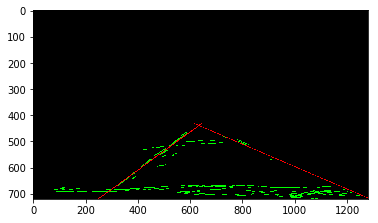

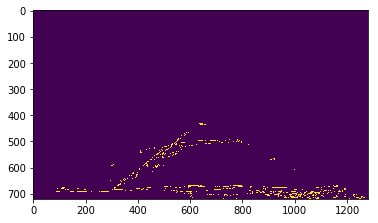

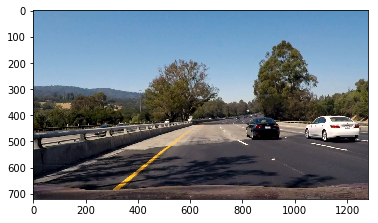

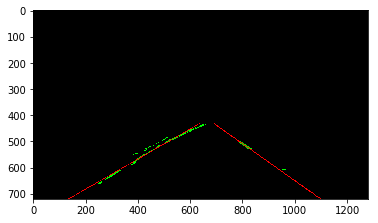

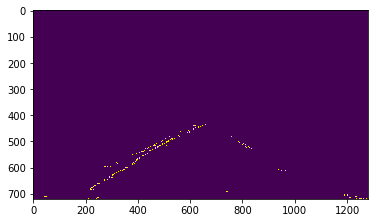

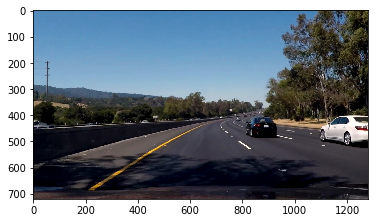

In [204]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [198]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))